In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture_hdf5 as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc
import ns, ns_hdf5


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/isolated_MSP/plots/'

2.1.2


In [2]:
##Field MSPs
msp_field = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/field_msps_wvu_latest.xlsx', 
                         names = ['PSR', 'P', 'DM', 'l', 'b', 'Pb', 'x', 'Discovery_year', 'Notes'])
porb = msp_field['Pb']
print(porb)
nnon = 0; nsin = 0
for xx in range(len(porb)):
    if porb[xx]=='*':
        nnon+=1
    elif porb[xx] != 'triple' and porb[xx] != 'pulsar' and porb[xx] != 'binary' and math.isnan(float(porb[xx])):
        nsin+=1
    
print(porb.isin(['*']).sum(), porb.isnull().sum(), len(porb))
print(nnon, nsin)
print(nsin/len(porb))
print(nsin/(len(porb)-nnon))

0        0.139
1          NaN
2        1.589
3        1.788
4        1.672
5            *
6          NaN
7       49.964
8      512.039
9        2.029
10         NaN
11         0.2
12      37.108
13       0.097
14         NaN
15           *
16      triple
17         NaN
18        6.96
19      669.07
20           *
21           *
22       5.741
23           *
24         4.9
25         NaN
26       4.847
27      54.103
28       0.286
29       1.198
        ...   
397          *
398        NaN
399      0.635
400      6.625
401      10.58
402      6.839
403          *
404          *
405      1.094
406          *
407      0.417
408      0.173
409     93.016
410          *
411       0.42
412     32.001
413     12.689
414          *
415      0.146
416       0.21
417          *
418    125.935
419        1.4
420      2.459
421          *
422        NaN
423      0.323
424      0.287
425      0.193
426     11.751
Name: Pb, dtype: object
104 84 427
104 84
0.19672131147540983
0.26006191950464397


0-0.2 5.357142857142857 4.071428571428571 0.5017147088720545
0.2-0.4 2.235294117647059 4.647058823529412 0.2324343690964758
>0.4 1.4285714285714286 2.7142857142857144 0.07936507936507937
[0.16666666666666666, 0.0, 0.5, 1.0, 0.0, 1.0, 0.0, 0.8333333333333334, 0.8888888888888888, 0.8888888888888888, 0.0] [0.3448275862068966, 0.4, 0.2, 0.5555555555555556, 0.0, 0.14285714285714285, 0.0, 0.0, 0.3333333333333333, 0.0, 0.5, 0.0, 0.0, 0.4418604651162791, 0.5, 0.6666666666666666, 0.8823529411764706, 0.0, 0.2857142857142857, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0]
Ks_2sampResult(statistic=0.4175084175084175, pvalue=0.09525310847018989)
119
0.2808988764044944
0.2619047619047619
0.26976744186046514
0.22321428571428573


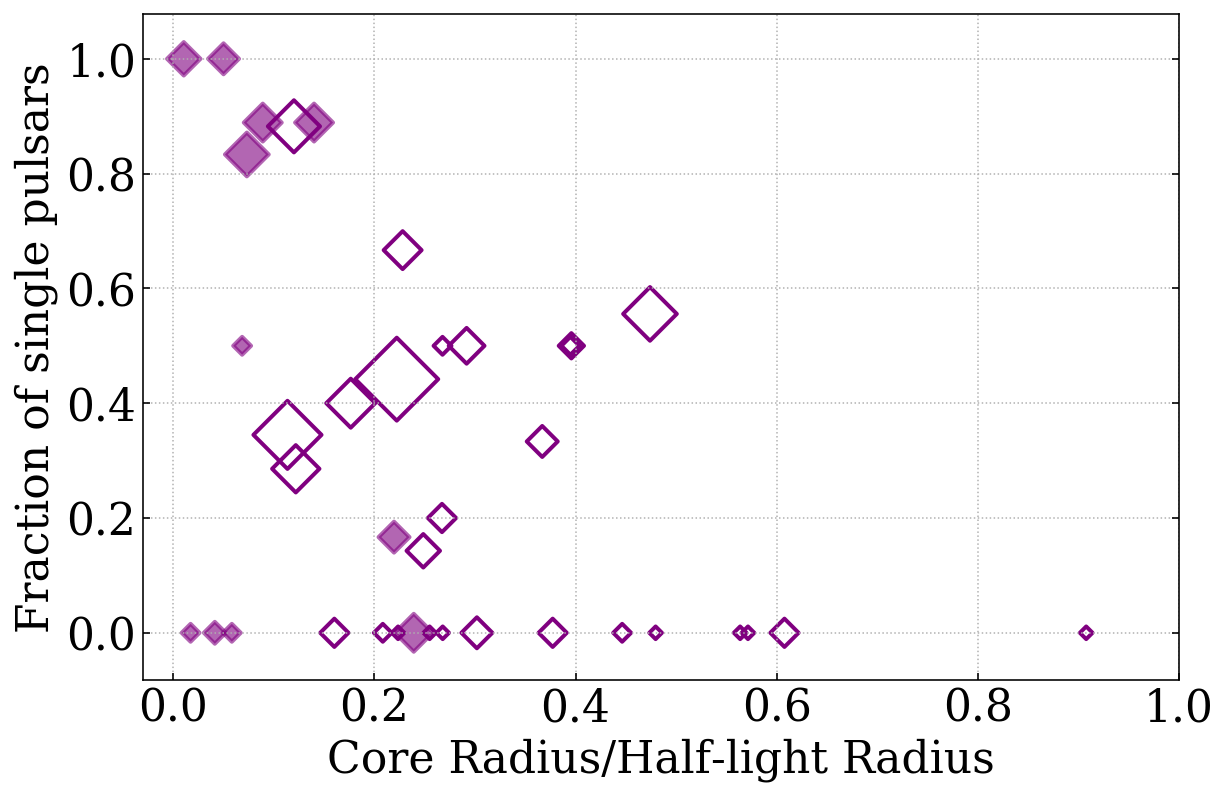

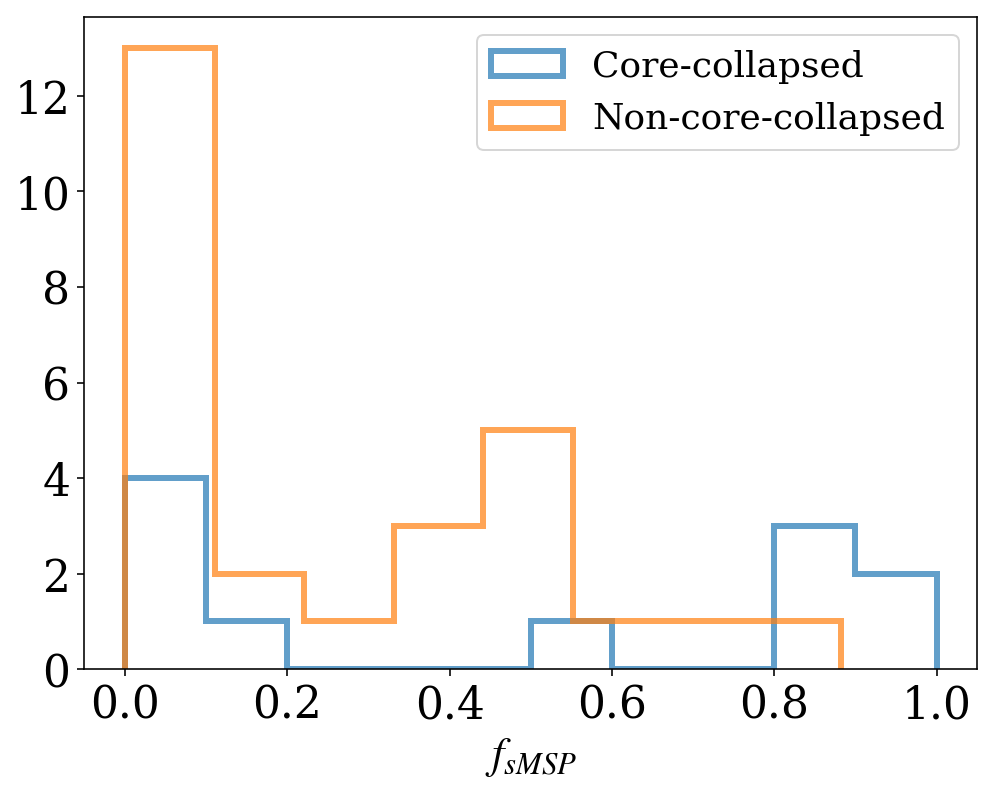

In [9]:
##Catalog Model Check
## isolated MSP fracion as a function of rc/rh
##Observed cluster rc and rh and Nmsp
data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = data_gcmsp['rc']; rhl_psrcat = data_gcmsp['rhl']
#print(rc_psrcat, data_gcmsp['name'])
Ntmsp = data_gcmsp['ntot'].values; Nbmsp = data_gcmsp['nbin'].values
CCst = data_gcmsp['cc'].values
r_ratio_psrcat = (rc_psrcat/rhl_psrcat)#[Nbmsp!='*']
rhl_psrcat = rhl_psrcat#[Nbmsp!='*']
rc_psrcat = rc_psrcat#[Nbmsp!='*']
Ntmsp = Ntmsp#[Nbmsp!='*']
CCst = CCst#[Nbmsp!='*']
Nbmsp = Nbmsp#[Nbmsp!='*']
Nsmsp = Ntmsp-Nbmsp
#print(r_ratio_psrcat[CCst==1], data_gcmsp['name'][CCst==1],
#      rc_psrcat[CCst==1], rhl_psrcat[CCst==1])
#     Nsmsp[CCst==1], Nbmsp[CCst==1])
f=open(savepath+'latex_ccpsr_table.txt', 'w+')
for ii in range(len(rc_psrcat[CCst==1])):
    f.write('%s & %.2f & %d & %d & %.2f\\\\\n'
            %(np.array(data_gcmsp['name'][CCst==1])[ii], np.array(r_ratio_psrcat[CCst==1])[ii], 
              Nsmsp[CCst==1][ii], Nbmsp[CCst==1][ii], 
              (Nsmsp/Ntmsp)[CCst==1][ii]))

f.close()

print('0-0.2', np.mean(Nsmsp[r_ratio_psrcat<=0.2]), np.mean(Nbmsp[r_ratio_psrcat<=0.2]),
      np.mean(Nsmsp[r_ratio_psrcat<=0.2]/Ntmsp[r_ratio_psrcat<=0.2]))
print('0.2-0.4', np.mean(Nsmsp[(r_ratio_psrcat>0.2) & (r_ratio_psrcat<=0.4)]), 
      np.mean(Nbmsp[(r_ratio_psrcat>0.2) & (r_ratio_psrcat<=0.4)]),
      np.mean(Nsmsp[(r_ratio_psrcat>0.2) & 
                               (r_ratio_psrcat<=0.4)]/Ntmsp[(r_ratio_psrcat>0.2) & 
                                                           (r_ratio_psrcat<=0.4)]))
print('>0.4', np.mean(Nsmsp[r_ratio_psrcat>0.4]), np.mean(Nbmsp[r_ratio_psrcat>0.4]),
      np.mean(Nsmsp[r_ratio_psrcat>0.4]/Ntmsp[r_ratio_psrcat>0.4]))

#print('sum_cc', np.sum(Nsmsp[CCst==1])/np.sum(Ntmsp[CCst==1]))
#print('sum_noncc', np.sum(Nsmsp[CCst!=1])/np.sum(Ntmsp[CCst!=1]))
#print('mean_cc', np.mean(Nsmsp[CCst==1]/Ntmsp[CCst==1]))
#print('mean_noncc', np.mean(Nsmsp[CCst!=1]/Ntmsp[CCst!=1]))
#print('median_cc', np.median(Nsmsp[CCst==1]/Ntmsp[CCst==1]))
#print('median_noncc', np.median(Nsmsp[CCst!=1]/Ntmsp[CCst!=1]))
#print('sum_tot', np.sum(Nsmsp)/np.sum(Ntmsp))
#print('mean_tot', np.mean(Nsmsp/Ntmsp))


fcc = list(Nsmsp[CCst==1]/Ntmsp[CCst==1])
fnoncc = list(Nsmsp[CCst!=1]/Ntmsp[CCst!=1])
print(fcc, fnoncc)
##K-S test to check if the two distributions are statistically different.
from scipy import stats
print(stats.ks_2samp(fcc, fnoncc))


#############################
data_nmsp = np.genfromtxt('/projects/b1095/syr904/projects/isolated_MSP/nmsp1000ms_rc_rh_12000.0myr.dat')
datapath = np.genfromtxt('/projects/b1095/syr904/projects/GCE/catalog/path_allfinished_newruns_maingrid.dat', 
                         dtype=str)
modelno = data_nmsp[:,0].astype(int)
sourcedir = datapath[:,0][modelno]
print(len(sourcedir))
Rg = []; Rv = []
for xx in range(len(sourcedir)):
    n, zm, r_g, r_v = uc.find_init_conditions(sourcedir[xx])
    Rg.append(r_g); Rv.append(r_v)
Rg=np.array(Rg)
Rv = np.array(Rv)
    
rc_obs = data_nmsp[:,5]; rhl_obs = data_nmsp[:,6]
nmsp_sin = data_nmsp[:,7]; nmsp_bin = data_nmsp[:,8]
r_ratio = rc_obs/rhl_obs
rc_obs_arcmin = uc.pc2arcsec(Rg, rc_obs)/60.

print(np.sum(nmsp_sin[r_ratio<=0.2])/np.sum(nmsp_sin[r_ratio<=0.2]+nmsp_bin[r_ratio<=0.2]))
print(np.sum(nmsp_sin[r_ratio>0.2])/np.sum(nmsp_sin[r_ratio>0.2]+nmsp_bin[r_ratio>0.2]))
print(np.sum(nmsp_sin)/np.sum(nmsp_sin+nmsp_bin))
print(np.sum(nmsp_sin[Rv==0.5])/np.sum(nmsp_sin[Rv==0.5]+nmsp_bin[Rv==0.5]))


##############################
r_ratio_bins = np.linspace(np.min(r_ratio), np.max(r_ratio), 16)
r_ratio_mean = []; nmsp_bin_tot = []; nmsp_sin_tot = []
for ii in range(len(r_ratio_bins)-1):
    r_ratio_mean.append((r_ratio_bins[ii+1]+r_ratio_bins[ii])/2.)
    nmsp_bin_tot.append(0); nmsp_sin_tot.append(0)
    for xx in range(len(r_ratio)):
        if r_ratio_bins[ii]<=r_ratio[xx]<=r_ratio_bins[ii+1]:
            nmsp_bin_tot[-1]+=nmsp_bin[xx]
            nmsp_sin_tot[-1]+=nmsp_sin[xx]

nmsp_bin_tot = np.array(nmsp_bin_tot)
nmsp_sin_tot = np.array(nmsp_sin_tot)
r_ratio_mean = np.array(r_ratio_mean)

pois_err_cc = (np.sqrt(Nsmsp)/Ntmsp)[CCst==1]
cc_frac = (Nsmsp/Ntmsp)[CCst==1]
for xx in range(len(cc_frac)):
    if cc_frac[xx]==1.:
        pois_err_cc[xx]==0
    if cc_frac[xx]+pois_err_cc[xx]>1.:
        pois_err_cc[xx]=1-cc_frac[xx]
        
yerrs_cc = [(np.sqrt(Nsmsp)/Ntmsp)[CCst==1], pois_err_cc]

pois_err_noncc = (np.sqrt(Nsmsp)/Ntmsp)[CCst==0]
noncc_frac = (Nsmsp/Ntmsp)[CCst==0]
for xx in range(len(noncc_frac)):
    if noncc_frac[xx]==1.:
        pois_err_noncc[xx]==0
    if noncc_frac[xx]+pois_err_noncc[xx]>1.:
        pois_err_noncc[xx]=1-noncc_frac[xx]
yerrs_noncc =  [(np.sqrt(Nsmsp)/Ntmsp)[CCst==0], pois_err_noncc]

fig, axs = plt.subplots(figsize = (9, 6))
#axs.scatter(r_ratio, nmsp_sin/(nmsp_sin+nmsp_bin), 
#            alpha=0.6, color = 'orange', s = (nmsp_sin+nmsp_bin)*12,
#            label = 'Catalog Models')
axs.scatter(r_ratio_psrcat[CCst==1], (Nsmsp/Ntmsp)[CCst==1],
            marker = 'D', s=Ntmsp[CCst==1]*20, alpha=0.6,
            edgecolor = 'purple', facecolor = 'purple', lw=2,
            label = 'Core-collapsed')
axs.scatter(r_ratio_psrcat[CCst==0], (Nsmsp/Ntmsp)[CCst==0],
            marker = 'D', s=Ntmsp[CCst==0]*20, facecolor = 'none',
            edgecolor = 'purple', lw=2,
            label = 'Non-core-collapsed')
#axs.errorbar(r_ratio_psrcat[CCst==1], (Nsmsp/Ntmsp)[CCst==1],
#             yerr = yerrs_cc,
#             ecolor='purple',
#            marker = 'D', markersize=10, alpha=0.8, ls='none',
#            markeredgecolor = 'purple', markerfacecolor = 'purple', lw=2,
#            label = 'Core-collapsed')
#axs.errorbar(r_ratio_psrcat[CCst==0], (Nsmsp/Ntmsp)[CCst==0],
#             yerr = yerrs_noncc,
#             ecolor='purple',
#            marker = 'D', markersize=10, markerfacecolor = 'none',
#            markeredgecolor = 'purple', lw=2, alpha=0.8, ls = 'none',
#            label = 'Non-core-collapsed')

#axs.scatter(rc_obs_arcmin, nmsp_sin/(nmsp_sin+nmsp_bin), 
#            alpha=0.6, color = 'orange', s = (nmsp_sin+nmsp_bin)*3+30,
#            label = 'Catalog Models')
#axs.scatter((r_ratio_psrcat*rhl_psrcat)[CCst==1], (Nsmsp/Ntmsp)[CCst==1],
#            marker = 'D', s=Ntmsp[CCst==1]*10, alpha=0.7,
#            edgecolor = 'purple', facecolor = 'purple',
#            label = 'Core-collapsed')
#axs.scatter((r_ratio_psrcat*rhl_psrcat)[CCst==0], (Nsmsp/Ntmsp)[CCst==0],
#            marker = 'D', s=Ntmsp[CCst==0]*10, facecolor = 'none',
#            edgecolor = 'purple',
#            label = 'Non-core-collapsed')

#axs.set_xlabel(r'$r_c/r_{hl}$')
axs.set_xlabel('Core Radius/Half-light Radius')
#axs.set_xlabel(r'$r_c \rm{[arcmin]}$')
axs.set_xlim(xmin = -0.03,xmax=1.0)
#axs.set_xscale('log')
#axs.set_ylabel(r'$f_{sMSP}$')
axs.set_ylabel('Fraction of single pulsars')
#axs.legend(loc='upper right', fontsize=18, frameon=True)
axs.grid(linestyle=':',which='major',linewidth='0.75')
axs.grid(linestyle=':',which='minor',linewidth='0.75')
axs.tick_params(top=False, right=True, direction = 'in', which='both')

fig.tight_layout()
#plt.savefig(savepath+'fsmap_rcrh_observation_errbar.pdf', dpi=300)


plt.figure(figsize=(8,6))
plt.hist(fcc,
        lw=3, alpha=0.7,
         histtype='step',label = 'Core-collapsed')
plt.hist(fnoncc, bins=8,
         histtype='step', lw=3, alpha=0.7,
         label = 'Non-core-collapsed')
plt.xlabel(r'$f_{sMSP}$')
plt.legend(fontsize=18)

[19  5  9  4  8  5  6  1  1  4  2  1  9  1  1  0  5  2 24  4  3  2  0  1
  3  2 10  2  2  1  1  1  1  1  5  1  6  2] [10  1  6  1 10  0  1  0  0  2  0  1  0  0  1  7  0  0 19  4  6 15  6  0
  0 10  4  0  2  0  0  0  8  1  0  8  0  0] ['47 Tucanae (NGC 104)' 'NGC 362' 'NGC 1851' 'M53 (NGC 5024)'
 'ω Centauri (NGC 5139)' 'M3 (NGC 5272)' 'M5 (NGC 5904)' 'NGC 5986'
 'M4 (NGC 6121)' 'M13 (NGC 6205)' 'M12 (NGC 6218)' 'M10 (NGC 6254)'
 'M62 (NGC 6266)' 'M92 (NGC 6341)' 'NGC 6342' 'Terzan 1' 'M14 (NGC 6402)'
 'NGC 6397' 'Terzan 5' 'NGC 6440' 'NGC 6441' 'NGC 6517' 'NGC 6522'
 'NGC 6539' 'NGC 6544' 'NGC 6624' 'M28 (NGC 6626)' 'NGC 6652'
 'M22 (NGC 6656)' 'Glimpse C-01' 'NGC 6712' 'NGC 6749' 'NGC 6752'
 'NGC 6760' 'M71 (NGC 6838)' 'M15 (NGC 7078)' 'M2 (NGC 7089)'
 'M30 (NGC 7099)'] [29  6 15  5 18  5  7  1  1  6  2  2  9  1  2  7  5  2 43  8  9 17  6  1
  3 12 14  2  4  1  1  1  9  2  5  9  6  2]
mean fraction 0.6965540590946209
mean fraction 0.5202020202020201 0.7684011860508656
total sin fracti

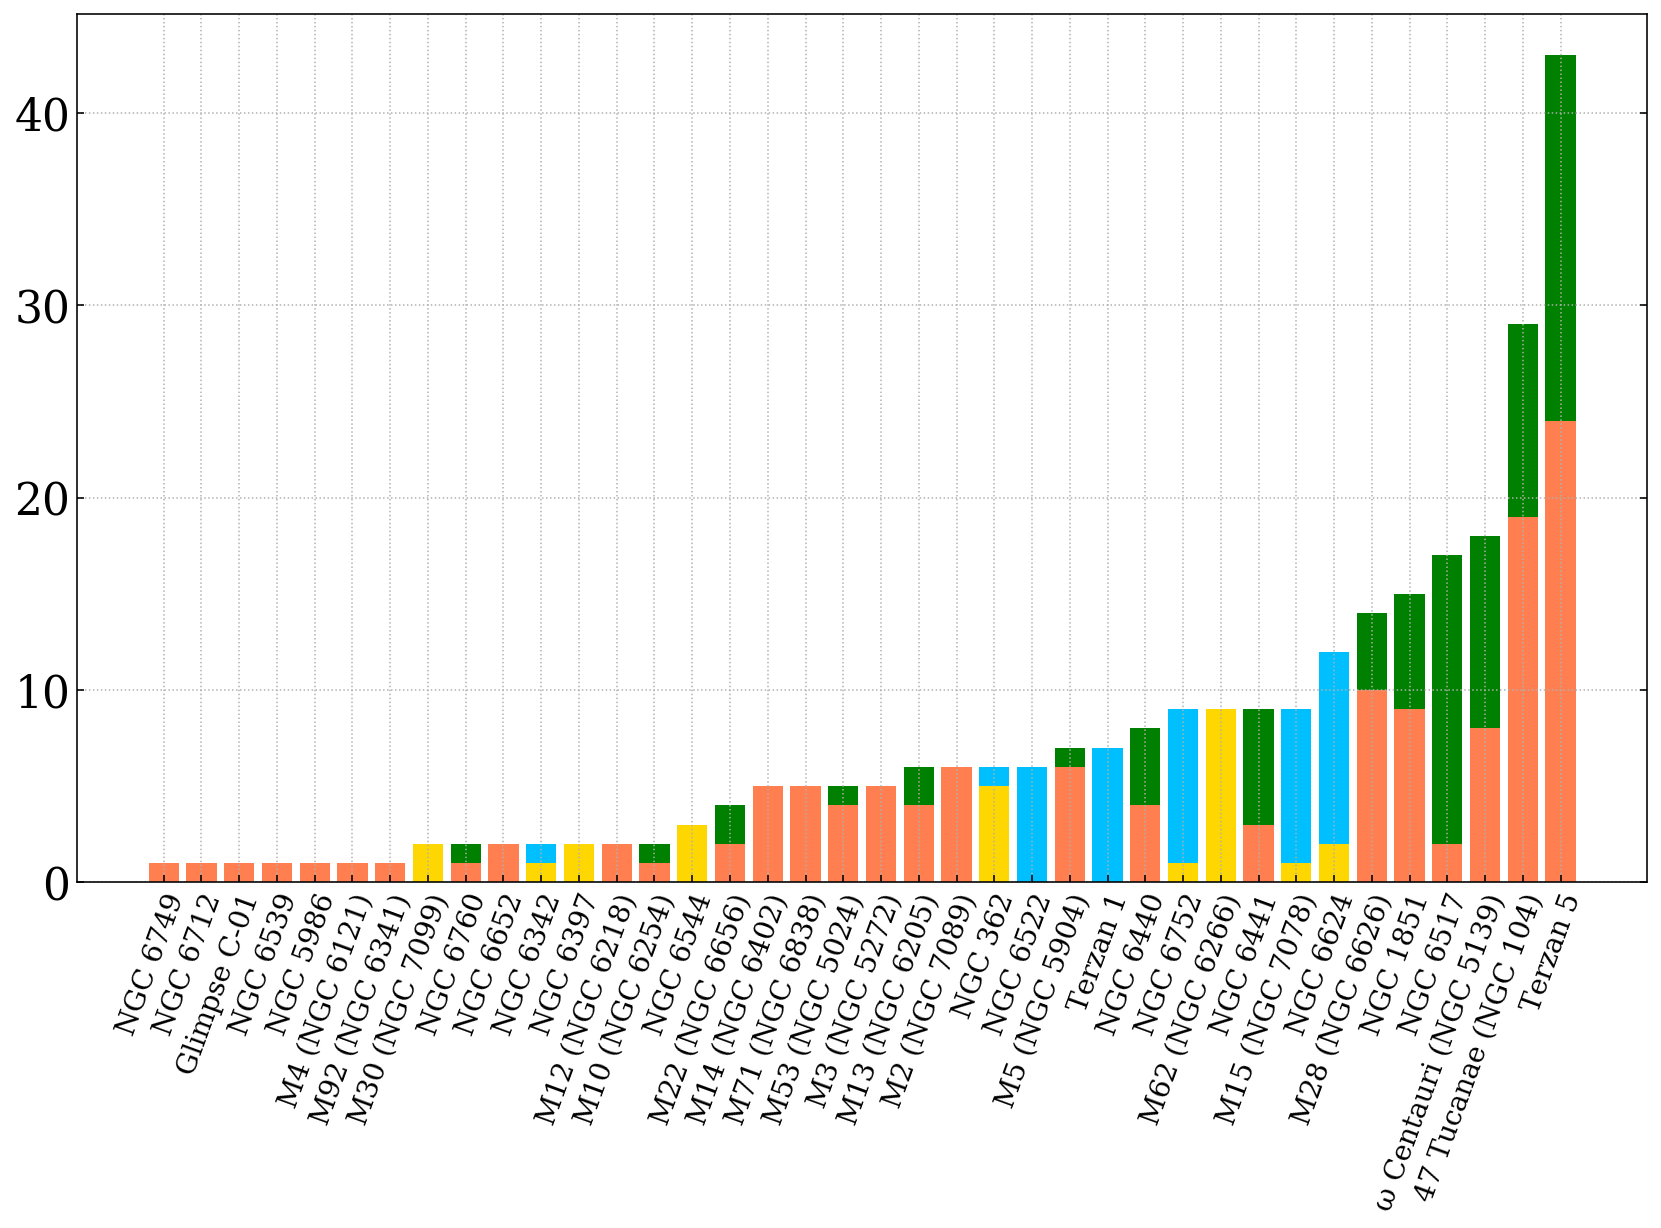

In [3]:
##Total fraction of isolated MSPs in CC clusters
data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
#print(data_gcmsp['name'][data_gcmsp['cc']==1])
nbmsp = np.array(data_gcmsp['nbin'])
ntmsp = np.array(data_gcmsp['ntot'])#[nbmsp!='*']
nsmsp = ntmsp-nbmsp
name_msp = np.array(data_gcmsp['name'])
ccst = np.array(data_gcmsp['cc'])#[nbmsp!='*']
nbmsp = nbmsp#[nbmsp!='*']
ntmsp_cc = ntmsp[ccst==1]; nbmsp_cc = nbmsp[ccst==1]
ntmsp_noncc = ntmsp[ccst==0]; nbmsp_noncc = nbmsp[ccst==0]
print(nbmsp, nsmsp, name_msp, ntmsp)

print('mean fraction', np.mean(nbmsp/ntmsp))
print('mean fraction', np.mean(nbmsp_cc/ntmsp_cc), np.mean(nbmsp_noncc/ntmsp_noncc))

print('total sin fraction', 1-np.sum(nbmsp)/np.sum(ntmsp))
print('total sin fraction', 1-np.sum(nbmsp_cc)/np.sum(ntmsp_cc), 1-np.sum(nbmsp_noncc)/np.sum(ntmsp_noncc))


sort_ntmsp = ntmsp[ntmsp.argsort()]
sort_name_msp = name_msp[ntmsp.argsort()]
sort_nbmsp = nbmsp[ntmsp.argsort()]
sort_nsmsp = nsmsp[ntmsp.argsort()]
sort_ccst = ccst[ntmsp.argsort()]
print(sort_name_msp, sort_ntmsp, sort_nbmsp, sort_nsmsp, sort_ccst)

cs = []; cb = []
for ii in range(len(sort_ccst)):
    if sort_ccst[ii]==0:
        cs.append('green')
        cb.append('coral')
    else:
        cs.append('deepskyblue')
        cb.append('gold')
print(cs, cb)
fig, ax = plt.subplots(figsize=(12,9))
#ax.bar(range(len(sort_name_msp[sort_ccst==1])), sort_nbmsp[sort_ccst==1])
#ax.bar(range(len(sort_name_msp[sort_ccst==1])), sort_nsmsp[sort_ccst==1],
#       bottom = sort_nbmsp[sort_ccst==1])
#ax.set_xticks(range(len(sort_name_msp[sort_ccst==1])))
#ax.set_xticklabels(sort_name_msp[sort_ccst==1])
##ax.text(sort_name_msp[sort_ccst==1], sort_ntmsp[sort_ccst==1], sort_ntmsp[sort_ccst==1], 
##        ha = 'center')
#ax.bar(range(len(sort_name_msp[sort_ccst==0])), sort_nbmsp[sort_ccst==0])
#ax.bar(range(len(sort_name_msp[sort_ccst==0])), sort_nsmsp[sort_ccst==0],
#       bottom = sort_nbmsp[sort_ccst==0])
#ax.set_xticks(range(len(sort_name_msp[sort_ccst==0])))
#ax.set_xticklabels(sort_name_msp[sort_ccst==0])
ax.bar(range(len(sort_name_msp)), sort_nbmsp, color = cb)
ax.bar(range(len(sort_name_msp)), sort_nsmsp,
       bottom = sort_nbmsp, color = cs)
ax.set_xticks(range(len(sort_name_msp)))
ax.set_xticklabels(sort_name_msp)
ax.tick_params(axis='x', labelrotation=70)
ax.grid(linestyle=':',which='major',linewidth='0.75')
ax.grid(linestyle=':',which='minor',linewidth='0.75')
ax.tick_params(top=False, right=True, direction = 'in', which='both')
# Eventually, this shouldn't be needed and an `ha` argument should
# be available for the above.
plt.xticks(ha='right', fontsize=14, rotation_mode='anchor')
fig.tight_layout()

In [18]:
pspin, pdot, binflag, namespin, period, ecc, mc, names, pall, bfall, nameall, clusall = pc.readdata_freire(spinflag=1,offsetflag=0)
print(len(clusall), len(pall))
pall=np.array(pall); bfall = np.array(bfall); clusall = np.array(clusall)
pmsp = pall[pall<=30]; bfall = bfall[pall<=30]; clusall = clusall[pall<=30]
print(len(clusall), clusall)

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
CCst = np.array(data_gcmsp['cc'])
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T' or str(clusname[ii])[0]=='G':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)
print(clusno)

allcc = []
for kk in range(len(clusall)):
    allcc.append(CCst[clusno==clusall[kk]][0])
allcc = np.array(allcc)


print(len(pmsp[bfall==0])/len(pmsp))
print(len(pmsp[(bfall==0) & (allcc==0)])/len(pmsp[allcc==0]))
print(len(pmsp[(bfall==0) & (allcc==1)])/len(pmsp[allcc==1]))

280
280 280
258 ['104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104'
 '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104'
 '104' '104' '104' '104' '104' '362' '362' '362' '362' '1851' '1851'
 '1851' '1851' '1851' '1851' '1851' '1851' '1851' '1851' '1851' '1851'
 '1851' '1851' '5024' '5024' '5024' '5024' '5139' '5139' '5139' '5139'
 '5139' '5139' '5139' '5139' '5139' '5139' '5139' '5139' '5139' '5139'
 '5139' '5139' '5139' '5139' '5272' '5272' '5272' '5272' '5272' '5272'
 '5904' '5904' '5904' '5904' '5904' '5904' '5904' '5986' '6121' '6205'
 '6205' '6205' '6205' '6205' '6205' '6218' '6218' '6254' '6254' '6266'
 '6266' '6266' '6266' '6266' '6266' '6266' '6266' '6266' '6341' '6342' '1'
 '1' '1' '1' '1' '1' '6402' '6402' '6402' '6402' '6402' '6397' '6397' '5'
 '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '6440' '6440' '6440' '6440'

In [4]:
##Offsets
Poff, Offset, Binoff, Nameoff, Clusteroff = pc.readdata_freire(spinflag=0,offsetflag=1)
Offset = np.array(Offset)
Binoff = np.array(Binoff)
Poff = np.array(Poff)

print(len(Offset[Binoff==0]), len(Offset[Binoff==1]))

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
cluname = np.array(data_gcmsp['name']); ccst = np.array(data_gcmsp['cc'])
cnames = []
for ii in range(len(cluname)):
    cnames.append(cluname[ii].split()[1])
cnames = np.array(cnames)

CCoff = []; Rcoff = []; Rhoff = []
for jj in range(len(Clusteroff)):
    for kk in range(len(cnames)):
        if cnames[kk]==Clusteroff[jj]:
            cc = ccst[kk]
            rc = data_gcmsp['rc'][kk]
            rh = data_gcmsp['rhl'][kk]
    CCoff.append(cc); Rcoff.append(rc); Rhoff.append(rh)
CCoff=np.array(CCoff)
Rcoff=np.array(Rcoff); Rhoff=np.array(Rhoff)
#print(Rcoff)

Ps = Poff[Binoff==0]; Offs = Offset[Binoff==0]
Pb = Poff[Binoff==1]; Offb = Offset[Binoff==1]
CCs = CCoff[Binoff==0]
CCb = CCoff[Binoff==1]
Rcs = Rcoff[Binoff==0]; Rhs = Rhoff[Binoff==0]
Rcb = Rcoff[Binoff==1]; Rhb = Rhoff[Binoff==1]

def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1,
               alpha=0.7,
               label = 'sMSP')
    ax.scatter(x2, y2,
               alpha=0.7,
               label='bMSP')
    #ax.scatter(x3, y3,
    #           alpha=0.7,
    #           label = 'nonCC-bMSP')
    #ax.scatter(x4, y4,
    #           alpha=0.7,
    #           label='CC-bMSP')
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 12), 
                  log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 12), orientation='horizontal',
                 log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x2)), np.log10(np.max(x2)), 14), 
                  log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histy.hist(y2, bins=np.logspace(np.log10(np.min(y2)), np.log10(np.max(y2)), 14), orientation='horizontal',
                 log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histx.hist(x3, bins=np.logspace(np.log10(np.min(x3)), np.log10(np.max(x3)), 12), 
    #              log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histy.hist(y3, bins=np.logspace(np.log10(np.min(y3)), np.log10(np.max(y3)), 12), orientation='horizontal',
    #             log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histx.hist(x4, bins=np.logspace(np.log10(np.min(x4)), np.log10(np.max(x4)), 14), 
    #              log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histy.hist(y4, bins=np.logspace(np.log10(np.min(y4)), np.log10(np.max(y4)), 14), orientation='horizontal',
    #             log=False, histtype = 'step', lw = 3, alpha=0.7)
    
    #ax.set_xlim(xmin = 0.004, xmax = 1.5)
    #ax.set_ylim(ymin = 0.01, ymax = 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel(r'$Offset/r_{hl}$')
    #ax.set_ylabel(r'$P\,\rm{(ms)}$')
    ax.legend(loc = 'best', fontsize = 18, frameon = False)
    
    
    #ax_histx.set_yticks([1., 100., 500.])
    #ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(Rhoff[Binoff==0], Offset[Binoff==0],
             Rhoff[Binoff==1], Offset[Binoff==1],
             ax, ax_histx, ax_histy)
fig.tight_layout()


fig, ax = plt.subplots(figsize=(8,6))
ax.hist((Offs/Rcs)[CCs==1], 
        bins = np.logspace(np.log10(np.min((Offs/Rcs)[CCs==1])), np.log10(np.max((Offs/Rcs)[CCs==1])), 9),
        alpha=0.7, histtype='step', lw=3,
        label = 'sMSP')
ax.hist((Offb/Rcb)[CCb==1],
        bins = np.logspace(np.log10(np.min((Offb/Rcb)[CCb==1])), np.log10(np.max((Offb/Rcb)[CCb==1])), 9),
        alpha=0.7, histtype='step', lw=3,
        label = 'bMSP')

ax.legend(loc='best')

#ax.set_ylim(ymin = 0.8, ymax = 3000)
#ax.set_yscale('log')
ax.set_xscale('log')

279
65 76


NameError: name 'cc' is not defined

In [2]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allpaths.dat',
                         dtype=str)
model_label = sourcedir[:,0]; paths = sourcedir[:,1]
#model_label = ['Fiducial', 'TDE0.2', 'TDE0.8', 'WDTC', 'TDE0.2-WDTC', 'TDE0.2-WDTC-GCTC', 'WDTC_NSM', 'Alloff_WM']
snap_h5 = 'initial.snapshots.h5'
ab_cut = 8


#cs = ['b', 'blueviolet', 'darkturquoise', 'yellowgreen', 'coral','orange','gold', 'gray']
ca = cm.winter(np.linspace(0.5, 1, 9))
cb = cm.Wistia(np.linspace(0.5, 1, 9))
cs = np.concatenate((ca,cb))
cmap=matplotlib.colors.ListedColormap([ca[0], ca[1], ca[2], ca[3], ca[4], ca[5], ca[6], ca[7], ca[8],
                                      cb[0], cb[1], cb[2], cb[3], cb[4], cb[5], cb[6], cb[7], cb[8]])

dpsr = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psr_6752.xlsx',
                    names = ['psr_name','offset','spin','pdot','dm','pb','x','ecc','mc'])

#snapkeys = np.genfromtxt(paths[xx]+'snap_keys.txt', dtype='str')
#last_no = snapkeys[:,0][-1]; last_time = snap_h5[:,1][-1]
#
#last_key = '/'+last_no+'(t='+last_time+')'
#last_snap = cmct.Snapshot(fname=paths[xx]+snap_h5, snapshot_name=last_key, conv=paths[xx]+'initial.conv.sh')
#binflag = np.array(last_snap.data['binflag'])
#ktype = np.array(last_snap.data['startype'])[binflag!=1]
#k0 = np.array(last_snap.data['bin_startype0'])[binflag==1]
#k1 = np.array(last_snap.data['bin_startype1'])[binflag==1]
#
#bfield = np.array(last_snap.data['B'])[binflag!=1][ktype==13]
#b0 = np.array(last_snap.data['B0'])[binflag==1][k0==13]
#b1 = np.array(last_snap.data['B1'])[binflag==1][k1==13]
#pspin = twopi*yearsc/np.array(last_snap.data['ospin'])[binflag!=1][ktype==13]
#p0 = twopi*yearsc/np.array(last_snap.data['ospin0'])[binflag==1][k0==13]
#p1 = twopi*yearsc/np.array(last_snap.data['ospin1'])[binflag==1][k1==13]

48 27
9 4


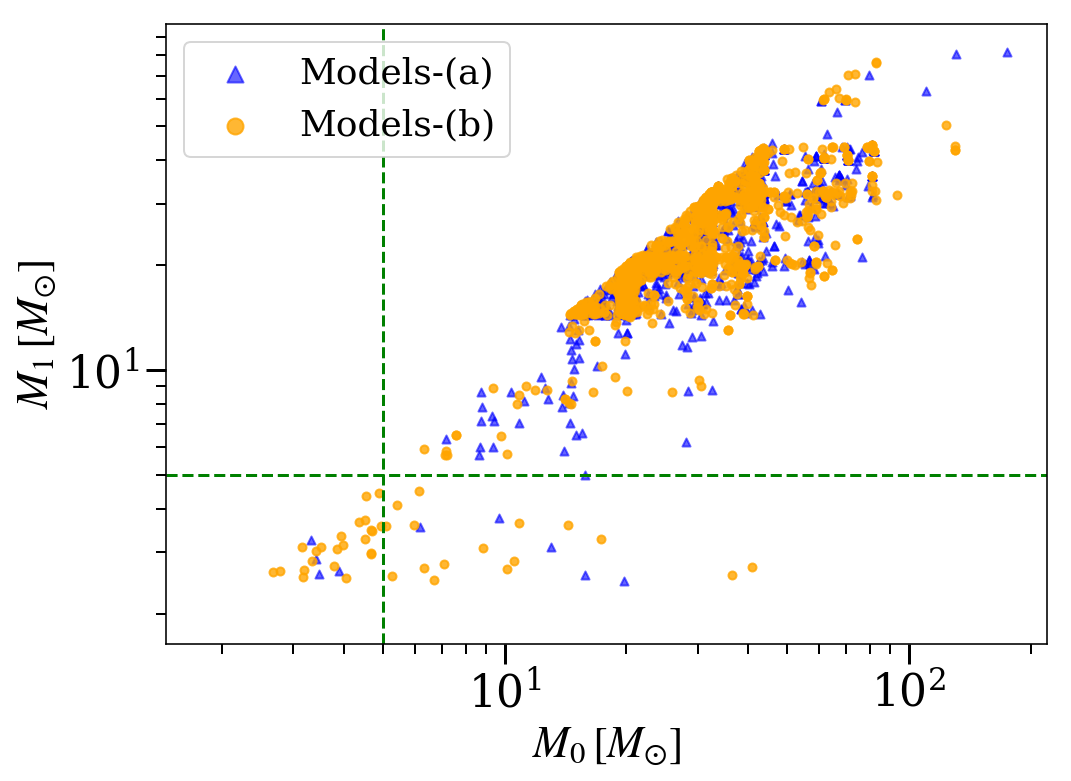

In [3]:
##BBH mergers in models
m0 = []; m1 = []; model_no = []; bbh_type = []; id_bh1 = []; id_bh2 = []
for ii in range(len(paths)):
    #print(paths[ii])
    bbh_col = np.genfromtxt(paths[ii]+'GWcap_BBH.dat')
    three_col = bbh_col[:,12]
    bbh_mer = np.genfromtxt(paths[ii]+'Incluster_BBH.dat')
    bbh_esc = np.genfromtxt(paths[ii]+'Esc_BBH.dat')
    t_merger = bbh_esc[:,2]+bbh_esc[:,3]
    
    m0 = m0+list(bbh_col[:,10][three_col==-100])
    m1 = m1+list(bbh_col[:,11][three_col==-100])
    bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
    model_no=model_no+list(np.full_like(bbh_col[:,10][three_col==-100], ii))
    
    m0 = m0+list(bbh_mer[:,7])
    m1 = m1+list(bbh_mer[:,8])
    bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
    model_no = model_no+list(np.full_like(bbh_mer[:,7], ii))
    
    m0=m0+list(bbh_esc[:,4][t_merger<=14000.])
    m1=m1+list(bbh_esc[:,5][t_merger<=14000.])
    bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
    model_no = model_no+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], ii))

M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
model_no = np.array(model_no)
print(len(M1[M1<5]), len(M0[(M1<5) & (M0<5)]))
print(len(M1[(M1<5) & (model_no<=8)]), len(M0[(M1<5) & (M0<5) & (model_no<=8)]))

fig, axs = plt.subplots(figsize=(8,6))
axs.scatter(M0[model_no<=8], M1[model_no<=8], marker='^',
            alpha=0.6, s=16, color = 'b', label='Models-(a)')
axs.scatter(M0[model_no>8], M1[model_no>8],
            alpha=0.8, s=16, color='orange', label='Models-(b)')
axs.axhline(y=5, ls='--', color='green')
axs.axvline(x=5, ls='--', color='green')
axs.set_xlabel(r'$M_0\,[M_{\odot}]$')
axs.set_ylabel(r'$M_1\,[M_{\odot}]$')
axs.set_xscale('log')
axs.set_yscale('log')
axs.tick_params('both', length=10, width=1.5, which='major')
axs.tick_params('both', length=5, width=1, which='minor')
axs.legend(loc='upper left', fontsize=18, markerscale=2)
fig.tight_layout()

#plt.savefig(savepath+'BBH_masses.pdf', dpi=300)

/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean MS mass nan
0 0 0
0 1a 0
t_myr 134
num of TDE? 0
[]
nbh 0
ttde 0 134
num of tde msp? 0
mean MS mass nan
0 0 0
1 2a 0
t_myr 170
num of TDE? 0
[]
nbh 0
ttde 0 170
num of tde msp? 0
mean MS mass 0.788650549375
160 29 159
2 3a 160
t_myr 130
num of TDE? 156
[0.80826  1.33596  0.795441 0.751688]
nbh 4
ttde 160 130
num of tde msp? 146
mean MS mass 0.8563805301075268
279 63 277
3 4a 278
t_myr 241
num of TDE? 272
[1.15098  1.20411  0.899237 0.435313 0.579469 0.52686  0.678902]
nbh 6
ttde 279 241
num of tde msp? 276
mean MS mass 0.8442657941634242
257 43 256
4 5a 256
t_myr 226
num of TDE? 254
[1.38221  1.83153  0.611512]
nbh 2
ttde 257 226
num of tde msp? 253
mean MS mass 0.8228919879518072
166 21 166
5 6a 166
t_myr 150
num of TDE? 163
[1.32149  1.16443  0.699864]
nbh 3
ttde 166 150
num of tde msp? 163
mean MS mass 0.857633508982036
167 16 16
6 7a 167
t_myr 155
num of TDE? 165
[1.10332  0.664185]
nbh 2
ttde 167 155
num of tde msp? 16
mean MS mass nan
0 0 0
7 8a 0
t_myr 146
num of TDE? 0
[]


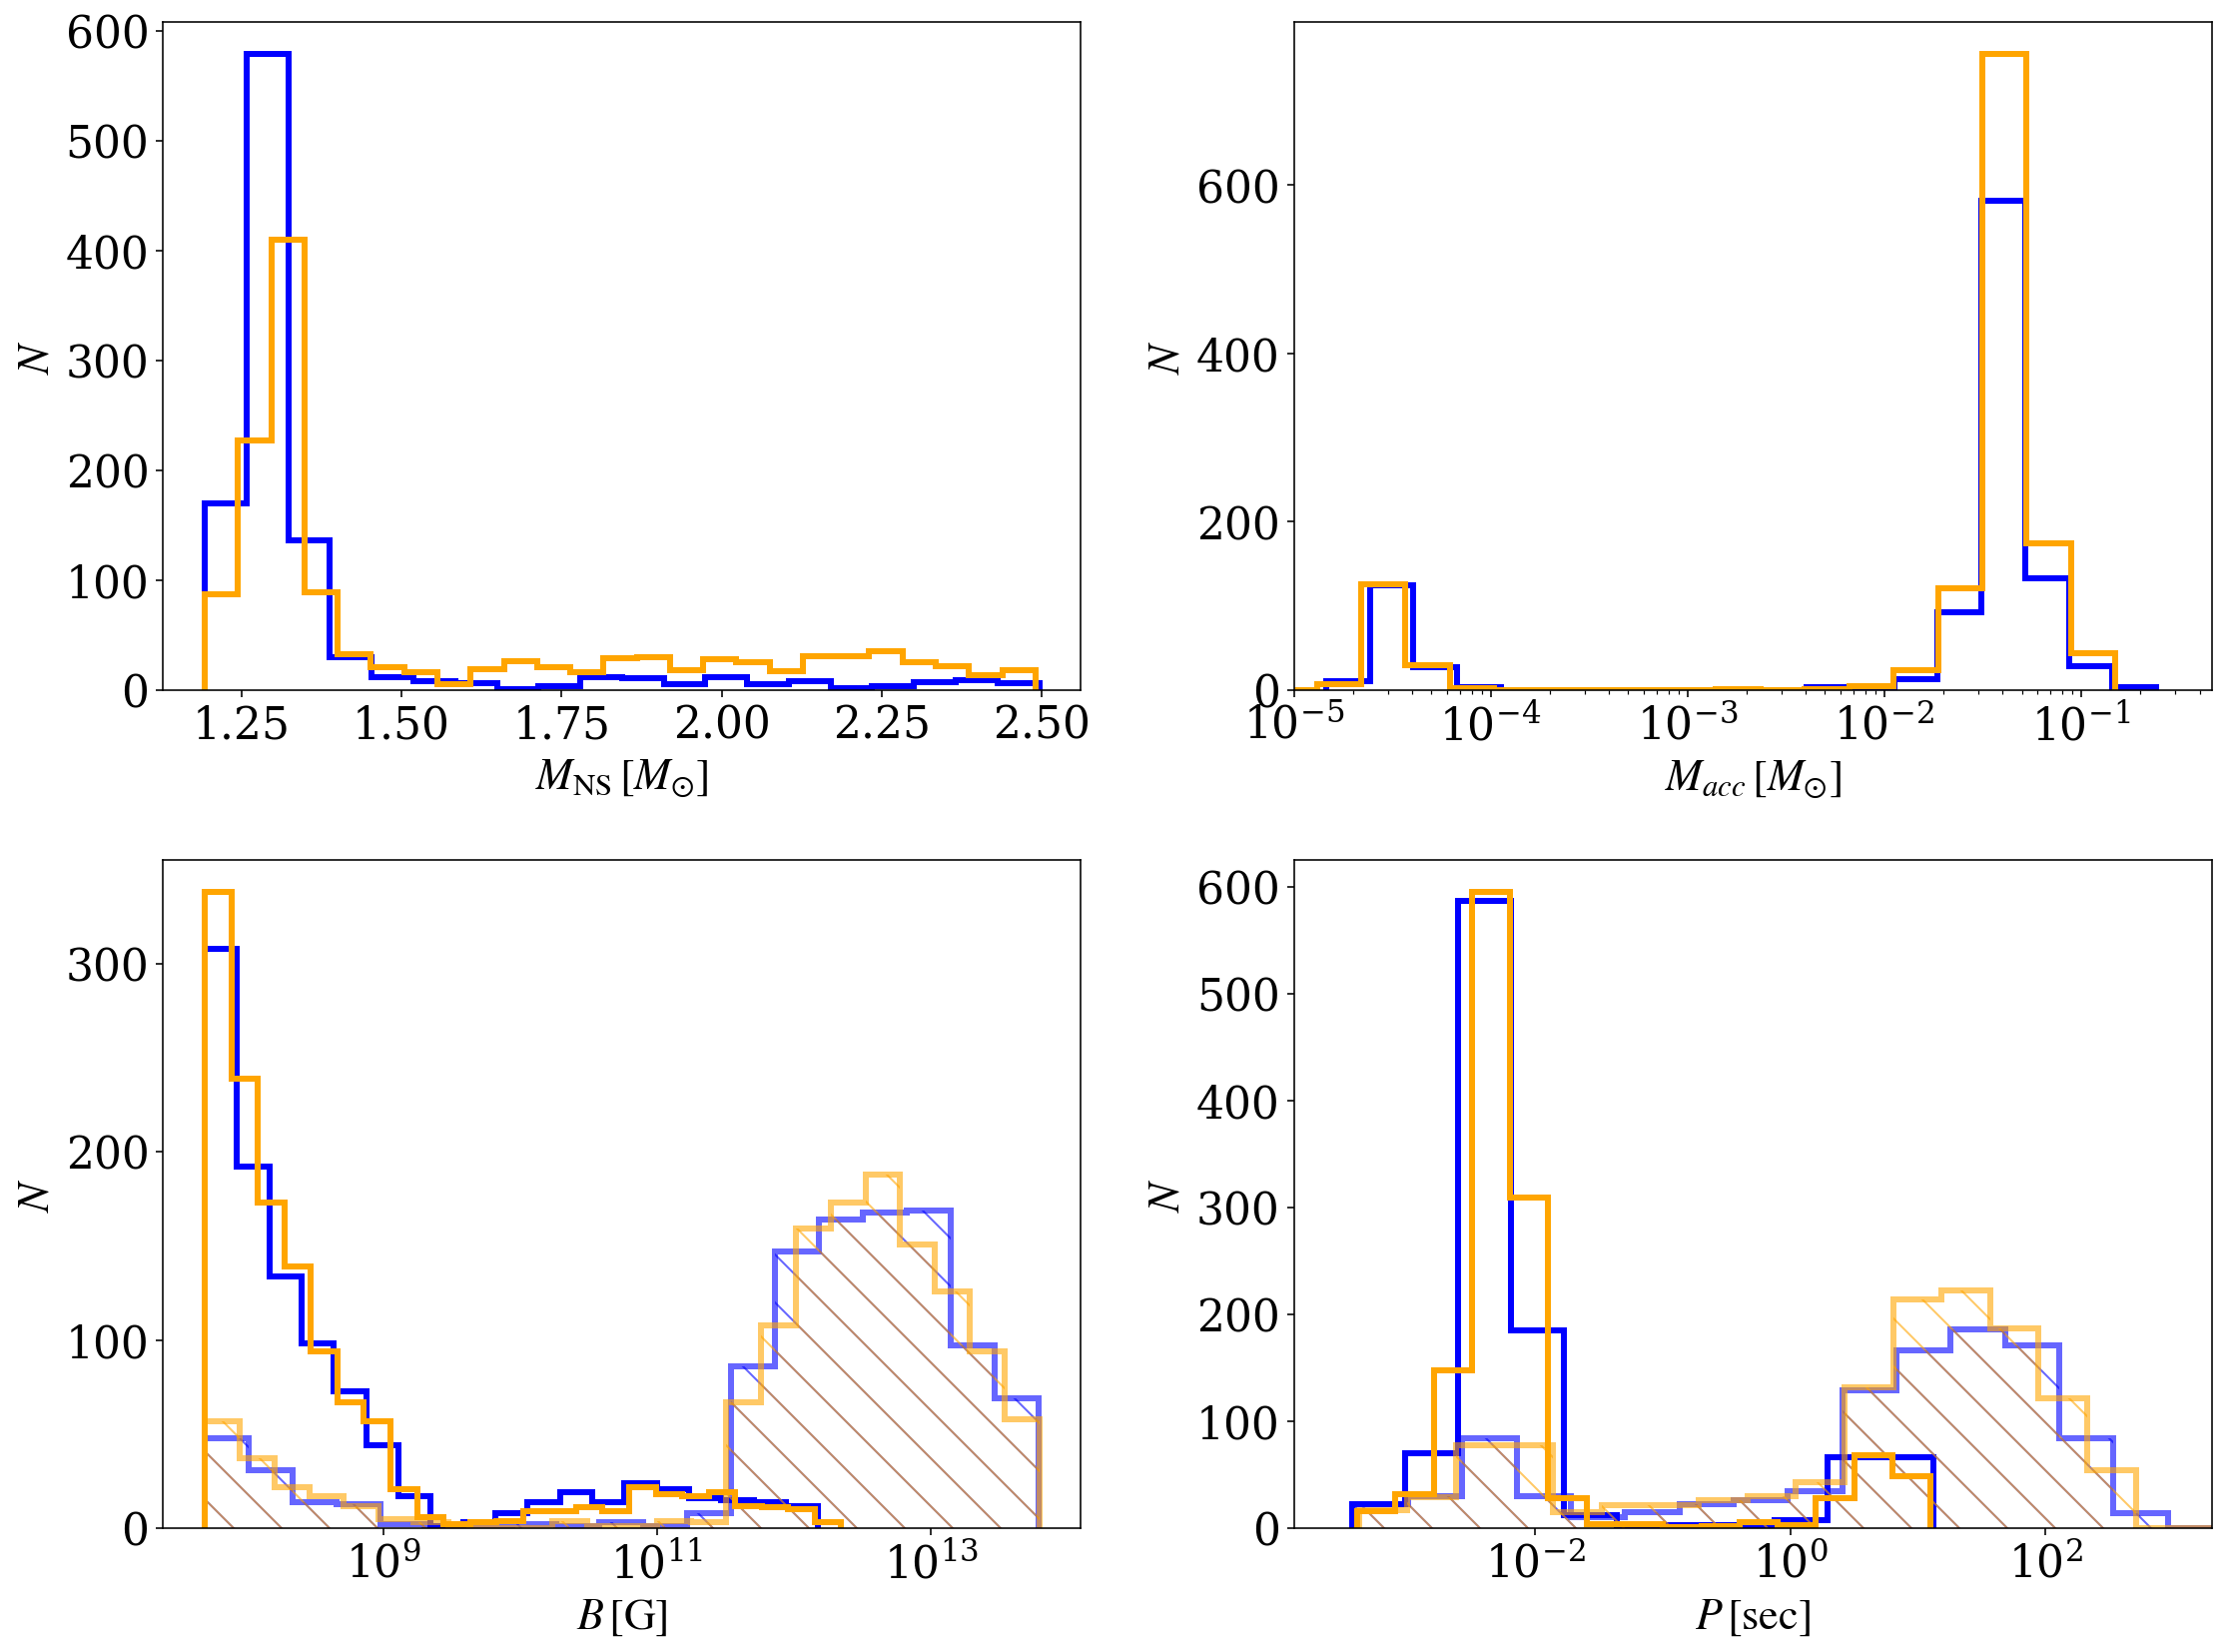

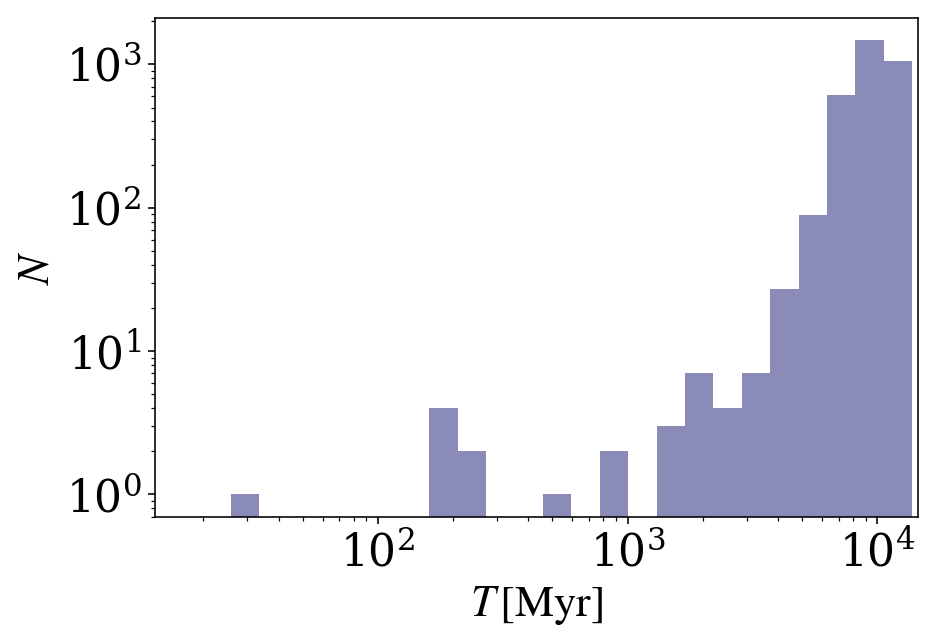

In [3]:
##Number of TDEs in different models
##For collisions with more than one star,
##e.g., one NS colliding with 2 MS,
##there will be two TDE printouts in the error.out file
##may want to subtract the number here; write in paper
N_tde = []

Mnew_all = [[],[]]; Macc_all = [[],[]]
Bnew_all = [[],[]]; Bold_all = [[],[]]; Pnew_all = [[],[]]; Pold_all = [[],[]]
idtde_all = []; idtde_latercoll_all = []
idtde_msp_all = []; idtde_msp_norepeater = []
ttde = []

ttot_myr = []
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
for xx in range(len(paths)):
    m_ns = []; B_ns = []; Ospin_ns = []
    m_new = []; B_new = []; Ospin_new = []; Macc = []
    m_star_all = []; k_star_all = []
    nbh = 0
    
    error_out = paths[xx]+'error.out'
    with open(error_out, 'r') as ferr:
        for line in ferr:
            data=line.split()
            if data[0]=='Before':
                m_star = float(data[3].split('=')[1])
                r_star = float(data[4].split('=')[1])
                k_star = float(data[5].split('=')[1])
                m_ns.append(float(data[6].split('=')[1]))
                B_ns.append(float(data[7].split('=')[1]))
                Ospin_ns.append(float(data[8].split('=')[1]))
                
                m_star_all.append(m_star); k_star_all.append(k_star)
            if data[0]=='After':
                m_new.append(float(data[3].split('=')[1]))
                B_new.append(float(data[4].split('=')[1]))
                Ospin_new.append(float(data[5].split('=')[1]))
                Macc.append(float(data[6].split('=')[1]))
    
    print('mean MS mass', np.mean(m_star_all))
    Psec_old = twopi*yearsc/np.array(Ospin_ns)
    Psec_new = twopi*yearsc/np.array(Ospin_new)
    
    print(len(Psec_old), len(Psec_old[Psec_old<=0.03]), len(Psec_new[Psec_new<=0.03]))  ##write in paper
    
    print(xx, model_label[xx], len(Psec_new[np.array(m_new)<=2.5]))
    N_tde.append(len(Psec_new))
    
    idtde = np.full(len(m_star_all),-100)
    ttde.append(np.full(len(m_star_all),-100.0))
    
    if xx <= ab_cut:
        Mnew_all[0] = Mnew_all[0]+m_new
        Macc_all[0] = Macc_all[0]+Macc
        Bold_all[0] = Bold_all[0]+B_ns
        Bnew_all[0] = Bnew_all[0]+B_new
        Pold_all[0] = Pold_all[0]+list(Psec_old)
        Pnew_all[0] = Pnew_all[0]+list(Psec_new)
    else:
        Mnew_all[1] = Mnew_all[1]+m_new
        Macc_all[1] = Macc_all[1]+Macc
        Bold_all[1] = Bold_all[1]+B_ns
        Bnew_all[1] = Bnew_all[1]+B_new
        Pold_all[1] = Pold_all[1]+list(Psec_old)
        Pnew_all[1] = Pnew_all[1]+list(Psec_new)
        
        
    ##Check the collision file
    nsms_coll = np.genfromtxt(paths[xx]+'ns_nsms_coll.dat')
    t_myr = nsms_coll[:,1]; k3 = nsms_coll[:,12]; k4 = nsms_coll[:,13]
    ttot_myr = ttot_myr+list(t_myr)
    #print('num coll', len(t_myr))
    #print('repeat', len(k3[k3!=-100]), len(k4[k4!=-100]))
    print('t_myr', len(t_myr))
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    mcollall = [ns_collproduct[:,5], ns_collproduct[:,6], ns_collproduct[:,7], ns_collproduct[:,8]]
    kcollall = [ns_collproduct[:,10], ns_collproduct[:,11], ns_collproduct[:,12], ns_collproduct[:,13]]
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    t_nscoll =  ns_collproduct[:,1]
    
    bh_collproduct = np.genfromtxt(paths[xx]+'bh_collproduct_all.dat')
    bh_mcollall = [bh_collproduct[:,5], bh_collproduct[:,6], bh_collproduct[:,7], bh_collproduct[:,8]]
    bh_kcollall = [bh_collproduct[:,10], bh_collproduct[:,11], bh_collproduct[:,12], bh_collproduct[:,13]]
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    for kk in range(len(m_star_all)):
        for zz in range(len(mcollall)):
            if len(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)])>0:
                if len(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)])>1:
                    print('Oh no')
                    #print(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)], m_star_all[kk])
                    if mcollall[zz-1][mcollall[zz]==round(m_star_all[kk], 6)][0]==m_ns[kk]:
                        print('yes')
                        if kcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                            idtde[kk]=idm_nscol[mcollall[zz]==round(m_star_all[kk], 6)][0]
                            ttde[xx][kk] = t_nscoll[mcollall[zz]==round(m_star_all[kk], 6)][0]
                            continue
                            
                if kcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                    idtde[kk]=idm_nscol[mcollall[zz]==round(m_star_all[kk], 6)]
                    ttde[xx][kk] = t_nscoll[mcollall[zz]==round(m_star_all[kk], 6)]
                    #print(mcollall[zz][mcollall[zz]==round(m_star_all[kk],6)], m_star_all[kk])
                    
        if idtde[kk]==-100:
            if len(kcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]])>0:
                #print(m_star_all[kk])
                #print(mcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]][0], mcollall[1][(mcollall[0]+mcollall[1])==m_star_all[kk]][0])
                if kcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]][0]<=1. or kcollall[1][(mcollall[0]+mcollall[1])==m_star_all[kk]][0]<=1.:
                    idtde[kk]=idm_nscol[(mcollall[0]+mcollall[1])==m_star_all[kk]]
                    ttde[xx][kk] = t_nscoll[(mcollall[0]+mcollall[1])==m_star_all[kk]]
                    
        if idtde[kk]==-100:
            if len(kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])>0:
                #print(mcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(mcollall[1][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(m_star_all[kk])
                if kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]][0]<=1. or kcollall[1][np.round((mcollall[0]+mcollall[1]),5)==m_star_all[kk]][0]<=1.:
                    #print(m_star_all[kk])
                    idtde[kk]=idm_nscol[np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]]
                    ttde[xx][kk] = t_nscoll[np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]]
                    #print(idtde[kk])
                    
        if idtde[kk]==-100:
            if len(kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)])>0:
                if kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)][0]<=1. or kcollall[1][np.round((mcollall[0]+mcollall[1]),5)==round(m_star_all[kk],5)][0]<=1.:
                    idtde[kk]=idm_nscol[np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)]
                    ttde[xx][kk] = t_nscoll[np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)]
                    
        if idtde[kk]==-100:
            for zz in range(len(bh_mcollall)):
                if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>0:
                    if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>1:
                        print('Oh no')
                        #print(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])
                    if bh_kcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                        nbh+=1                
            
            
    print('num of TDE?', len(idtde[idtde>=0]))
    print(np.array(m_star_all)[idtde==-100])
    print('nbh', nbh)
    print('ttde', len(ttde[xx]), len(t_myr))

    idtde_old = idtde
    idtde = np.array(list(Counter(idtde).keys()))
    #print(idtde)
    idtde_all.append(idtde[idtde>0])
    
    ##Counting subsequent mergers/collisions
    idtde_latercoll = []
    idtde_latercoll_msp = []
    for hh in range(len(idtde)):
        if idtde[hh]==0 or idtde[hh]==-100:
            continue
        for gg in range(len(idall_nscol)):
            if idtde[hh] in idall_nscol[gg] and idm_nscol[idall_nscol[gg]==idtde[hh]][0] not in idtde:
                #print('repeated collisions', idall_nscol[gg][idall_nscol[gg]==idtde[hh]], idtde[hh])
                idtde_latercoll.append(idm_nscol[idall_nscol[gg]==idtde[hh]][0])
                if Psec_new[hh]<=0.03:
                    idtde_latercoll_msp.append(idm_nscol[idall_nscol[gg]==idtde[hh]][0])
                
        for gg in range(len(idall_nsmer)):
            if idtde[hh] in idall_nsmer[gg]:
                for ff in range(len(idm_nsmer[idall_nsmer[gg]==idtde[hh]])):
                    if idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff]!=idtde[hh]:
                        idtde_latercoll.append(idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff])       
                        if Psec_new[hh]<=0.03:
                            idtde_latercoll_msp.append(idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff])
    
    #print(idtde_latercoll)                    
    for hh in range(len(idtde_latercoll)):
        if idtde_latercoll[hh]==0:
            continue
        for gg in range(len(idall_nscol)):
            if idtde_latercoll[hh] in idall_nscol[gg] and idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0] not in idtde:
                idtde_latercoll.append(idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0])
                #print(gg, idall_nscol[gg][idall_nscol[gg]==idtde_latercoll[hh]], idtde_latercoll[hh])
                k_temp = [kcollall[0][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[1][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[2][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[3][idall_nscol[gg]==idtde_latercoll[hh]]]
                if idtde_latercoll[hh] in idtde_latercoll_msp:# or (0. in k_temp or 1. in k_temp):
                     idtde_latercoll_msp.append(idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0])
                
        for gg in range(len(idall_nsmer)):
            if idtde_latercoll[hh] in idall_nsmer[gg]:
                for ff in range(len(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]])):
                    if idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]!=idtde_latercoll[hh]:
                        idtde_latercoll.append(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]) 
                        if idtde_latercoll[hh] in idtde_latercoll_msp:
                            idtde_latercoll_msp.append(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]) 
    
    #print(idtde_latercoll, idtde_latercoll_msp)
    idtde_latercoll = np.array(list(Counter(idtde_latercoll).keys()))
    idtde_latercoll_msp = list(Counter(idtde_latercoll_msp).keys())
    #print('later_msp', len(idtde_latercoll_msp))
    
    idtde_latercoll_all.append(idtde_latercoll)
    
    idtde_msp_all.append(np.array(list(Counter(list(idtde_old[(idtde_old>0) & (Psec_new<=0.03)])+ 
                                         idtde_latercoll_msp).keys())))
    print('num of tde msp?', len(idtde_msp_all[xx]))
    idtde_msp_norepeater.append(np.array(list(Counter(idtde_old[(idtde_old>0) & (Psec_new<=0.03)]).keys())))
    
    
cs = ['b', 'orange']
for ii in range(2):
    Mnew_all[ii] = np.array(Mnew_all[ii])
    print(len(Mnew_all[ii][Mnew_all[ii]>2.5]))
    Bold_all[ii] = np.array(Bold_all[ii])[Mnew_all[ii]<=2.5]
    Bold_all[ii] = Bold_all[ii][Bold_all[ii]!=0]
    print(len(Bold_all[ii][Bold_all[ii]==0]))
    Macc_all[ii] = np.array(Macc_all[ii])[Mnew_all[ii]<=2.5]
    Bnew_all[ii] = np.array(Bnew_all[ii])[Mnew_all[ii]<=2.5]
    Pold_all[ii] = np.array(Pold_all[ii])[Mnew_all[ii]<=2.5]
    Pnew_all[ii] = np.array(Pnew_all[ii])[Mnew_all[ii]<=2.5]
    Mnew_all[ii] = Mnew_all[ii][Mnew_all[ii]<=2.5]
    
    axs[0][0].hist(Mnew_all[ii], bins = int(len(Mnew_all[ii])/50),
                   lw=3, histtype='step', color = cs[ii])
    
    axs[0][1].hist(Macc_all[ii],
                  bins = np.logspace(np.log10(np.min(Macc_all[ii])), np.log10(np.max(Macc_all[ii])), int(len(Mnew_all[ii])/50)),
                  lw=3,histtype='step', color = cs[ii])
    
    axs[1][0].hist(Bnew_all[ii], bins = np.logspace(np.log10(np.min(Bnew_all[ii])), np.log10(np.max(Bnew_all[ii])), int(len(Mnew_all[ii])/50)),
                  lw=3,histtype='step', color = cs[ii])
    axs[1][0].hist(Bold_all[ii], bins = np.logspace(np.log10(np.min(Bold_all[ii])), np.log10(np.max(Bold_all[ii])), int(len(Mnew_all[ii])/50)),
                  lw=3,histtype='step', edgecolor = cs[ii], color = cs[ii], hatch = '\\', alpha=0.6)
    
    axs[1][1].hist(Pnew_all[ii],
                   bins = np.logspace(np.log10(np.min(Pnew_all[ii])), np.log10(np.max(Pnew_all[ii])), int(len(Mnew_all[ii])/80)),
                  lw=3,histtype='step', color = cs[ii])
    axs[1][1].hist(Pold_all[ii],
                   bins = np.logspace(np.log10(np.min(Pold_all[ii])), np.log10(np.max(Pold_all[ii])), int(len(Mnew_all[ii])/50)),
                  lw=3,histtype='step', edgecolor = cs[ii], color = cs[ii], hatch = '\\', alpha=0.6)

    
axs[0][0].set_xlabel(r'$M_{\rm{NS}}\,[M_{\odot}]$')
axs[0][0].set_ylabel(r'$N$')
#axs[0][0].set_yscale('log')

axs[0][1].set_xlabel(r'$M_{acc}\,[M_{\odot}]$')
axs[0][1].set_ylabel(r'$N$')
axs[0][1].set_xscale('log')
#axs[0][1].set_yscale('log')
axs[0][1].set_xlim(xmin=10**-5)

axs[1][0].set_xscale('log')
axs[1][0].set_xlabel(r'$B\,[\rm{G}]$')
axs[1][0].set_ylabel(r'$N$')
#axs[1][0].set_yscale('log')

axs[1][1].set_xscale('log')
axs[1][1].set_xlabel(r'$P\,[\rm{sec}]$')
axs[1][1].set_ylabel(r'$N$')
axs[1][1].set_xlim(xmax=2*10**3)
#axs[1][1].set_yscale('log')
    
fig.tight_layout()
#plt.savefig(savepath+'tde_ns_prop.pdf', dpi = 300)

print(len(np.array(ttot_myr)[np.array(ttot_myr)>13000.]), 
      len(np.array(ttot_myr)[np.array(ttot_myr)<10000.]))
ttde_all = np.concatenate(ttde)
print('len ttde', len(ttde_all), np.sum(N_tde), len(ttde_all[ttde_all==-100]),
      len(ttot_myr))
fig2, ax2 = plt.subplots(figsize=(7,5))
ax2.hist(ttot_myr,
        bins = np.logspace(np.log10(np.min(ttot_myr)), np.log10(np.max(ttot_myr)), 25),
        alpha=0.5, align='mid', color='midnightblue')
#ax2.hist(ttde_all[ttde_all!=-100],
#        bins = np.logspace(np.log10(np.min(ttde_all[ttde_all!=-100])), 
#                           np.log10(np.max(ttde_all[ttde_all!=-100])), 25),
#        alpha=0.5, align='mid')
ax2.set_xlim(xmin = np.min(ttot_myr)/2.)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$T\,[\rm{Myr}]$')
ax2.set_ylabel(r'$N$')
fig2.tight_layout()
#plt.savefig(savepath+'t_nsms_coll.pdf', dpi=300)


##Rates of NS-MS TDEs
n_tde_9gyr  = []
for kk in range(len(ttde)):
    if len(ttde[kk])>0:
        n_tde_9gyr.append(len(ttde[kk][ttde[kk]>=9000.]))
print('mean number of TDEs at > 9 Gyr', np.mean(n_tde_9gyr))
print('TDE rates at > 9 Gyr', np.mean(n_tde_9gyr)/((13.8-9.)*10**9)*2.31*10**9)

In [ ]:
###Number of NS formed in WDWD collision and mergers
###PSR and non-PSR

N_ns_wdwdcoll = [[],[]]
N_wdwdcoll_tot = []
N_ns_wdwdmer = [[],[]]
N_wdwdmer_tot = []
id_wdwdcol_all = []; id_wdwdmer_all = []
id_wdwdcol_norepeater = []; id_wdwdmer_norepeater = []
type_wdwdcol_all = []; type_wdwdmer_all = []
type_wdwdcol_norepeater = []; type_wdwdmer_norepeater = []

for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    id_coll = wdwd_coll_file[:,2].astype(np.int)
    k0_coll = wdwd_coll_file[:,10].astype(np.int); k1_coll = wdwd_coll_file[:,11].astype(np.int)
    print('N_ns_wdwd_coll:', model_label[xx], len(id_coll))
    print('coll zeros', len(id_coll[id_coll==0]))
    N_wdwdcoll_tot.append(len(id_coll))
    k0_coll = k0_coll[id_coll!=0]; k1_coll = k1_coll[id_coll!=0]
    id_coll = id_coll[id_coll!=0]
    
    wdwd_mer_file = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    id_mer = wdwd_mer_file[:,2].astype(np.int)
    k0_mer = wdwd_mer_file[:,8].astype(np.int); k1_mer = wdwd_mer_file[:,9].astype(np.int)
    print('N_ns_wdwd_mer:', model_label[xx], len(id_mer))
    print('mer zeros', len(id_mer[id_mer==0]))
    N_wdwdmer_tot.append(len(id_mer))
    k0_mer = k0_mer[id_mer!=0]; k1_mer = k1_mer[id_mer!=0]
    id_mer = id_mer[id_mer!=0]
    #print(id_mer)
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    ##Counting subsequent mergers/collisions
    ##Exclude the ones that go through TDEs and TDE subsequent mergers/collisions
    idcoll_latercoll = []
    idmer_latercoll = []
    typecoll_latercoll = []
    typemer_latercoll = []
    for hh in range(len(id_coll)):
        if id_coll[hh]==0:
            continue           
        for kk in range(len(idall_nscol)):
            if id_coll[hh] in idall_nscol[kk]:
                if idm_nscol[idall_nscol[kk]==id_coll[hh]][0] not in idtde_all[xx]: 
                    idcoll_latercoll.append(idm_nscol[idall_nscol[kk]==id_coll[hh]][0])
                    typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))
        for kk in range(len(idall_nsmer)):
            if id_coll[hh] in idall_nsmer[kk]:
                for gg in range(len(idm_nsmer[idall_nsmer[kk]==id_coll[hh]])):
                    if idm_nsmer[idall_nsmer[kk]==id_coll[hh]][gg]!=id_coll[hh]:
                        idcoll_latercoll.append(idm_nsmer[idall_nsmer[kk]==id_coll[hh]][gg])
                        typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))

                        
    for ll in range(len(id_mer)):
        if id_mer[ll]==0:
            continue
        for mm in range(len(idall_nscol)):
            if id_mer[ll] in idall_nscol[mm]:
                if idm_nscol[idall_nscol[mm]==id_mer[ll]][0] not in idtde_all[xx]:
                    idmer_latercoll.append(idm_nscol[idall_nscol[mm]==id_mer[ll]][0])
                    typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))

        for mm in range(len(idall_nsmer)):
            if id_mer[ll] in idall_nsmer[mm]:
                for nn in range(len(idm_nsmer[idall_nsmer[mm]==id_mer[ll]])):
                    if idm_nsmer[idall_nsmer[mm]==id_mer[ll]][nn]!=id_mer[ll]:
                        idmer_latercoll.append(idm_nsmer[idall_nsmer[mm]==id_mer[ll]][nn])
                        typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))
  

    for hh in range(len(idcoll_latercoll)):
        if idcoll_latercoll[hh]==0:
            continue 
        for kk in range(len(idall_nscol)):
            if idcoll_latercoll[hh] in idall_nscol[kk]:
                if idm_nscol[idall_nscol[kk]==idcoll_latercoll[hh]][0] not in idtde_all[xx]:
                    idcoll_latercoll.append(idm_nscol[idall_nscol[kk]==idcoll_latercoll[hh]][0])
                    typecoll_latercoll.append(typecoll_latercoll[hh])
                
        for kk in range(len(idall_nsmer)):
            if idcoll_latercoll[hh] in idall_nsmer[kk]:
                for gg in range(len(idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]])):
                    if idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]][gg]!=idcoll_latercoll[hh]:
                        idcoll_latercoll.append(idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]][gg])
                        typecoll_latercoll.append(typecoll_latercoll[hh])
                        
    for ll in range(len(idmer_latercoll)):
        if idmer_latercoll[ll]==0:
            continue
        for mm in range(len(idall_nscol)):
            if idmer_latercoll[ll] in idall_nscol[mm]:
                if idm_nscol[idall_nscol[mm]==idmer_latercoll[ll]][0] not in idtde_all[xx]:
                    idmer_latercoll.append(idm_nscol[idall_nscol[mm]==idmer_latercoll[ll]][0])
                    typemer_latercoll.append(typemer_latercoll[ll])
                
        for mm in range(len(idall_nsmer)):
            if idmer_latercoll[ll] in idall_nsmer[mm]:
                for nn in range(len(idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]])):
                    if idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]][nn]!=idmer_latercoll[ll]:
                        idmer_latercoll.append(idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]][nn])
                        typemer_latercoll.append(typemer_latercoll[ll])
                
    
    #print(len(idcoll_latercoll))
    #print(idcoll_latercoll)
    #idcoll_latercoll == np.array(idcoll_latercoll)[np.array(idcoll_latercoll)!=0]
    #print(len(idcoll_latercoll))
    #print(len(idmer_latercoll))
    #print(idmer_latercoll)
    #idmer_latercoll == np.array(idmer_latercoll)[np.array(idmer_latercoll)!=0]
    #print(len(idmer_latercoll)) 
    
    id_wdwdcol_all.append(np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())))
    id_wdwdmer_all.append(np.array(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())))
    id_wdwdcol_norepeater.append(np.array(list(Counter(id_coll).keys())))
    id_wdwdmer_norepeater.append(np.array(list(Counter(id_mer).keys())))
    type_wdwdcol_all.append(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll)
    type_wdwdmer_all.append(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll)
    type_wdwdcol_norepeater.append(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))
    type_wdwdmer_norepeater.append(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))
    #print(len(id_coll), len(list(Counter(id_coll).keys())), len(id_mer), len(list(Counter(id_mer).keys())))
    print(len(id_coll)+len(idcoll_latercoll), 
          len(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())),
          len(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll),
          len(id_mer)+len(idmer_latercoll), 
          len(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())),
          len(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll))
    #print(np.array_equal(np.concatenate((id_coll,idcoll_latercoll)), 
    #                     np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys()))))
    
    thetime = [11000.,14000.]
    IDsin = []; Psin = []
    IDbin = []; Pbin = []
    IDsin_coll = []; IDbin_coll = []
    IDsin_mer = []; IDbin_mer = [] 
    
    timestep_old=14000.
    nsin_psr_coll = 0; nsin_msp_coll = 0
    nbin_psr_coll = 0; nbin_msp_coll = 0
    nns_coll_sin = []; nns_coll_bin = []
    
    nsin_psr_mer = 0; nsin_msp_mer = 0
    nbin_psr_mer = 0; nbin_msp_mer = 0
    nns_mer_sin = []; nns_mer_bin = []
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                IDsin = np.array(IDsin); Psin = np.array(Psin)
                IDbin = np.array(IDbin); Pbin = np.array(Pbin)
                IDsin_msp = IDsin[Psin<=0.03]
                IDbin_msp = IDbin[Pbin<=0.03]
                #print(np.count_nonzero(IDsin==0), np.count_nonzero(IDbin==0))
                #print(np.count_nonzero(IDsin_msp==0), np.count_nonzero(IDbin_msp==0))
                #print(np.count_nonzero(IDsin_coll==0), np.count_nonzero(IDbin_coll==0))
                #print(np.count_nonzero(IDsin_mer==0), np.count_nonzero(IDbin_mer==0))
                
                for ii in range(len(IDsin_coll)):
                    for jj in range(len(IDsin)):
                        if IDsin[jj]==IDsin_coll[ii]:
                            nsin_psr_coll+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_coll[ii]==IDsin_msp[kk]:
                            nsin_msp_coll+=1
                
                for ii in range(len(IDbin_coll)):
                    for jj in range(len(IDbin)):
                        if IDbin_coll[ii]==IDbin[jj]:
                            nbin_psr_coll+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_coll[ii]==IDbin_msp[kk]:
                            nbin_msp_coll+=1
                ###########################################            
                for ii in range(len(IDsin_mer)):
                    for jj in range(len(IDsin)):
                        if IDsin_mer[ii]==IDsin[jj]:
                            nsin_psr_mer+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_mer[ii]==IDsin_msp[kk]:
                            nsin_msp_mer+=1
                
                for ii in range(len(IDbin_mer)):
                    for jj in range(len(IDbin)):
                        if IDbin_mer[ii]==IDbin[jj]:
                            nbin_psr_mer+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_mer[ii]==IDbin_msp[kk]:
                            nbin_msp_mer+=1
    
                nns_coll_sin.append(len(IDsin_coll)-nsin_msp_coll)  ##write in paper
                nns_coll_bin.append(len(IDbin_coll)-nbin_msp_coll)
                nns_mer_sin.append(len(IDsin_mer)-nsin_msp_mer)
                nns_mer_bin.append(len(IDbin_mer)-nbin_msp_mer)
    
                IDsin = []; Psin = []
                IDbin = []; Pbin = []
                IDsin_coll = []; IDbin_coll = []
                IDsin_mer = []; IDbin_mer = []
            
                nsin_psr_coll = 0; nsin_msp_coll = 0
                nbin_psr_coll = 0; nbin_msp_coll = 0
                
                nsin_psr_mer = 0; nsin_msp_mer = 0
                nbin_psr_mer = 0; nbin_msp_mer = 0
                
            ##Also taks into accont the WD-WD products that have subsequent mergers/collisions
            ##because if they are MSPs they should stay MSPs despite future mergers/collisions in current CMC.
            ##Does not include the ones that go through TDEs
            if int(data[2])!=1:
                if int(data[3]) in id_coll:
                    IDsin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll:
                    IDsin_coll.append(int(data[3]))
                if int(data[3]) in id_mer:
                    IDsin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll:
                    IDsin_mer.append(int(data[3]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDsin.append(int(data[3]))
                    Psin.append(float(data[9]))
            else:
                if int(data[3]) in id_coll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                if int(data[3]) in id_mer and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDbin.append(int(data[3]))
                    Pbin.append(float(data[9]))
                    
                if int(data[4]) in id_coll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                elif int(data[4]) in idcoll_latercoll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                if int(data[4]) in id_mer and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                elif int(data[4]) in idmer_latercoll and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                    
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    IDbin.append(int(data[4]))
                    Pbin.append(float(data[10]))
                    
            timestep_old = timestep
                    
    #print('sin:', len(IDsin_coll), nsin_psr, nsin_msp)
    #print('bin:', len(IDbin_coll), nbin_psr, nbin_msp)
    print('sin_coll:', model_label[xx], np.mean(nns_coll_sin))
    print('bin_coll:', model_label[xx], np.mean(nns_coll_bin))
    print('sin_mer:', model_label[xx], np.mean(nns_mer_sin))
    print('bin_mer:', model_label[xx], np.mean(nns_mer_bin))
                
    N_ns_wdwdcoll[0].append(np.mean(nns_coll_sin)); N_ns_wdwdcoll[1].append(np.mean(nns_coll_bin))
    N_ns_wdwdmer[0].append(np.mean(nns_mer_sin)); N_ns_wdwdmer[1].append(np.mean(nns_mer_bin))

In [6]:
##Check tidal capture MSPs in the relevant models
##Not included in the following MSP counts since they are a small number
for xx in range(len(paths)):
    if xx>0:
        snap2d = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
        clus_param = np.sort(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
    else:
        snap2d_unsort=np.array(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
        clus_param_unsort=np.array(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
        snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
        snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
        
        clusno_unsort=[int((x.split('.')[-3]).split('p')[1]) for x in clus_param_unsort]
        clusno, clus_param = zip(*sorted(zip(clusno_unsort,clus_param_unsort)))
        #print(snap2dno,clus_param,snap2d)
        
    for yy in range(len(clus_param)):
        data_param = np.genfromtxt(clus_param[yy])
        if os.stat(clus_param[yy]).st_size==0:
            continue
        if data_param[0][0]>=11900.:
            print(data_param[0][0])
            thesnapno = int(snap2d[yy].split('.')[-4][4:])
            print(thesnapno)
            
            #ns_hdf5.get_allpsr_atsnap(paths[xx], 'MSP', thesnapno, 4.125, 0.0002)
            tc.find_NS_XX_atsnap(paths[xx], 0, 1, thesnapno, 'NSMS', 4.125, 0.0002)
            print(xx)
            
            break

11984.68128812
488
0
11970.721547879999
403
1
12073.606304600002
363
2
11930.41807856
488


KeyboardInterrupt: 

[1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.33   1.3655 1.4
 1.358  1.649  1.31   2.1    1.43  ] [1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.3655 1.4    1.358
 1.649  1.31   2.1   ] [1.33 1.43]
[784901, 532719, 527742, 378250, 741310, 336295, 104900, 817898, 680484, 348879] [11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001, 11016.789993600001]
[532719, 378250, 527742, 784901, 104900, 336295, 680484, 348879, 817898] [11039.724431, 11039.724431, 11039.724431, 11039.724431, 11039.724431, 11039.724431, 11039.724431, 11039.724431, 11039.724431]
[378250, 532719, 527742, 784901, 336295, 104900, 680484, 817898, 348879] [11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752, 11065.74153752]
[532719, 784901, 378250, 527742, 336295, 680484, 104900, 348879, 817898] [11096.39412, 110

0         1         2          3          4         5          6   \
0  4.634483  3.722222  7.837209   7.943463   7.952663  0.035928  10.302326   
1  1.090278  2.120000  1.210938   5.556738   9.791667  2.090361   5.289062   
2  5.724761  5.842222  9.048147  13.500200  17.744329  2.126290  15.591388   

          7          8          9         10         11         12         13  \
0   8.219512  18.699029   7.514793  4.898089   4.583665   7.745665   7.391753   
1   3.770492   2.390244   6.267857  2.820513   5.784431   6.465116  10.792746   
2  11.990004  21.089273  13.782650  7.718602  10.368096  14.210781  18.184499   

         14        15        16         17  
0  1.095541  4.100719  6.363636  15.801105  
1  1.173077  4.072464  3.418301   5.333333  
2  2.268618  8.173183  9.781937  21.134438

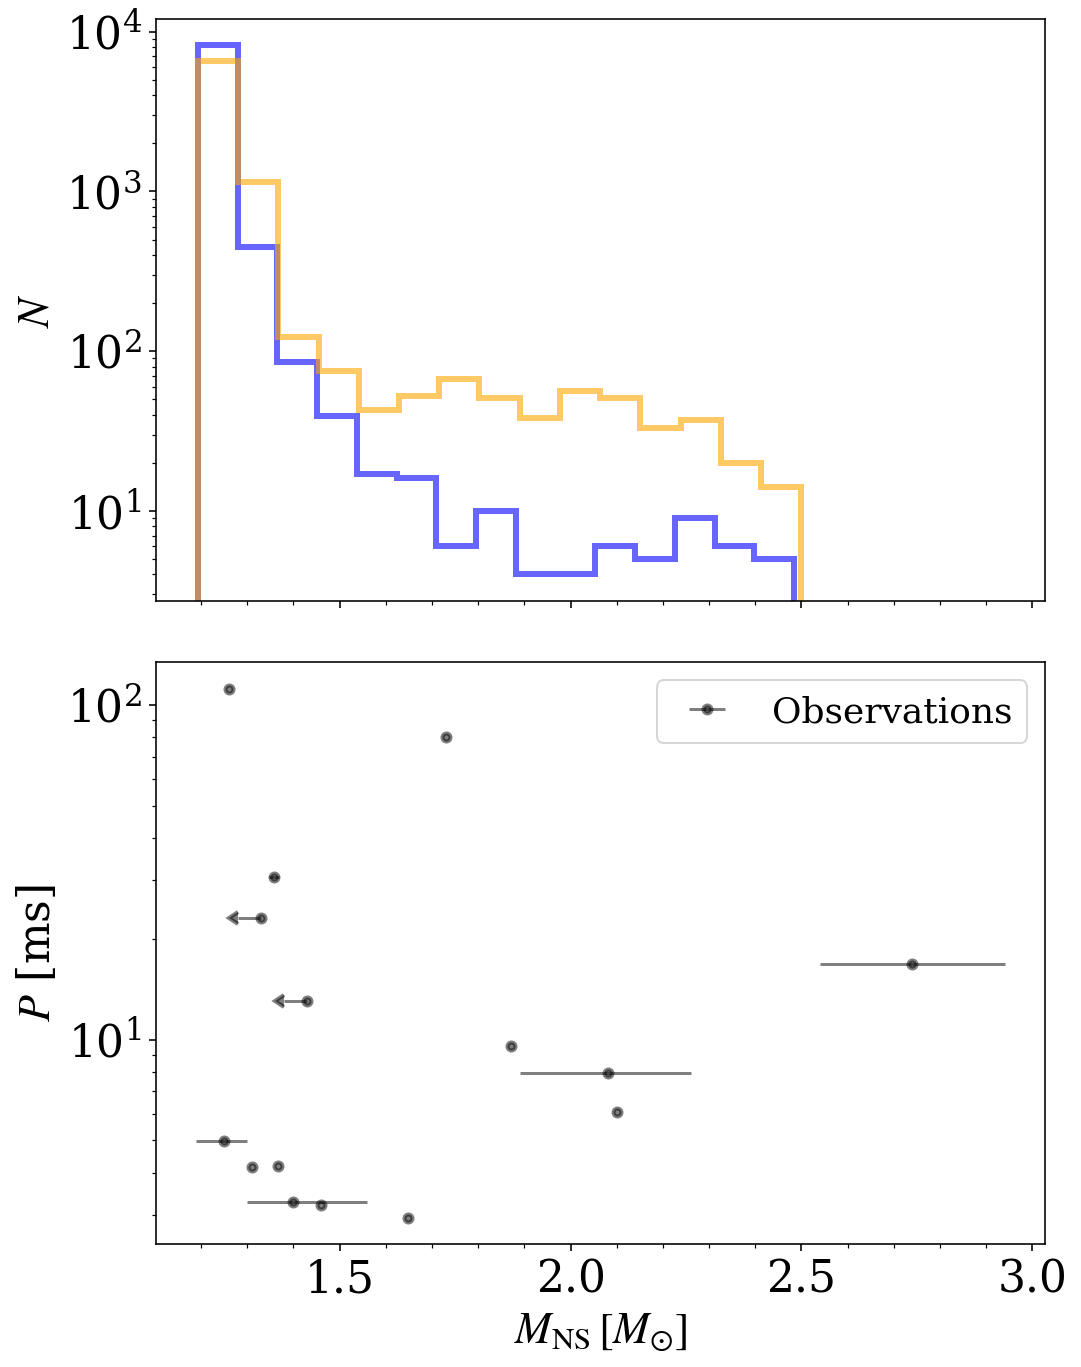

In [5]:
###Number of pulsars and their spin period and magnetic field distribution
###Separating single and binary MSPs
dpsr_mass = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/gc_psr_mass.xlsx',
                    names = ['psr_name','mp_med','mp_lsig','mp_usig','mc','mtot', 'pspin'])
mobs = np.array(dpsr_mass['mp_med'])
mobs_lsig = np.array(dpsr_mass['mp_lsig']); mobs_usig = np.array(dpsr_mass['mp_usig'])
print(mobs, mobs[mobs_lsig!=-100], mobs[mobs_lsig==-100])
Ps = np.array(dpsr_mass['pspin'])

N_allpsr = [[],[]]; N_msp = [[],[]]; N_ns = []
N_msp_lmcom = []
Ma_12Gyr = []; Mb_12Gyr = []

id_massive_12 = []; model_massive_12 = []; m_massive_12 = []

id_sin_nontde_nonwdwd = []; n_sin_nontde_nonwdwd = []
id_sin_nontde_nonwdwd_12Gyr = []
t_sin_nontde_nonwdwd_12Gyr = []

fig, axs = plt.subplots(nrows = 2, figsize=(8,10), sharex=True)
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    mall = []
    Bsin = []; Psin = []; msin = []
    Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
    thetime = [11000.,14000.]
    timestep_old=14000.
    npsr_sin = []; npsr_bin = []
    nmsp_sin = []; nmsp_bin = []
    nns = []
    nlbh = []
    nlmcomp = []
    
    n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
    
    id_massive = []; model_massive = []; m_massive = []
    
    id_sins = []; t_sins = []
    
    id_sin_nontde_nonwdwd.append([]); n_timestep = 0
    
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                n_timestep+=1
                
                if timestep_old<=12000. and timestep>12000.:
                    if xx<=ab_cut:
                        Ma_12Gyr = Ma_12Gyr + mall
                    else:
                        Mb_12Gyr = Mb_12Gyr + mall
                    
                    model_massive_12 = model_massive_12+model_massive
                    id_massive_12 = id_massive_12+id_massive
                    m_massive_12 = m_massive_12+m_massive
                    t_sin_nontde_nonwdwd_12Gyr.append(np.array(t_sins)[np.array(id_sins)!=0])
                    id_sin_nontde_nonwdwd_12Gyr.append(np.array(id_sins)[np.array(id_sins)!=0])
                    
                        
                Psin = np.array(Psin)
                Pbin = np.array(Pbin)
                mall = np.array(mall)
                mcomp = np.array(mcomp); kcomp = np.array(kcomp)
                npsr_sin.append(len(Psin)-n_wdwd[0]+n_nstde_msp[0])
                npsr_bin.append(len(Pbin)-n_wdwd[1]+n_nstde_msp[1])
                nmsp_sin.append(len(Psin[Psin<=0.03])+n_psrtde_msp[0]+n_nstde_msp[0])
                nmsp_bin.append(len(Pbin[Pbin<=0.03])+n_psrtde_msp[1]+n_nstde_msp[1])
                nlmcomp.append(len(mcomp[(mcomp<=0.01) & (kcomp>10)]))
                nns.append(len(mall))
                nlbh.append(len(mall[mall>2.5]))
                
                        
                mall = []
                Bsin = []; Psin = []; msin = []
                Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
                
                n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
                    
                id_massive = []; model_massive = []; m_massive = []
                
                if xx==6:
                    print(id_sins, t_sins)
                id_sins = []; t_sins = []
     
                
            if int(data[2])!=1:
                mall.append(float(data[5]))
                if float(data[5])>1.5:
                    model_massive.append(xx); id_massive.append(float(data[3]))
                    m_massive.append(float(data[5]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bsin.append(float(data[7]))
                    Psin.append(float(data[9]))
                    msin.append(float(data[5]))
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[0]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[0]+=1
                        
                    if float(data[9])<=0.03 and (int(data[3]) not in idtde_msp_all[xx] and 
                       int(data[3]) not in id_wdwdcol_all[xx] and int(data[3]) not in id_wdwdmer_all[xx]):
                        id_sin_nontde_nonwdwd[xx].append(int(data[3]))
                        id_sins.append(int(data[3])); t_sins.append(timestep)
                else:
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[0]+=1
                        
            else:
                if int(data[11])==13:
                    mall.append(float(data[5]))
                    
                    if float(data[5])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[3]))
                        m_massive.append(float(data[5]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bbin.append(float(data[7]))
                    Pbin.append(float(data[9]))
                    mbin.append(float(data[5]))
                    mcomp.append(float(data[6]))
                    kcomp.append(int(data[12]))
                    
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[11])==13 and float(data[7])<float(data[9])**2*(0.17*10**12):
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[6]))
                        kcomp.append(int(data[12]))
                
                if int(data[12])==13:
                    mall.append(float(data[6]))
                    
                    if float(data[6])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[4]))
                        m_massive.append(float(data[6]))
                        
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    Bbin.append(float(data[8]))
                    Pbin.append(float(data[10]))
                    mbin.append(float(data[6]))
                    mcomp.append(float(data[5]))
                    kcomp.append(int(data[11]))
                    
                    if float(data[10])>0.03 and int(data[4]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[10])>0.03 and (int(data[4]) in id_wdwdcol_all[xx] or 
                                               int(data[4]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[12])==13 and float(data[8])<float(data[10])**2*(0.17*10**12):
                    if int(data[4]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[5]))
                        kcomp.append(int(data[11]))
            
            timestep_old = timestep
    
    #print('allpsr:', model_label[xx], np.mean(npsr_sin), np.mean(npsr_bin))
    #print('msp:', model_label[xx], np.mean(nmsp_sin), np.mean(nmsp_bin))
    
    #print('Nns:', model_label[xx], np.mean(nns))
    #print('low-mass bh?', model_label[xx], np.mean(nlbh))
    #print('low-mass companion', model_label[xx], np.mean(nlmcomp))
        
    N_allpsr[0].append(np.mean(npsr_sin)); N_allpsr[1].append(np.mean(npsr_bin))
    N_msp[0].append(np.mean(nmsp_sin)); N_msp[1].append(np.mean(nmsp_bin))
    N_ns.append(np.mean(nns))
    N_msp_lmcom.append(np.mean(nlmcomp))
    
    n_sin_nontde_nonwdwd.append(len(np.array(id_sin_nontde_nonwdwd[xx])[np.array(id_sin_nontde_nonwdwd[xx])!=0])/
                                float(n_timestep+1))
    id_sin_nontde_nonwdwd[xx] = list(Counter(id_sin_nontde_nonwdwd[xx]).keys())
    
print('sin MSP ids', id_sin_nontde_nonwdwd)
#print('sin MSP 13 Gyr ids', id_sin_nontde_nonwdwd_13Gyr, t_sin_nontde_nonwdwd_13Gyr)
#np.savetxt('/projects/b1095/syr904/projects/isolated_MSP/massive_NS.dat', 
#           np.c_[model_massive_12,id_massive_12,m_massive_12],
#          fmt = '%d %d %f', header = '1.model 2.id 3.NS_mass[MSUN]', comments = '#', delimiter = '')

print(len(Ma_12Gyr), len(np.array(Ma_12Gyr)[np.array(Ma_12Gyr)>1.5])) 
print(len(Mb_12Gyr), len(np.array(Mb_12Gyr)[np.array(Mb_12Gyr)>1.5]))    
axs[0].hist(Ma_12Gyr, bins=15,
         histtype='step', alpha=0.6, color = 'b', lw=3)
axs[0].hist(Mb_12Gyr, bins=15,
         histtype='step', alpha=0.6, color = 'orange', lw=3)
axs[1].errorbar(mobs[mobs_lsig!=-100], 
             Ps[mobs_lsig!=-100], 
             xerr = [mobs_lsig[mobs_lsig!=-100], mobs_usig[mobs_lsig!=-100]], 
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             capsize=0, color = 'k', alpha=0.5, label = 'Observations')
axs[1].errorbar(mobs[mobs_lsig==-100], 
             Ps[mobs_lsig==-100], 
             xuplims = True, xerr=0.05,
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             color = 'k', alpha=0.5)
#axs[1].errorbar(mobs[mobs_lsig!=-100], 
#             np.full_like(mobs[mobs_lsig!=-100],5**(10*np.log10(mobs[mobs_lsig!=-100]))), 
#             xerr = [mobs_lsig[mobs_lsig!=-100], mobs_usig[mobs_lsig!=-100]], 
#             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
#             capsize=0, color = 'k', alpha=0.5, label = 'Observations')
#axs[1].errorbar(mobs[mobs_lsig==-100], 
#             np.full_like(mobs[mobs_lsig==-100], 5**(10*np.log10(mobs[mobs_lsig==-100]))), 
#             xuplims = True, xerr=0.05,
#             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
#             color = 'k', alpha=0.5)
                                                                 
#axs[0].hist(Psin, 
#            bins = np.logspace(np.log10(np.min(Psin)), np.log10(np.max(Psin)), 15),
#            histtype='step', alpha=0.6, color = cs[xx], lw=3,
#            label = model_label[xx])
#axs[0].hist(Pbin, 
#            bins = np.logspace(np.log10(np.min(Pbin)), np.log10(np.max(Pbin)), 10),
#            histtype='step', alpha=0.6, color = cs[xx], lw=3, ls = '--',
#            label = model_label[xx])
#
#axs[1].hist(Bsin, 
#            bins = np.logspace(np.log10(np.min(Bsin)), np.log10(np.max(Bsin)), 15),
#            histtype='step', alpha=0.6, color = cs[xx], lw=3,
#            label = model_label[xx])
#axs[1].hist(Bbin,
#            bins = np.logspace(np.log10(np.min(Bbin)), np.log10(np.max(Bbin)), 10),
#            histtype='step', alpha=0.6, color = cs[xx], lw=3, ls = '--',
#            label = model_label[xx])
    
#axs[0].set_xscale('log')
#axs[1].set_xscale('log')

axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].set_ylabel(r'$N$')
axs[0].set_yscale('log')
axs[1].set_ylabel(r'$P$ [ms]')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$M_{\rm{NS}}\,[M_{\odot}]$')
axs[1].legend(loc='upper right', fontsize=18)
fig.tight_layout()

#plt.savefig(savepath+'ns_mass_all_12Gyr.pdf', dpi=300)

data_sin_msp = [n_sin_nontde_nonwdwd, N_msp_lmcom, list(np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))]
pd.DataFrame(data_sin_msp)
#print('number of single MSPs', N_msp_lmcom, n_sin_nontde_nonwdwd, np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))

In [8]:
##Check when the single MSPs first become isolated
t_first_sin_nontde_nonwdwd = []
id_first_sin_nontde_nonwdwd = []
for xx in range(len(id_sin_nontde_nonwdwd)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    t_first_sins = []
    id_first_sins = []
    
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            #if float(data[1])*t_conv > 13000.:
            #    break
            
            timestep = float(data[1])*t_conv

            if int(data[2])!=1 and int(data[3]) in id_sin_nontde_nonwdwd[xx]:
                if float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9]) <=0.03:
                    if int(data[3]) not in id_first_sins:
                        t_first_sins.append(timestep)
                        id_first_sins.append(int(data[3]))
            
    t_first_sin_nontde_nonwdwd.append(list(np.array(t_first_sins)[np.array(id_first_sins)!=0]))
    id_first_sin_nontde_nonwdwd.append(list(np.array(id_first_sins)[np.array(id_first_sins)!=0]))
    print(xx, len(t_first_sins), len(id_sin_nontde_nonwdwd[xx]))
               
#print(t_first_sin_nontde_nonwdwd, id_first_sin_nontde_nonwdwd)

0 7 7
1 7 7
2 10 10
3 12 12
4 11 11
5 3 3
6 13 13
7 10 10
8 26 26
9 10 10
10 8 8
11 9 9
12 12 12
13 8 8
14 4 4
15 8 8
16 13 13
17 25 25


In [9]:
##Check how the single MSPs become isolated if not from TDEs or WD-WDs
for xx in range(len(paths)):
    interact = []
    #interact.append(xx)
    print(xx, paths[xx])
    binint_outs = scripts3.read_binint(paths[xx]+'initial.binint.log')
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    interact_bh = 0; interact_ns = 0; interact_wd = 0; interact_ms = 0; interact_other = 0
    
    if len(id_first_sin_nontde_nonwdwd[xx]) > 0:
        for yy in range(len(id_first_sin_nontde_nonwdwd[xx])):
            #print(id_sin_nontde_nonwdwd[xx][yy])
            #if id_first_sin_nontde_nonwdwd[xx][yy]==0: continue
            int_id = scripts3.binary_interaction(binint_outs,id_first_sin_nontde_nonwdwd[xx][yy])
            for ii in range(len(int_id)):
                check_sin = 0
                if int_id[ii]['interaction']['type']['time']*t_conv>t_first_sin_nontde_nonwdwd[xx][yy]:
                    break
                if int_id[ii]['interaction']['type']['time']*t_conv<=t_first_sin_nontde_nonwdwd[xx][yy]:
                    #print(int_id[ii])
                    outputs = int_id[ii]['interaction']['output']
                    inputs = int_id[ii]['interaction']['input']
                    for jj in range(len(inputs)):
                        #if len(outputs[jj]['ids'])==1 and outputs[jj]['ids'][0]==str(int(id_sin_nontde_nonwdwd_12Gyr[xx][yy])):
                        if len(inputs[jj]['ids'])==1 and inputs[jj]['ids'][0]==id_first_sin_nontde_nonwdwd[xx][yy]:
                            #print('no', id_sin_nontde_nonwdwd_12Gyr[xx][yy])
                            check_sin = 1
                            break
                    if check_sin==1: continue
                        
                    if len(outputs)>1:
                        interact_first_sins=[str(id_first_sin_nontde_nonwdwd[xx][yy])+','
                                    +str(int_id[ii]['interaction']['type']['time']*t_conv)
                                    +', input'
                                    +str(inputs[0]['ids'])+','+str(inputs[0]['startype'])+','
                                    +str(inputs[1]['ids'])+','+str(inputs[1]['startype'])
                                    +', output'
                                    +str(outputs[0]['ids'])+','+str(outputs[0]['startype'])+','
                                    +str(outputs[1]['ids'])+','+str(outputs[1]['startype'])]
                    else:
                        interact_first_sins=[str(id_first_sin_nontde_nonwdwd[xx][yy])+','
                                    +str(int_id[ii]['interaction']['type']['time']*t_conv)
                                    +', input'
                                    +str(inputs[0]['ids'])+','+str(inputs[0]['startype'])+','
                                    +str(inputs[1]['ids'])+','+str(inputs[1]['startype'])
                                    +', output'
                                    +str(outputs[0]['ids'])+','+str(outputs[0]['startype'])]
                        
            for kk in range(len(inputs)):
                if id_first_sin_nontde_nonwdwd[xx][yy] not in inputs[kk]['ids']:
                    if 14 in inputs[kk]['startype']: interact_bh+=1
                    elif 13 in inputs[kk]['startype']: interact_ns+=1
                    elif 12 in inputs[kk]['startype'] or 11 in inputs[kk]['startype'] or 10 in inputs[kk]['startype']:
                        interact_wd+=1
                    elif 0 in inputs[kk]['startype'] or 1 in inputs[kk]['startype']:
                        interact_ms+=1
                    else:
                        interact_other+=1
                        
            interact.append(interact_first_sins)
            
         
    print(t_first_sin_nontde_nonwdwd[xx])
    print(id_first_sin_nontde_nonwdwd[xx])
    print(interact)
    print(xx, len(t_first_sin_nontde_nonwdwd[xx]), len(id_first_sin_nontde_nonwdwd[xx]),
         'bh', interact_bh, 'ns', interact_ns, 'wd', interact_wd, 'ms', interact_ms, 'other', interact_other)   
                    
#print(id_sin_nontde_nonwdwd_12Gyr)
#print(interact)

0 /projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/
[165.9646766476, 6291.69291966, 7700.75175384, 8488.076109560001, 10141.03527912, 10960.21613188, 11186.87531752]
[26633, 674017, 104900, 1139334, 331891, 855698, 557296]
[["26633,165.55423491056, input[533771],[14],[26633, 801282],[13, 13], output['533771'],['14'],['26633'],['13']"], ["674017,6282.120833886801, input[712733, 1486094],[0, 14],[674017, 725034],[13, 11], output['712733'],['0'],['725034', '1486094'],['11', '14']"], ["104900,7677.09490022, input[104900, 788089],[13, 11],[544291, 815931],[11, 0], output['104900'],['13'],['788089'],['11']"], ["1139334,8485.344897112, input[278789, 1139334],[11, 13],[570456, 971270],[2, 14], output['278789'],['11'],['570456', '971270', '1139334'],['2', '14', 'ktyp13']"], ["331891,10128.562616304, input[728785],[1],[331891, 1085042],[13, 11], output['728785'],['1'],['331891', '1085042'],['1

In [6]:
###Number of BHs and mass of cluster
N_bh = []; Mclu = []
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    m_conv = dyn.conv('m', paths[xx]+'initial.conv.sh')
    bhfile = paths[xx]+'initial.bh.dat'
    dynfile = paths[xx]+'initial.dyn.dat'
    
    thetime = [11000., 14000.]
    nbh = []; mass = []
    with open(bhfile, 'r') as fbh:
        next(fbh)
        for line in fbh:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            nbh.append(int(data[2]))
            #print(float(data[1])*t_conv)
                
    print(model_label[xx])
    print('bh', np.mean(nbh))
    N_bh.append(np.mean(nbh))
                
    with open(dynfile, 'r') as fdyn:
        next(fdyn); next(fdyn)
        for line in fdyn:
            data = line.split()
            if float(data[0])*t_conv > thetime[1]:
                break
            if float(data[0])*t_conv < thetime[0]:
                continue
            mass.append(float(data[4])*m_conv)
            
    print('mass', np.mean(mass))
    Mclu.append(np.mean(mass))
                

1a
bh 4.717327066067428
mass 196781.88660030245
2a
bh 1.6617011128775834
mass 202973.99628107538
3a
bh 5.577946591577189
mass 207168.0704692947
4a
bh 3.5492392729733924
mass 190444.48656471664
5a
bh 3.8976379821958456
mass 199409.5346079957
6a
bh 2.9600866113316493
mass 201365.90470529938
7a
bh 3.1246641924313243
mass 202780.07954566288
8a
bh 3.967188847136141
mass 204973.6695802965
9a
bh 2.144282514471885
mass 195943.12648656341
1b
bh 7.328803317535545
mass 199124.30068226255
2b
bh 8.822066971197522
mass 201729.6644263321
3b
bh 10.327043474802116
mass 198552.5022323358
4b
bh 3.789353894746621
mass 199372.3576589078
5b
bh 8.98509248847118
mass 195439.63592068595
6bv1
bh 11.656584582441113
mass 197206.96670814048
7b
bh 8.93151351970669
mass 205872.68112304885
8b
bh 6.895562580494087
mass 203901.0733493246
9b
bh 14.593233508341566
mass 201056.21180583898


In [9]:
###### Save the arrays into a file
np.savetxt(savepath+'table.dat', np.c_[Mclu, N_bh, N_ns, N_wdwdcoll_tot, N_wdwdmer_tot, N_tde, 
                                       N_allpsr[0], N_allpsr[1], N_msp[0], N_msp[1], 
                                       N_ns_wdwdcoll[0], N_ns_wdwdcoll[1],
                                       N_ns_wdwdmer[0],N_ns_wdwdmer[1], N_msp_lmcom],
          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f',
          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Nwdmertot 6.Ntde 7.Nallpsr_sin 8.Nallpsr_bin 9.Nmsp_sin 10.Nmsp_bin 11.Nnscoll_sin 12.Nnscoll_bin 13.Nnsmer_sin 14.Nnsmer_bin 15.Nmsp_lmcom',
          delimiter = ' ')
#data_table = np.genfromtxt(savepath+'table.dat')
#np.savetxt(savepath+'table.dat', np.c_[data_table[:,0],data_table[:,1],data_table[:,2],data_table[:,3],
#              data_table[:,4],data_table[:,5],data_table[:,6],data_table[:,7],data_table[:,8],
#              data_table[:,9],data_table[:,10],N_ns_wdwdmer[0],N_ns_wdwdmer[1]],
#          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f',
#          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Ntde 6.Nallpsr_sin 7.Nallpsr_bin 8.Nmsp_sin 9.Nmsp_bin 10.Nnscoll_sin 11.Nnscoll_bin 12.Nnsmer_sin 13.Nnsmer_bin',
#          delimiter = ' ')

data_table = np.genfromtxt(savepath+'table.dat')
f=open(savepath+'latex_table.txt', 'w+')
for ii in range(len(paths)):
    f.write('%s & %.2f & %d & %d & %d & %d & %d & %d & %d & %d & %d & %d & %d & %d & %d & %d & %.1f & %s & %s & %s & %s\\\\\n'
            %(model_label[ii], 
              data_table[:,0][ii]/1.e5,np.round(data_table[:,1][ii]),
              np.round(data_table[:,2][ii]),np.round(data_table[:,3][ii]),
              np.round(data_table[:,4][ii]),np.round(data_table[:,5][ii]),
              np.round(data_table[:,6][ii]),np.round(data_table[:,7][ii]),
              np.round(data_table[:,8][ii]),np.round(data_table[:,9][ii]),
              np.round(data_table[:,10][ii]),np.round(data_table[:,11][ii]),
              np.round(data_table[:,12][ii]),np.round(data_table[:,13][ii]),
              np.round(data_table[:,14][ii]),
              (data_table[:,8][ii]+data_table[:,10][ii]+data_table[:,12][ii]+data_table[:,14][ii])/(data_table[:,9][ii]+data_table[:,11][ii]+data_table[:,13][ii]-data_table[:,14][ii]),
              '-', '-','-', '-'))
    print(data_table[:,7][ii], np.round(data_table[:,7][ii]))

f.close()

9.652778 10.0
9.2 9.0
9.601562 10.0
33.475177 33.0
31.02381 31.0
10.939759 11.0
9.90625 10.0
11.581967 12.0
9.063415 9.0
13.714286 14.0
10.576923 11.0
21.467066 21.0
24.616279 25.0
31.150259 31.0
9.532051 10.0
10.557971 11.0
11.810458 12.0
18.755556 19.0


In [13]:
##Rc/Rh, Number of BHs and Cluster density as a function of time to check core-collapse
#theno = 17

def t_bs(Nns, n, v_disp, sma_ave, m1, m2):
    sigma_cross = np.pi*sma_ave**2*(1+2*Gconst_sun*(m1+m2)*PC/AU/sma_ave/v_disp**2)
    return 1/(Nns*n/PC**3*sigma_cross*AU**2*v_disp*10**5)/yearsc/10**6

#fig, axs = plt.subplots(nrows=2, figsize=(10, 12), sharex=True, sharey=False)
for xx in range(len(paths)): 
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    
    #bhfile = np.genfromtxt(paths[theno]+'initial.bh.dat')
    #tbh = bhfile[:,1]*t_conv; Nbh = bhfile[:,2]
    
    dynfile = np.genfromtxt(paths[xx]+'initial.dyn.dat')
    tdyn = dynfile[:,0]*t_conv; Rc = dynfile[:,7]*l_conv; Rh = dynfile[:,20]*l_conv
    Nc = dynfile[:,6]; rho_c = Nc/(2*twopi/3.)/Rc**3
    
    print(t_bs(200, np.mean(rho_c[(tdyn>=11000) & (tdyn<=14000)])*0.05, 10., 5., 1.4, 1.))

#axs[1].plot(tdyn, Rc/Rh)
#axs[1].set_xscale('log')
#axs[1].set_xlim(xmin=0.5, xmax=16000.)
#
#
#axs[0].plot(tbh, Nbh)
#axs[0].set_xscale('log')
#axs[0].set_xlim(xmin=0.5, xmax=16000.)
#axs[0].set_yscale('log')
#
#axs[0].set_ylabel(r'$N_{\rm{BH}}$')
#axs[1].set_ylabel(r'$R_c/R_h$')
#axs[1].set_xlabel(r'$T\,[\rm{Myr}]$') 
#    
#fig.tight_layout()
#plt.subplots_adjust(hspace=0.04, wspace=0.16)

0.21019961777751436


KeyboardInterrupt: 

In [13]:
##Check escaped MSPs formed in TDEs and WD-WD merger
esc_frac = []; esc_bin_frac = []
for xx in range(len(paths)):
    mns_esc = []; mcomp_esc = []; sma_esc = []; ecc_esc = []
    kcomp_esc = []
    with open(paths[xx]+'initial.esc.dat', 'r') as fesc:
        next(fesc)
        for line in fesc:
            dataesc = line.split()
            if int(dataesc[14])!=1:
                if int(dataesc[21])==13 and (int(dataesc[13]) in idtde_msp_all[xx]
                                             or int(dataesc[13]) in id_wdwdcol_all[xx] 
                                             or int(dataesc[13]) in id_wdwdmer_all[xx]):
                    mns_esc.append(float(dataesc[2])); mcomp_esc.append(-100)
                    sma_esc.append(-100); ecc_esc.append(-100)
                    kcomp_esc.append(-100)
            else:
                if int(dataesc[22])==13 and (int(dataesc[17]) in idtde_msp_all[xx]
                                             or int(dataesc[17]) in id_wdwdcol_all[xx] 
                                             or int(dataesc[17]) in id_wdwdmer_all[xx]):
                    mns_esc.append(float(dataesc[15])); mcomp_esc.append(float(dataesc[16]))
                    sma_esc.append(float(dataesc[19])); ecc_esc.append(float(dataesc[20]))
                    kcomp_esc.append(int(dataesc[23]))
                    
                if int(dataesc[23])==13 and (int(dataesc[18]) in idtde_msp_all[xx] 
                                             or int(dataesc[18]) in id_wdwdcol_all[xx] 
                                             or int(dataesc[18]) in id_wdwdmer_all[xx]):
                    mns_esc.append(float(dataesc[16])); mcomp_esc.append(float(dataesc[15]))
                    sma_esc.append(float(dataesc[19])); ecc_esc.append(float(dataesc[20]))
                    kcomp_esc.append(int(dataesc[22]))

    
    mns_esc=np.array(mns_esc); mcomp_esc = np.array(mcomp_esc)
    sma_esc = np.array(sma_esc); ecc_esc = np.array(ecc_esc)
    kcomp_esc = np.array(kcomp_esc)
                  
    print(xx)
    print(len(mns_esc), len(mns_esc[mcomp_esc!=-100]))
    ntot_msp = len(idtde_msp_all[xx])+len(id_wdwdcol_all[xx])+len(id_wdwdmer_all[xx])
    print(len(mns_esc)/ntot_msp,
         len(mns_esc[mcomp_esc!=-100])/ntot_msp)
    esc_frac.append(len(mns_esc)/ntot_msp)
    esc_bin_frac.append(len(mns_esc[mcomp_esc!=-100])/len(mns_esc))
    #print(mcomp_esc[mcomp_esc!=-100], sma_esc[mcomp_esc!=-100],
    #      ecc_esc[mcomp_esc!=-100], kcomp_esc[mcomp_esc!=-100])   
    
print(np.mean(esc_frac[:8]), np.mean(esc_bin_frac[:8]))
print(np.mean(esc_frac[9:]), np.mean(esc_bin_frac[9:]))
print(np.mean(esc_frac), np.mean(esc_bin_frac))

0
37 11
0.33636363636363636 0.1
1
24 9
0.24 0.09
2
57 26
0.24782608695652175 0.11304347826086956
3
104 39
0.27440633245382584 0.10290237467018469
4
130 50
0.30162412993039445 0.11600928074245939
5
82 43
0.2671009771986971 0.14006514657980457
6
33 11
0.3142857142857143 0.10476190476190476
7
44 17
0.26666666666666666 0.10303030303030303
8
23 6
0.24731182795698925 0.06451612903225806
9
150 45
0.5454545454545454 0.16363636363636364
10
137 29
0.5189393939393939 0.10984848484848485
11
156 39
0.4273972602739726 0.10684931506849316
12
237 71
0.4232142857142857 0.12678571428571428
13
241 76
0.4191304347826087 0.13217391304347825
14
208 71
0.41851106639839036 0.14285714285714285
15
99 20
0.4782608695652174 0.0966183574879227
16
148 37
0.49333333333333335 0.12333333333333334
17
158 42
0.40616966580976865 0.10796915167095116
0.28103419298193205 0.3915175307986605
0.45893453947461293 0.2706443032178263
0.3681109015046646 0.3238226966981729


11.9499418746
11.955785988999999
12.032105669119998
11.90064211324
11.96273414164
12.0382750564
12.10142793328
11.97997090492
11.93945418616
12.00868534692
11.90188719304
12.12184994136
12.055076547879999
12.01239696692
11.951894861560001
12.01370480684
12.1533521474
11.9818078194
[[2.9579363550252014, 2.6005997997388084, 2.533147081988405, 2.435297220588165, 4.745179546410454, 2.5530398180511655, 2.6363980788085755, 2.521564275215555, 2.435217421000485, 2.963568385255809, 4.776290238912669, 3.9411421921719705, 3.329471056747482, 3.3660469079469366, 3.5548097533870893, 10.95391948967477, 3.778042396475577, 3.9475547746024597, 3.829853771068135, 2.7489656573796957, 3.288771713351367, 2.6025303590126927, 2.5509592443496065, 3.4185023211637726, 2.536618287513175, 2.435217421000485, 4.802045681140486, 2.5509780730264824, 2.5446646973289777], [3.0881713444441417, 2.6793106704584146, 2.7480075609208274, 2.7564392314369033, 3.373787480506842, 3.2922879150270568, 2.706066690215961, 6.559350053

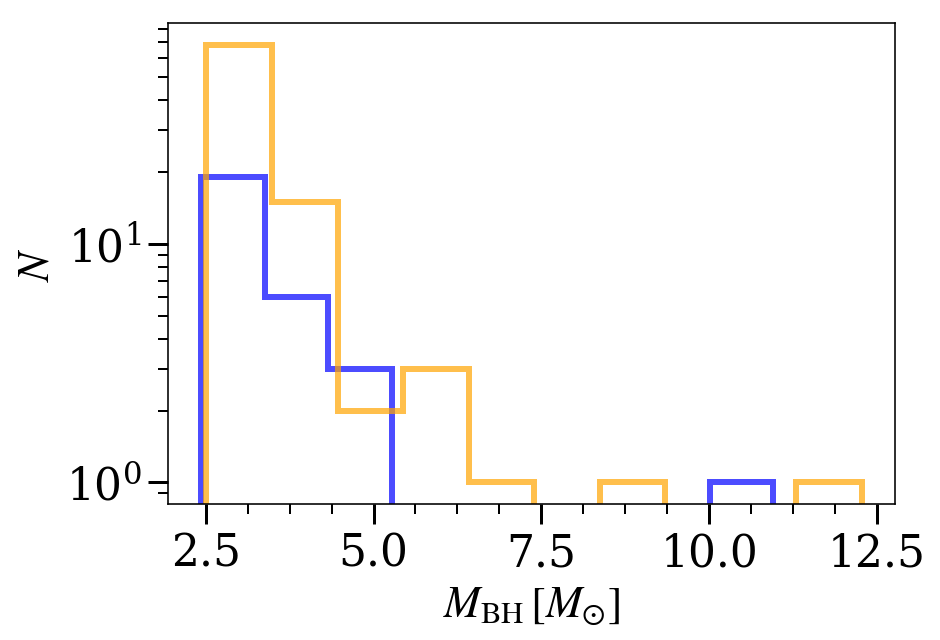

In [7]:
##Black hole mass at late times
def read_keys(thekey):
        return re.findall(r'\d+\.\d+|\d+', thekey)

M_bh = [[],[]]
for xx in range(len(paths)):
    with pd.HDFStore(paths[xx]+'initial.blackhole.snapshots.h5') as bh_hdf:
        snap_keys = bh_hdf.keys()
    #print(snap_keys)
    
    snaptime = []
    for ii in range(len(snap_keys)):
        thetime = read_keys(snap_keys[ii])[0]
        snaptime.append(thetime)
        
    snapt_float, snaptime_sort = (np.array(t) for t in zip(*sorted(zip(np.array(snaptime).astype(np.float), snaptime))))
    #print(snaptime_sort)
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    for yy in range(len(snaptime_sort)):
        if float(snaptime_sort[yy])*t_conv>=11900.:
            bh_h5 = cmct.Snapshot(fname=paths[xx]+'initial.blackhole.snapshots.h5', 
                                    snapshot_name='/t='+snaptime_sort[yy], 
                                    conv=paths[xx]+'initial.conv.sh', 
                                    dist=4.125, # distance to cluster in kpc
                                    z=0.0002)
            print(bh_h5.age)
            binflag = np.array(bh_h5.data['binflag'])
            m = np.array(bh_h5.data['m_MSUN'])[binflag!=1]
            k0 = np.array(bh_h5.data['bin_startype0'])[binflag==1]; k1 = np.array(bh_h5.data['bin_startype1'])[binflag==1]
            m0 = np.array(bh_h5.data['m0_MSUN'])[binflag==1]; m1 = np.array(bh_h5.data['m1_MSUN'])[binflag==1]
            if xx<=ab_cut:
                M_bh[0] = M_bh[0]+list(m)
                for zz in range(len(k0)):
                    if k0[zz]==14:
                        M_bh[0].append(m0[zz])
                    if k1[zz]==14:
                        M_bh[0].append(m1[zz])
            else:
                M_bh[1] = M_bh[1]+list(m)
                for zz in range(len(k0)):
                    if k0[zz]==14:
                        M_bh[1].append(m0[zz])
                    if k1[zz]==14:
                        M_bh[1].append(m1[zz])
            
            break
print(M_bh)
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(M_bh[0], bins=9, color = 'b', alpha=0.7, histtype='step', lw=3)
ax.hist(M_bh[1], bins=10, color = 'orange', alpha=0.7, histtype='step', lw=3)
ax.set_yscale('log')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('both', length=10, width=1.5, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
ax.set_xlabel(r'$M_{\rm{BH}}\,[M_{\odot}]$')
ax.set_ylabel(r'$N$')
fig.tight_layout()

plt.savefig(savepath+'Mbh_all_12Gyr.pdf', dpi=300)

1a mer 0.0 0.0 1.0 2
1a col 0.5795454545454546 0.11363636363636363 0.3068181818181818 88
2a mer 0.25 0.25 0.5 4
2a col 0.5866666666666667 0.05333333333333334 0.36 75
3a mer 0.0 0.25 0.75 4
3a col 0.6493506493506493 0.05194805194805195 0.2987012987012987 77
4a mer 0.0 0.0 1.0 3
4a col 0.6956521739130435 0.043478260869565216 0.2608695652173913 92
5a mer 0.5 0.0 0.5 2
5a col 0.6121212121212121 0.048484848484848485 0.3393939393939394 165
6a mer 0.0 0.3333333333333333 0.6666666666666666 3
6a col 0.4927536231884058 0.10144927536231885 0.4057971014492754 138
7a mer 0.0 0.16666666666666666 0.8333333333333334 6
7a col 0.5714285714285714 0.05194805194805195 0.37662337662337664 77
8a mer 0.0 0.0 1.0 2
8a col 0.5323741007194245 0.06474820143884892 0.4028776978417266 139
9a mer 0.0 1.0 0.0 3
9a col 0.5428571428571428 0.014285714285714285 0.44285714285714284 70
1b mer 0.6363636363636364 0.07142857142857142 0.2922077922077922 154
1b col 0.7142857142857143 0.02857142857142857 0.2571428571428571 70
2b 

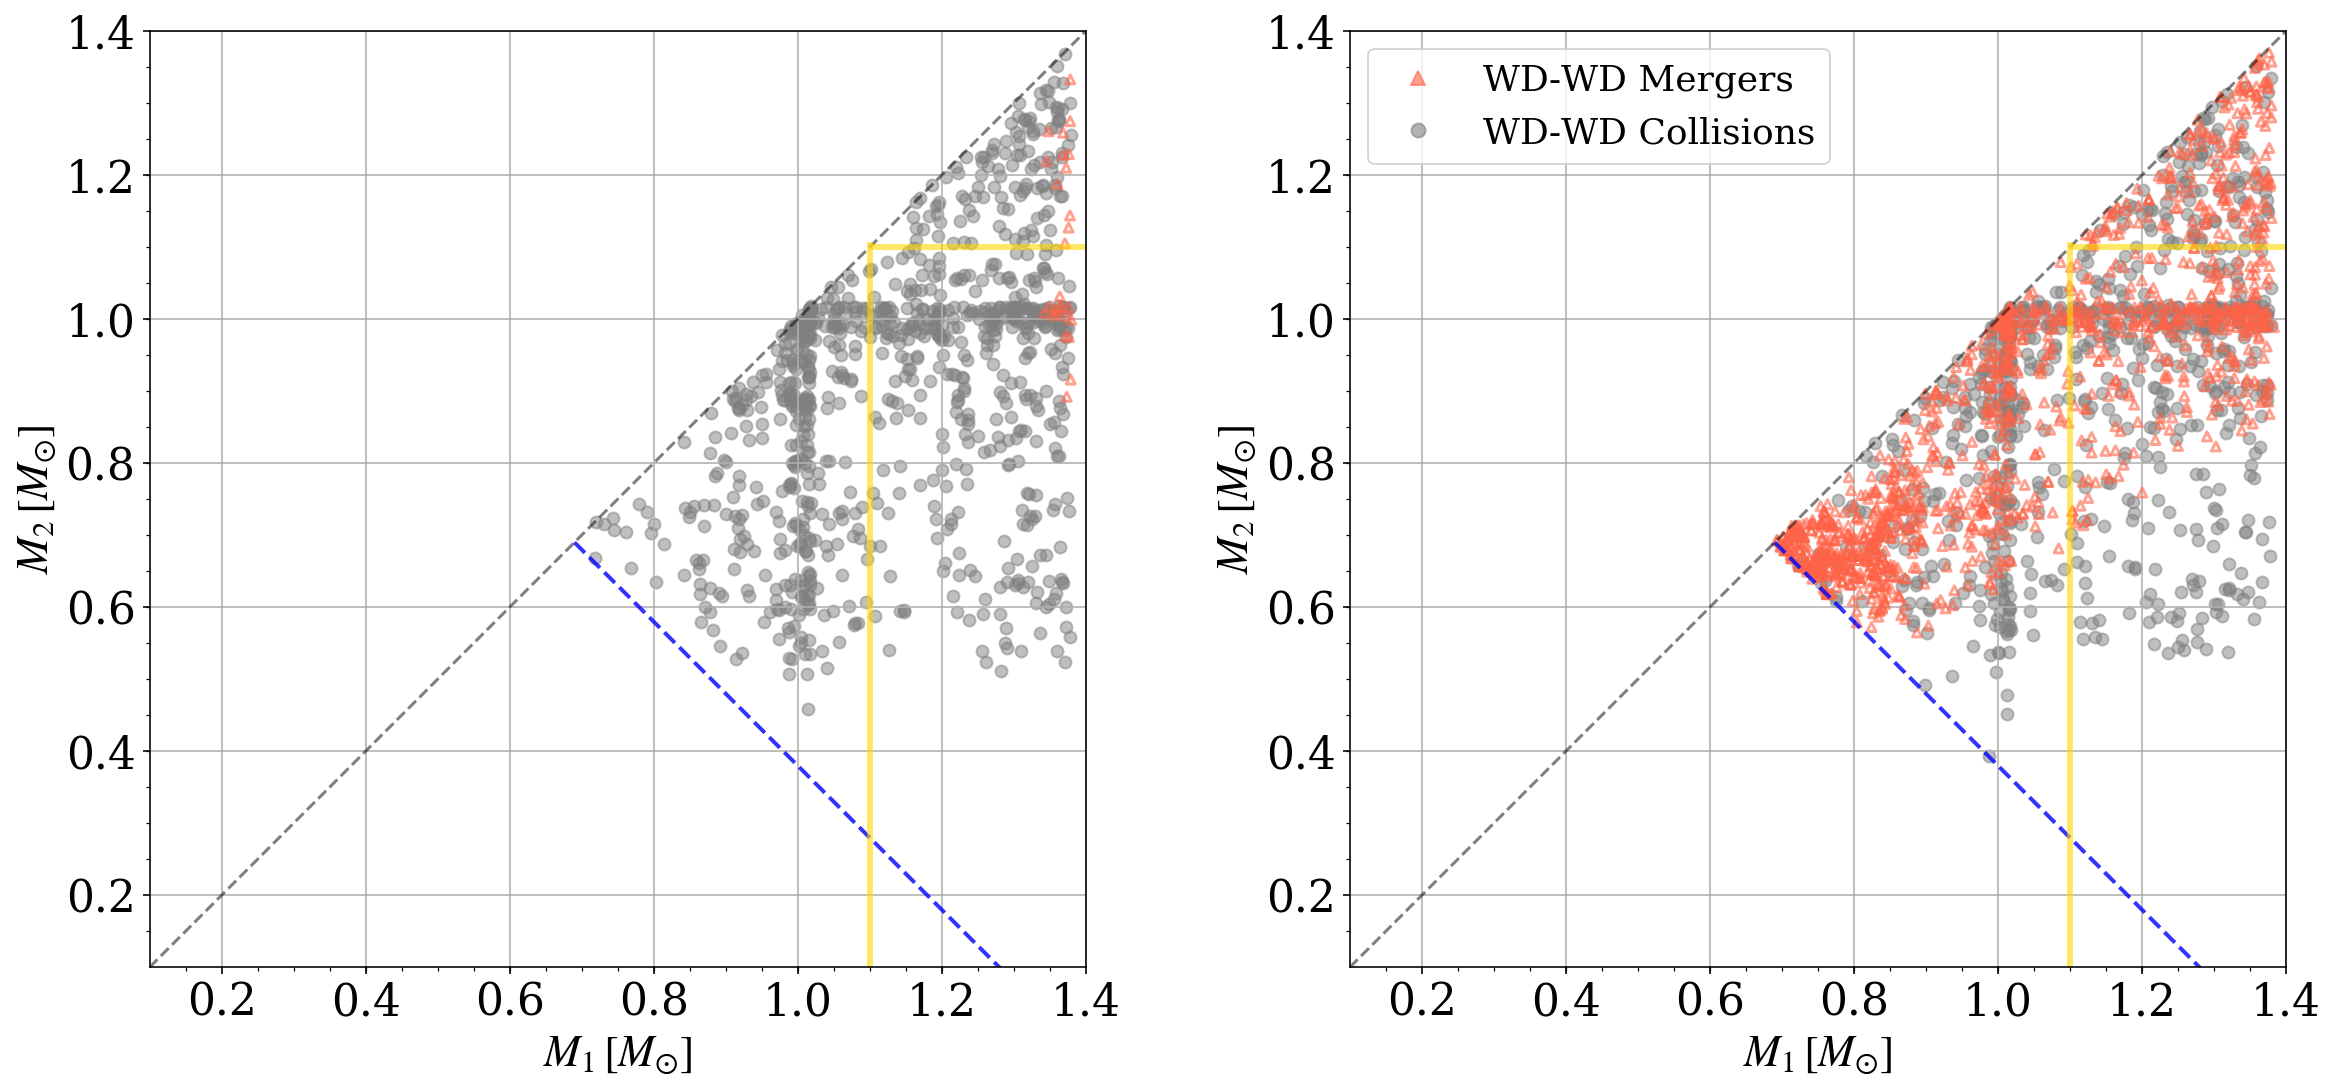

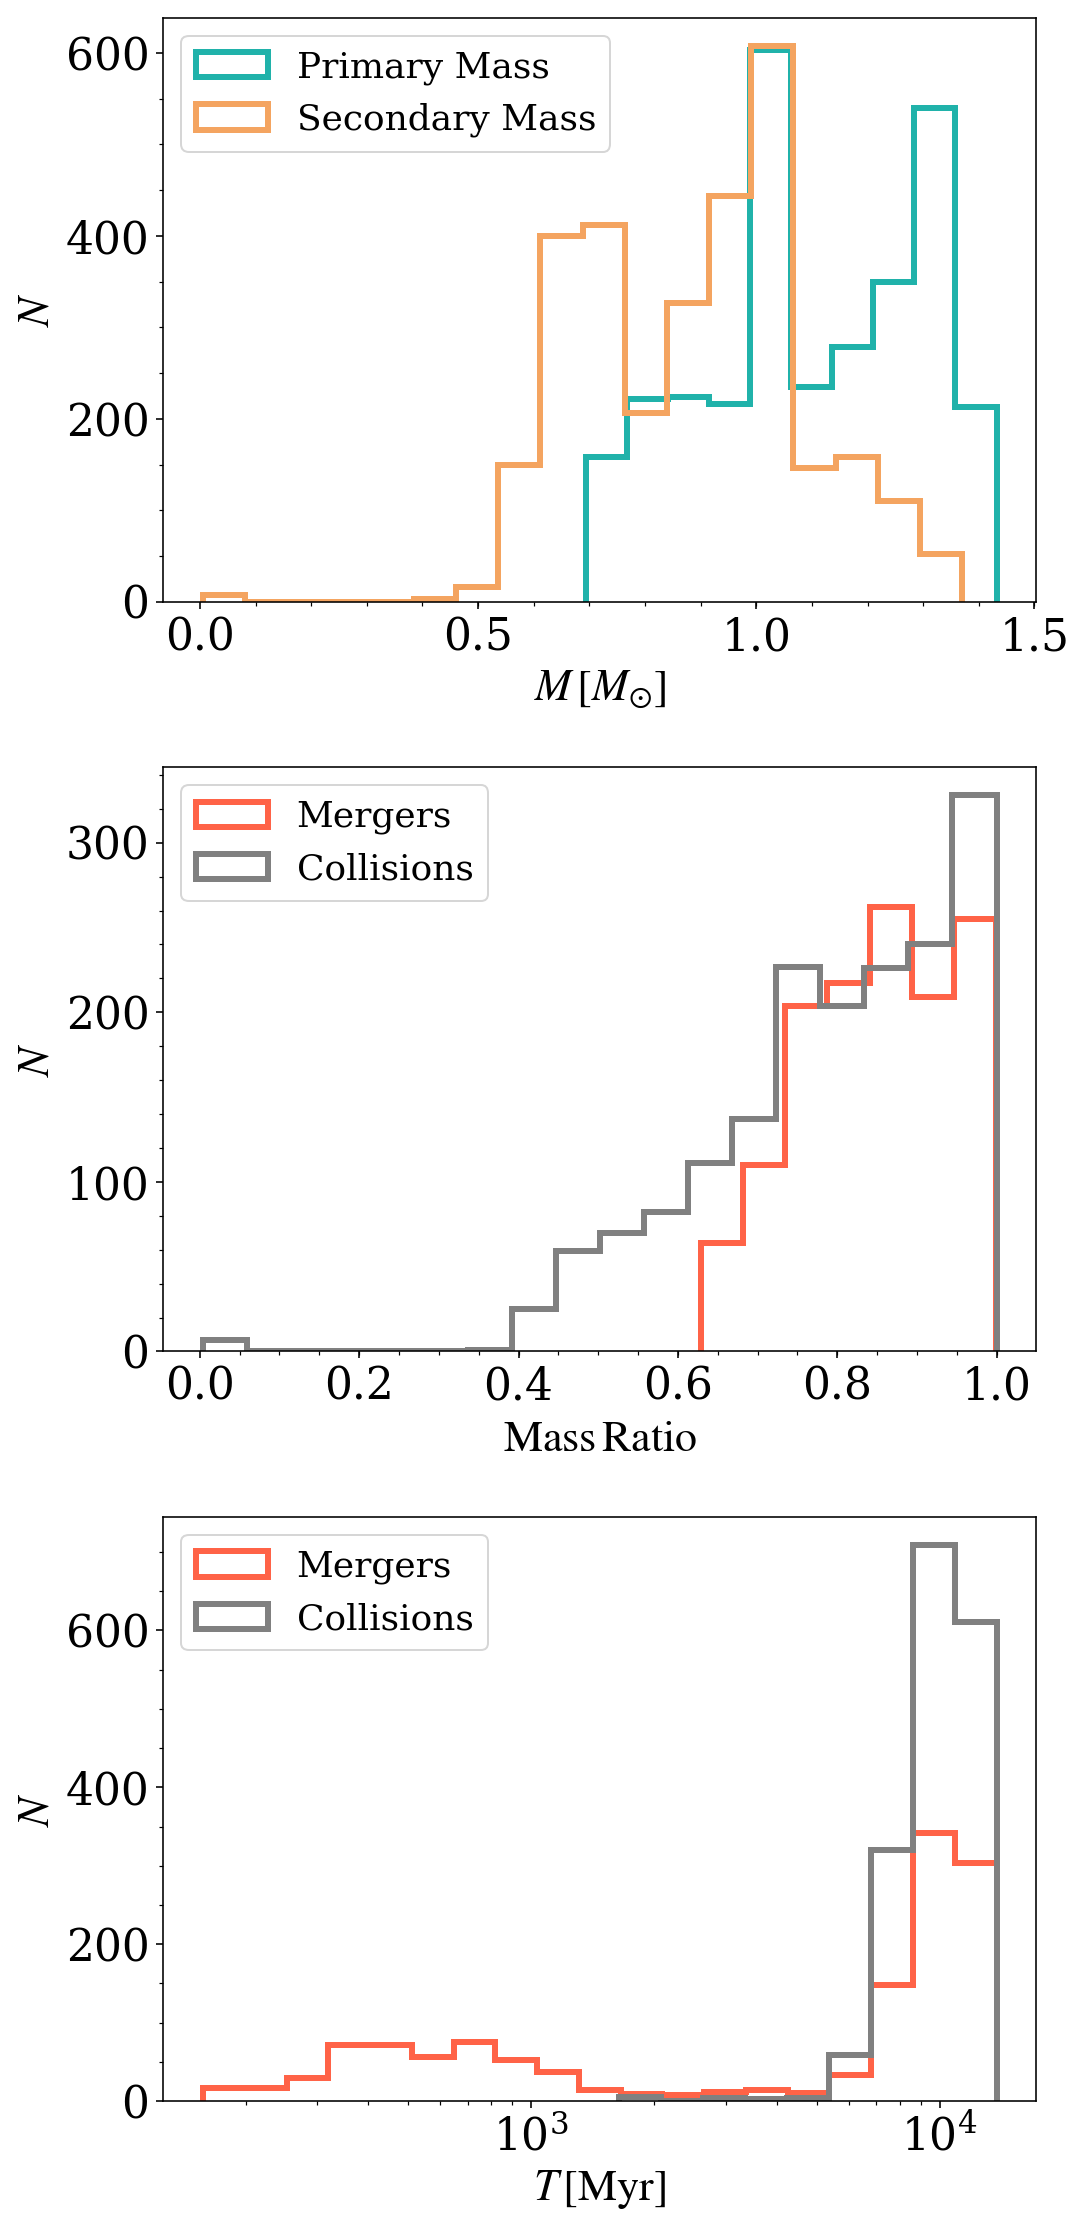

In [7]:
##WD mass plot for the WDs in collisions or mergers

rdot=mlines.Line2D([], [],  linestyle = 'None', color='tomato', marker='^',
                  markersize=7, alpha=0.6, label='WD-WD Mergers')
gdot=mlines.Line2D([], [],  linestyle = 'None', color='gray', marker='o',
                  markersize=7, alpha=0.6, label='WD-WD Collisions')

m_mer_pri_all = []; m_mer_sec_all = []
m_col_pri_all = []; m_col_sec_all = []
t_mer_all = []; t_col_all = []
k0_mer_all = []; k1_mer_all = []
k0_col_all = []; k1_col_all = []
fig, axs = plt.subplots(ncols=2, figsize=(17,8))
for xx in range(len(paths)):
    data_wdmer = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    m0_mer = data_wdmer[:,5]; m1_mer = data_wdmer[:,6]; t_mer = data_wdmer[:,1]  ##in Myr
    k0_mer = data_wdmer[:,8]; k1_mer = data_wdmer[:,9]
    m_mer_pri = np.maximum(m0_mer, m1_mer)
    m_mer_sec = np.minimum(m0_mer, m1_mer)
    print(model_label[xx], 'mer', len(t_mer[(k0_mer==11) & (k1_mer==11)])/len(k0_mer), 
          len(t_mer[(k0_mer==12) & (k1_mer==12)])/len(k0_mer), 
          (len(t_mer[(k0_mer==12) | (k1_mer==12)])-len(t_mer[(k0_mer==12) & (k1_mer==12)]))/len(k0_mer), 
          len(k0_mer))
    
    data_wdcol = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    m0_col = data_wdcol[:,5]; m1_col = data_wdcol[:,6]; t_col = data_wdcol[:,1]  ##in Myr
    k0_col = data_wdcol[:,10]; k1_col = data_wdcol[:,11]
    m_col_pri = np.maximum(m0_col, m1_col)
    m_col_sec = np.minimum(m0_col, m1_col)
    print(model_label[xx], 'col', len(t_col[(k0_col==11) & (k1_col==11)])/len(k0_col), 
          len(t_col[(k0_col==12) & (k1_col==12)])/len(k0_col), 
          (len(t_col[(k0_col==12) | (k1_col==12)])-len(t_col[(k0_col==12) & (k1_col==12)]))/len(k0_col), 
          len(k0_col))

    m_mer_pri_all = m_mer_pri_all + list(m_mer_pri)
    m_mer_sec_all = m_mer_sec_all + list(m_mer_sec)
    m_col_pri_all = m_col_pri_all + list(m_col_pri)
    m_col_sec_all = m_col_sec_all + list(m_col_sec)
    t_mer_all = t_mer_all + list(t_mer)
    t_col_all = t_col_all + list(t_col)
    k0_mer_all = k0_mer_all + list(k0_mer)
    k1_mer_all = k1_mer_all + list(k1_mer)
    k0_col_all = k0_col_all + list(k0_col)
    k1_col_all = k1_col_all + list(k1_col)
    
    if xx <= ab_cut:
        axs[0].scatter(m_mer_pri, m_mer_sec, color = 'tomato', marker = '^', facecolor = 'none', 
                       lw = 1.5, zorder=2, alpha=0.6, s=20)
        axs[0].scatter(m_col_pri, m_col_sec, color = 'gray', alpha = 0.5)
    else:
        axs[1].scatter(m_mer_pri, m_mer_sec, color = 'tomato', marker = '^', facecolor = 'none', 
                       lw = 1.5, zorder=2, alpha=0.6, s=20)
        axs[1].scatter(m_col_pri, m_col_sec, color = 'gray', alpha = 0.5)
        
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, color = 'k', ls='--', alpha=0.5)
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, color = 'k', ls='--', alpha=0.5)
xc = np.linspace(0.69,1.4,50)
axs[0].plot(xc, 1.38-xc, linestyle='--', lw=2, alpha=0.8, color='b')
axs[1].plot(xc, 1.38-xc, linestyle='--', lw=2, alpha=0.8, color='b')
axs[0].axvline(x=1.1, ymax = 1.08/1.4, lw=3, alpha=0.6, color='gold')
axs[0].axhline(y=1.1, xmin = 1.08/1.4, lw=3, alpha=0.6, color='gold')
axs[1].axvline(x=1.1, ymax = 1.08/1.4, lw=3, alpha=0.6, color='gold')
axs[1].axhline(y=1.1, xmin = 1.08/1.4, lw=3, alpha=0.6, color='gold')

axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].set_xlim(xmin=0.1, xmax=1.4)
axs[0].set_ylim(ymin = 0.1, ymax=1.4)
axs[0].set_aspect(1./axs[0].get_data_ratio(), adjustable='box')
axs[0].grid(True)
axs[0].set_xlabel(r'$M_1\,[M_{\odot}]$')
axs[0].set_ylabel(r'$M_2\,[M_{\odot}]$')

axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].set_xlim(xmin=0.1, xmax=1.4)
axs[1].set_ylim(ymin = 0.1, ymax=1.4)
axs[1].set_aspect(1./axs[1].get_data_ratio(), adjustable='box')
axs[1].grid(True)
axs[1].set_xlabel(r'$M_1\,[M_{\odot}]$')
axs[1].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[1].legend(loc='best', handles=[rdot, gdot], prop={'size': 18}, numpoints=1, frameon=True)

fig.tight_layout()
plt.savefig(savepath+'wd_masses.pdf', dpi=300)

#######################################
#print(len(m_mer_pri_all+m_col_pri_all), len(m_mer_sec_all+m_col_sec_all))
#print(m_mer_pri_all+m_col_pri_all)
fig2, axs2 = plt.subplots(nrows=3, figsize=(8,16))
axs2[0].hist(m_mer_pri_all+m_col_pri_all,
             bins = 10,
             histtype='step', lw=3, color = 'lightseagreen',
             label = 'Primary Mass')
axs2[0].hist(m_mer_sec_all+m_col_sec_all,
             bins = 18,
             histtype='step',lw=3, color = 'sandybrown',
             label = 'Secondary Mass')
axs2[1].hist(np.array(m_mer_sec_all)/np.array(m_mer_pri_all),
             bins = 7,
             histtype='step', color = 'tomato', lw=3,
             label = 'Mergers')
axs2[1].hist(np.array(m_col_sec_all)/np.array(m_col_pri_all),
             bins = 18,
             histtype='step',color = 'gray', lw=3,
             label = 'Collisions')
axs2[2].hist(t_mer_all,
            bins = np.logspace(np.log10(np.min(t_mer_all)), np.log10(np.max(t_mer_all)), 20),
            histtype='step', color = 'tomato', lw=3,
            label = 'Mergers')
axs2[2].hist(t_col_all,
            bins = np.logspace(np.log10(np.min(t_col_all)), np.log10(np.max(t_col_all)), 10),
            histtype='step', color = 'gray', lw=3,
            label = 'Collisions')

axs2[0].legend(loc = 'upper left', prop={'size': 18})
axs2[1].legend(loc = 'upper left', prop={'size': 18})

axs2[0].xaxis.set_minor_locator(AutoMinorLocator())
axs2[0].yaxis.set_minor_locator(AutoMinorLocator())
axs2[1].xaxis.set_minor_locator(AutoMinorLocator())
axs2[1].yaxis.set_minor_locator(AutoMinorLocator())
axs2[2].xaxis.set_minor_locator(AutoMinorLocator())
axs2[2].yaxis.set_minor_locator(AutoMinorLocator())

axs2[0].set_xlabel(r'$M\,[M_{\odot}]$')
axs2[0].set_ylabel(r'$N$')
axs2[1].set_xlabel(r'$\rm{Mass\,Ratio}$')
axs2[1].set_ylabel(r'$N$')
axs2[2].set_xscale('log')
#axs2[2].set_yscale('log')
axs2[2].legend(loc='upper left', fontsize=18)
axs2[2].set_xlabel(r'$T\,[\rm{Myr}]$')
axs2[2].set_ylabel(r'$N$')

fig2.tight_layout()
plt.savefig(savepath+'wd_mass_distr_ratio.pdf', dpi=300)

k0_mer_all = np.array(k0_mer_all); k1_mer_all = np.array(k1_mer_all)
k0_col_all = np.array(k0_col_all); k1_col_all = np.array(k1_col_all)
t_mer_all = np.array(t_mer_all)
t_col_all = np.array(t_col_all)

print('col', len(t_col_all[(k0_col_all==11) & (k1_col_all==11)])/len(k0_col_all), 
          len(t_col_all[(k0_col_all==12) & (k1_col_all==12)])/len(k0_col_all), 
          (len(t_col_all[(k0_col_all==12) | (k1_col_all==12)])-
           len(t_col_all[(k0_col_all==12) & (k1_col_all==12)]))/len(k0_col_all))
print('mer', len(t_mer_all[(k0_mer_all==11) & (k1_mer_all==11)])/len(k0_mer_all), 
          len(t_mer_all[(k0_mer_all==12) & (k1_mer_all==12)])/len(k0_mer_all), 
          (len(t_mer_all[(k0_mer_all==12) | (k1_mer_all==12)])-
           len(t_mer_all[(k0_mer_all==12) & (k1_mer_all==12)]))/len(k0_mer_all))


print(len(t_mer_all[t_mer_all<=6000.]), len(t_mer_all))

In [6]:
##Check WD-WD from primordial binaries
for xx in range(len(paths)):
    data_ns_merall = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    k0 = data_ns_merall[:,8]; k1 = data_ns_merall[:,9]
    id0 = data_ns_merall[:,10]; id1 = data_ns_merall[:,11]
    t_merg = data_ns_merall[:,1]
    
    id0_wdwd = id0[(k0>=11) & (k1>=11) & (t_merg>6000)]
    id1_wdwd = id1[(k0>=11) & (k1>=11) & (t_merg>6000)]
    
    snaps = cmct.Snapshot(fname=paths[xx]+'initial.snapshots.h5', snapshot_name='/0(t=0)', 
                      conv=paths[xx]+'initial.conv.sh', 
                      dist=4.125, # distance to cluster in kpc
                      z=0.0002)
        
    binflag = np.array(snaps.data['binflag'])
    id0_bin = np.array(snaps.data['id0'])[binflag==1]
    id1_bin = np.array(snaps.data['id1'])[binflag==1]
    
    nprimordial = 0
    for ii in range(len(id0_wdwd)):
        for jj in range(len(id0_bin)):
            #print(id0_wdwd[ii], id1_wdwd[ii], id0_bin[jj], id1_bin[jj])
            if id0_wdwd[ii]==float(id0_bin[jj]) and id1_wdwd[ii]==float(id1_bin[jj]):
                nprimordial+=1
            elif id1_wdwd[ii]==id0_bin[jj] and id0_wdwd[ii]==id1_bin[jj]:
                nprimordial+=1
                
    print(nprimordial/len(id0_wdwd))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.02727272727272727
0.0
0.022388059701492536
0.024
0.01098901098901099
0.010309278350515464
0.03409090909090909
0.0875


In [11]:
##Check how many TDEs happen right after WD-WD collisions
for xx in range(len(paths)):
    data_ns_colall = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    k0 = data_ns_colall[:,10]; k1 = data_ns_colall[:,11]
    k2 = data_ns_colall[:,12]; k3 = data_ns_colall[:,13]
    
    n_wd_tde = 0
    for ii in range(len(k0)):
        klist=[k0[ii], k1[ii], k2[ii], k3[ii]]
        knum=Counter(klist)
        if (knum[11]>1 or (knum[11]>=1 and knum[12]>=1) or knum[12]>1) and (knum[0]>=1 or
                                                                            knum[1]>=1):
            if k0[ii]>=11 and k1[ii]>=11:
                n_wd_tde+=1
    
    if N_tde[xx]!=0:
        print(n_wd_tde/N_tde[xx])
           

0.04375
0.03225806451612903
0.03501945525291829
0.018072289156626505
0.011976047904191617
0.03289473684210526
0.041811846689895474
0.037037037037037035
0.012711864406779662
0.023952095808383235
0.020833333333333332


In [11]:
##Different types of WDs for the WDs in collisions or mergers
#And rate calculation

#f=open(savepath+'wd_latex_table.txt', 'w+')
coco = []; coone = []; oneone = []
coco_now = []; coone_now = []; oneone_now = []
for xx in range(len(paths)):
    data_wdmer = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    m0_mer = data_wdmer[:,5]; m1_mer = data_wdmer[:,6]; t_mer = data_wdmer[:,1]  ##in Myr
    k0_mer = data_wdmer[:,8]; k1_mer = data_wdmer[:,9]
    
    data_wdcol = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    m0_col = data_wdcol[:,5]; m1_col = data_wdcol[:,6]; t_col = data_wdcol[:,1]  ##in Myr
    k0_col = data_wdcol[:,10]; k1_col = data_wdcol[:,11]
    
    k0_both = np.concatenate((k0_mer, k0_col))
    k1_both = np.concatenate((k1_mer, k1_col))
    t_both = np.concatenate((t_mer, t_col))

    print(model_label[xx], len(t_both[(k0_both==10) | (k1_both==10)]), 
         len(t_both[(k0_both==11) & (k1_both==11)]), 
         len(t_both[(k0_both==11) | (k1_both==11)]),
         len(t_both[(k0_both==12) & (k1_both==12)]), 
         len(t_both[(k0_both==11) & (k1_both==11) & (t_both>=9000.)]), 
         len(t_both[((k0_both==11) | (k1_both==11)) & (t_both>=9000.)]),
         len(t_both[(k0_both==12) & (k1_both==12) & (t_both>=9000.)]))
    
    #coco = len(t_both[(k0_both==11) & (k1_both==11)])
    #coone = len(t_both[(k0_both==11) | (k1_both==11)])-coco
    #oneone = len(t_both[(k0_both==12) & (k1_both==12)])
    #coco_now = len(t_both[(k0_both==11) & (k1_both==11) & (t_both>=9000.)])
    #coone_now = len(t_both[((k0_both==11) | (k1_both==11)) & (t_both>=9000.)])-coco_now
    #oneone_now = len(t_both[(k0_both==12) & (k1_both==12) & (t_both>=9000.)])
    
    #f.write('%s & %d & %d & %d & %d & %d & %d\\\\\n'
    #        %(model_label[xx], coco, coone, oneone, coco_now, coone_now, oneone_now))
    
    
    ##Rate calculation
    coco_now.append(len(t_both[(k0_both==11) & (k1_both==11) & (t_both>=9000.)]))
    coone_now.append(len(t_both[((k0_both==11) | (k1_both==11)) & (t_both>=9000.)])-len(t_both[(k0_both==11) & (k1_both==11) & (t_both>=9000.)]))
    oneone_now.append(len(t_both[(k0_both==12) & (k1_both==12) & (t_both>=9000.)]))
    
coco_now = np.array(coco_now)
coone_now = np.array(coone_now)
oneone_now = np.array(oneone_now)
print(coco_now[:9], coco_now[9:])
print('sums-a', np.sum(coco_now[:9]), np.sum(coone_now[:9]+oneone_now[:9]))
print('sums-b', np.sum(coco_now[9:]), np.sum(coone_now[9:]+oneone_now[9:]))
print('averages-a', np.mean(coco_now[:9]), np.mean(coone_now[:9]+oneone_now[:9]))
print('averages-b', np.mean(coco_now[9:]), np.mean(coone_now[9:]+oneone_now[9:]))
print('local rate-a', np.mean(coco_now[:9])/((13.8-9.)*10**9), np.mean(coone_now[:9]+oneone_now[:9])/((13.8-9.)*10**9))
print('local rate-b', np.mean(coco_now[9:])/((13.8-9.)*10**9), np.mean(coone_now[9:]+oneone_now[9:])/((13.8-9.)*10**9))
print('total rate-a', np.mean(coco_now[:9]+coone_now[:9]+oneone_now[:9])/((13.8-9.)*10**9))
print('total rate-b', np.mean(coco_now[9:]+coone_now[9:]+oneone_now[9:])/((13.8-9.)*10**9))
print('volumetric rate-a', np.mean(coco_now[:9]+coone_now[:9]+oneone_now[:9])/((13.8-9.)*10**9)*2.31*10**9)
print('volumetric rate-b', np.mean(coco_now[9:]+coone_now[9:]+oneone_now[9:])/((13.8-9.)*10**9)*2.31*10**9)

#f.close()

1a 0 51 80 10 45 71 9
2a 0 45 74 5 37 60 5
3a 0 50 76 5 46 71 5
4a 0 64 91 4 33 42 1
5a 0 102 159 8 54 88 5
6a 0 68 126 15 53 103 15
7a 0 44 78 5 30 60 5
8a 0 74 132 9 66 117 8
9a 0 38 69 4 17 33 2
1b 0 148 211 13 62 95 7
2b 0 144 193 20 59 98 15
3b 0 122 195 8 53 111 6
4b 0 172 252 15 58 107 5
5b 0 199 280 13 79 123 8
6bv1 0 154 233 17 46 94 6
7b 0 130 176 15 74 114 13
8b 0 169 234 14 90 144 12
9b 0 136 189 10 71 116 9
[45 37 46 33 54 53 30 66 17] [62 59 53 58 79 46 74 90 71]
sums-a 381 319
sums-b 592 491
averages-a 42.333333333333336 35.44444444444444
averages-b 65.77777777777777 54.55555555555556
local rate-a 8.819444444444443e-09 7.384259259259257e-09
local rate-b 1.37037037037037e-08 1.1365740740740739e-08
total rate-a 1.62037037037037e-08
total rate-b 2.5069444444444438e-08
volumetric rate-a 37.43055555555554
volumetric rate-b 57.91041666666665


/488(t=17.759293)
/402(t=17.672736)
/361(t=17.666303)
/488(t=17.678884)
/426(t=17.63734)
/414(t=17.732453)
/396(t=17.709036)
/387(t=17.709198)
/461(t=17.649009)
/429(t=17.657202)
/418(t=17.713979)
/556(t=17.832325)
/439(t=17.707693)
/467(t=17.734008)
/442(t=17.63777)
/383(t=17.638739)
/399(t=17.825976)
/429(t=17.682359)
[0.003729398083169587, 0.0037831021437578815, 0.004550449227587098, 0.002725097176688661, 0.0030264884698824224, 0.0035447957147358472, 0.003928524504007358, 0.00391379220372593, 0.0018764492219437332, 0.003209242618741977, 0.0035360398991964746, 0.0050851058179983534, 0.0031207725586316817, 0.003269872583064222, 0.0029159611921846865, 0.0044882719502517335, 0.004642247056215526, 0.003046778556982639] [74811, 76128, 77355, 72291, 74674, 76168, 76110, 76652, 74609, 74784, 75791, 75318, 74661, 74009, 74418, 76867, 76687, 76146]
0.003650205940444348 0.0035190741455211026
[0.003729398083169587, 0.0037831021437578815, 0.004550449227587098, 0.002725097176688661, 0.00302648846

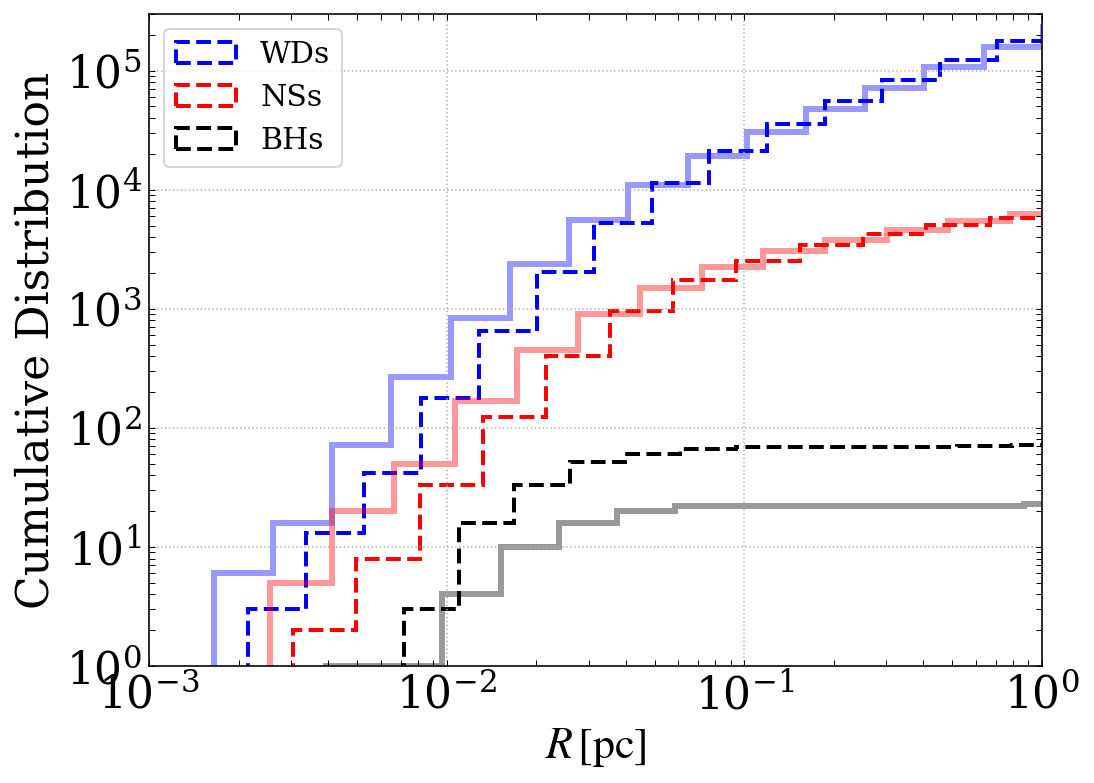

In [4]:
##WD distribution
pathab = paths #[paths[0], paths[9]]
#keysab = ['/489(t=17.876694)','/430(t=17.794863)']
#labelab = ['1a', '1b']
#print(pathab)

fig, axs = plt.subplots(figsize=(8,6))
rwd_all = [[],[]]; rns_all = [[],[]]; rbh_all = [[],[]]
wd_binfrac = []
nwd = []
for kk in range(len(pathab)):
    l_conv = dyn.conv('l', pathab[kk]+'initial.conv.sh')
    t_conv = dyn.conv('t', pathab[kk]+'initial.conv.sh')
    snap_keys = np.genfromtxt(pathab[kk]+'snap_keys.txt')
    snap_time = snap_keys[:,1]*t_conv
    thetime = snap_keys[:,1][snap_time>=11900.][0]
    theno = int(snap_keys[:,0][snap_time>=11900.][0])
    thekey = '/'+str(theno)+'(t='+str(thetime)+')'
    print(thekey)
    
    snaps = cmct.Snapshot(fname=pathab[kk]+'initial.snapshots.h5', snapshot_name=thekey, 
                      conv=pathab[kk]+'initial.conv.sh', 
                      dist=4.125, # distance to cluster in kpc
                      z=0.0002)
        
    binflag = np.array(snaps.data['binflag'])
    ktype=np.array(snaps.data['startype'])
    k0 = np.array(snaps.data['bin_startype0']); k1 = np.array(snaps.data['bin_startype1'])
    rpc = np.array(snaps.data['r'])*l_conv
    
    rwdwd = rpc[(10<=k0) & (k0<=12) & (10<=k1) & (k1<=12)]
    rwdx = rpc[((11<=k0) & (k0<=12)) | ((11<=k1) & (k1<=12))]
    rwd = rpc[((10<=ktype) & (ktype<=12)) | ((((10<=k0) & (k0<=12)) & (k1<=12)) | (((10<=k1) & (k1<=12)) & (k0<=12)))]
    rns = rpc[(ktype==13) | (((k0==13) & (k1<=13)) | ((k1==13) & (k0<=13)))]
    rbh = rpc[(ktype==14) | ((k0==14) | (k1==14))]
    wd_binfrac.append(len(rwdwd)/len(rwd))
    nwd.append(len(rwd))
    
    if kk<=ab_cut:
        rwd_all[0] = np.concatenate((rwd_all[0], rwd))
        rns_all[0] = np.concatenate((rns_all[0], rns))
        rbh_all[0] = np.concatenate((rbh_all[0], rbh))
    else:
        rwd_all[1] = np.concatenate((rwd_all[1], rwd))
        rns_all[1] = np.concatenate((rns_all[1], rns))
        rbh_all[1] = np.concatenate((rbh_all[1], rbh))
    
#axs.hist(rwdwd, bins = np.logspace(np.log10(np.min(rwdwd)), np.log10(np.max(rwdwd)), 18),
#         histtype='step', cumulative=True, label = labelab[kk]+': double WD-WD')
#axs.hist(rwdx, bins = np.logspace(np.log10(np.min(rwdx)), np.log10(np.max(rwdx)), 20),
#         histtype='step', cumulative=True, label = labelab[kk])
axs.hist(rwd_all[0], bins = np.logspace(np.log10(np.min(rwd_all[0])), np.log10(np.max(rwd_all[0])), 24),
         histtype='step', cumulative=True, lw = 3, color='b', alpha=0.4)
axs.hist(rwd_all[1], bins = np.logspace(np.log10(np.min(rwd_all[1])), np.log10(np.max(rwd_all[1])), 24),
         histtype='step', cumulative=True, lw = 2, color='b', alpha=1., ls='--', label = 'WDs')
axs.hist(rns_all[0], bins = np.logspace(np.log10(np.min(rns_all[0])), np.log10(np.max(rns_all[0])), 22),
         histtype='step', cumulative=True, lw = 3, color='r', alpha=0.4)
axs.hist(rns_all[1], bins = np.logspace(np.log10(np.min(rns_all[1])), np.log10(np.max(rns_all[1])), 22),
         histtype='step', cumulative=True, lw = 2, color='r', alpha=1., ls = '--', label = 'NSs')
axs.hist(rbh_all[0], bins = np.logspace(np.log10(np.min(rbh_all[0])), np.log10(np.max(rbh_all[0])), 20),
         histtype='step', cumulative=True, lw = 3, color='k', alpha=0.4)
axs.hist(rbh_all[1], bins = np.logspace(np.log10(np.min(rbh_all[1])), np.log10(np.max(rbh_all[1])), 20),
         histtype='step', cumulative=True, lw = 2, color='k', alpha=1., ls='--', label = 'BHs')

axs.set_xlabel(r'$R\,[\rm{pc}]$')
axs.set_ylabel('Cumulative Distribution')
axs.set_xlim(xmin=0.001, xmax=1)
axs.set_ylim(ymin = 1, ymax=3e5)
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=15)

plt.grid(linestyle=':',which='major',linewidth='0.75')
#plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig(savepath+'rdistri.pdf', dpi=300)

print(wd_binfrac, nwd)
print(np.mean(wd_binfrac[:8]), np.mean(wd_binfrac[8:]))
print(wd_binfrac[:8], wd_binfrac[8:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
counting done


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:68: RuntimeWarning: invalid value encountered in true_divide
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide
/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


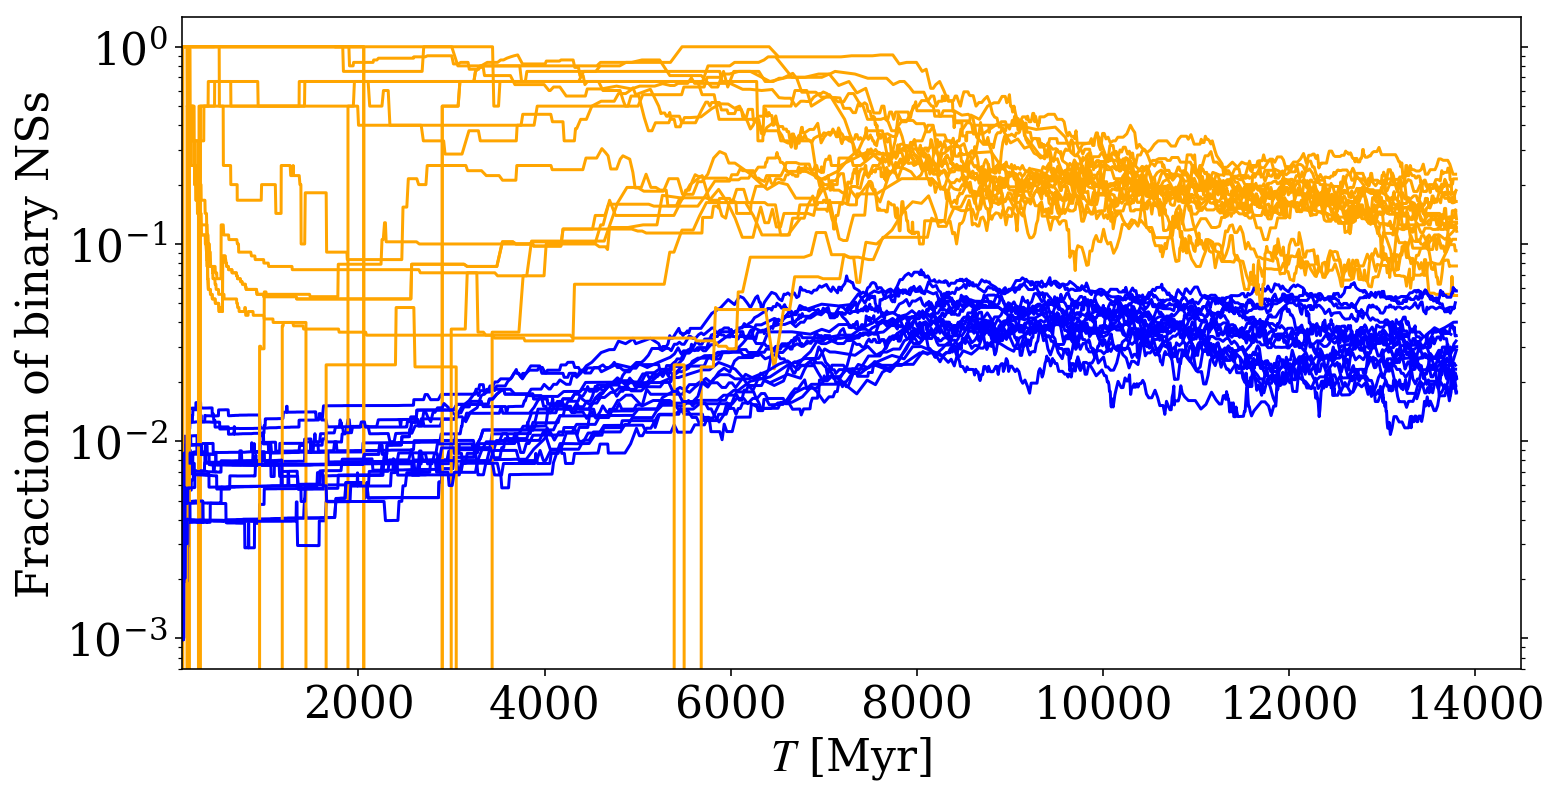

In [10]:
##NS binary fraction as a function of time
nns = []; nns_bin = []; t_evol = []
nmsp = []; nmsp_bin = [];
for xx in range(len(paths)):
    print(xx)
    nns.append([]); nns_bin.append([]); t_evol.append([])
    nmsp.append([]); nmsp_bin.append([])
    nsfile = paths[xx]+'initial.morepulsars.dat'
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    nsin = 0; nbin = 0
    nmspsin = 0; nmspbin = 0
    t_prev = 0
    with open(nsfile, 'r') as fns:
        next(fns)
        for line in fns:
            datans=line.split()
            t_current = float(datans[1])
            if t_current!=t_prev:
                nns[xx].append(nsin+nbin)
                nns_bin[xx].append(nbin)
                nmsp[xx].append(nmspsin+nmspbin)
                nmsp_bin[xx].append(nmspbin)
                
                t_evol[xx].append(t_prev*t_conv)
                
                nsin = 0; nbin = 0
                nmspsin = 0; nmspbin = 0
                
            if int(datans[2])!=1:
                nsin+=1
                if float(datans[7])>=float(datans[9])**2*(0.17*10**12) and float(datans[9])<=0.03:
                    nmspsin+=1
                elif (int(datans[3]) in idtde_msp_all[xx] 
                      or int(datans[3]) in id_wdwdcol_all[xx] 
                      or int(datans[3]) in id_wdwdmer_all[xx]):
                    nmspsin+=1
                    
            else:
                nbin+=1
                if int(datans[11])==13:
                    if float(datans[7])>=float(datans[9])**2*(0.17*10**12) and float(datans[9])<=0.03:
                        nmspbin+=1
                    elif (int(datans[3]) in idtde_msp_all[xx] 
                          or int(datans[3]) in id_wdwdcol_all[xx] 
                          or int(datans[3]) in id_wdwdmer_all[xx]):
                        nmspbin+=1
                elif int(datans[12])==13:
                    if float(datans[8])>=float(datans[10])**2*(0.17*10**12) and float(datans[10])<=0.03:
                        nmspbin+=1
                    elif (int(datans[4]) in idtde_msp_all[xx] 
                          or int(datans[4]) in id_wdwdcol_all[xx] 
                          or int(datans[4]) in id_wdwdmer_all[xx]):
                        nmspbin+=1
                
            t_prev = t_current
            
    nns[xx].append(nsin+nbin)
    nns_bin[xx].append(nbin)
    nmsp[xx].append(nmspsin+nmspbin)
    nmsp_bin[xx].append(nmspbin)
    t_evol[xx].append(t_prev*t_conv)
    
print('counting done')
    
fig, axs = plt.subplots(figsize=(12,6))
for xx in range(len(paths)):
    axs.plot(t_evol[xx], np.array(nns_bin[xx])/np.array(nns[xx]), color = 'b')
    axs.plot(t_evol[xx], np.array(nmsp_bin[xx])/np.array(nmsp[xx]), color = 'orange')


#axs.set_xscale('log')
axs.set_xlim(xmin=100)
axs.set_yscale('log')
axs.set_xlabel(r'$T$ [Myr]')
axs.set_ylabel('Fraction of binary NSs')
axs.tick_params(bottom=True, top=False, left=True, right=True, which='both')

In [ ]:
##Getting model offsets
##Models
idcheck = []

allmodel_no = []; alltypes = []
allid_sinmsp = []; allid_binmsp = []
allrpc_sinmsp = []; allrpc_binmsp = []

alloffset = []; allrpc = []
allrc = []; allrhl = []
allmass = [[],[]]; allids = [[],[]]
allktype = [[],[]]
for xx in range(len(paths)):
    print(paths[xx])
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    
    snap_keys = np.genfromtxt(paths[xx]+'snap_keys.txt', dtype='str')
    snapno = snap_keys[:,0]; snaptime = snap_keys[:,1]
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    if xx>0:
        snap2d = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
        clus_param = np.sort(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
    else:
        snap2d_unsort=np.array(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
        clus_param_unsort=np.array(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
        snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
        snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
        
        clusno_unsort=[int((x.split('.')[-3]).split('p')[1]) for x in clus_param_unsort]
        clusno, clus_param = zip(*sorted(zip(clusno_unsort,clus_param_unsort)))
        #print(snap2dno,clus_param,snap2d)
        
    for yy in range(len(clus_param)):
        data_param = np.genfromtxt(clus_param[yy])
        if os.stat(clus_param[yy]).st_size==0:
            continue
        if data_param[0][0]>=11900.:
            #print(clus_param[yy], snap2d[yy])
            print(data_param[0][0])
            thesnapno = int(snap2d[yy].split('.')[-4][4:])
            print(thesnapno)
            
            thesnapkey = '/'+snapno[thesnapno]+'(t='+snaptime[thesnapno]+')'
            print(thesnapkey)
            
            snap_h5 = cmct.Snapshot(fname=paths[xx]+'initial.snapshots.h5', snapshot_name=thesnapkey, 
                     conv=paths[xx]+'initial.conv.sh', 
                     dist=4.125, # distance to cluster in kpc
                     z=0.0002)
            
            binflag = np.array(snap_h5.data['binflag'])
            kstar = np.array(snap_h5.data['startype'])
            k0 = np.array(snap_h5.data['bin_startype0']); k1 = np.array(snap_h5.data['bin_startype1'])
            idstar = np.array(snap_h5.data['id'])
            id0 = np.array(snap_h5.data['id0']); id1 = np.array(snap_h5.data['id1'])
            Bstar = np.array(snap_h5.data['B'])
            B0 = np.array(snap_h5.data['B0']); B1 = np.array(snap_h5.data['B1'])
            Pstar = twopi*yearsc/np.array(snap_h5.data['ospin'])
            P0 = twopi*yearsc/np.array(snap_h5.data['ospin0']); P1 = twopi*yearsc/np.array(snap_h5.data['ospin1'])
            rpc = np.array(snap_h5.data['r'])*l_conv
            
            for zz in range(len(binflag)):
                if binflag[zz]!=1:
                    if kstar[zz]==13:
                        if Bstar[zz]>=Pstar[zz]**2*(0.17*10**12) and Pstar[zz]<=1.:
                            allid_sinmsp.append(idstar[zz])
                        elif idstar[zz] in idtde_msp_all[xx]:
                            allid_sinmsp.append(idstar[zz])
                else:
                    if k0[zz]==13:
                        if B0[zz]>=P0[zz]**2*(0.17*10**12) and P0[zz]<=1.:
                            allid_binmsp.append(id0[zz])
                        elif id0[zz] in idtde_msp_all[xx]:
                            allid_binmsp.append(id0[zz])
                        
                    if k1[zz]==13:
                        if B1[zz]>=P1[zz]**2*(0.17*10**12) and P1[zz]<=1.:
                            allid_binmsp.append(id1[zz])
                        elif id1[zz] in idtde_msp_all[xx]:
                            allid_binmsp.append(id1[zz])
            print(len(allid_binmsp), len(allid_sinmsp))
            
            #print(np.sort(allid_wdwd))
            with gzip.open(snap2d[yy], 'r') as f2d:
                next(f2d); next(f2d)
                for line in f2d:
                    data2d = line.split()
                    if int(data2d[2])!=1:
                        if int(data2d[3])==13:
                            if int(data2d[12]) in allid_sinmsp:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(1)
                                allmass[0].append(float(data2d[9]))
                                allmass[1].append(0.)
                                allids[0].append(int(data2d[12]))
                                allids[1].append(-100)
                                allktype[0].append(int(data2d[3]))
                                allktype[1].append(-100)
                                allrpc.append(rpc[idstar == int(data2d[12])][0])
                            elif int(data2d[12]) in id_wdwdcol_all[xx] or int(data2d[12]) in id_wdwdmer_all[xx]:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(3)
                                allmass[0].append(float(data2d[9]))
                                allmass[1].append(0.)
                                allids[0].append(int(data2d[12]))
                                allids[1].append(-100)
                                allktype[0].append(int(data2d[3]))
                                allktype[1].append(-100)
                                allrpc.append(rpc[idstar == int(data2d[12])][0])
                                idcheck.append(int(data2d[12]))
                                
                                
                    else:
                        if int(data2d[5])==13:
                            if int(data2d[13]) in allid_binmsp:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(2)
                                allmass[0].append(float(data2d[10]))
                                allmass[1].append(float(data2d[11]))
                                allids[0].append(int(data2d[13]))
                                allids[1].append(int(data2d[14]))
                                allktype[0].append(int(data2d[5]))
                                allktype[1].append(int(data2d[6]))
                                allrpc.append(rpc[id0 == int(data2d[13])][0])
                            elif int(data2d[13]) in id_wdwdcol_all[xx] or int(data2d[13]) in id_wdwdmer_all[xx]:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(4)
                                allmass[0].append(float(data2d[10]))
                                allmass[1].append(float(data2d[11]))
                                allids[0].append(int(data2d[13]))
                                allids[1].append(int(data2d[14]))
                                allktype[0].append(int(data2d[5]))
                                allktype[1].append(int(data2d[6]))
                                allrpc.append(rpc[id0 == int(data2d[13])][0])
                                idcheck.append(int(data2d[13]))
                         
                        if int(data2d[6])==13:
                            if int(data2d[14]) in allid_binmsp:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(2)
                                allmass[0].append(float(data2d[11]))
                                allmass[1].append(float(data2d[10]))
                                allids[0].append(int(data2d[14]))
                                allids[1].append(int(data2d[13]))
                                allktype[0].append(int(data2d[6]))
                                allktype[1].append(int(data2d[5]))
                                allrpc.append(rpc[id1 == int(data2d[14])][0])
                            elif int(data2d[14]) in id_wdwdcol_all[xx] or int(data2d[14]) in id_wdwdmer_all[xx]:
                                alloffset.append(float(data2d[0]))
                                allrc.append(float(data_param[0][9]))
                                allrhl.append(float(data_param[0][10]))
                                allmodel_no.append(xx)
                                alltypes.append(4)
                                allmass[0].append(float(data2d[11]))
                                allmass[1].append(float(data2d[10]))
                                allids[0].append(int(data2d[14]))
                                allids[1].append(int(data2d[13]))
                                allktype[0].append(int(data2d[6]))
                                allktype[1].append(int(data2d[5]))
                                allrpc.append(rpc[id1 == int(data2d[14])][0])
                                idcheck.append(int(data2d[14]))
                    
            print(len(alloffset), len(allid_sinmsp), len(allid_binmsp), len(allrpc))
            #print(len(alloffset_wdwd), len(allid_wdwd ))
            #print(len(idcheck), np.sort(idcheck))
            #print(allrpc)
                
            break
    
modeloffrc = np.array(alloffset)/np.array(allrc)

modeloffrhl = np.array(alloffset)/np.array(allrhl)


np.savetxt(savepath+'model_offsets_psr1sec_12Gyr_new.dat', np.c_[allmodel_no, alloffset,
                                               #allid_sinmsp+allid_binmsp+allid_wdwd, 
                                               allrc, allrhl,
                                               modeloffrc,modeloffrhl,
                                               alltypes, allmass[0], allmass[1],
                                               allktype[0], allktype[1],
                                               allids[0], allids[1], allrpc],
          fmt = '%d %f %f %f %f %f %d %f %f %d %d %d %d %f', 
          header = '1.Model No 2.Offsets[pc] 3.Rc[pc] 4.Rhl[pc] 5.Offset/Rc 6.Offset/Rhl 7.Types 8.M0[Msun] 9.M1[Msun] 10.K0 11.K1 12.ID0 13.ID1 14.r3d[pc]',
          comments = '#', delimiter = ' ')


280
6.39
15 19
no sigma J1823-3021E
no sigma J1823-3021F
no sigma J1823-3021H
[0.27019599 0.05624656 0.22435407 0.17880095 0.1077286  0.09742836
 0.27213089 0.00740579 0.22151329 0.13950913 0.05688466 0.78025143
 0.03287874 0.08840024 0.01041537 6.37450496 0.06301354 2.5556629
 0.04909279 0.04500366 0.0777347  0.06757022 0.03061118] ['J1701-3006A', 'J1701-3006B', 'J1701-3006C', 'J1701-3006D', 'J1701-3006E', 'J1701-3006F', 'J1701-3006G', 'J1823-3021A', 'J1823-3021B', 'J1823-3021C', 'J1823-3021D', 'J1823-3021E', 'J1823-3021F', 'J1823-3021G', 'J1823-3021H', 'J1910-5959A', 'J1910-5959B', 'J1910-5959C', 'J1910-5959D', 'J1910-5959E', 'J1910-5959F', 'J2140-2310A', 'J2140-2310B'] [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[0.32  0.028 0.175 0.2   0.111 0.041 2.3   0.917 0.24  0.07  0.2   0.05
 0.23  0.134 0.14  0.082 1.43  2.99  6.39  0.1   2.7   0.19  0.13  0.082
 0.018 0.079 0.944 0.019 0.135 0.279 0.106 0.038 0.067 1.2  ] ['J1701-3006A' 'J1701-3006B' 'J1701-3006C'

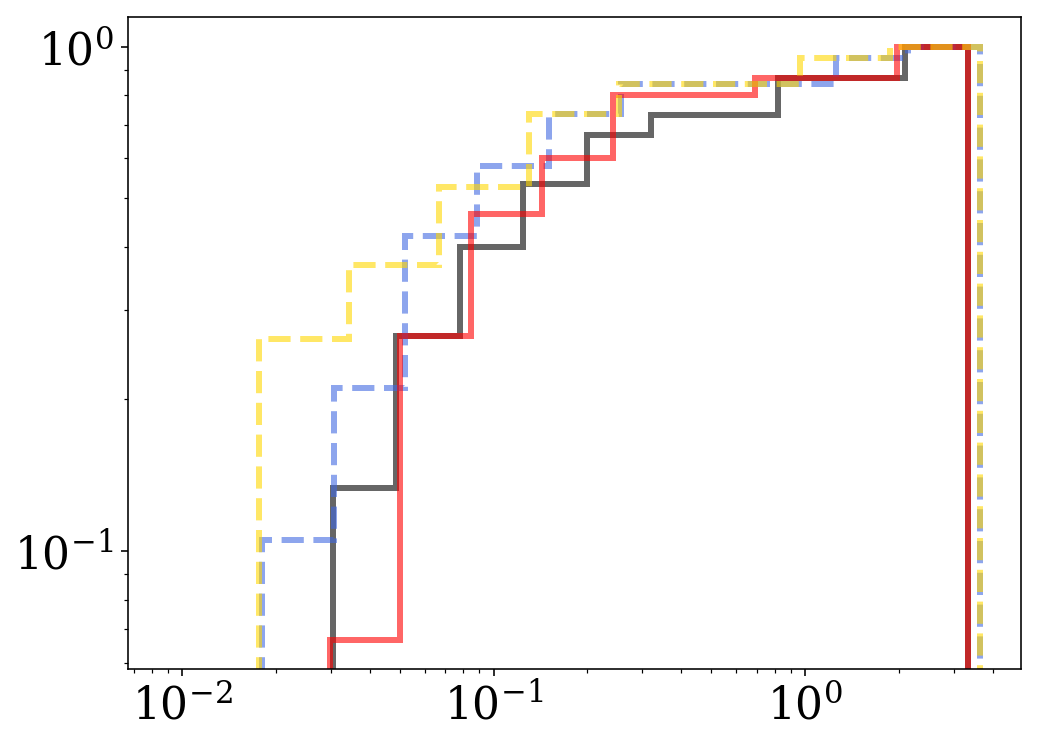

In [7]:
##Recalculate some of the pulsar offsets
#####Centers
centers = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/centers_offsets.xlsx', 
                         names = ['Cluster', 'RAh', 'Dech', 'RAcog', 'Deccog', 'sigma', 'refcog', 'Diff'])

#####ATNF catalog
atnf_psr = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/atnf_gcpsr_position.xlsx', 
                         names = ['No','NAME','PSRJ','RAJ','RAJ_sigma','DECJ','DECJ_sigma',
                                  'P0','P0_sigma','P1','P1_sigma','ECC','ECC_sigma',
                                  'Minimum','Median','BINCOMP','ASSOC'], skiprows=1)


#atnf_psr.astype(str)
#atnf_filter = atnf_psr[(atnf_psr['RAJ_sigma'] == 0) | (atnf_psr['DECJ_sigma']==0)]
#print(atnf_filter['PSRJ'])


#####PSR catalog
Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire(spinflag=0,offsetflag=1)
print(np.max(Offset))
Offset=np.array(Offset); Binoff = np.array(Binoff)
Poff = np.array(Poff); Clusoff = np.array(Clusoff)
Nameoff = np.array(Nameoff)
#Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]


data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
CCst = np.array(data_gcmsp['cc'])
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

Rcoff = []; Rhloff = []; CCs = []
for kk in range(len(Clusoff)):
    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0])
    CCs.append(CCst[clusno==Clusoff[kk]][0]) 
Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)
CCs = np.array(CCs)

ccbinoffrhl_old = (Offset/Rhloff)[(Binoff==1) & (CCs==1)]
ccsinoffrhl_old = (Offset/Rhloff)[(Binoff==0) & (CCs==1)]
print(len(ccbinoffrhl_old), len(ccsinoffrhl_old))

#####Recalculating the offsets
##New offsets
centers_cc = []; ra_cog_cc = []; dec_cog_cc = []
atnf_psr_cc = []; atnf_ra_cc = []; atnf_dec_cc = []; atnf_clus_cc = []; atnf_bin_cc = []
atnf_name_cc = []
for kk in range(len(centers['Cluster'])):
    if centers['RAcog'].iloc[kk]!=0:
        cc_no =  centers['Cluster'].iloc[kk].split()[1]
        
        for jj in range(len(atnf_psr['ASSOC'])):
            if cc_no in atnf_psr['ASSOC'].iloc[jj]:
                atnf_psr_cc.append(atnf_psr['PSRJ'].iloc[jj])
                atnf_ra_cc.append(atnf_psr['RAJ'].iloc[jj])
                atnf_dec_cc.append(atnf_psr['DECJ'].iloc[jj])
                atnf_clus_cc.append(cc_no)
                atnf_name_cc.append(atnf_psr['NAME'].iloc[jj])
                if atnf_psr['Median'].iloc[jj] != '*':
                    atnf_bin_cc.append(1)
                else:
                    atnf_bin_cc.append(0)
                    
                if atnf_psr['RAJ_sigma'].iloc[jj]==0:
                    print('no sigma', atnf_psr['PSRJ'].iloc[jj])
                
                centers_cc.append(cc_no)
                ra_cog_cc.append(centers['RAcog'].iloc[kk])
                dec_cog_cc.append(centers['Deccog'].iloc[kk])
        
#print(atnf_psr_cc, atnf_clus_cc, len(atnf_psr_cc), centers_cc, len(centers_cc))

new_off = cal_offsets(ra_cog_cc, dec_cog_cc, atnf_ra_cc, atnf_dec_cc)
print(new_off, atnf_psr_cc, atnf_bin_cc)
print(Offset[CCs==1], Nameoff[CCs==1])


New_offsets = np.copy(Offset)
New_offsets_extra = []; New_psr_extra = []; New_bin_extra = []
for xx in range(len(atnf_psr_cc)):
    for yy in range(len(Nameoff)):
        if Nameoff[yy]== 'J1911-5958A':
            Nameoff[yy] = 'J1910-5959A'
        if Nameoff[yy] == 'J1911-6000C':
            Nameoff[yy] = 'J1910-5959C'
        if Nameoff[yy] == atnf_psr_cc[xx] or Nameoff[yy]==atnf_name_cc[xx]:
            #print('yes')
            New_offsets[yy]=new_off[xx]
            
    if atnf_psr_cc[xx] not in Nameoff and atnf_name_cc[xx] not in Nameoff:
        New_offsets_extra.append(new_off[xx])
        New_psr_extra.append(atnf_psr_cc[xx])
        New_bin_extra.append(atnf_bin_cc[xx])
        print(atnf_psr_cc[xx], atnf_name_cc[xx], atnf_bin_cc[xx])


ccbinoffrhl = (New_offsets/Rhloff)[(Binoff==1) & (CCs==1)]
ccsinoffrhl = (New_offsets/Rhloff)[(Binoff==0) & (CCs==1)]
nobs_bin = len(ccbinoffrhl)
nobs_sin = len(ccsinoffrhl)
print('nobs_bin, nobs_sin', nobs_bin, nobs_sin)
print(ccbinoffrhl, ccsinoffrhl)
#print(Offset[(Binoff==0) & (CCs==1)], Clusoff[(Binoff==0) & (CCs==1)])

fig, axs = plt.subplots(figsize=(8,6))
axs.hist(ccbinoffrhl_old, 
        bins = np.logspace(np.log10(np.min(ccbinoffrhl_old)), np.log10(np.max(ccbinoffrhl_old)), 10+1),
        cumulative=True, weights = np.ones_like(ccbinoffrhl_old)/float(len(ccbinoffrhl_old)),
         #density=True, stacked=True,
        histtype='step', label = 'Observed bPSR', lw=3, color='k', alpha=0.6)
axs.hist(ccsinoffrhl_old,
        bins = np.logspace(np.log10(np.min(ccsinoffrhl_old)), np.log10(np.max(ccsinoffrhl_old)), 10+1),
        cumulative=True, weights = np.ones_like(ccsinoffrhl_old)/float(len(ccsinoffrhl_old)),
         #density=True, stacked=True,
        histtype='step', label = 'Observed sPSR', lw=3, ls='--', color='royalblue', alpha=0.6)

axs.hist(ccbinoffrhl, 
        bins = np.logspace(np.log10(np.min(ccbinoffrhl)), np.log10(np.max(ccbinoffrhl)), 10),
        cumulative=True, weights = np.ones_like(ccbinoffrhl)/float(len(ccbinoffrhl)),#density=True, stacked=True,
        histtype='step', label = 'Observed bPSR', lw=3, color='red', alpha=0.6)

sin_weights = np.ones_like(ccsinoffrhl)/float(len(ccsinoffrhl))
sin_weights[0] = 0.05263158+sin_weights[0]
axs.hist(ccsinoffrhl,
        bins = np.logspace(np.log10(np.min(ccsinoffrhl)), np.log10(np.max(ccsinoffrhl)), 10),
        cumulative=True, weights = sin_weights,
         #density=True, stacked=True,
        histtype='step', label = 'Observed sPSR', lw=3, ls='--', color='gold', alpha=0.6)
axs.set_xscale('log')
axs.set_yscale('log')

#ccbinoffrhl = ccbinoffrh_old; ccsinoffrhl = ccsinoffrhl_old

In [6]:
##Offset calculator and random position generator
from astropy.coordinates import SkyCoord
from astropy import units as u

def cal_offsets(ra_cen, decl_cen, ra_psr, decl_psr):
    allsep = []
    for xx in range(len(ra_cen)):
        c1 = SkyCoord(ra_cen[xx], decl_cen[xx], unit=(u.hourangle, u.deg))
        c2 = SkyCoord(ra_psr[xx], decl_psr[xx], unit=(u.hourangle, u.deg))
        sep = c1.separation(c2)
        allsep.append(sep.arcminute)
    return np.array(allsep)

def random_position_2d(R, N):
    r = R * np.sqrt(np.random.uniform(0, 1, N))
    
    return r

def random_position_3d(R, N):
    phi = np.random.uniform(0,2.*math.pi, N)
    costheta = np.random.uniform(-1,1,N)
    u = np.random.uniform(0,1,N)

    theta = np.arccos(costheta)
    r = R * np.cbrt(u)
    
    return r


def random_position_3dto2d(R, N):
    phi = np.random.uniform(0,2.*math.pi, N)
    costheta = np.random.uniform(-1,1,N)
    u = np.random.uniform(0,1,N)

    theta = np.arccos(costheta)
    r = R * np.cbrt(u)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    ##From the CMC projection function
    PROJ=(0,1)
    r3d = np.array([x, y, z])
    r2d = (r3d[PROJ[0],:]**2. + r3d[PROJ[1],:]**2.)**0.5
    ind = np.argsort(r2d)
    
    return r2d

print('2d', random_position_2d(0.02,20))
print('3d', random_position_3dto2d(0.02, 20))
#centers = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/centers_offsets.xlsx', 
#                         names = ['Cluster', 'RAh', 'Dech', 'RAcog', 'Deccog', 'sigma', 'refcog'])
#centers.astype(str)
#cal_offsets(centers['RAh'], centers['Dech'], centers['RAcog'], centers['Deccog'])*60

2d [0.00734192 0.0189135  0.01700075 0.00690267 0.01593205 0.00760611
 0.01380365 0.01402171 0.00810575 0.01800783 0.00948881 0.0148296
 0.0114928  0.00987465 0.01238724 0.01683539 0.00361631 0.01133449
 0.01472944 0.01937122]
3d [0.01774163 0.00612284 0.0129051  0.00355392 0.01706573 0.01468194
 0.01005129 0.01691627 0.01607668 0.01067183 0.0148471  0.01555627
 0.01118377 0.01398752 0.01358029 0.01686596 0.01497756 0.00881262
 0.00148414 0.01196741]


132
resampling check 2453 2453
small offset 132 132
2453 763
685 453 171 41
1138
binaries Ks_2sampResult(statistic=0.3009433962264151, pvalue=0.12858186486273485)
singles Ks_2sampResult(statistic=0.4761354176301915, pvalue=0.00023406083078741235)


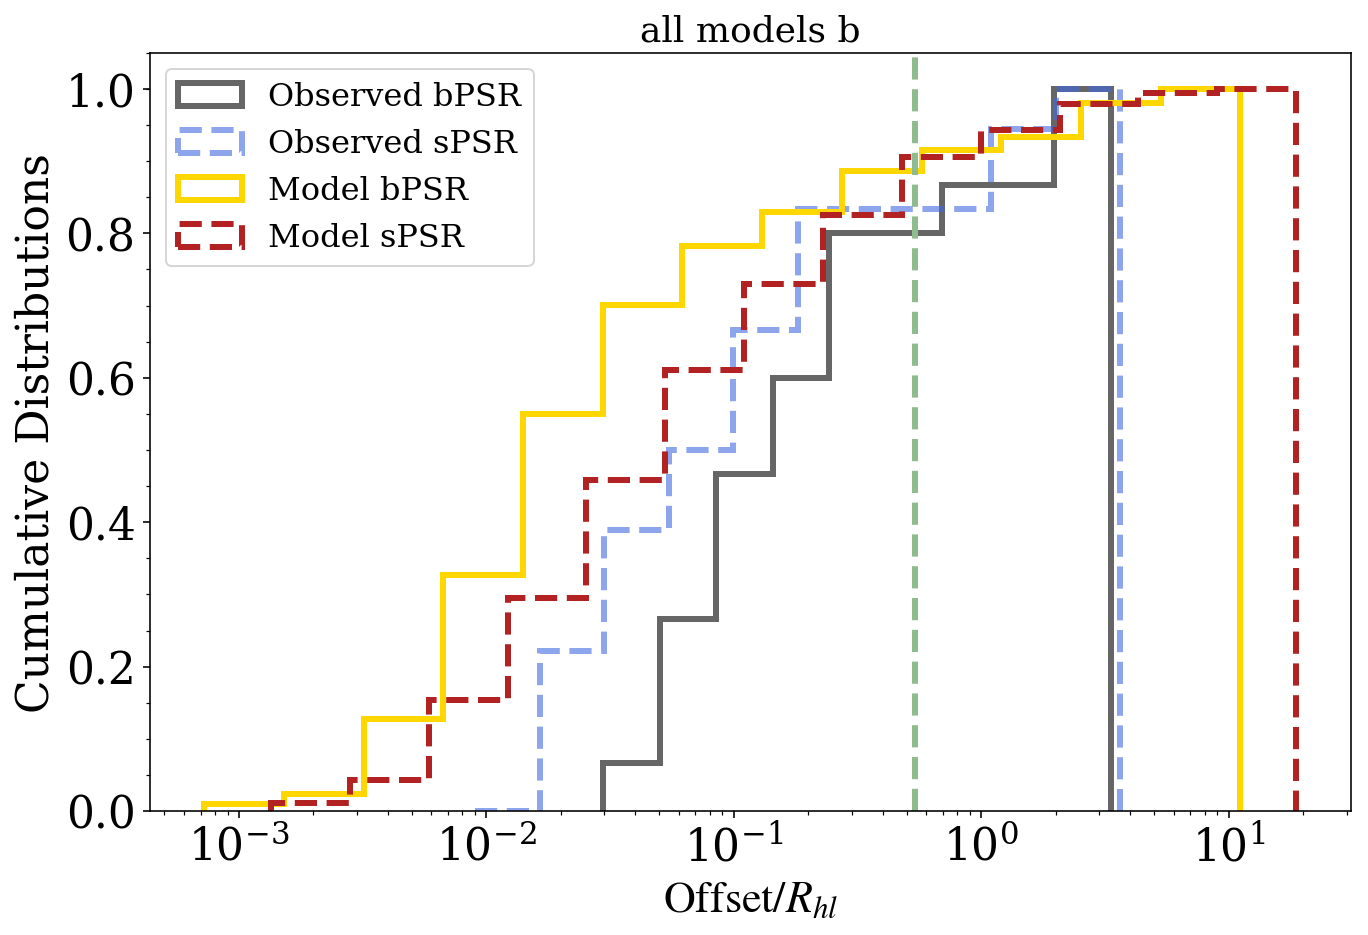

In [9]:
####Offset Distributions
##Observed psr and WD-WD coalscence remnant offset distributions
##Commented out this here since I'm doing this in the block above
#Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire(spinflag=0,offsetflag=1)
#print(len(Clusoff))
#print(np.max(Offset))
#Offset=np.array(Offset); Binoff = np.array(Binoff)
#Poff = np.array(Poff); Clusoff = np.array(Clusoff)
##Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]
#print(Offset, Clusoff)


#data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
#                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
#                          skiprows = 1)
#rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
#print(len(rc_psrcat))
#CCst = np.array(data_gcmsp['cc'])
#clusname = data_gcmsp['name']
#clusno = []
#for ii in range(len(clusname)):
#    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
#        clusno.append(str(clusname[ii]).split()[-1])
#    else:
#        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
#clusno = np.array(clusno)

#Rcoff = []; Rhloff = []; CCs = []
#for kk in range(len(Clusoff)):
#    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
#    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0])
#    CCs.append(CCst[clusno==Clusoff[kk]][0]) 
#Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)
#CCs = np.array(CCs)
#print(Rhloff, Clusoff)

#binoffrc = (Offset/Rcoff)[Binoff==1]
#sinoffrc = (Offset/Rcoff)[Binoff==0]
#ccbinoffrhl = (Offset/Rhloff)[(Binoff==1) & (CCs==1)]
#ccsinoffrhl = (Offset/Rhloff)[(Binoff==0) & (CCs==1)]
#nobs_bin = len(ccbinoffrhl)
#nobs_sin = len(ccsinoffrhl)
#print('nobs_bin, nobs_sin', nobs_bin, nobs_sin)
#print(Offset[(Binoff==0) & (CCs==1)], Clusoff[(Binoff==0) & (CCs==1)])


#################################Models####################################
data_model = np.genfromtxt(savepath+'model_offsets_psr1sec_12Gyr_new.dat')
allmodelrhl = data_model[:,3]; allmodeloffrhl_old = data_model[:,5]
allmodeltypes = data_model[:,6]
allmodelnos = data_model[:,0].astype(np.int); allmodelm0 = data_model[:,7]; allmodelm1 = data_model[:,8]
allmodelk0 = data_model[:,9]; allmodelk1 = data_model[:,10]
allmodelid0 = data_model[:,11].astype(np.int); allmodelid1 = data_model[:,12].astype(np.int)
allmodelmtot = allmodelm0+allmodelm1
allmodeloff = data_model[:,1]; allmodelr3d = data_model[:,-1]

##Re-sampling the position of the inner few pulsars
r_limit = 0.02
bin_resample = random_position_3dto2d(r_limit, len(allmodelr3d[allmodelr3d<=r_limit]))
print(len(allmodelr3d[allmodelr3d<=r_limit]))
#allmodeloffrhl = np.concatenate((bin_resample/modelrhl[allmodeloff<=0.02], modeloffrhl[allmodeloff>0.02]))
ind_center = np.where(allmodelr3d<=r_limit)[0]
allmodeloffrhl = np.copy(allmodeloffrhl_old)
count_small = 0 
for ii in range(len(ind_center)):
    #print(allmodeloffrhl[ind_center[ii]], bin_resample[ii], bin_resample[ii]/allmodelrhl[ind_center[ii]])
    if bin_resample[ii]/allmodelrhl[ind_center[ii]] <0.02:
        count_small+=1
    allmodeloffrhl[ind_center[ii]]=bin_resample[ii]/allmodelrhl[ind_center[ii]]
#allmodeloffrhl = modeloffrhl

print('resampling check', len(allmodeloffrhl_old), len(allmodeloffrhl))
print('small offset', len(bin_resample[bin_resample<=0.02]), count_small)


flag_coco_exclude = []; flag_heavycom_exclude = []; flag_tde_exclude = []
for xx in range(len(allmodelid0)):
    themodel = allmodelnos[xx]
    if allmodelid0[xx] in id_wdwdcol_all[themodel]:
        #print(np.array(id_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]])
        if np.array(type_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]]=='1111':
            flag_coco_exclude.append(1)
        else:
            flag_coco_exclude.append(0)
    elif allmodelid0[xx] in id_wdwdmer_all[themodel]:
        if np.array(type_wdwdmer_all[themodel])[np.array(id_wdwdmer_all[themodel])==allmodelid0[xx]]=='1111':
            flag_coco_exclude.append(1)
        else:
            flag_coco_exclude.append(0)
    else:
        flag_coco_exclude.append(0)

    if allmodelid0[xx] in idtde_msp_all[themodel]:
        flag_tde_exclude.append(1)
    else:
        flag_tde_exclude.append(0)
    
    if allmodelm1[xx]>=0.8 and 11<=allmodelk1[xx]<=12:
        flag_heavycom_exclude.append(1)
    else:
        flag_heavycom_exclude.append(0)

#print(flag_heavycom_exclude)
flag_coco_exclude = np.array(flag_coco_exclude)
flag_heavycom_exclude = np.array(flag_heavycom_exclude)
flag_tde_exclude = np.array(flag_tde_exclude)
print(len(flag_tde_exclude), len(flag_tde_exclude[flag_tde_exclude==1]))
            
modelsinoffrhl = allmodeloffrhl[(allmodeltypes==1) & (allmodelnos>=9) & 
                                (flag_heavycom_exclude>=0) & (flag_coco_exclude>=0)
                                & (flag_tde_exclude>=0)]
modelbinoffrhl = allmodeloffrhl[(allmodeltypes==2) & (allmodelnos>=9) & 
                                (flag_heavycom_exclude>=0) & (flag_coco_exclude>=0)
                                & (flag_tde_exclude>=0)]
modelsinwdoffrhl = allmodeloffrhl[(allmodeltypes==3) & (allmodelnos>=9) & 
                                  (flag_heavycom_exclude>=0) & (flag_coco_exclude>=0)
                                  & (flag_tde_exclude>=0)]
modelbinwdoffrhl = allmodeloffrhl[(allmodeltypes==4) & (allmodelnos>=9) & 
                                  (flag_heavycom_exclude>=0) & (flag_coco_exclude>=0)
                                  & (flag_tde_exclude>=0)]

print(len(modelsinoffrhl), len(modelsinwdoffrhl), len(modelbinoffrhl), len(modelbinwdoffrhl),)


####Sampling the model data
bin_no = 10
modelsingles = np.array(list(modelsinoffrhl)+list(modelsinwdoffrhl))#np.array(list(modelsinoffrc)+list(modelsinwdoffrc))#
print(len(modelsingles))
sampbins_sin = np.logspace(np.log10(np.min(modelsingles)), np.log10(np.max(modelsingles)), bin_no+1)
#print(len(sampbins_sin))
modelbinaries = np.array(list(modelbinoffrhl)+list(modelbinwdoffrhl))#np.array(list(modelbinoffrc)+list(modelbinwdoffrc))#
sampbins_bin = np.logspace(np.log10(np.min(modelbinaries)), np.log10(np.max(modelbinaries)), bin_no+1)
#print(sampbins_bin, sampbins_bin[1:], sampbins_bin[:-1])
sin_center = 0.5*(sampbins_sin[1:]+sampbins_sin[:-1])
bin_center = 0.5*(sampbins_bin[1:]+sampbins_bin[:-1])
#print(len(sampbins_bin))
allcount_sin = [[] for _ in range(bin_no)]
allcount_bin = [[] for _ in range(bin_no)]
for xx in range(500):
    random.seed(xx)
    samps_sin = np.random.choice(modelsingles, size = nobs_sin)
    samps_bin = np.random.choice(modelbinaries, size = nobs_bin)
    #print(samps_bin)
    
    inds_sin = np.digitize(samps_sin, sampbins_sin, right=False)
    inds_bin = np.digitize(samps_bin, sampbins_bin, right=False)
    #print(inds_bin)
    
    sin_inds = np.array(list(Counter(inds_sin).keys()))
    sin_counts = np.array(list(Counter(inds_sin).values()))
    bin_inds = np.array(list(Counter(inds_bin).keys()))
    bin_counts = np.array(list(Counter(inds_bin).values()))
    #print(len(bin_inds),bin_inds)
    bin_inds = bin_inds-1
    #print(len(bin_inds),bin_inds)
    #print(len(sin_inds),sin_inds)
    sin_inds = sin_inds-1
    #print(len(sin_inds),sin_inds)
    for yy in range(len(bin_inds)):
        if bin_inds[yy]==-1:
            bin_inds[yy]=0
        if bin_inds[yy]==bin_no:
            bin_inds[yy]=bin_no-1
        allcount_bin[bin_inds[yy]].append(bin_counts[yy])
        
    for zz in range(len(sin_inds)):
        if sin_inds[zz]==-1:
            sin_inds[zz]=0
        if sin_inds[zz]==bin_no:
            sin_inds[zz]=bin_no-1
        allcount_sin[sin_inds[zz]].append(sin_counts[zz])
    
sin_mean = np.zeros(bin_no); sin_sd = np.zeros(bin_no)
bin_mean = np.zeros(bin_no); bin_sd = np.zeros(bin_no)
for xx in range(bin_no):
    sin_mean[xx] = np.mean(allcount_sin[xx])
    bin_mean[xx] = np.mean(allcount_bin[xx])
    sin_sd[xx] = np.std(allcount_sin[xx])
    bin_sd[xx] = np.std(allcount_bin[xx])
    
    
####Plotting
fig, ax = plt.subplots(figsize=(10,7))
#ax.hist(binoffrc, 
#        bins = np.logspace(np.log10(np.min(binoffrc)), np.log10(np.max(binoffrc)), bin_no+1),
#        histtype='step', label = 'Observed bMSP', lw=3, color='k', alpha=0.6)
#ax.hist(sinoffrc,
#        bins = np.logspace(np.log10(np.min(sinoffrc)), np.log10(np.max(sinoffrc)), bin_no+1),
#        histtype='step', label = 'Observed sMSP', lw=3, color='royalblue', alpha=0.6)
ax.hist(ccbinoffrhl, 
        bins = np.logspace(np.log10(np.min(ccbinoffrhl)), np.log10(np.max(ccbinoffrhl)), bin_no),
        cumulative=True, #weights = np.ones_like(ccbinoffrhl)/float(len(ccbinoffrhl)),
        density=True, #stacked=True,
        histtype='step', label = 'Observed bPSR', lw=3, color='k', alpha=0.6)
ax.hist(ccsinoffrhl,
        bins = np.logspace(np.log10(np.min(ccsinoffrhl)), np.log10(np.max(ccsinoffrhl)), bin_no+1),
        cumulative=True, #weights = np.ones_like(ccsinoffrhl)/float(len(ccsinoffrhl)),
        density=True, #stacked=True,
        histtype='step', label = 'Observed sPSR', lw=3, ls='--', color='royalblue', alpha=0.6)
ax.hist(modelbinaries,
        bins = np.logspace(np.log10(np.min(modelbinaries)), np.log10(np.max(modelbinaries)), bin_no+4),
        cumulative=True, #weights = np.ones_like(modelbinaries)/float(len(modelbinaries)),
        density=True, #stacked=True,
        histtype='step', color = 'gold', lw = 3, label = 'Model bPSR')
ax.hist(modelsingles,
        bins = np.logspace(np.log10(np.min(modelsingles)), np.log10(np.max(modelsingles)), bin_no+4),
        cumulative=True, #weights = np.ones_like(modelsingles)/float(len(modelsingles)),
        density=True, #stacked=True,
        histtype='step', color = 'firebrick', lw = 3, ls='--', label = 'Model sPSR')
#ax.hist(samps_bin,
#        bins = np.logspace(np.log10(np.min(samps_bin)), np.log10(np.max(samps_bin)), bin_no+1),
#        cumulative=True,# density=True, stacked=True,
#        histtype='step', color = 'gold', lw = 3, label = 'Model bPSR')
#ax.hist(samps_sin,
#        bins = np.logspace(np.log10(np.min(samps_sin)), np.log10(np.max(samps_sin)), bin_no+1),
#        cumulative=True,# density=True, stacked=True,
#        histtype='step', color = 'firebrick', lw = 3, label = 'Model sPSR')
#ax.errorbar(bin_center, bin_mean, yerr = bin_sd, 
#            color = 'gold', lw = 2, capsize=7, capthick=2, label = 'Model bPSR')
#ax.errorbar(sin_center, sin_mean, yerr = sin_sd, 
#            color = 'firebrick', lw = 2, capsize=7, capthick=2, label = 'Model sPSR')
#ax.scatter(2./3.7, 20, marker='*', s=300, facecolor='darkseagreen', edgecolor = 'forestgreen', lw=2)
ax.axvline(x=2./3.7,ls='--', color='darkseagreen', lw=3)


ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Offset}/\mathit{R_{hl}}$')
ax.set_ylabel('Cumulative Distributions')
ax.set_title('all models b', fontsize=18)
#ax.set_title('Fiducial, but excluding non-MSP NSs from WD-WD', fontsize=18)
ax.legend(loc='upper left', fontsize=16)

fig.tight_layout()
#plt.savefig(savepath+'offsets.pdf', dpi=300)

cdf_binoffrhl = np.array(np.cumsum(ccbinoffrhl/len(ccbinoffrhl)))
cdf_modelbinaries = np.array(np.cumsum(modelbinaries/len(modelbinaries)))
cdf_sinoffrhl = np.array(np.cumsum(ccsinoffrhl/len(ccsinoffrhl)))
cdf_modelsingles = np.array(np.cumsum(modelsingles/len(modelsingles)))
print('binaries', stats.ks_2samp(cdf_binoffrhl, cdf_modelbinaries))
print('singles', stats.ks_2samp(cdf_sinoffrhl, cdf_modelsingles))
#print('binaries', stats.ks_2samp(cdf_binoffrhl, np.cumsum(samps_bin)/len(samps_bin))
#print('singles', stats.ks_2samp(cdf_sinoffrhl, np.cumsum(samps_sin)/len(samps_sin)))

2368 774
894
1117


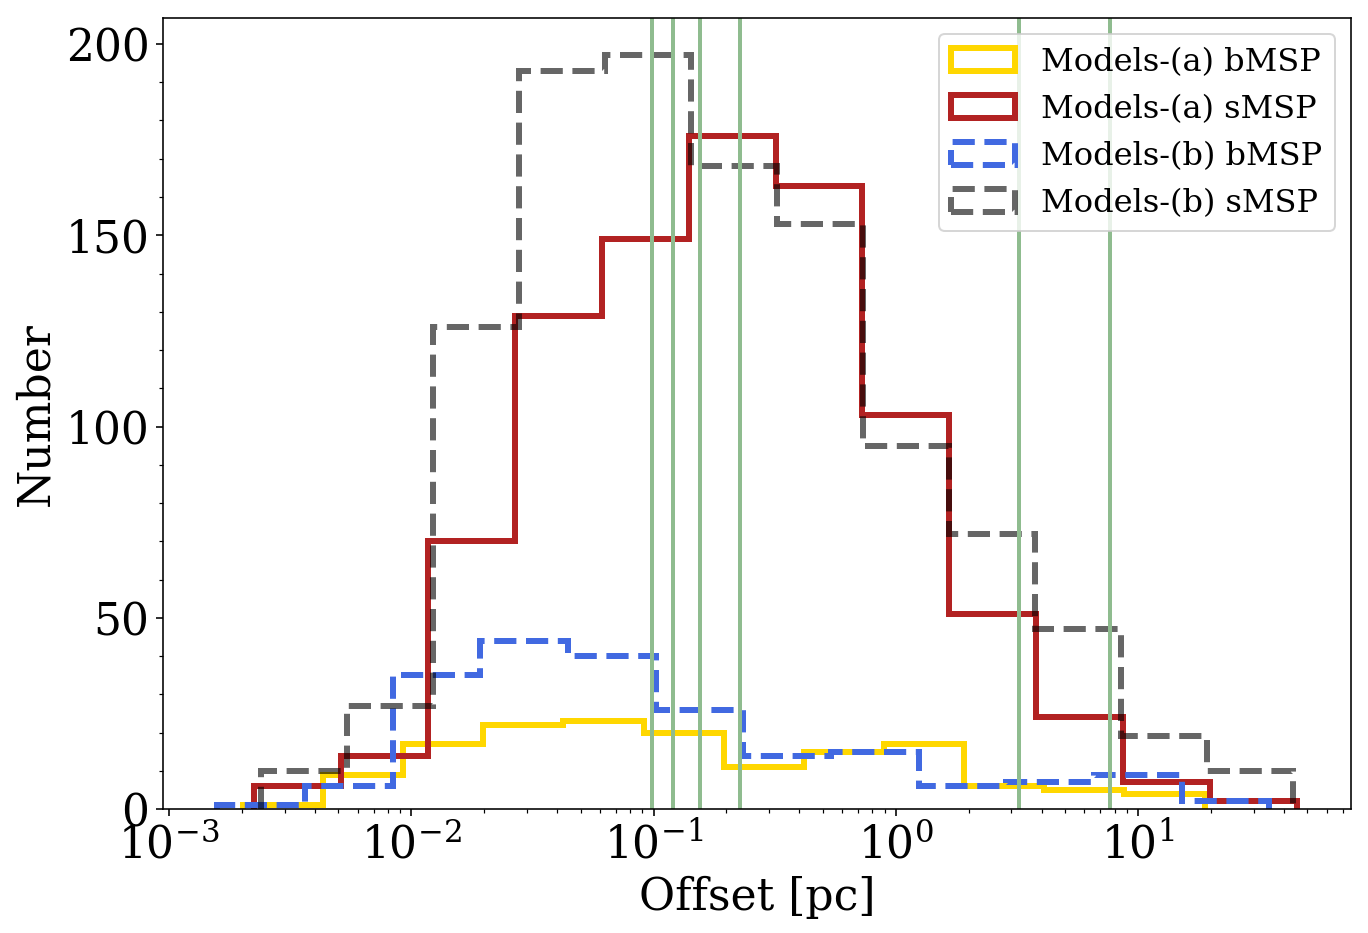

In [13]:
####Offset Distributions comparing to only NGC 6752 (and maybe 1-2 more clusters)
##Observed psr and WD-WD coalscence remnant offset distributions

################################Observations###############################
psrnames = ['PSRA','PSRB','PSRC','PSRD','PSRE','PSRF']
psroffsets_pc = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/60*np.pi/180.*4125 ##pc
psroffsets_rhl = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/1.91
psroffsets_rc = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/0.17
psroffsets_ave = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/np.mean([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])
psr_rc_6624 = np.array([0.05, 0.23, 0.134, 0.14, 0.082, 1.43, 2.99])/0.06
psr_ave_6624 = np.array([0.05, 0.23, 0.134, 0.14, 0.082, 1.43, 2.99])/np.mean([0.05, 0.23, 0.134, 0.14, 0.082, 1.43, 2.99])

#################################Models####################################
data_model = np.genfromtxt(savepath+'model_offsets_psr0.03sec_12Gyr.dat')
allmodelrhl = data_model[:,3]; allmodeloffrhl = data_model[:,5]
allmodeltypes = data_model[:,6]
allmodelnos = data_model[:,0].astype(np.int); allmodelm0 = data_model[:,7]; allmodelm1 = data_model[:,8]
allmodelk0 = data_model[:,9]; allmodelk1 = data_model[:,10]
allmodelid0 = data_model[:,11].astype(np.int); allmodelid1 = data_model[:,12].astype(np.int)
allmodelmtot = allmodelm0+allmodelm1
allmodeloff = data_model[:,1]; allmodelr3d = data_model[:,-1]
allmodeloffrc = data_model[:,4]


flag_coco_exclude = []; flag_heavycom_exclude = []; flag_tde_exclude = []
for xx in range(len(allmodelid0)):
    themodel = allmodelnos[xx]
    if allmodelid0[xx] in id_wdwdcol_all[themodel]:
        #print(np.array(id_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]])
        if np.array(type_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]]=='1111':
            flag_coco_exclude.append(1)
        else:
            flag_coco_exclude.append(0)
    elif allmodelid0[xx] in id_wdwdmer_all[themodel]:
        if np.array(type_wdwdmer_all[themodel])[np.array(id_wdwdmer_all[themodel])==allmodelid0[xx]]=='1111':
            flag_coco_exclude.append(1)
        else:
            flag_coco_exclude.append(0)
    else:
        flag_coco_exclude.append(0)

    if allmodelid0[xx] in idtde_msp_all[themodel]:
        flag_tde_exclude.append(1)
    else:
        flag_tde_exclude.append(0)
    
    if allmodelm1[xx]>=0.8 and 11<=allmodelk1[xx]<=12:
        flag_heavycom_exclude.append(1)
    else:
        flag_heavycom_exclude.append(0)

        
flag_coco_exclude = np.array(flag_coco_exclude)
flag_heavycom_exclude = np.array(flag_heavycom_exclude)
flag_tde_exclude = np.array(flag_tde_exclude)
print(len(flag_tde_exclude), len(flag_tde_exclude[flag_tde_exclude==1]))
        

#a_modelsinoff = allmodeloff[(allmodeltypes==1) & (allmodelnos<9)]/np.mean(allmodeloff[(allmodeltypes==1) & (allmodelnos<9)])
#a_modelbinoff = allmodeloff[(allmodeltypes==2) & (allmodelnos<9)]/np.mean(allmodeloff[(allmodeltypes==2) & (allmodelnos<9)])
#a_modelsinwdoff = allmodeloff[(allmodeltypes==3) & (allmodelnos<9)]/np.mean(allmodeloff[(allmodeltypes==3) & (allmodelnos<9)])
#a_modelbinwdoff = allmodeloff[(allmodeltypes==4) & (allmodelnos<9)]/np.mean(allmodeloff[(allmodeltypes==4) & (allmodelnos<9)])
#b_modelsinoff = allmodeloff[(allmodeltypes==1) & (allmodelnos>=9)]/np.mean(allmodeloff[(allmodeltypes==1) & (allmodelnos>=9)])
#b_modelbinoff = allmodeloff[(allmodeltypes==2) & (allmodelnos>=9)]/np.mean(allmodeloff[(allmodeltypes==2) & (allmodelnos>=9)])
#b_modelsinwdoff = allmodeloff[(allmodeltypes==3) & (allmodelnos>=9)]/np.mean(allmodeloff[(allmodeltypes==3) & (allmodelnos>=9)])
#b_modelbinwdoff = allmodeloff[(allmodeltypes==4) & (allmodelnos>=9)]/np.mean(allmodeloff[(allmodeltypes==4) & (allmodelnos>=9)])
a_modelsinoff = allmodeloff[(allmodeltypes==1) & (allmodelnos<9)]
a_modelbinoff = allmodeloff[(allmodeltypes==2) & (allmodelnos<9)]
a_modelsinwdoff = allmodeloff[(allmodeltypes==3) & (allmodelnos<9)]
a_modelbinwdoff = allmodeloff[(allmodeltypes==4) & (allmodelnos<9)]
b_modelsinoff = allmodeloff[(allmodeltypes==1) & (allmodelnos>=9)]
b_modelbinoff = allmodeloff[(allmodeltypes==2) & (allmodelnos>=9)]
b_modelsinwdoff = allmodeloff[(allmodeltypes==3) & (allmodelnos>=9)]
b_modelbinwdoff = allmodeloff[(allmodeltypes==4) & (allmodelnos>=9)]

a_modelsingles = np.array(list(a_modelsinoff)+list(a_modelsinwdoff))#np.array(list(modelsinoffrc)+list(modelsinwdoffrc))#
a_modelbinaries = np.array(list(a_modelbinoff)+list(a_modelbinwdoff))#np.array(list(modelbinoffrc)+list(modelbinwdoffrc))#
print(len(a_modelsingles))

b_modelsingles = np.array(list(b_modelsinoff)+list(b_modelsinwdoff))#np.array(list(modelsinoffrc)+list(modelsinwdoffrc))#
b_modelbinaries = np.array(list(b_modelbinoff)+list(b_modelbinwdoff))#np.array(list(modelbinoffrc)+list(modelbinwdoffrc))#    
print(len(b_modelsingles))
    
bin_no = 10
####Plotting
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(a_modelbinaries,
        bins = np.logspace(np.log10(np.min(a_modelbinaries)), np.log10(np.max(a_modelbinaries)), bin_no+3),
        #cumulative=True, #weights = np.ones_like(modelbinaries)/float(len(modelbinaries)),
        #density=True, #stacked=True,
        histtype='step', color = 'gold', lw = 3, label = 'Models-(a) bMSP')
ax.hist(a_modelsingles,
        bins = np.logspace(np.log10(np.min(a_modelsingles)), np.log10(np.max(a_modelsingles)), bin_no+3),
        #cumulative=True, #weights = np.ones_like(modelsingles)/float(len(modelsingles)),
        #density=True, #stacked=True,
        histtype='step', color = 'firebrick', lw = 3, label = 'Models-(a) sMSP')
ax.hist(b_modelbinaries,
        bins = np.logspace(np.log10(np.min(b_modelbinaries)), np.log10(np.max(b_modelbinaries)), bin_no+3),
        #cumulative=True, #weights = np.ones_like(modelbinaries)/float(len(modelbinaries)),
        #density=True, #stacked=True,
        histtype='step', color = 'royalblue', lw = 3, ls='--', label = 'Models-(b) bMSP')
ax.hist(b_modelsingles,
        bins = np.logspace(np.log10(np.min(b_modelsingles)), np.log10(np.max(b_modelsingles)), bin_no+3),
        #cumulative=True, #weights = np.ones_like(modelsingles)/float(len(modelsingles)),
        #density=True, #stacked=True,
        histtype='step', color = 'k', lw = 3, ls='--', alpha=0.6, label = 'Models-(b) sMSP')

[ax.axvline(_x, lw = 2., color = 'darkseagreen') for _x in psroffsets_pc]
#[ax.axvline(_x, lw = 2., color = 'darkseagreen') for _x in psroffsets_rc]
#[ax.axvline(_x, lw = 2., color = 'darkorchid', alpha=0.6, ls='dotted') for _x in psr_rc_6624]
#[ax.axvline(_x, lw = 2., color = 'darkseagreen') for _x in psroffsets_ave]
#[ax.axvline(_x, lw = 2., color = 'darkorchid', alpha=0.6, ls='dotted') for _x in psr_ave_6624]

#ax.axvline(x=2./3.7, color='gray', lw=2)


ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Offset [pc]')
ax.set_ylabel('Number')
ax.legend(loc='upper right', fontsize=16)

fig.tight_layout()
plt.savefig(savepath+'offsets_6752_msps.pdf', dpi=300)

12153.304908600001
431
/431(t=18.009165)
101 101
0.004571522338239521 0.021346099425416924 [0.00457152 0.00524027 0.00622644 0.00687516 0.00822395 0.00864424
 0.00903602 0.00905311 0.0093233  0.01014071 0.01026706 0.01054529
 0.01057955 0.01065339 0.01071156 0.01101202 0.01120512 0.01137479
 0.01166153 0.01168346 0.01178715 0.01190873 0.01206349 0.01214737
 0.01215255 0.01218914 0.01232078 0.01273657 0.01315739 0.0133142
 0.01343588 0.01410884 0.01420311 0.01423738 0.01448806 0.01465384
 0.01508911 0.0151084  0.01526608 0.01535347 0.01538604 0.01540043
 0.01554228 0.01569856 0.01576023 0.01595366 0.0160689  0.01611897
 0.01613841 0.01621326 0.01651702 0.01688534 0.01690443 0.01695683
 0.01707281 0.01725634 0.01755238 0.01762603 0.01763238 0.01775357
 0.01785251 0.01804914 0.01805061 0.01806248 0.01810673 0.01835883
 0.01856763 0.01858788 0.01868921 0.0188477  0.01886387 0.01905201
 0.01905552 0.01931758 0.01937687 0.0196519  0.01980891 0.01992425
 0.01996579 0.01998149 0.02015505 0.020

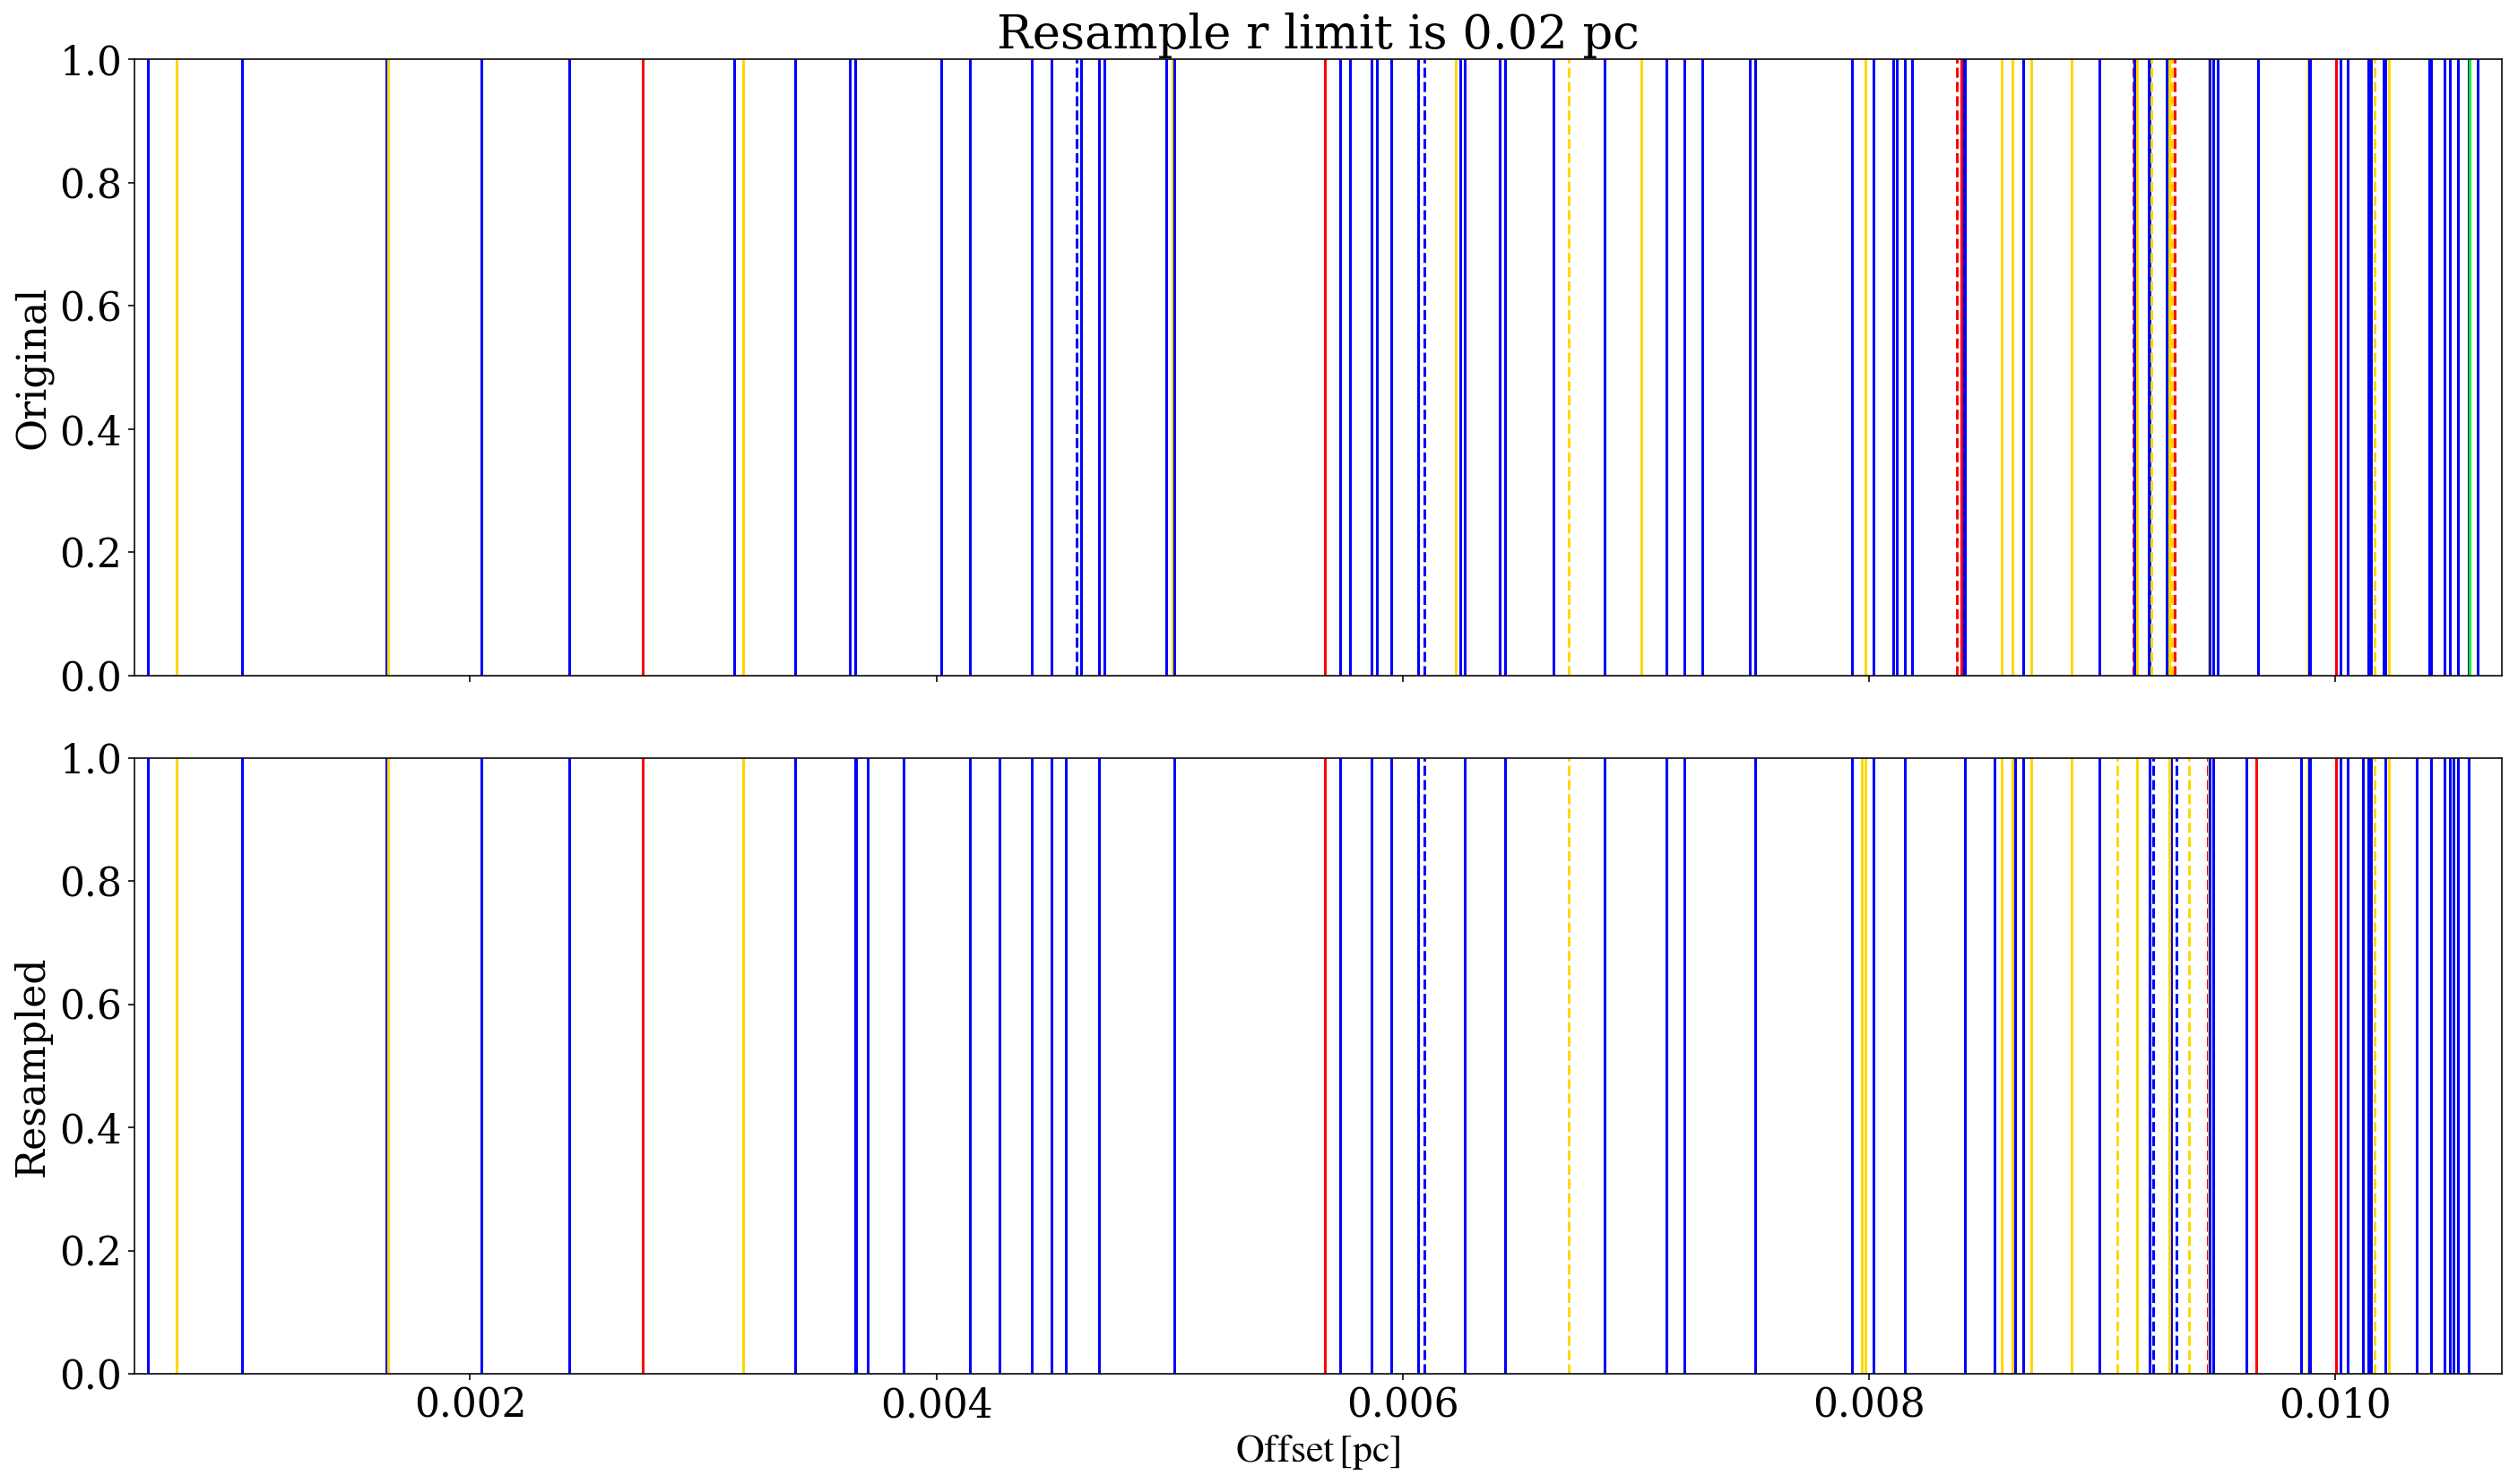

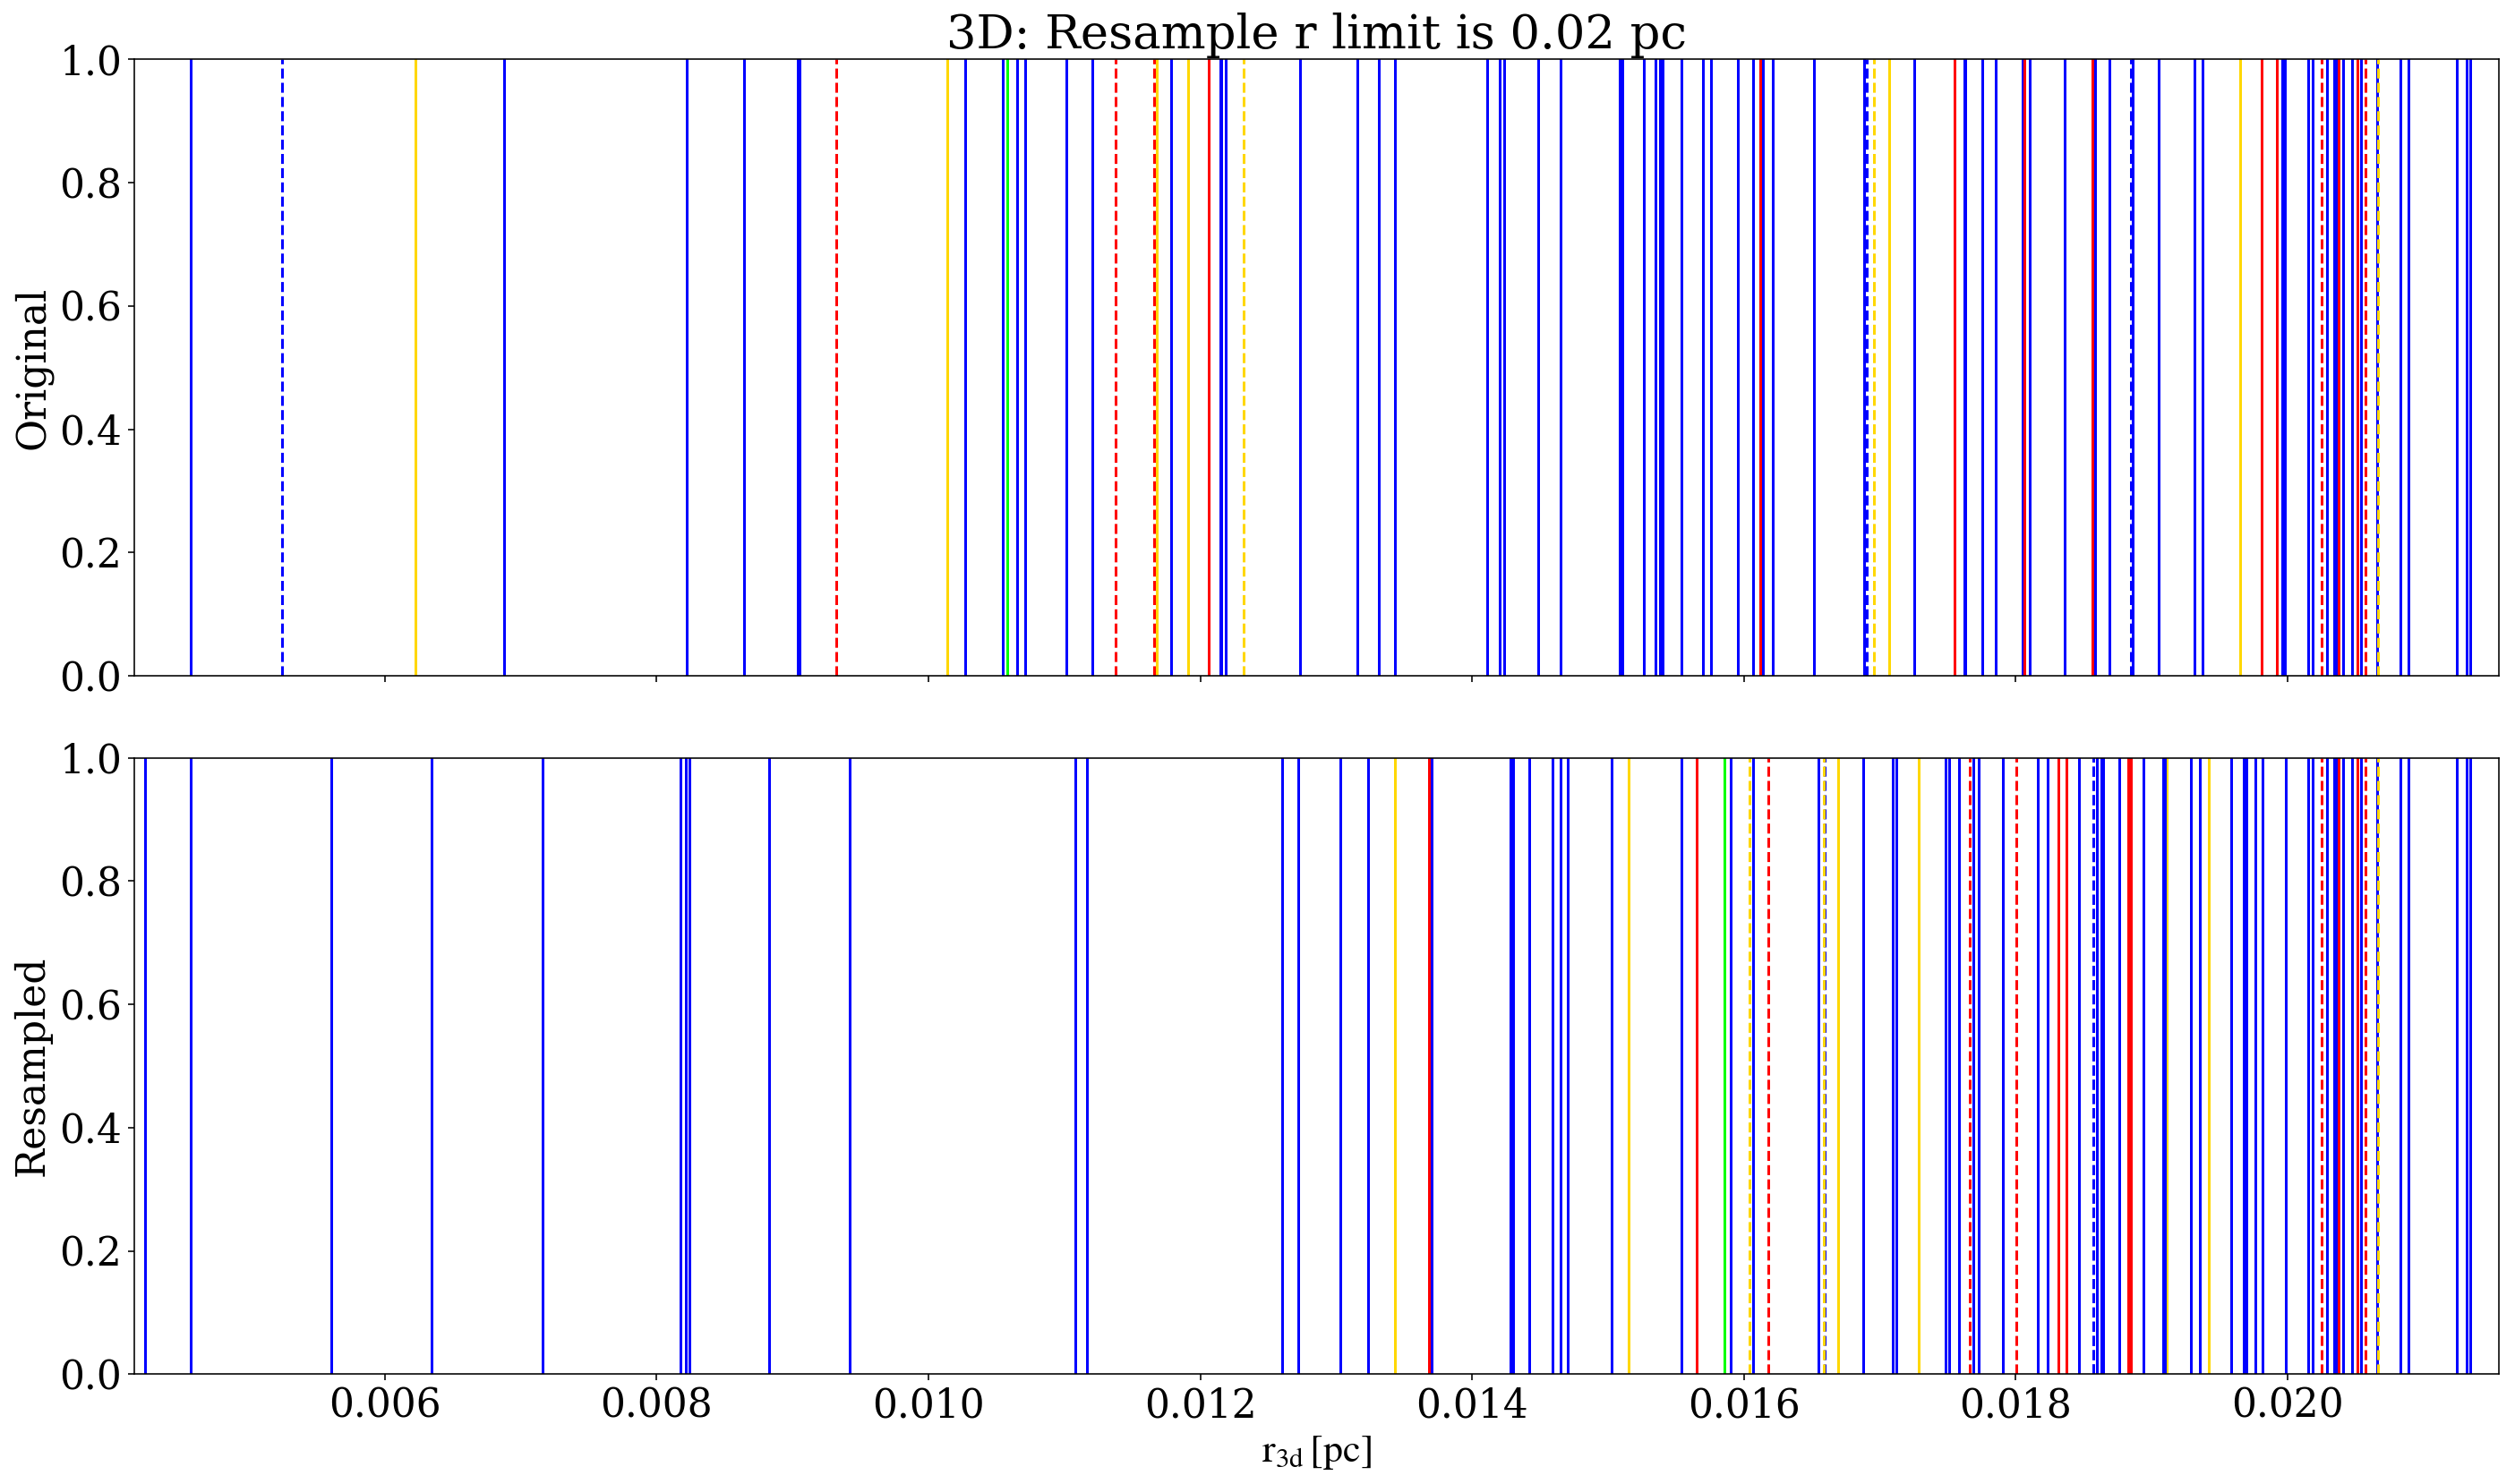

In [11]:
##Radial offset of the innermost 100 objects
r_limit = 0.02
r_pc = [[],[],[]]
rc_pc = []
r_pc_resample = []

for xx in range(9,10):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    
    snap_keys = np.genfromtxt(paths[xx]+'snap_keys.txt', dtype='str')
    snapno = snap_keys[:,0]; snaptime = snap_keys[:,1]
    
    if xx>0:
        snap2d = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
        clus_param = np.sort(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
    else:
        snap2d_unsort=np.array(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
        clus_param_unsort=np.array(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
        snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
        snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
        
        clusno_unsort=[int((x.split('.')[-3]).split('p')[1]) for x in clus_param_unsort]
        clusno, clus_param = zip(*sorted(zip(clusno_unsort,clus_param_unsort)))
        #print(snap2dno,clus_param,snap2d)
        
    for yy in range(len(clus_param)):
        data_param = np.genfromtxt(clus_param[yy])
        if os.stat(clus_param[yy]).st_size==0:
            continue
        if data_param[0][0]>=11900.:
            #print(clus_param[yy], snap2d[yy])
            print(data_param[0][0])
            thesnapno = int(snap2d[yy].split('.')[-4][4:])
            print(thesnapno)
            
            thesnapkey = '/'+snapno[thesnapno]+'(t='+snaptime[thesnapno]+')'
            print(thesnapkey)
            
            snap_h5 = cmct.Snapshot(fname=paths[xx]+'initial.snapshots.h5', snapshot_name=thesnapkey, 
                     conv=paths[xx]+'initial.conv.sh', 
                     dist=4.125, # distance to cluster in kpc
                     z=0.0002)
            
            binflag = np.array(snap_h5.data['binflag'])
            kstar = np.array(snap_h5.data['startype'])
            k0 = np.array(snap_h5.data['bin_startype0']); k1 = np.array(snap_h5.data['bin_startype1'])
            idstar = np.array(snap_h5.data['id'])
            id0 = np.array(snap_h5.data['id0']); id1 = np.array(snap_h5.data['id1'])
            rpc = np.array(snap_h5.data['r'])*l_conv
             
            
            rc_pc.append(float(data_param[0][9]))
            
            count = 0
            with gzip.open(snap2d[yy], 'r') as f2d:
                next(f2d); next(f2d)
                for line in f2d:
                    data2d = line.split()
                    if int(data2d[2])!=1:
                        r_pc[0].append(float(data2d[0]))
                        r_pc[1].append(0)
                        
                        ther3d = rpc[idstar==int(data2d[12])]
                        if ther3d>r_limit:
                            r_pc_resample.append(float(data2d[0]))
                        else:
                            r_pc_resample.append(random_position_3dto2d(r_limit, 1))
                        
                        if int(data2d[3])==14:
                            r_pc[2].append(4)
                        elif int(data2d[3])==13:
                            r_pc[2].append(3)
                        elif 10<=int(data2d[3])<=12:
                            r_pc[2].append(2)
                        elif int(data2d[3])<=1:
                            r_pc[2].append(1)
                        else:
                            r_pc[2].append(0)
                    else:
                        r_pc[0].append(float(data2d[0]))    
                        r_pc[1].append(1)
                        
                        ther3d = rpc[id0==int(data2d[13])]
                        if ther3d>r_limit:
                            r_pc_resample.append(float(data2d[0])) 
                        else:
                            r_pc_resample.append(random_position_3dto2d(r_limit, 1))
                            
                        if int(data2d[5])==14 or int(data2d[6])==14:
                            r_pc[2].append(4)
                        elif int(data2d[5])==13 or int(data2d[6])==13:
                            r_pc[2].append(3)
                        elif 10<=int(data2d[5])<=12 or 10<=int(data2d[6])<=12:
                            r_pc[2].append(2)
                        elif int(data2d[5])<=1 or int(data2d[6])<=1:
                            r_pc[2].append(1)
                        else:
                            r_pc[2].append(0)
                    
                    count+=1
                    if count>100: break
                                
            break
            
print(len(r_pc_resample), len(r_pc[0]))
    
    
####Plotting
cs = ['lime','gold','b','r','k']


rpc_sin = np.array(r_pc[0])[np.array(r_pc[1])==0]; type_sin = np.array(r_pc[2])[np.array(r_pc[1])==0]
rpc_bin = np.array(r_pc[0])[np.array(r_pc[1])==1]; type_bin = np.array(r_pc[2])[np.array(r_pc[1])==1]

fig, axs = plt.subplots(nrows = 2, figsize=(20,12), sharex=True)
for ii in range(len(r_pc[0])):
    if r_pc[1][ii]==0:
        thex = r_pc[0][ii]
        axs[0].axvline(x=thex, color = cs[r_pc[2][ii]], lw=1.5)
    else:
        thex = r_pc[0][ii]
        axs[0].axvline(x=thex, color = cs[r_pc[2][ii]] , ls='--', lw = 1.5)
        
for jj in range(len(r_pc_resample)):
    if r_pc[1][jj]==0:
        thex = r_pc_resample[jj]
        axs[1].axvline(x=thex, color = cs[r_pc[2][jj]], lw=1.5)
    else:
        thex = r_pc_resample[jj]
        axs[1].axvline(x=thex, color = cs[r_pc[2][jj]] , ls='--', lw = 1.5)

#axs[0].set_xscale('log')
#axs[1].set_xscale('log')
axs[0].set_title('Resample r limit is '+str(r_limit)+' pc')
axs[0].set_xlim(xmin = np.min(r_pc[0])/1.1, xmax=np.max(r_pc[0])+0.01*np.max(r_pc[0]))
axs[0].set_ylabel('Original')
#ax.set_ylim(ymin=0.5, ymax=2.5)
#axs[1].set_xlim(xmax = np.max(r_pc[0])*1.1)
axs[1].set_ylabel('Resampled')
axs[1].set_xlabel(r'$\rm{Offset\,[pc]}$')


fig.tight_layout()



##3D radius
r3d_pc = [[],[],[]]; r3d_pc_resample = []
r3d_pc[0] = rpc[:100]
for ii in range(len(r3d_pc[0])):
    if r3d_pc[0][ii]>=r_limit:
        r3d_pc_resample.append(r3d_pc[0][ii])
    else:
        r3d_pc_resample.append(random_position_3d(r_limit, 1))
    if binflag[ii]!=1:
        r3d_pc[1].append(0)
        if kstar[ii]==14:
            r3d_pc[2].append(4)
        elif kstar[ii]==13:
            r3d_pc[2].append(3)
        elif 10<=kstar[ii]<=12:
            r3d_pc[2].append(2)
        elif kstar[ii]<=1:
            r3d_pc[2].append(1)
        else:
            r3d_pc[2].append(0)
    else:
        r3d_pc[1].append(1)
        if k0[ii]==14 or k1[ii]==14:
            r3d_pc[2].append(4)
        elif k0[ii]==13 or k1[ii]==13:
            r3d_pc[2].append(3)
        elif 10<=k0[ii]<=12 or 10<=k1[ii]<=12:
            r3d_pc[2].append(2)
        elif k0[ii]<=1 or k1[ii]<=1:
            r3d_pc[2].append(1)
        else:
            r3d_pc[2].append(0)
                    
fig, axs = plt.subplots(nrows = 2, figsize=(20,12), sharex=True)
for ii in range(len(r3d_pc[0])):
    if r3d_pc[1][ii]==0:
        thex = r3d_pc[0][ii]
        axs[0].axvline(x=thex, color = cs[r3d_pc[2][ii]], lw=1.5)
    else:
        thex = r3d_pc[0][ii]
        axs[0].axvline(x=thex, color = cs[r3d_pc[2][ii]] , ls='--', lw = 1.5)
        
for jj in range(len(r3d_pc_resample)):
    if r3d_pc[1][jj]==0:
        thex = r3d_pc_resample[jj]
        axs[1].axvline(x=thex, color = cs[r3d_pc[2][jj]], lw=1.5)
    else:
        thex = r3d_pc_resample[jj]
        axs[1].axvline(x=thex, color = cs[r3d_pc[2][jj]] , ls='--', lw = 1.5)

print(np.min(r3d_pc[0]), np.max(r3d_pc[0]), r3d_pc[0])
#axs[0].set_xscale('log')
#axs[1].set_xscale('log')
axs[0].set_title('3D: Resample r limit is '+str(r_limit)+' pc')
axs[0].set_xlim(xmin = np.min(r3d_pc[0])/1.1, xmax=np.max(r3d_pc[0])+0.01*np.max(r3d_pc[0]))
axs[0].set_ylabel('Original')
#ax.set_ylim(ymin=0.5, ymax=2.5)
#axs[1].set_xlim(xmax = np.max(r_pc[0])*1.1)
axs[1].set_ylabel('Resampled')
axs[1].set_xlabel(r'$\rm{r_{3d}\,[pc]}$')


fig.tight_layout()


/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_wdmass_qcrit4/
940
33
[5.04800413]
[13] [14]
1350
central binaries b [2.0955  2.11829 1.33492 1.41169 2.24729 1.47603 2.28201 2.3455  2.26672
 2.12044 1.43234 1.84855 1.32612 2.21798 1.44486 1.65571 2.46878 1.80654
 2.11587 2.04965 1.32724 1.35136 2.14963 1.50491 2.35326 2.15952 1.3234
 2.38636 1.73457 1.93689 2.06097 1.41228 1.32445 2.08874 1.25539 1.9999
 1.63387 1.88246 1.24929 1.70783 1.40571 1.29919 2.01233 1.32344 1.36152
 1.37259 1.31926 1.27843] [1.25011  1.26078  0.00922  0.607325 1.01097  1.15379  0.009653 1.0132
 0.862762 2.99641  0.799708 1.0292   0.799769 0.008931 1.26408  1.03563
 0.007927 0.986221 0.636436 1.32724  2.04965  0.006025 0.819283 1.21554
 2.15952  2.35326  0.007971 0.756231 0.932386 1.24308  3.42961  1.32874
 0.008041 0.487823 1.27482  0.004107 1.37654  0.626314 0.343464 0.008559
 0.875421 0.75949  3.11591  1.08917  

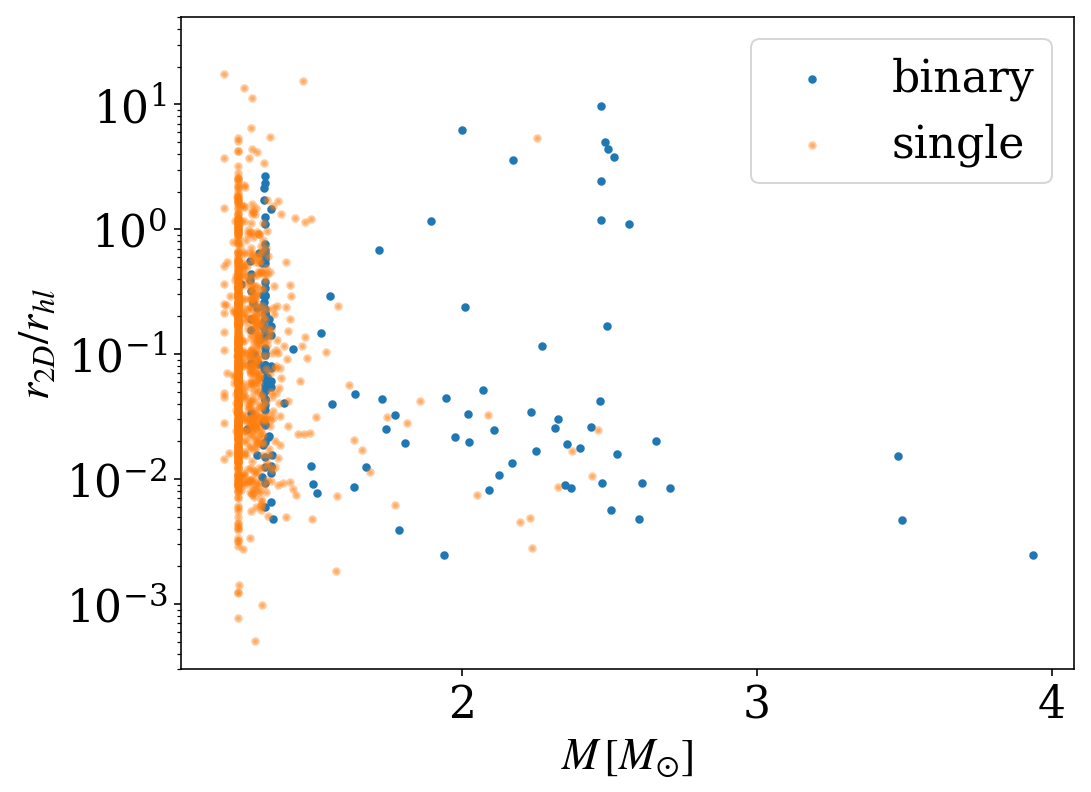

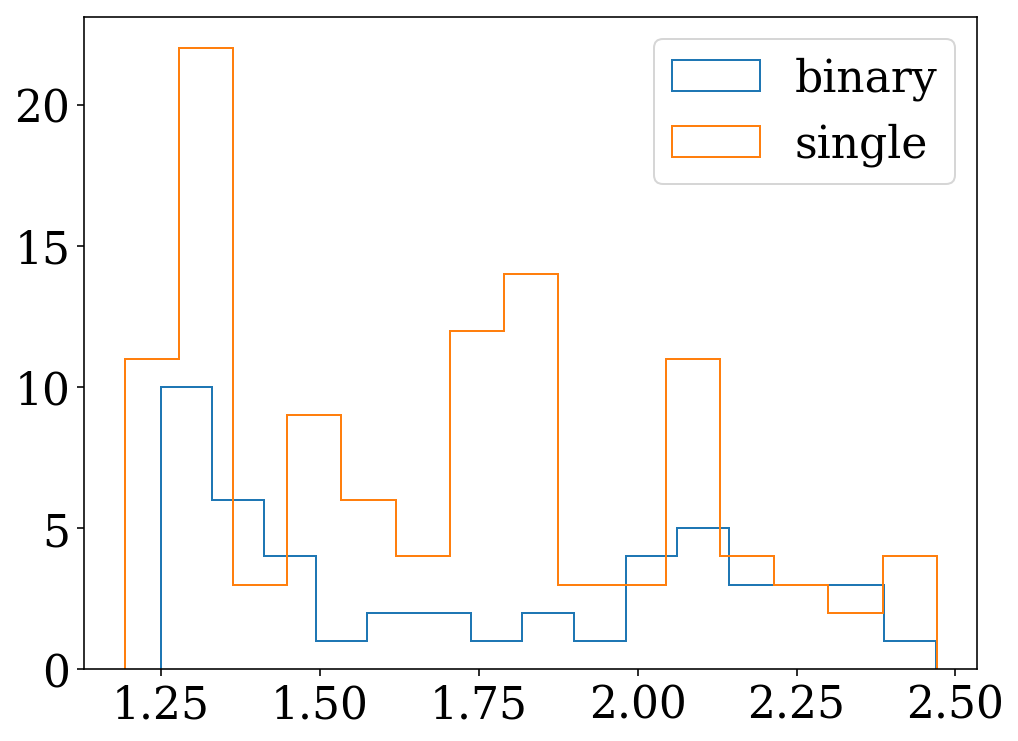

In [11]:
##Scatter plot of NS mass and radius distribution
print(paths[17])
snaps = cmct.Snapshot(fname=paths[17]+'initial.snapshots.h5', snapshot_name='/433(t=18.036804)', 
                      conv=paths[17]+'initial.conv.sh', 
                      dist=4.125, # distance to cluster in kpc
                      z=0.0002)
l_conv = dyn.conv('l', paths[17]+'initial.conv.sh')

binflag = np.array(snaps.data['binflag'])
ktype=np.array(snaps.data['startype'])
k0 = np.array(snaps.data['bin_startype0']); k1 = np.array(snaps.data['bin_startype1'])
rpc = np.array(snaps.data['r'])*l_conv
Mtot= np.array(snaps.data['m_MSUN'])

mns_sin = Mtot[ktype==13]
mns_bin = Mtot[(k0==13) | (k1==13)]
rpc_sin = rpc[ktype==13]
rpc_bin = rpc[(k0==13) | (k1==13)]
print(len(mns_sin))
print(len(mns_bin))
print(mns_bin[mns_bin>5])
print(k0[(Mtot>5.) & ((k0==13) | (k1==13))], k1[(Mtot>5.) & ((k0==13) | (k1==13))])


#fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(mns_bin, rpc_bin, 
#           s=5, lw=2, alpha=1.0, label='binary')
#ax.scatter(mns_sin, rpc_sin, 
#           s=5, lw=2, alpha=0.4, label='single')
#ax.set_ylabel(r'$r\,[\rm{pc}]$')
#ax.set_xlabel(r'$M\,[M_{\odot}]$')
#ax.set_yscale('log')
##ax.set_xscale('log')
#ax.legend(loc='best')

##Scatter plot of only pulsar mass and radius distribution
data_psr = np.genfromtxt(savepath+'model_offsets_psr1sec_12Gyr.dat')
r_rhl = data_psr[:,5]; m0 = data_psr[:,7]; m1 = data_psr[:,8]
model_no = data_psr[:,0].astype(np.int)
k0 = data_psr[:,9]; k1 = data_psr[:,10]
ID0 = data_psr[:,11]; ID1 = data_psr[:,12]
r_rhl_b = r_rhl[model_no>=9]
m0_b = m0[model_no>=9]; m1_b = m1[model_no>=9]
mtot_b = m0_b+m1_b
k0_b = k0[model_no>=9]; k1_b = k1[model_no>=9]
ID0_b = ID0[model_no>=9]; ID1_b = ID1[model_no>=9]
print(len(mtot_b))

r_rhl_a = r_rhl[model_no<9]
m0_a = m0[model_no<9]; m1_a = m1[model_no<9]
mtot_a = m0_a+m1_a
k0_a = k0[model_no<9]; k1_a = k1[model_no<9]
ID0_a = ID0[model_no<9]; ID1_a = ID1[model_no<9]

fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(mtot_b[m1_b>0], r_rhl_b[m1_b>0], 
#           s=5, lw=2, alpha=1.0, label='binary')
#ax.scatter(mtot_b[m1_b==0], r_rhl_b[m1_b==0],
#           s=5, lw=2, alpha=0.4, label='single')

ax.scatter(mtot_a[m1_a>0], r_rhl_a[m1_a>0], 
           s=5, lw=2, alpha=1.0, label='binary')
ax.scatter(mtot_a[m1_a==0], r_rhl_a[m1_a==0],
           s=5, lw=2, alpha=0.4, label='single')

ax.set_ylabel(r'$r_{2D}/r_{hl}$')
ax.set_xlabel(r'$M\,[M_{\odot}]$')
ax.set_ylim(ymin=0.0003, ymax=50)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc='best')

################################################################################
##Check what are the most concerntrated NSs
r_limit = 0.01
print('central binaries b', m0_b[(m1_b>0) & (r_rhl_b<=r_limit)], m1_b[(m1_b>0) & (r_rhl_b<=r_limit)])
print('central binaries b', k0_b[(m1_b>0) & (r_rhl_b<=r_limit)], k1_b[(m1_b>0) & (r_rhl_b<=r_limit)])
print('central singles b', m0_b[(m1_b==0) & (r_rhl_b<=r_limit)])

print('central binaries a', m0_a[(m1_a>0) & (r_rhl_a<=r_limit)], m1_a[(m1_a>0) & (r_rhl_a<=r_limit)])
print('central binaries a', k0_a[(m1_a>0) & (r_rhl_a<=r_limit)], k1_a[(m1_a>0) & (r_rhl_a<=r_limit)])
print('central singles a', m0_a[(m1_a==0) & (r_rhl_a<=r_limit)])

fig, axs = plt.subplots(figsize=(8,6))
axs.hist(m0_b[(m1_b>0) & (r_rhl_b<=r_limit)], bins=15, histtype='step', label='binary')
axs.hist(m0_b[(m1_b==0) & (r_rhl_b<=r_limit)], bins=15, histtype='step', label='single')
axs.legend(loc='best')

ID0_cen = ID0[r_rhl<=r_limit]; ID1_cen = ID1[r_rhl<=r_limit]
model_no_cen = model_no[r_rhl<=r_limit]
n_wdwd_cen = 0; n_tde_cen = 0
flag_wdwd = []
for xx in range(len(ID0_cen)):
    if model_no_cen[xx]>=9:
        themodel = model_no_cen[xx]
        if ID0_cen[xx] in id_wdwdcol_all[themodel] or ID0_cen[xx] in id_wdwdmer_all[themodel]:
            n_wdwd_cen+=1
        elif ID0_cen[xx] in idtde_msp_all[themodel]:
            n_tde_cen+=1
            
        if ID0_cen[xx] in id_wdwdcol_all[themodel]:
            #print(np.array(id_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]])
            flag_wdwd.append(np.array(type_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==ID0_cen[xx]][0])
        elif ID0_cen[xx] in id_wdwdmer_all[themodel]:
            flag_wdwd.append(np.array(type_wdwdmer_all[themodel])[np.array(id_wdwdmer_all[themodel])==ID0_cen[xx]][0])
        elif ID0_cen[xx] in idtde_msp_all[themodel]:
            flag_wdwd.append('tde')
        else:
            flag_wdwd.append(0)
            
flag_wdwd = np.array(flag_wdwd)
print('wdwd', n_wdwd_cen, 'tde', n_tde_cen, 'CO+CO', len(flag_wdwd[flag_wdwd=='1111']), 
      'tot', len(ID0_b[r_rhl_b<=r_limit])) 
print(flag_wdwd)

flag_wdwd_all = []
for xx in range(len(ID0)):
    themodel = model_no[xx]

    if ID0[xx] in id_wdwdcol_all[themodel]:
        flag_wdwd_all.append(np.array(type_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==ID0[xx]][0])
    elif ID0[xx] in id_wdwdmer_all[themodel]:
        flag_wdwd_all.append(np.array(type_wdwdmer_all[themodel])[np.array(id_wdwdmer_all[themodel])==ID0[xx]][0])
    elif ID0[xx] in idtde_msp_all[themodel]:
        flag_wdwd_all.append('tde')
    else:
        flag_wdwd_all.append(0)
        
flag_wdwd_all = np.array(flag_wdwd_all)
print(len(flag_wdwd_all[(model_no>=9) & (m0>=2.3)]), 
      len(flag_wdwd_all[(model_no>=9) & (flag_wdwd_all=='tde') & (m0>=2.3)]), 
      len(flag_wdwd_all[(model_no>=9) & (flag_wdwd_all=='0')  & (m0>=2.3)]))
print(len(m0_b), len(m0_b[m0_b>=2.3]))

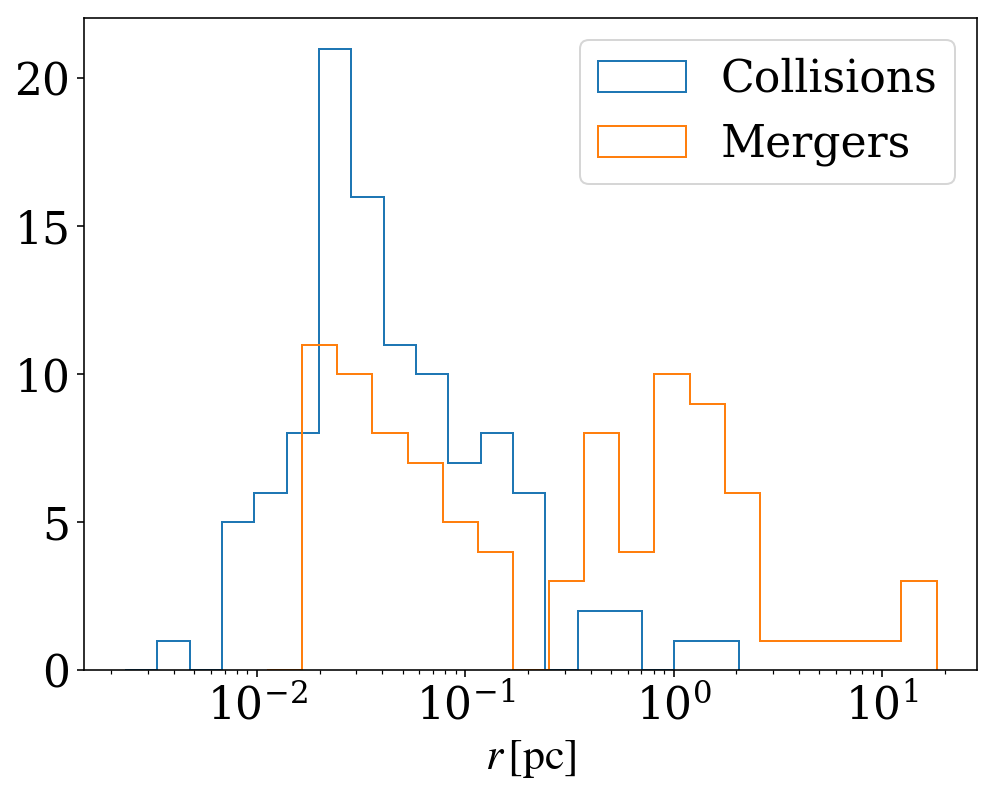

In [14]:
##Location of WD-WD collisions or mergers
ns_wdwd_col = np.genfromtxt(paths[17]+'ns_wdwd_coll.dat')
ns_wdwd_mer = np.genfromtxt(paths[17]+'ns_wdwd_merger.dat')

rpc_coll = ns_wdwd_col[:,3]
rpc_mer = ns_wdwd_mer[:,3]

fig, axs = plt.subplots(figsize=(8,6))
axs.hist(rpc_coll, 
         bins = np.logspace(np.log10(np.min(rpc_coll)), np.log10(np.max(rpc_coll)), 20),
         histtype='step', label='Collisions')
axs.hist(rpc_mer,
         bins = np.logspace(np.log10(np.min(rpc_mer)), np.log10(np.max(rpc_mer)), 20),
         histtype='step', label='Mergers')
axs.set_xscale('log')
axs.set_xlabel(r'$r\,[\rm{pc}]$')
axs.legend(loc='best')

2.162265577864508


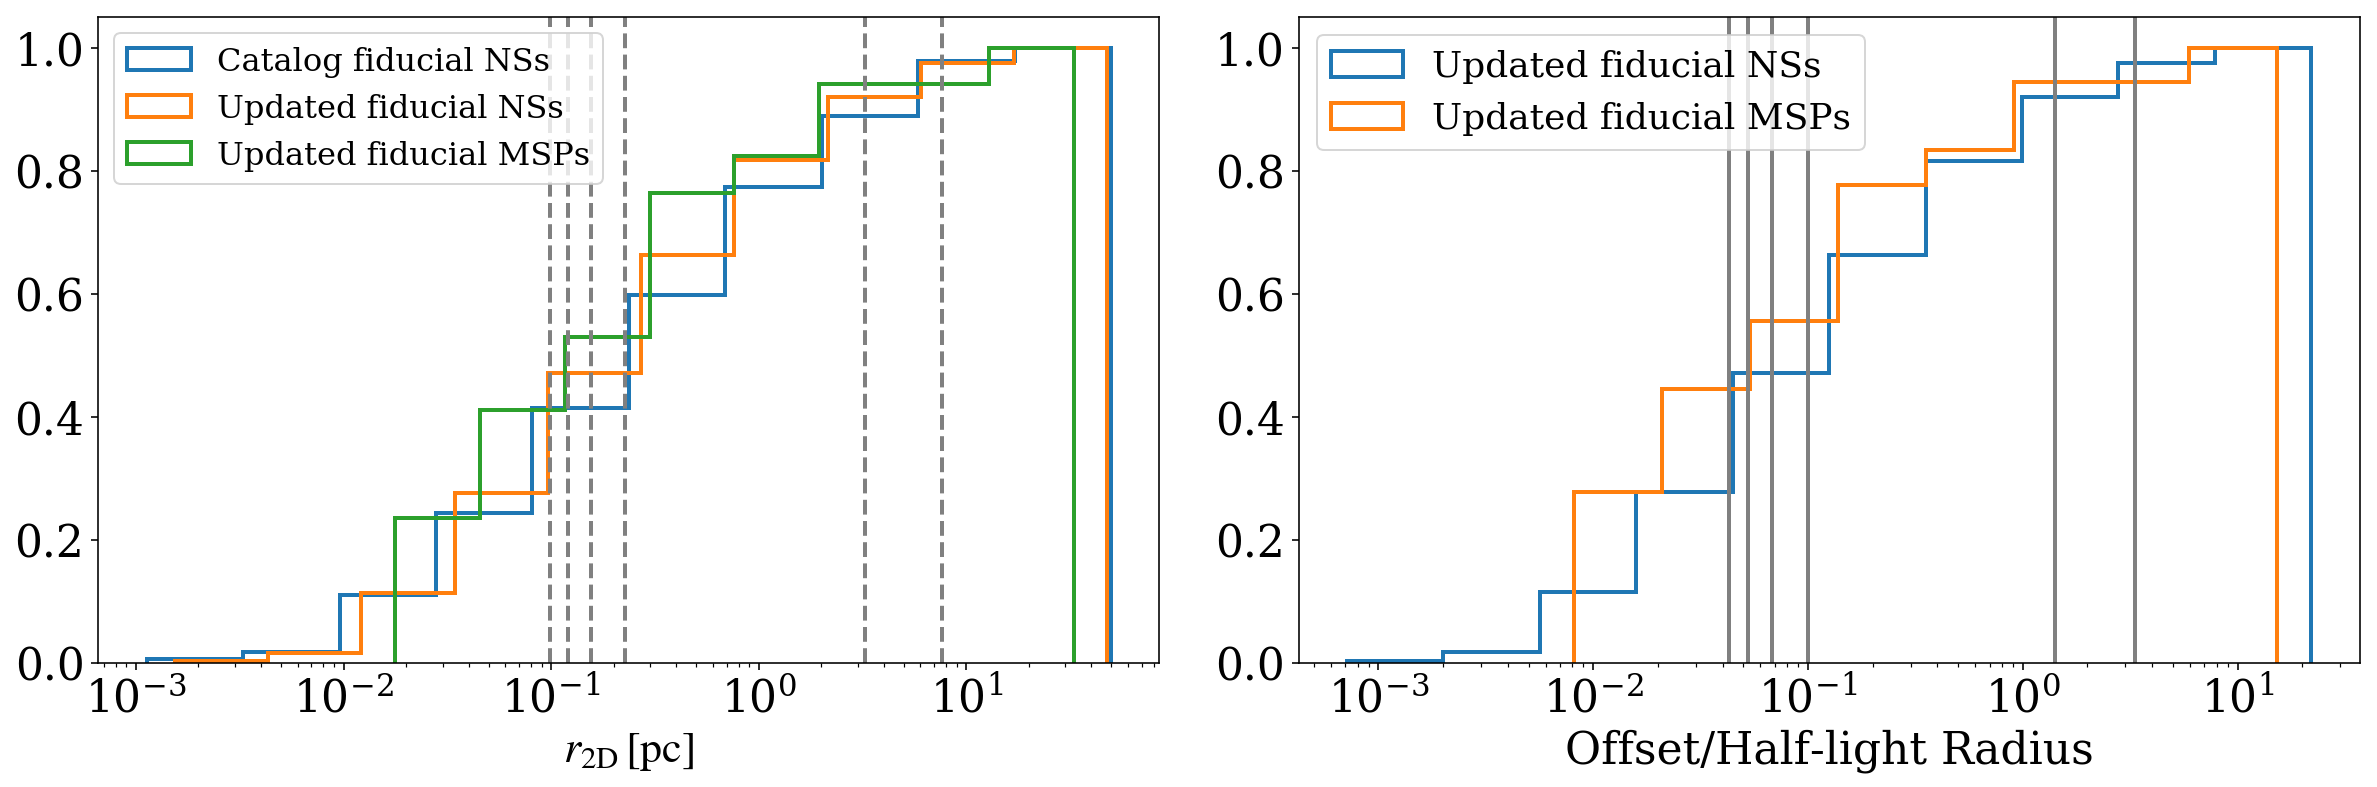

In [44]:
##Double checking model offset using catalog models
snap2d_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/initial.snap0571.2Dproj.dat.gz'
clus_param_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/initial.snap0571.cluster_params.dat'
data_param_old = np.genfromtxt(clus_param_old)
rhl_old = float(data_param_old[0][10])
snap2d_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/initial.snap488.2Dproj.dat.gz'
clus_param_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/initial.snap488.cluster_params.dat'
data_param_new = np.genfromtxt(clus_param_new)
rhl_new = float(data_param_new[0][10])
print(rhl_new)
MSPs = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/MSP488.dat')
idmsps = MSPs[:,10].astype(np.int)

##Observations
##Observed name and offsets
psrnames = ['PSRA','PSRB','PSRC','PSRD','PSRE','PSRF']
psroffsets_pc = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/60*np.pi/180.*4125 ##pc
psroffsets_rhl = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])/1.91

allNSs = []
with gzip.open(snap2d_old, 'r') as fsnap2d:
    next(fsnap2d); next(fsnap2d)
    for line in fsnap2d:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3])==13:
                allNSs.append(float(data[0]))
        else:
            if int(data[5])==13:
                allNSs.append(float(data[0]))
            elif int(data[6])==13:
                allNSs.append(float(data[0]))
                
allNSs_new = []; allMSPs_new = []
with gzip.open(snap2d_new, 'r') as fsnap2d_new:
    next(fsnap2d_new); next(fsnap2d_new)
    for line in fsnap2d_new:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3])==13:
                allNSs_new.append(float(data[0]))
                if int(data[12]) in idmsps:
                    allMSPs_new.append(float(data[0]))
                    
        else:
            if int(data[5])==13:
                allNSs_new.append(float(data[0]))
                if int(data[13]) in idmsps:
                    allMSPs_new.append(float(data[0]))
            elif int(data[6])==13:
                allNSs_new.append(float(data[0]))
                if int(data[14]) in idmsps:
                    allMSPs_new.append(float(data[0]))
                
offratio_old = np.array(allNSs)/rhl_old
offratio_new = np.array(allNSs_new)/rhl_new
offratio_msp = np.array(allMSPs_new)/rhl_new

                
fig, axs = plt.subplots(ncols = 2, figsize=(17,6))
axs[0].hist(allNSs,
         bins = np.logspace(np.log10(np.min(allNSs)), np.log10(np.max(allNSs)), 11),
         cumulative=True, density=True, stacked=True,
         histtype='step', lw=2, label='Catalog fiducial NSs')
axs[0].hist(allNSs_new,
         bins = np.logspace(np.log10(np.min(allNSs_new)), np.log10(np.max(allNSs_new)), 11),
         cumulative=True, density=True, stacked=True,
         histtype='step', lw=2, label = 'Updated fiducial NSs')
axs[0].hist(allMSPs_new,
         bins = np.logspace(np.log10(np.min(allMSPs_new)), np.log10(np.max(allMSPs_new)), 9),
         cumulative=True, density=True, stacked=True,
         histtype='step', lw=2, label = 'Updated fiducial MSPs')
[axs[0].axvline(_x, lw = 2., color = 'gray', ls='--') for _x in psroffsets_pc]
axs[0].set_xlabel(r'$r_{\rm{2D}}\,[\rm{pc}]$')
axs[0].set_xscale('log')
axs[0].legend(loc='upper left', fontsize=16)

#axs[1].hist(offratio_old,
#         bins = np.logspace(np.log10(np.min(offratio_old)), np.log10(np.max(offratio_old)), 11),
#         cumulative=True, density=True, stacked=True,
#         histtype='step', lw=2, label='Catalog fiducial')
axs[1].hist(offratio_new,
         bins = np.logspace(np.log10(np.min(offratio_new)), np.log10(np.max(offratio_new)), 11),
         cumulative=True, density=True, stacked=True,
         histtype='step', lw=2, label = 'Updated fiducial NSs')
axs[1].hist(offratio_msp,
         bins = np.logspace(np.log10(np.min(offratio_msp)), np.log10(np.max(offratio_msp)), 9),
         cumulative=True, density=True, stacked=True,
         histtype='step', lw=2, label = 'Updated fiducial MSPs')
[axs[1].axvline(_x, lw = 2., color = 'gray') for _x in psroffsets_rhl]
axs[1].set_xlabel('Offset/Half-light Radius')
axs[1].set_xscale('log')
axs[1].legend(loc='upper left', fontsize=18)


fig.tight_layout()

272
140
6.39
6.39 140
38
[0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36
 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.09 0.37 0.37 0.44 0.44
 0.44 1.16 0.62 0.62 0.62 0.62 0.62 0.62 0.22 0.22 0.22 0.22 0.22 0.22
 0.05 0.05 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.14 0.14 0.14
 0.14 0.14 0.14 0.14 0.14 0.13 0.13 0.13 0.13 0.06 0.06 0.06 0.06 0.05
 0.38 0.05 0.05 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.24 0.24 0.24 0.24
 0.24 0.24 0.24 0.24 0.24 0.24 0.24 0.1  1.33 1.33 0.17 0.17 0.17 0.17
 0.17 0.17 0.34 0.34 0.63 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.06] ['104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104'
 '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '104' '1851'
 '5272' '5272' '5904' '5904' '5904' '6121' '6205' '6205' '6205' '6205'
 '6205' '6205' '6266' '6266' '6266' '6266' '62

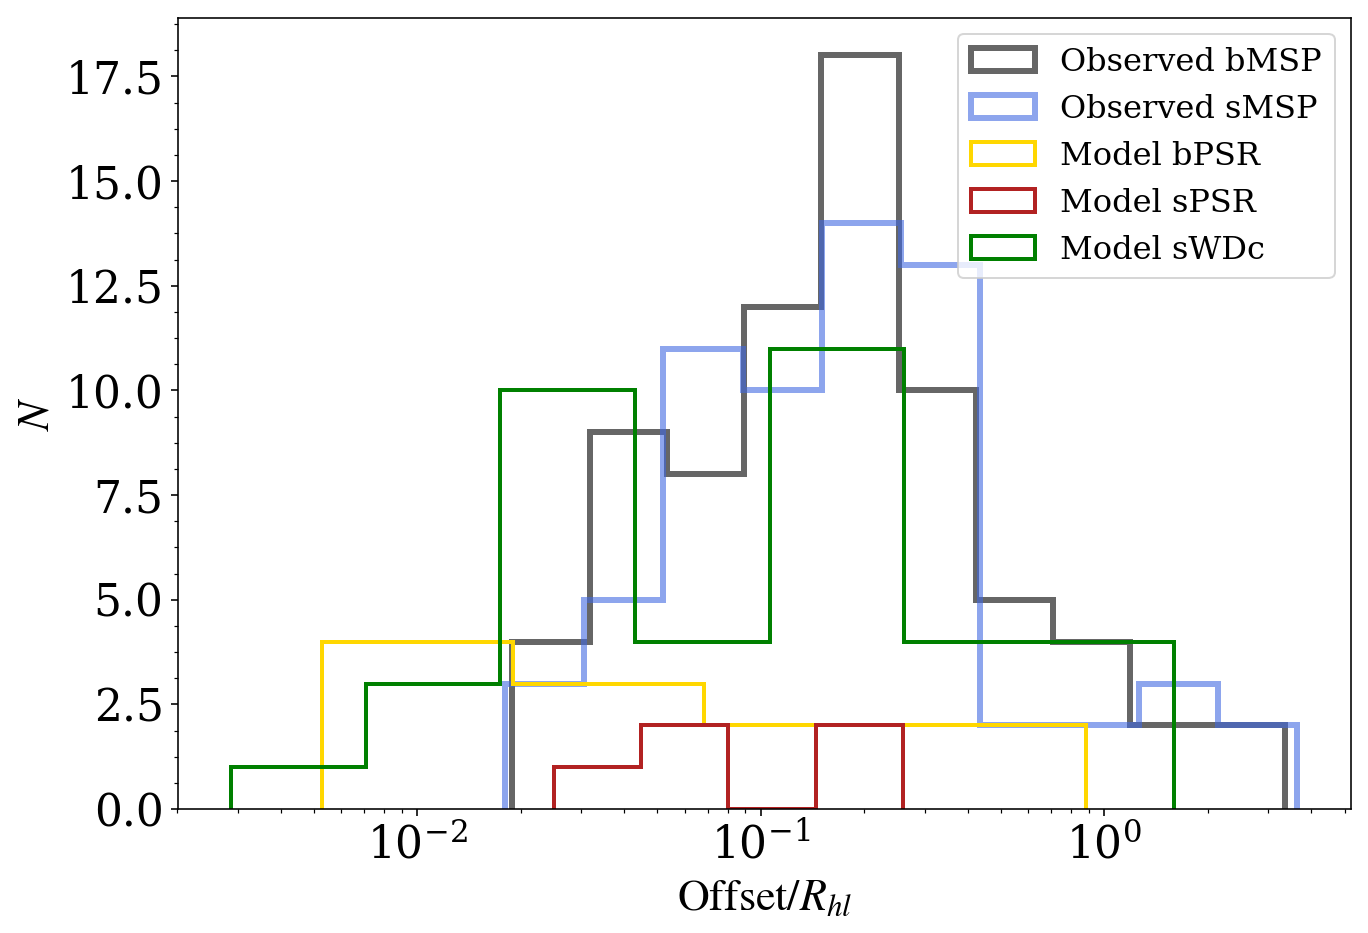

In [11]:
####Offset Distributions
##Observed psr and WD-WD coalscence remnant offset distributions
Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire(spinflag=0,offsetflag=1)
print(len(Clusoff))
print(np.max(Offset))
Offset=np.array(Offset); Binoff = np.array(Binoff)
Poff = np.array(Poff); Clusoff = np.array(Clusoff)
#Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]
print(np.max(Offset), len(Clusoff))

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
print(len(rc_psrcat))
CCst = data_gcmsp['cc'].values
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

Rcoff = []; Rhloff = []
for kk in range(len(Clusoff)):
    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0]) 
Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)

print(Rcoff, Clusoff)

binoffrc = (Offset/Rcoff)[Binoff==1]
sinoffrc = (Offset/Rcoff)[Binoff==0]
binoffrhl = (Offset/Rhloff)[Binoff==1]
sinoffrhl = (Offset/Rhloff)[Binoff==0]
nobs_bin = len(binoffrhl)
nobs_sin = len(sinoffrhl)
print(nobs_bin, nobs_sin)



data_model = np.genfromtxt(savepath+'model_offsets_psr1sec_12Gyr.dat')
modelrhl = data_model[:,3]
#allmodeloffrc = data_model[:,4]; allmodeltypes = data_model[:,6]
#modelsinoffrc = allmodeloffrc[allmodeltypes==1]
#modelbinoffrc = allmodeloffrc[allmodeltypes==2]
#modelsinwdoffrc = allmodeloffrc[allmodeltypes==3]
#modelbinwdoffrc = allmodeloffrc[allmodeltypes==4]
#print(len(modelsinoffrc), len(modelsinwdoffrc), len(modelbinoffrc), len(modelbinwdoffrc))

allmodeloffrhl = data_model[:,5]; allmodeltypes = data_model[:,6]
allmodenos = data_model[:,0]
modelsinoffrhl = allmodeloffrhl[(allmodeltypes==1) & (allmodenos==0)]
modelbinoffrhl = allmodeloffrhl[(allmodeltypes==2) & (allmodenos==0)]
modelsinwdoffrhl = allmodeloffrhl[(allmodeltypes==3) & (allmodenos==0)]
modelbinwdoffrhl = allmodeloffrhl[(allmodeltypes==4) & (allmodenos==0)]
print(len(modelsinoffrhl), len(modelsinwdoffrhl), len(modelbinoffrhl), len(modelbinwdoffrhl),)


####Plotting
fig, ax = plt.subplots(figsize=(10,7))
#ax.hist(binoffrc, 
#        bins = np.logspace(np.log10(np.min(binoffrc)), np.log10(np.max(binoffrc)), bin_no+1),
#        histtype='step', label = 'Observed bMSP', lw=3, color='k', alpha=0.6)
#ax.hist(sinoffrc,
#        bins = np.logspace(np.log10(np.min(sinoffrc)), np.log10(np.max(sinoffrc)), bin_no+1),
#        histtype='step', label = 'Observed sMSP', lw=3, color='royalblue', alpha=0.6)
ax.hist(binoffrhl, 
        bins = np.logspace(np.log10(np.min(binoffrhl)), np.log10(np.max(binoffrhl)), bin_no+1),
        histtype='step', label = 'Observed bMSP', lw=3, color='k', alpha=0.6)
ax.hist(sinoffrhl,
        bins = np.logspace(np.log10(np.min(sinoffrhl)), np.log10(np.max(sinoffrhl)), bin_no+1),
        histtype='step', label = 'Observed sMSP', lw=3, color='royalblue', alpha=0.6)
ax.hist(modelbinoffrhl, 
        bins = np.logspace(np.log10(np.min(modelbinoffrhl)), np.log10(np.max(modelbinoffrhl)), 5),
        histtype = 'step', color = 'gold', lw = 2, label = 'Model bPSR')
ax.hist(modelsinoffrhl,
        bins = np.logspace(np.log10(np.min(modelsinoffrhl)), np.log10(np.max(modelsinoffrhl)), 5),
        histtype='step',color = 'firebrick', lw = 2, label = 'Model sPSR')
ax.hist(modelsinwdoffrhl,
        bins = np.logspace(np.log10(np.min(modelsinwdoffrhl)), np.log10(np.max(modelsinwdoffrhl)), 8),
        histtype='step',color = 'green', lw = 2, label = 'Model sWDc')

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Offset}/\mathit{R_{hl}}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='best', fontsize=16)

fig.tight_layout()
#plt.savefig(savepath+'offsets.pdf', dpi=300)

272
272 272
2497.7869
1.8901 2497.7869
Ks_2sampResult(statistic=0.34847512038523276, pvalue=9.650032990862479e-05)
0.5102420000000001 0.408094


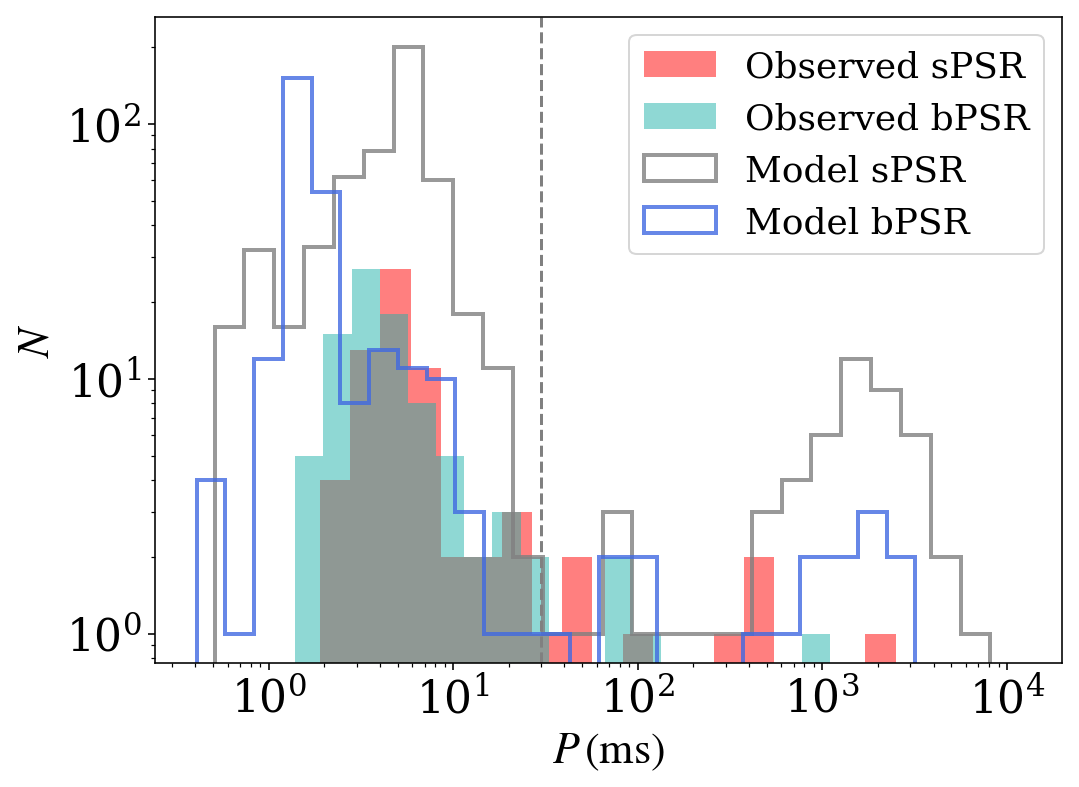

In [8]:
###Spin period distributions
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(max(Pall))

Psin_obs=[]; Pbin_obs=[]
#for i in range(len(Bfall)):
#    if Bfall[i]==0:
#        Psin_obs.append(Pall[i])
#    else:
#        Pbin_obs.append(Pall[i])
for ii in range(len(Binflag)):
    if Binflag[ii]==0:
        Psin_obs.append(P[ii])
    else:
        Pbin_obs.append(P[ii])

print(min(Psin_obs), max(Psin_obs))
Psin_obs = np.array(Psin_obs); Pbin_obs = np.array(Pbin_obs)
##K-S test to check if the two distributions are statistically different.
from scipy import stats
print(stats.ks_2samp(Psin_obs, Pbin_obs))


##Models
allspin_sinpsr = []; allspin_binpsr = []
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    id_coll = wdwd_coll_file[:,2].astype(np.int)
   
    wdwd_mer_file = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    id_mer = wdwd_mer_file[:,2].astype(np.int)

    
    IDsin = []; Psin = []
    IDbin = []; Pbin = []
    IDsin_coll = []; IDbin_coll = []
    IDsin_mer = []; IDbin_mer = [] 
    
    timestep_old=14000.
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv < 12000.:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                IDsin = np.array(IDsin); Psin = np.array(Psin)
                IDbin = np.array(IDbin); Pbin = np.array(Pbin)
                IDsin_msp = IDsin[Psin<=0.03]
                IDbin_msp = IDbin[Pbin<=0.03]
                allspin_sinpsr = allspin_sinpsr+list(Psin)
                allspin_binpsr = allspin_binpsr+list(Pbin)
                
                break
                
            if int(data[2])!=1:
                if int(data[3]) in id_coll:
                    IDsin_coll.append(int(data[3]))
                if int(data[3]) in id_mer:
                    IDsin_mer.append(int(data[3]))
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDsin.append(int(data[3]))
                    Psin.append(float(data[9]))
            else:
                if int(data[3]) in id_coll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                if int(data[3]) in id_mer and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDbin.append(int(data[3]))
                    Pbin.append(float(data[9]))
                    
                if int(data[4]) in id_coll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                if int(data[4]) in id_mer and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    IDbin.append(int(data[4]))
                    Pbin.append(float(data[10]))
                    
            timestep_old = timestep
            
allspin_sinpsr = np.array(allspin_sinpsr)*1000.
allspin_binpsr = np.array(allspin_binpsr)*1000.
print(np.min(allspin_sinpsr), np.min(allspin_binpsr))

fig, axs = plt.subplots(figsize=(8,6))
axs.hist(Psin_obs, bins=np.logspace(np.log10(min(Psin_obs)),np.log10(max(Psin_obs)), 20), align='mid',
         alpha=0.5, lw=3, color = 'red', label='Observed sPSR')
axs.hist(Pbin_obs, bins=np.logspace(np.log10(min(Pbin_obs)),np.log10(max(Pbin_obs)+100), 20), align='mid',
         alpha=0.5, lw=3, color = 'lightseagreen', label='Observed bPSR')
axs.hist(allspin_sinpsr,
        bins = np.logspace(np.log10(min(allspin_sinpsr)), np.log10(max(allspin_sinpsr)),28),
        align='mid', alpha = 0.8, histtype='step', lw=2, color = 'gray', label = 'Model sPSR')
axs.hist(allspin_binpsr,
        bins = np.logspace(np.log10(min(allspin_binpsr)), np.log10(max(allspin_binpsr)),28),
        align='mid', alpha = 0.8, histtype='step', lw=2, color = 'royalblue', label = 'Model bPSR')
axs.axvline(x=30, ls='--', color='gray')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'$P\,(\rm{ms})$')
axs.set_ylabel(r'$N$')
axs.legend(loc='best', fontsize=18)
fig.tight_layout()

plt.savefig(savepath+'spin_periods.pdf', dpi=300)

280
280 280 128
0
12042.430721120001
[] [] [] [] []
1
12022.0586512
[] [] [] [] []
2
12032.10566912
[] [] [] [] []
3
12030.7235968
[1308046] [1.0108049] [0.11215106] [0.07786032] [11]
4
12027.06393948
[] [] [] [] []
5
12022.68085368
[] [] [] [] []
6
12026.16707712
[] [] [] [] []
7
12029.81796152
[] [] [] [] []
8
12060.913239040001
[] [] [] [] []
9
12045.74351068
[] [] [] [] []
10
12033.24682356
[] [] [] [] []
11
12064.32320556
[] [] [] [] []
12
12026.951241199999
[] [] [] [] []
13
12027.91018884
[] [] [] [] []
14
12023.8874676
[] [] [] [] []
15
12013.70480684
[] [] [] [] []
16
12072.955758840002
[] [] [] [] []
17
12027.420254999999
[] [] [] [] []
23
J1701-3006B
J1701-3006C
J1701-3006E
J1701-3006F
B1718-19
J1807-2459A
J1823-3021F
B2127+11C
J2140-2310A


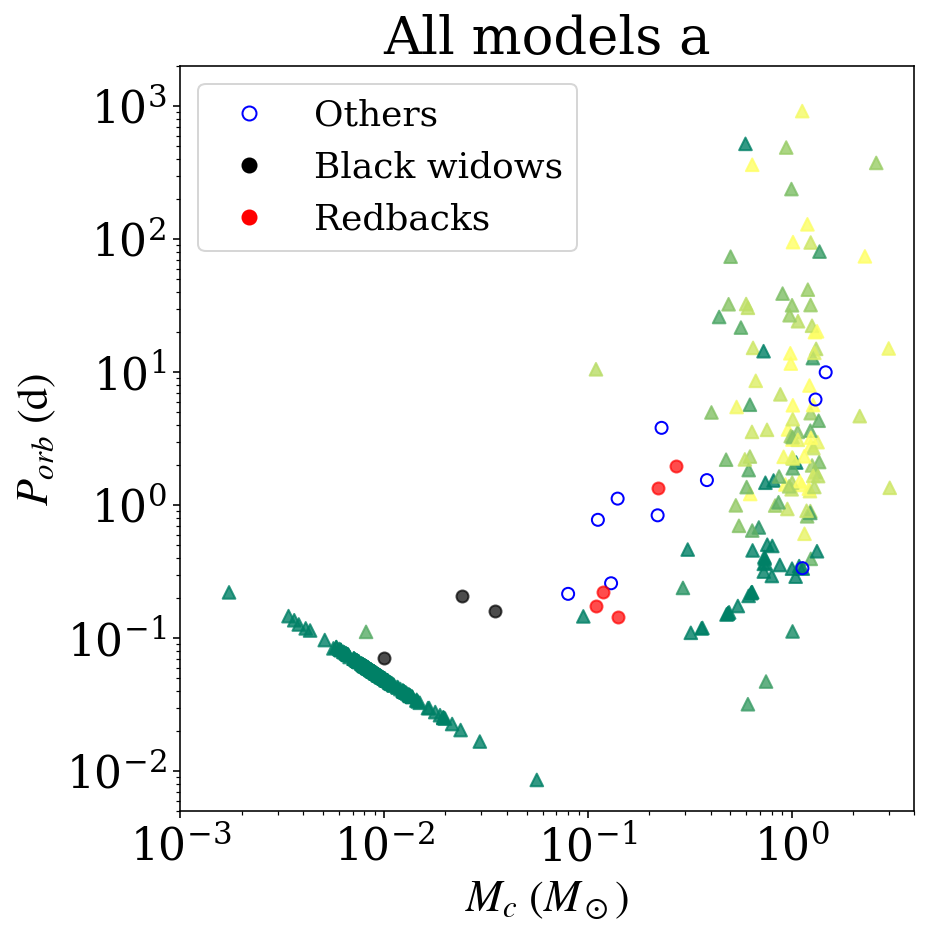

In [4]:
###Comparing companion mass and orbital period
##Observations
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall, Clusall = pc.readdata_freire()
print(len(Pall), len(Clusall), len(Period))
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]
#print(len(namerb),len(namebw))

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
CCst = np.array(data_gcmsp['cc'])
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T' or str(clusname[ii])[0]=='G':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

allcc = []
for kk in range(len(Names)):
    for jj in range(len(Clusall)):
        if Names[kk]==Nameall[jj]:
            #print(Names[kk], Clusall[jj])
            allcc.append(CCst[clusno==Clusall[jj]][0])
            #break
allcc = np.array(allcc)

##Only show CC clusters
Period= np.array(Period)[allcc==1]
Mc = np.array(Mc)[allcc==1]
Names = np.array(Names)[allcc==1]



plt.rcParams['figure.figsize'] = [8,24]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, markerfacecolor='none', label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, markerfacecolor='none', label='Others')


fig, axs = plt.subplots(figsize=(7,7))

##Models
data_psr = np.genfromtxt(savepath+'model_offsets_psr0.03sec_12Gyr.dat')
m0 = data_psr[:,7]; m1 = data_psr[:,8]
k0 = data_psr[:,9]; k1 = data_psr[:,10]
ID0 = data_psr[:,11]; ID1 = data_psr[:,12]
model_no = data_psr[:,0].astype(np.int)
#
#flag_wdwd = []
#for xx in range(len(ID0)):
#        themodel = model_no[xx]
#            
#        if ID0[xx] in id_wdwdcol_all[themodel]:
#            #print(np.array(id_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==allmodelid0[xx]])
#            flag_wdwd.append(np.array(type_wdwdcol_all[themodel])[np.array(id_wdwdcol_all[themodel])==ID0[xx]][0])
#        elif ID0[xx] in id_wdwdmer_all[themodel]:
#            flag_wdwd.append(np.array(type_wdwdmer_all[themodel])[np.array(id_wdwdmer_all[themodel])==ID0[xx]][0])
#        elif ID0[xx] in idtde_msp_all[themodel]:
#            flag_wdwd.append('tde')
#        else:
#            flag_wdwd.append(0)
            
for xx in range(0,18):
    print(xx)
    Mc_model = []; Porb_model = []; kc_model = []; ID_model = []; ecc_model = []
    #flag_wdwd_model = []
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    psrfile = paths[xx]+'initial.morepulsars.dat'

    timestep_old=14000.
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv < 12000.:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                print(timestep)
                #print(xx, kc_model[], Mc_model)
                kc_model = np.array(kc_model); ID_model = np.array(ID_model)
                Mc_model = np.array(Mc_model); Porb_model = np.array(Porb_model)
                ecc_model = np.array(ecc_model)
                #print(xx, Mc_model[kc_model<=1], Porb_model[kc_model<=1], ID_model[kc_model<=1])
                #print(xx, Mc_model[(kc_model>=10)&(Mc_model>=0.5)], Porb_model[(kc_model>=10)&(Mc_model>=0.5)])
                print(ID_model[(Mc_model>=0.8) & (Porb_model<=0.2)], 
                      Mc_model[(Mc_model>=0.8) & (Porb_model<=0.2)], 
                      Porb_model[(Mc_model>=0.8) & (Porb_model<=0.2)],
                      ecc_model[(Mc_model>=0.8) & (Porb_model<=0.2)],
                      kc_model[(Mc_model>=0.8) & (Porb_model<=0.2)])

                axs.scatter(Mc_model, Porb_model, c = ecc_model, cmap='summer',
                            alpha=0.8, s=40, marker = '^')
                break
                
            if int(data[2])==1:
                #if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9])<=0.03:
                #    if int(data[12])>=11 and float(data[6])<=0.01:
                #        continue
                #    Mc_model.append(float(data[6]))
                #    Porb_model.append(uc.au_to_period(float(data[13]), float(data[5]), float(data[6])))
                #    kc_model.append(int(data[12]))
                #    ID_model.append(int(data[3]))
                #    
                #if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12) and float(data[10])<=0.03:
                #    if int(data[11])>=11 and float(data[5])<=0.01:
                #        continue
                #    Mc_model.append(float(data[5]))
                #    Porb_model.append(uc.au_to_period(float(data[13]), float(data[5]), float(data[6])))
                #    kc_model.append(int(data[11]))
                #    ID_model.append(int(data[4]))
                if int(data[11])==13 and int(data[3]) in ID0:
                    Mc_model.append(float(data[6]))
                    Porb_model.append(uc.au_to_period(float(data[13]), float(data[5]), float(data[6])))
                    kc_model.append(int(data[12]))
                    ID_model.append(int(data[3]))
                    ecc_model.append(float(data[14]))
                elif int(data[12])==13 and int(data[4]) in ID0:
                    Mc_model.append(float(data[5]))
                    Porb_model.append(uc.au_to_period(float(data[13]), float(data[5]), float(data[6])))
                    kc_model.append(int(data[11]))
                    ID_model.append(int(data[4]))
                    ecc_model.append(float(data[14]))
                              
            timestep_old = timestep

print(len(Mc_model))
                    
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        #if float(Mc[i])<=0.05:
        #    print(Names[i])
        if float(Period[i])<0.4:
            print(Names[i])
        if Names[i] in namerb:
            axs.scatter(float(Mc[i]), float(Period[i]), color='red', alpha=0.7, zorder=2)
        elif Names[i] in namebw:
            axs.scatter(float(Mc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
        else:
            axs.scatter(float(Mc[i]), float(Period[i]), color='b', facecolors='none', zorder=1)   
    else:
        axs.errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
             
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylim(0.005, 2000)
axs.set_xlim(0.001, 4)
axs.set_xlabel(r'$M_c\ (M_\odot)$')
axs.set_ylabel(r'$P_{orb}\ (\rm{d})$')
axs.set_title('All models')
axs.legend(handles=[bdot, kdot, rdot], loc='upper left', prop={'size': 18}, numpoints=1, frameon=True)

fig.tight_layout()

In [5]:
path = paths[14]
t_conv = dyn.conv('t', path+'initial.conv.sh')

##Escape file
with open(path+'initial.esc.dat', 'r') as fesc:
    next(fesc)
    for line in fesc:
        data = line.split()
        if int(data[14])==1:
            if int(data[22])==14 and float(data[15])>=100.:
                print('m0, m1, k0, k1', float(data[15]), float(data[16]), int(data[22]), int(data[23]))
                
            if int(data[23])==14 and float(data[16])>=100.:
                print('m0, m1, k0, k1', float(data[15]), float(data[16]), int(data[22]), int(data[23]))
                 
        else:
            if int(data[21])==14 and float(data[2])>=100.:
                print('m, k', float(data[2]), int(data[21]))


#########################################################################
##Snap file
snap_h5 = 'initial.snapshots.h5'
snapkeys = np.genfromtxt(path+'snap_keys.txt', dtype=str)
snap_no = snapkeys[:,0]; snap_time = snapkeys[:,1]
snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/442(t=17.816761)',#'/'+snap_no[-1]+'(t='+snap_time[-1]+')', 
                     conv=path+'initial.conv.sh', 
                     z=0.0002)

bflag = np.array(snap.data['binflag'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
m0 = np.array(snap.data['m0_MSUN']); m1=np.array(snap.data['m1_MSUN'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
k = np.array(snap.data['startype']); m = np.array(snap.data['m_MSUN'])

#print(np.max(m[k==14]), np.max(m0[k0==14]), np.max(m1[k1==14]))
for xx in range(len(bflag)):
    if bflag[xx]==1:
        if k0[xx]==14 and m0[xx]>=100:
            print(m0[xx], m1[xx], k0[xx], k1[xx])
        
        if k1[xx]==14 and m1[xx]>=100:
            print(m0[xx], m1[xx], k0[xx], k1[xx])
    else:
        if k[xx]==14 and m[xx]>=100:
            print(m[xx], k[xx])


m, k 333.22577 14
m0, m1, k0, k1 32.576096 127.71248 14 14
m, k 157.80835 14
m, k 171.04065 14
m, k 119.82207 14
m, k 159.5929 14
m, k 108.437 14
m, k 172.63698 14
m, k 110.85719 14
m, k 121.53651 14
m, k 125.92373 14
m, k 136.99137 14
m, k 128.41095 14
m, k 105.27938 14
m, k 110.56792 14
m, k 108.98758 14


In [8]:
###Pulsars and their spin period and magnetic filed distribution, and positions in the cluster
###Separating single and binary MSPs
###Identify collision products
Ball = []; Pall = []; mall = []; mcompall = []; kcompall = []; rposall = []
idnsall = []; idcompall = []
wdwdcollflagall = []; wdmscollflagall = []
psrflagall = []; mspflagall = []
modelnoall = []
for xx in range(len(paths)):
    B = []; P = []; m = []; mcomp = []; kcomp = []; rpos = []
    idns = []; idcomp = []
    wdwdcollflag = []; wdmscollflag = []
    psrflag = []; mspflag = []
    modelno = []
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    idwdwd_coll = wdwd_coll_file[:,2].astype(np.int)
    
    wdms_coll_file = np.genfromtxt(paths[xx]+'wdms_coll.dat')
    idwdms_coll = wdms_coll_file[:,2].astype(np.int)
    id_wdms = []

    thetime = 14000.
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime:
                break
            if float(data[1])*t_conv>=13000.:
                thetime = float(data[1])*t_conv
                #print(thetime)
                if int(data[2])!=1:
                    if int(data[3]) in idwdms_coll:
                        id_wdms.append(int(data[3]))
                    if float(data[7])>=float(data[9])**2*(0.17*10**12):
                        B.append(float(data[7]))
                        P.append(float(data[9]))
                        m.append(float(data[5]))
                        mcomp.append(-100)
                        kcomp.append(-100)
                        rpos.append(float(data[19])*l_conv)
                        idns.append(int(data[3]))
                        idcomp.append(-100)
                        modelno.append(xx)
                        psrflag.append(1)
                        
                        if P[-1]<=0.03:
                            mspflag.append(1)
                        else:
                            mspflag.append(0)
                            
                        if int(data[3]) in idwdwd_coll:
                            wdwdcollflag.append(1)
                        else:
                            wdwdcollflag.append(0)
                            
                        if int(data[3]) in idwdms_coll:
                            wdmscollflag.append(1)
                        else:
                            wdmscollflag.append(0)

                    else:
                        if int(data[3]) in idwdwd_coll:
                            wdwdcollflag.append(1)
                            
                            B.append(float(data[7]))
                            P.append(float(data[9]))
                            m.append(float(data[5]))
                            mcomp.append(-100)
                            kcomp.append(-100)
                            rpos.append(float(data[19])*l_conv)
                            idns.append(int(data[3]))
                            idcomp.append(-100)
                            modelno.append(xx)
                            psrflag.append(0)
                            mspflag.append(0)
                            wdmscollflag.append(0)
           
                else:
                    if int(data[11])==13:
                        if int(data[3]) in idwdms_coll:
                            id_wdms.append(int(data[3]))
                        if float(data[7])>=float(data[9])**2*(0.17*10**12):
                            B.append(float(data[7]))
                            P.append(float(data[9]))
                            m.append(float(data[5]))
                            mcomp.append(float(data[6]))
                            kcomp.append(int(data[12]))
                            rpos.append(float(data[19])*l_conv)
                            idns.append(int(data[3]))
                            idcomp.append(int(data[4]))
                            modelno.append(xx)
                            psrflag.append(1)
                            
                            if P[-1]<=0.03:
                                mspflag.append(1)
                            else:
                                mspflag.append(0)
                                
                            if int(data[3]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                            else:
                                wdwdcollflag.append(0)
                                
                            if int(data[3]) in idwdms_coll:
                                wdmscollflag.append(1)
                            else:
                                wdmscollflag.append(0)

                        else:
                            if int(data[3]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                                
                                B.append(float(data[7]))
                                P.append(float(data[9]))
                                m.append(float(data[5]))
                                mcomp.append(float(data[6]))
                                kcomp.append(int(data[12]))
                                rpos.append(float(data[19])*l_conv)
                                idns.append(int(data[3]))
                                idcomp.append(int(data[4]))
                                modelno.append(xx)
                                psrflag.append(0)
                                mspflag.append(0)
                                wdmscollflag.append(0)

                            
                    if int(data[12])==13:
                        if int(data[4]) in idwdms_coll:
                            id_wdms.append(int(data[4]))
                        if float(data[8])>=float(data[10])**2*(0.17*10**12):
                            B.append(float(data[8]))
                            P.append(float(data[10]))
                            m.append(float(data[6]))
                            mcomp.append(float(data[5]))
                            kcomp.append(int(data[11]))
                            rpos.append(float(data[19])*l_conv)
                            idns.append(int(data[4]))
                            idcomp.append(int(data[3]))
                            modelno.append(xx)
                            psrflag.append(1)
                            
                            if P[-1]<=0.03:
                                mspflag.append(1)
                            else:
                                mspflag.append(0)
                                
                            if int(data[4]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                            else:
                                wdwdcollflag.append(0)
                                
                            if int(data[4]) in idwdms_coll:
                                wdmscollflag.append(1)
                            else:
                                wdmscollflag.append(0)

                        else:
                            if int(data[4]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                                
                                B.append(float(data[8]))
                                P.append(float(data[10]))
                                m.append(float(data[6]))
                                mcomp.append(float(data[5]))
                                kcomp.append(int(data[11]))
                                rpos.append(float(data[19])*l_conv)
                                idns.append(int(data[4]))
                                idcomp.append(int(data[3]))
                                modelno.append(xx)
                                psrflag.append(0)
                                mspflag.append(0)
                                wdmscollflag.append(0)
                                
    P = np.array(P)
    mspflag = np.array(mspflag)
    wdwdcollflag = np.array(wdwdcollflag)
    wdmscollflag = np.array(wdmscollflag)
    
    allmsp = mspflag[mspflag==1]
    wdwdcoll_msp = wdwdcollflag[mspflag==1]
    wdmscoll_msp = wdmscollflag[mspflag==1]
                                
    print(xx, len(allmsp), len(wdwdcoll_msp[wdwdcoll_msp==1]), len(wdmscoll_msp[wdmscoll_msp==1]))
    print(len(id_wdms))
    
    Ball.append(B); Pall.append(P); mall.append(m); mcompall.append(mcomp)
    kcompall.append(kcomp); rposall.append(rpos)
    idnsall.append(idns); idcompall.append(idcomp)
    modelnoall.append(modelno)
    psrflagall.append(psrflag); mspflagall.append(mspflag)
    wdwdcollflagall.append(wdwdcollflag); wdmscollflagall.append(wdmscollflag)
    
                                
#np.savetxt('/projects/b1095/syr904/projects/isolated_MSP/ngc6752_pulsars.txt', 
#           np.c_[modelno, rpos, idns, idcomp, m, mcomp, B, P, kcomp, psrflag, mspflag, wdwdcollflag, wdmscollflag],
#           fmt = '%d %f %d %d %f %f %e %f %d %d %d %d %d', 
#           header = '1.Model 2.R[pc] 3.IDns 4.IDcomp 5.Mns[Msun] 6.Mcomp[Msun] 7.B[G] 8.P[sec] 9.Kcomp 10.PSRflag 11.MSPflag 12.WDWDCollflag 13.WDMSCollflag',
#           comments = '#', delimiter = '')

0 12 0 2
70
1 52 1 1
74
2 17 3 0
72
3 14 1 1
61
4 59 1 1
94
5 117 2 9
140
6 13 4 0
58
7 21 3 4
85


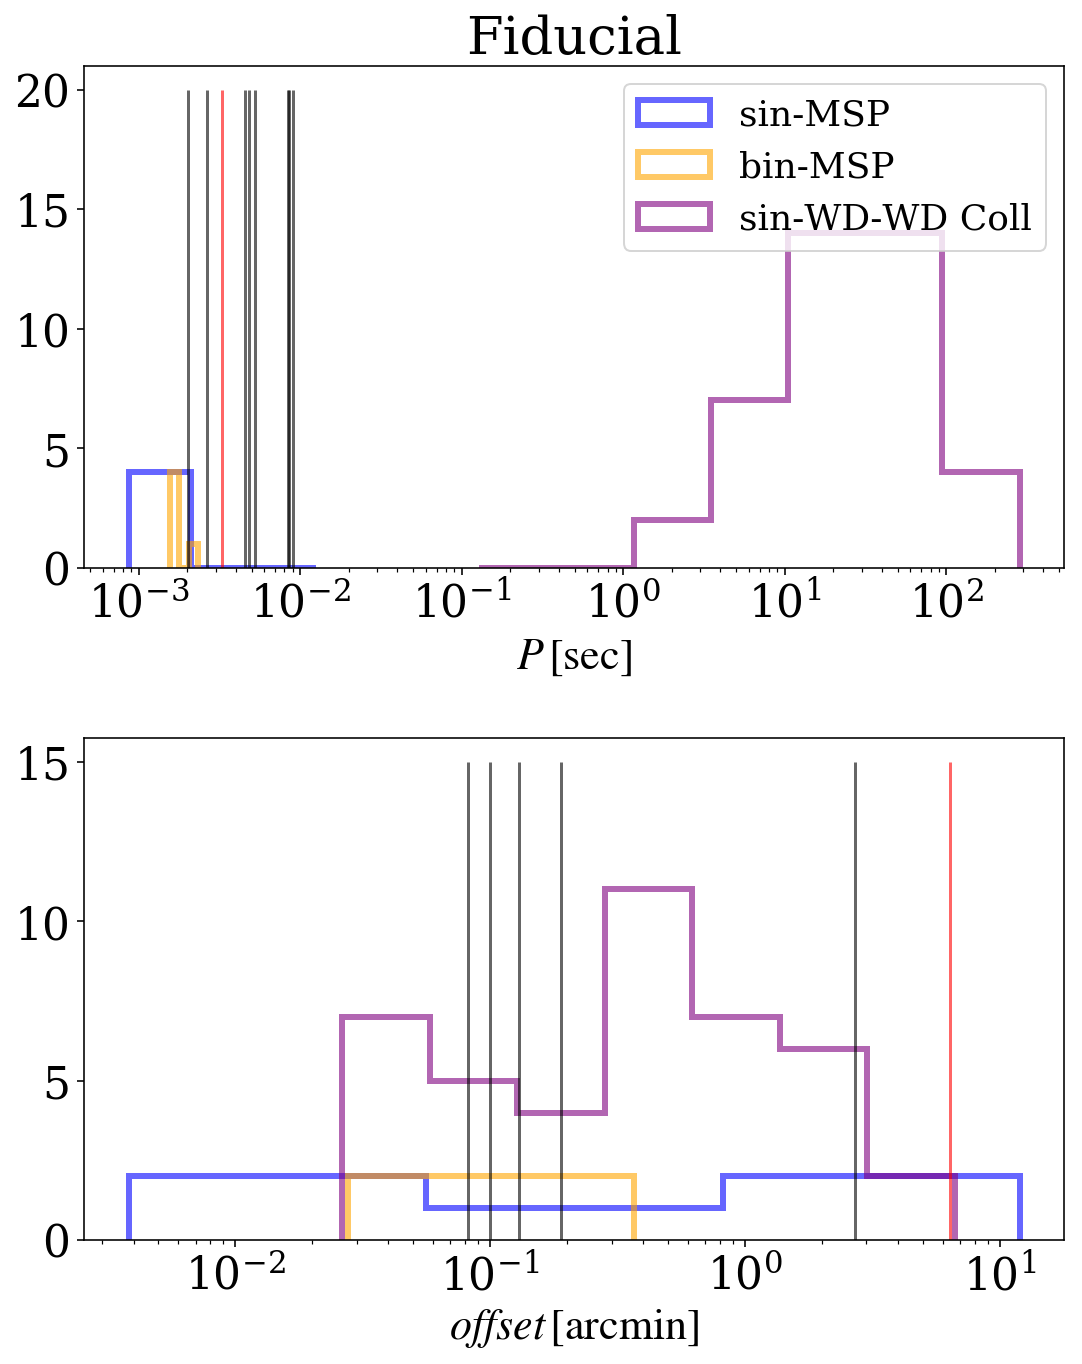

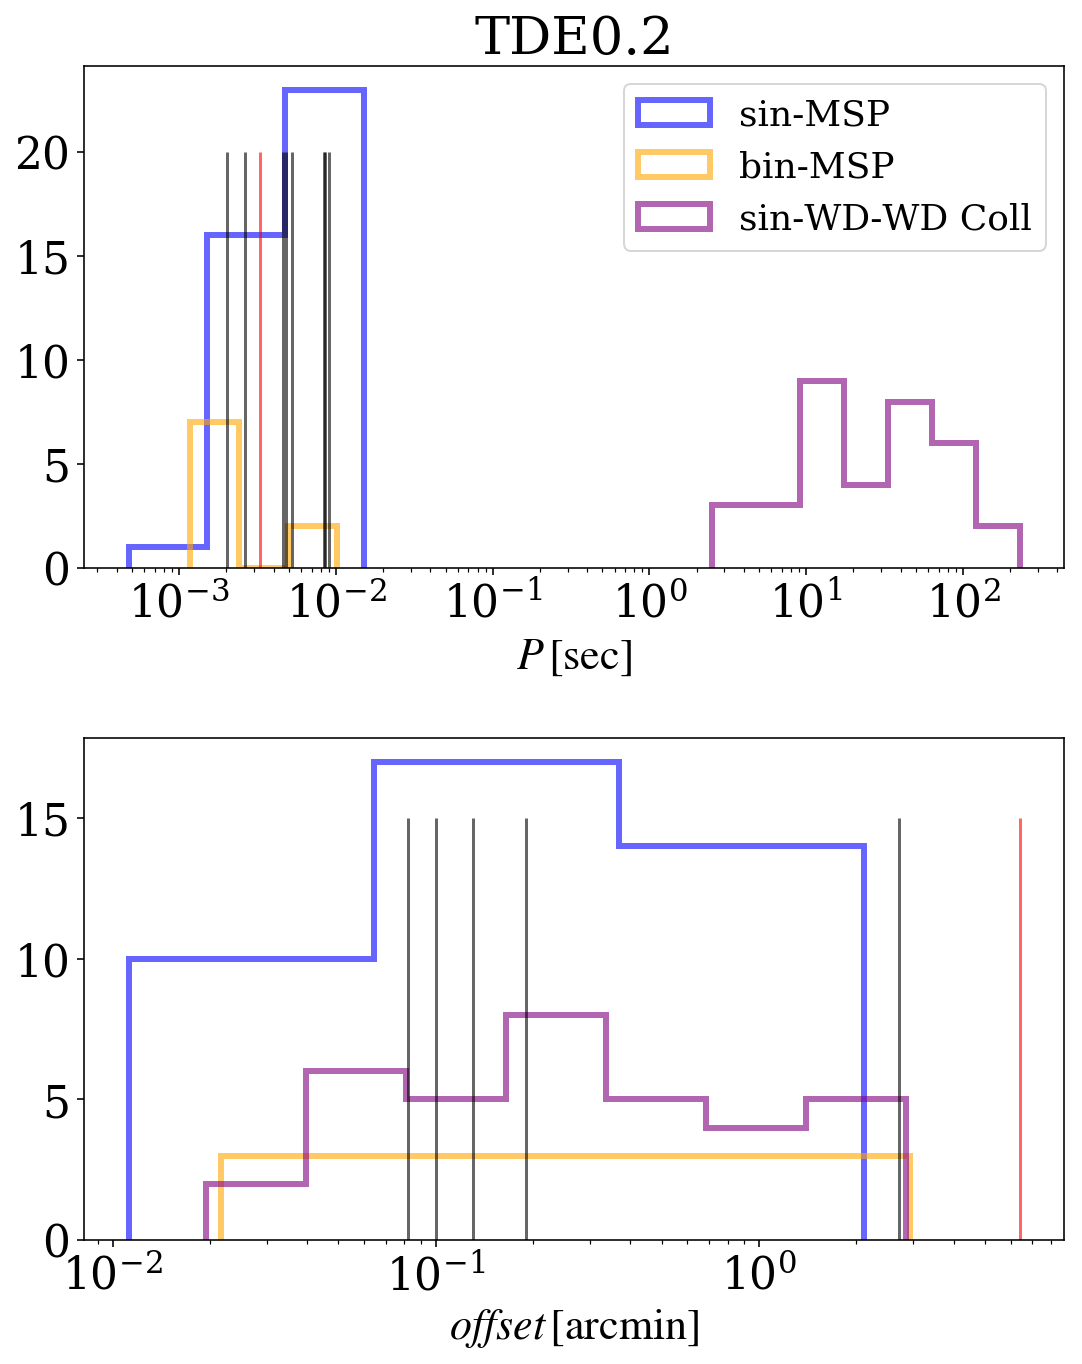

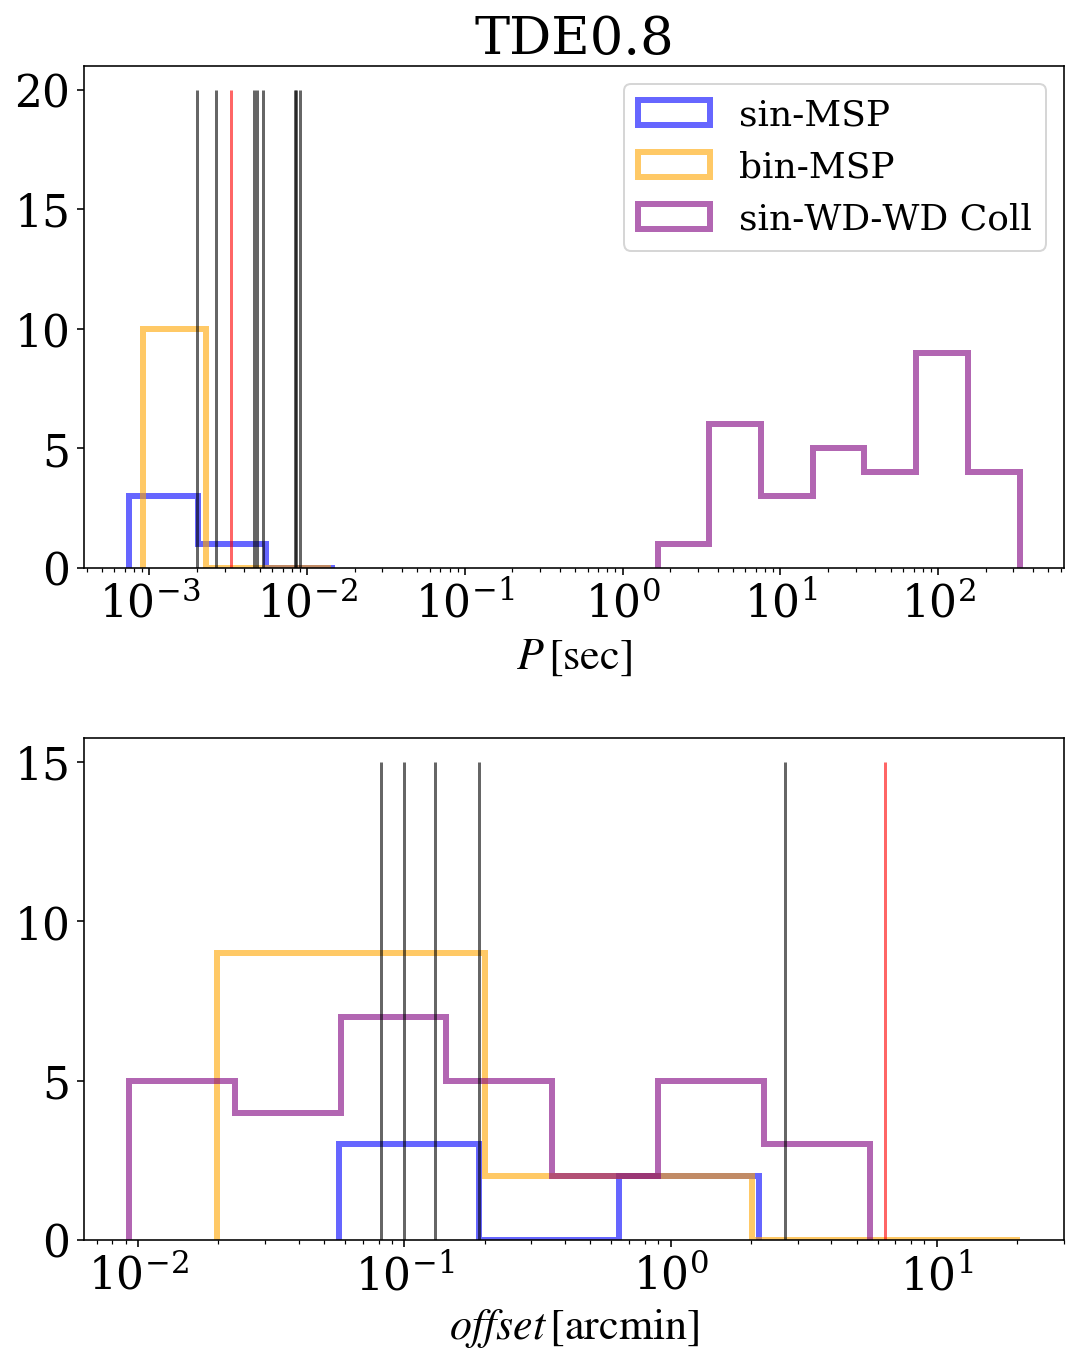

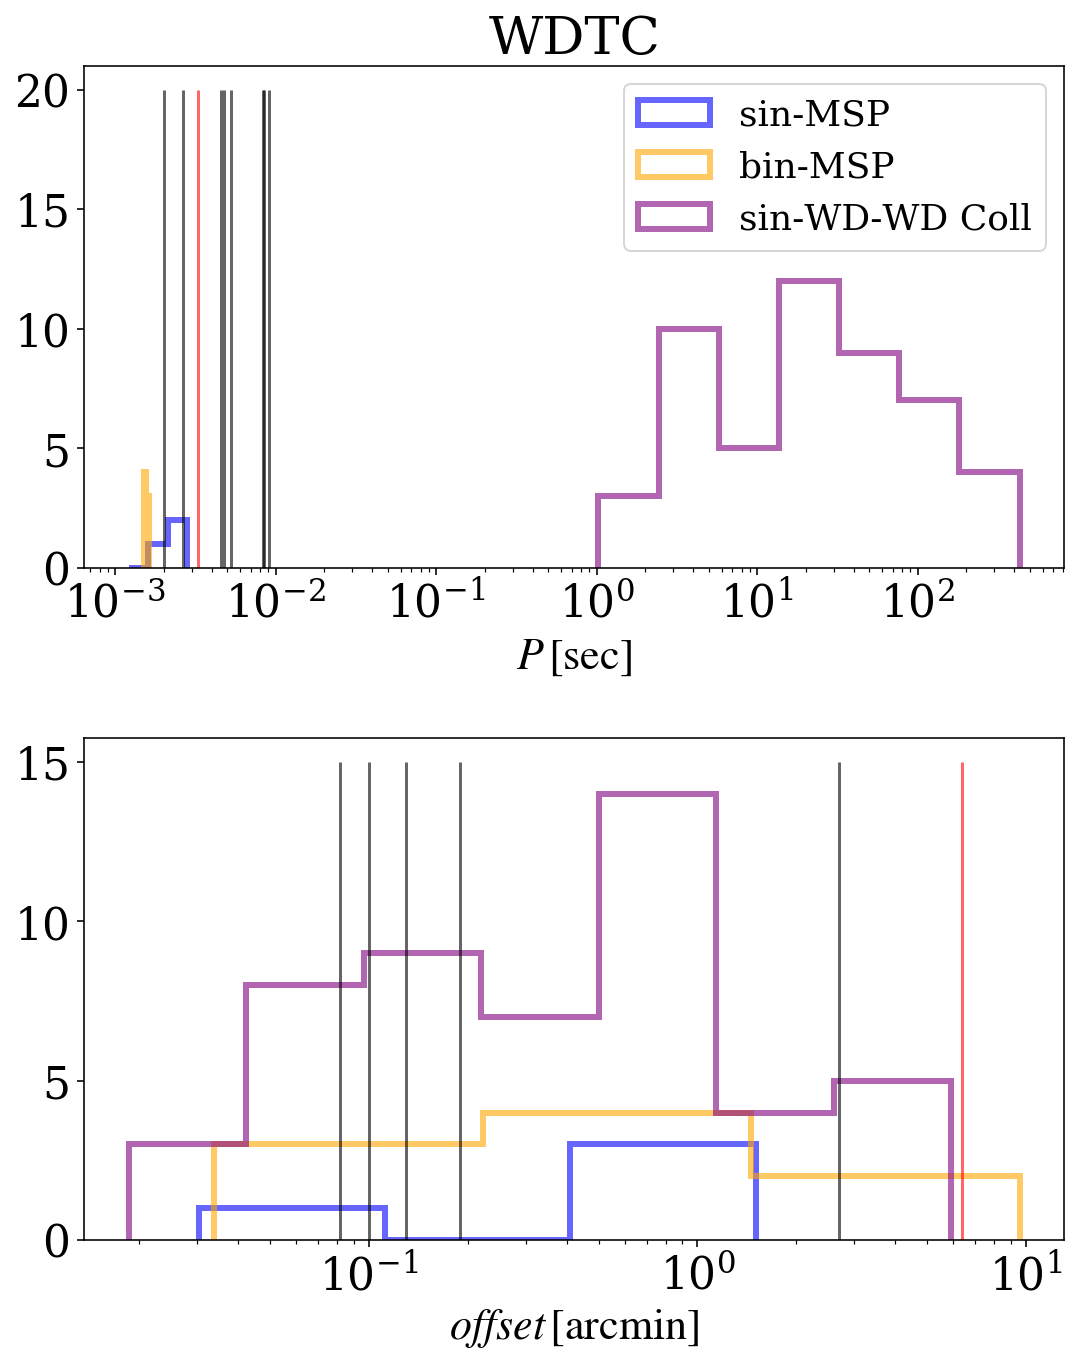

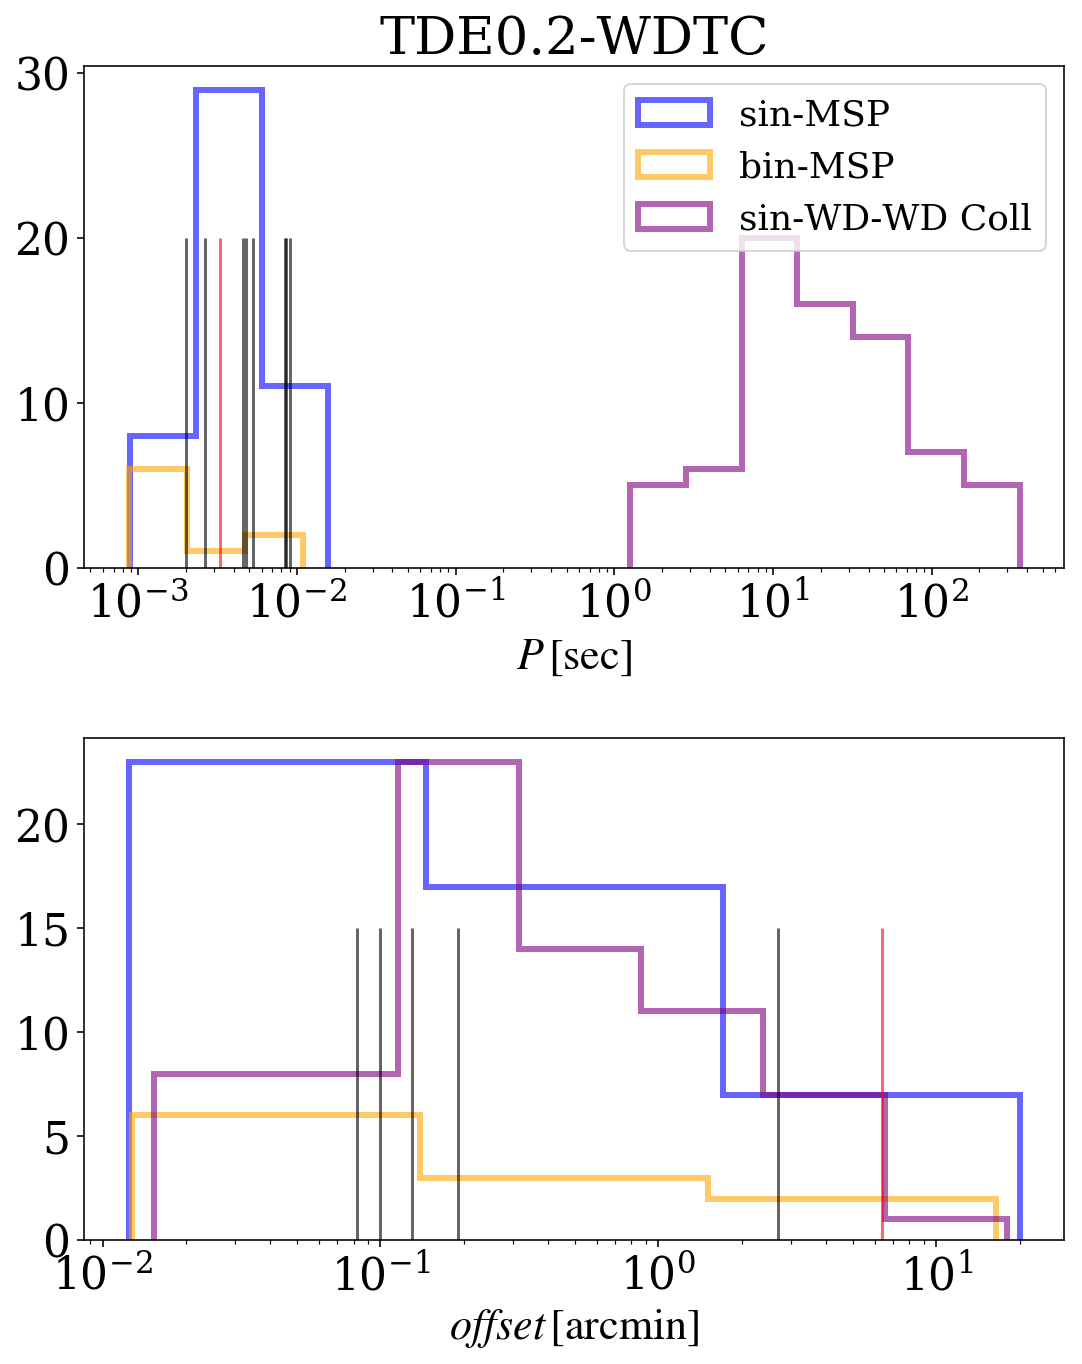

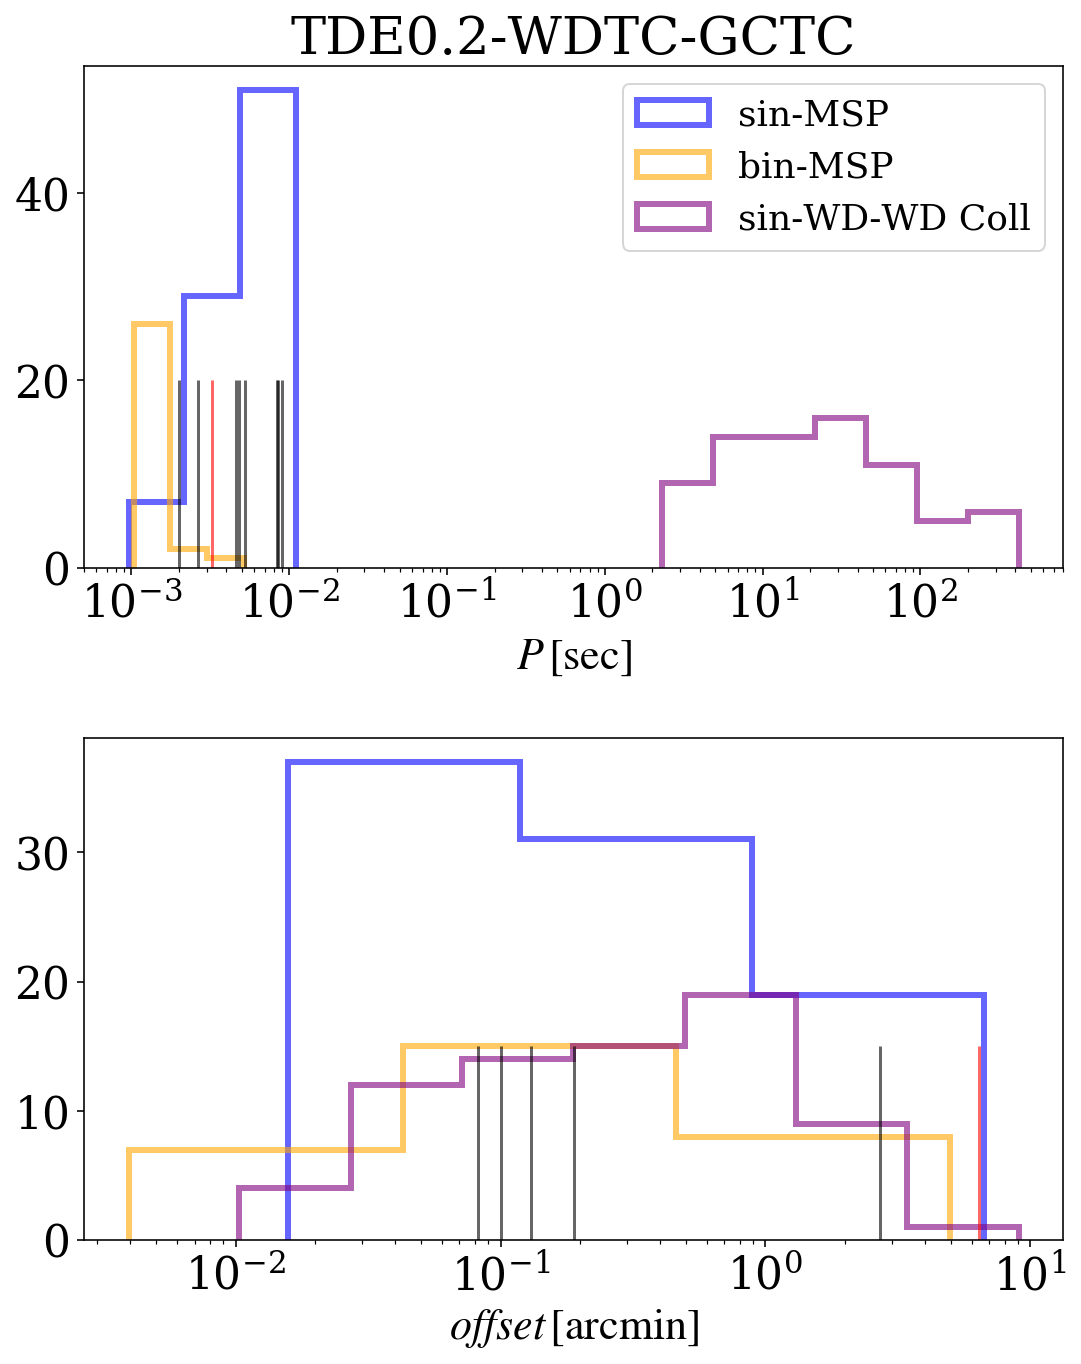

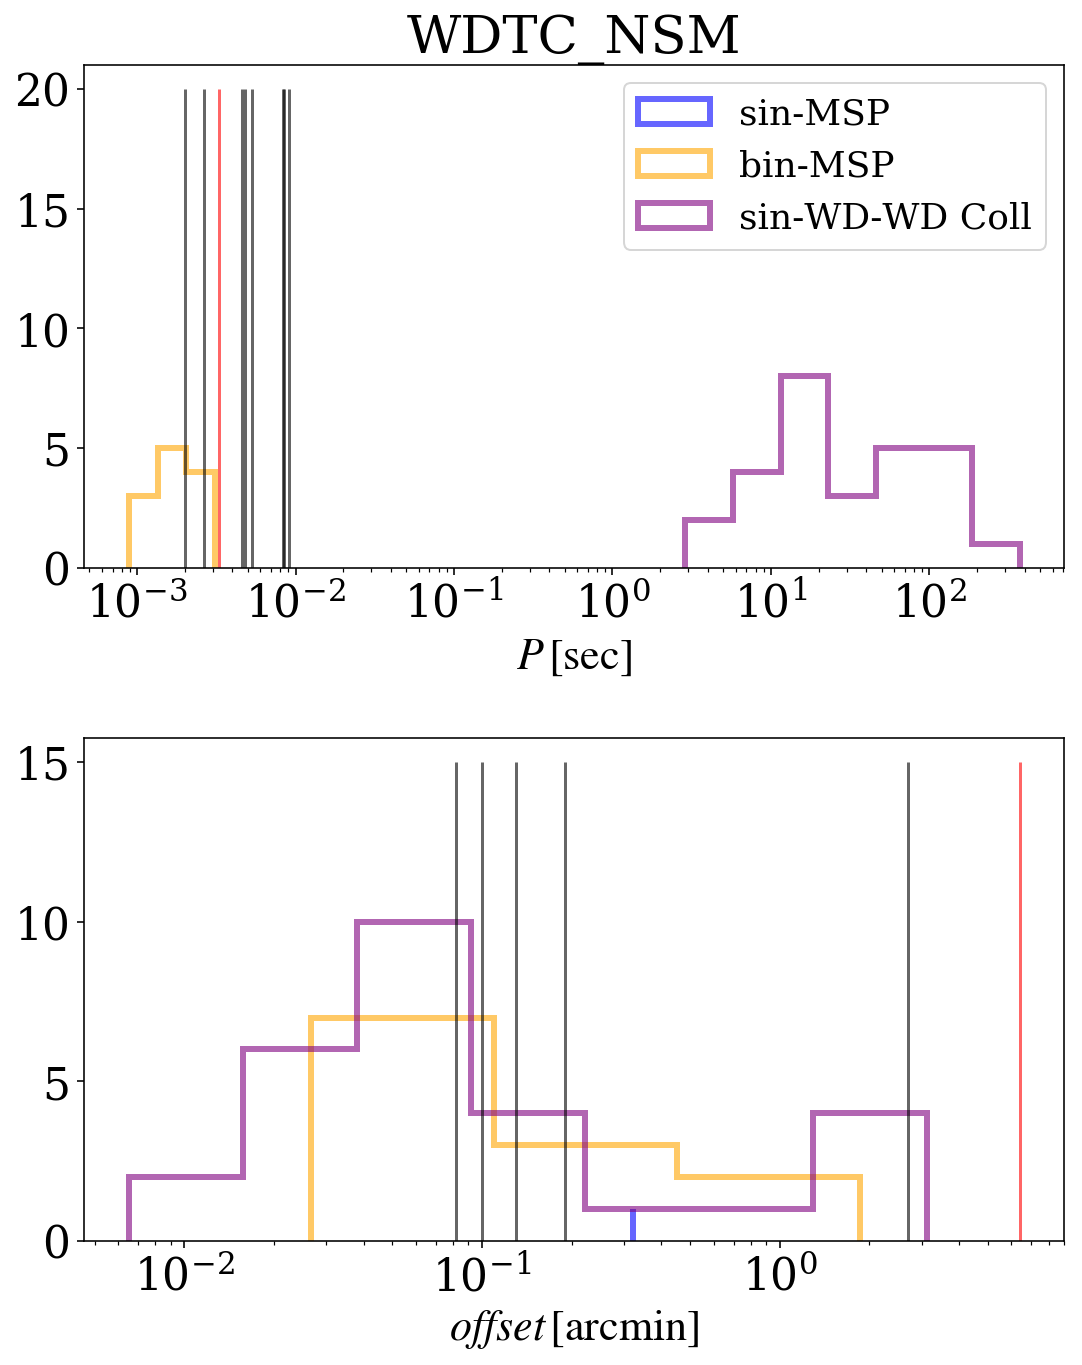

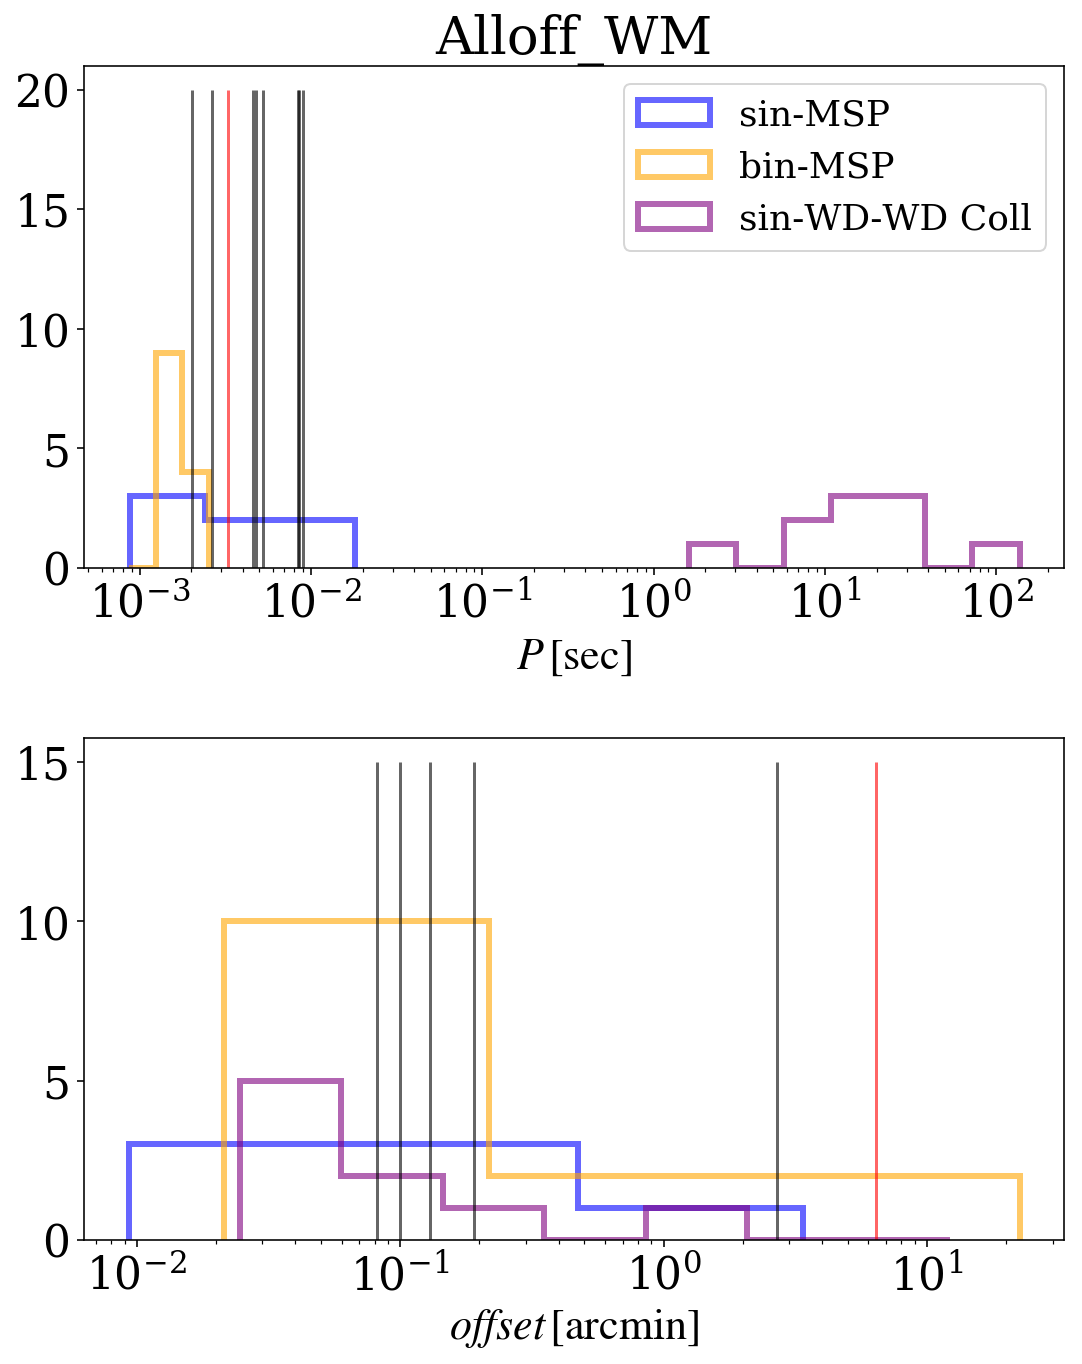

In [9]:
##Ppdot plot and radial distribution
for xx in range(len(paths)):
    P = np.array(Pall[xx])
    mspflag = np.array(mspflagall[xx])
    wdwdcollflag = np.array(wdwdcollflagall[xx])
    rpos = np.array(rposall[xx])
    idcomp = np.array(idcompall[xx])
    modelno = np.array(modelnoall[xx])
    
    wdwdcoll_msp = wdwdcollflag[mspflag==1]
    wdwdcoll_nonmsp = wdwdcollflag[mspflag!=1]
    
    Pmsp = P[mspflag==1]
    Pnonmsp = P[mspflag!=1]
    Pwdwd = Pnonmsp[wdwdcoll_nonmsp==1]
    
    idcomp_msp = idcomp[mspflag==1]
    idcomp_nonmsp = idcomp[mspflag!=1]
    idcomp_wdwd = idcomp_nonmsp[wdwdcoll_nonmsp==1]
    
    rpos_msp = rpos[mspflag==1]
    rpos_nonmsp = rpos[mspflag!=1]
    rpos_wdwd = rpos_nonmsp[wdwdcoll_nonmsp==1]
    
    modelno_msp = modelno[mspflag==1]
    modelno_nonmsp = modelno[mspflag!=1]
    modelno_wdwd = modelno_nonmsp[wdwdcoll_nonmsp==1]
    
    fig, axs = plt.subplots(nrows = 2, figsize=(8,10))
    axs[0].hist(Pmsp[idcomp_msp==-100],
               bins = np.logspace(np.log10(np.min(Pmsp[idcomp_msp==-100])), np.log10(np.max(Pmsp[idcomp_msp==-100])),4),
               histtype='step', alpha=0.6, lw=3, color='b',
               label = 'sin-MSP')
    axs[0].hist(Pmsp[idcomp_msp!=-100],
               bins = np.logspace(np.log10(np.min(Pmsp[idcomp_msp!=-100])), np.log10(np.max(Pmsp[idcomp_msp!=-100])),4),
               histtype='step', alpha=0.6, lw=3, color='orange',
               label = 'bin-MSP')
    axs[0].hist(Pwdwd[idcomp_wdwd==-100],
               bins = np.logspace(np.log10(np.min(Pwdwd[idcomp_wdwd==-100])), np.log10(np.max(Pwdwd[idcomp_wdwd==-100])),8),
               histtype='step', alpha=0.6, lw=3, color='purple',
               label='sin-WD-WD Coll')
    axs[0].vlines(x=dpsr['spin'][0]/1.e3,ymin=0, ymax=20, 
                  color = 'red', alpha=0.6, label=None)
    axs[0].vlines(x=dpsr['spin'][1:]/1.e3, ymin=0, ymax=20, 
                  color = 'k', alpha=0.6, label=None)
    axs[0].set_xscale('log')
    axs[0].legend(loc='best', fontsize=18)
    axs[0].set_xlabel(r'$P\,\rm{[sec]}$')
    axs[0].set_title(model_label[xx])
    
    rpos_msp_arcmin = uc.pc2arcsec(4.125, rpos_msp)/60.
    rpos_wdwd_arcmin = uc.pc2arcsec(4.125, rpos_wdwd)/60.
    axs[1].hist(rpos_msp_arcmin[idcomp_msp==-100],
               bins = np.logspace(np.log10(np.min(rpos_msp_arcmin[idcomp_msp==-100])), np.log10(np.max(rpos_msp_arcmin[idcomp_msp==-100])), 4),
               histtype='step', alpha=0.6, lw=3, color='b',
               label = 'sin-MSP')
    axs[1].hist(rpos_msp_arcmin[idcomp_msp!=-100],
               bins = np.logspace(np.log10(np.min(rpos_msp_arcmin[idcomp_msp!=-100])), np.log10(np.max(rpos_msp_arcmin[idcomp_msp!=-100])), 4),
               histtype='step', alpha=0.6, lw=3, color='orange',
               label = 'bin-MSP')
    axs[1].hist(rpos_wdwd_arcmin[idcomp_wdwd==-100],
               bins = np.logspace(np.log10(np.min(rpos_wdwd_arcmin[idcomp_wdwd==-100])), np.log10(np.max(rpos_wdwd_arcmin[idcomp_wdwd==-100])), 8),
               histtype='step', alpha=0.6, lw=3, color='purple',
               label='sin-WD-WD Coll')
    axs[1].vlines(x=dpsr['offset'][dpsr['offset']!='*'][0], ymin=0, ymax=15,
                 color = 'red', alpha=0.6, label=None)
    axs[1].vlines(x=dpsr['offset'][dpsr['offset']!='*'][1:], ymin=0, ymax=15,
                 color = 'k', alpha=0.6, label=None)
    axs[1].set_xscale('log')
    axs[1].set_xlabel(r'$offset\,\rm{[arcmin]}$')
    
    fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


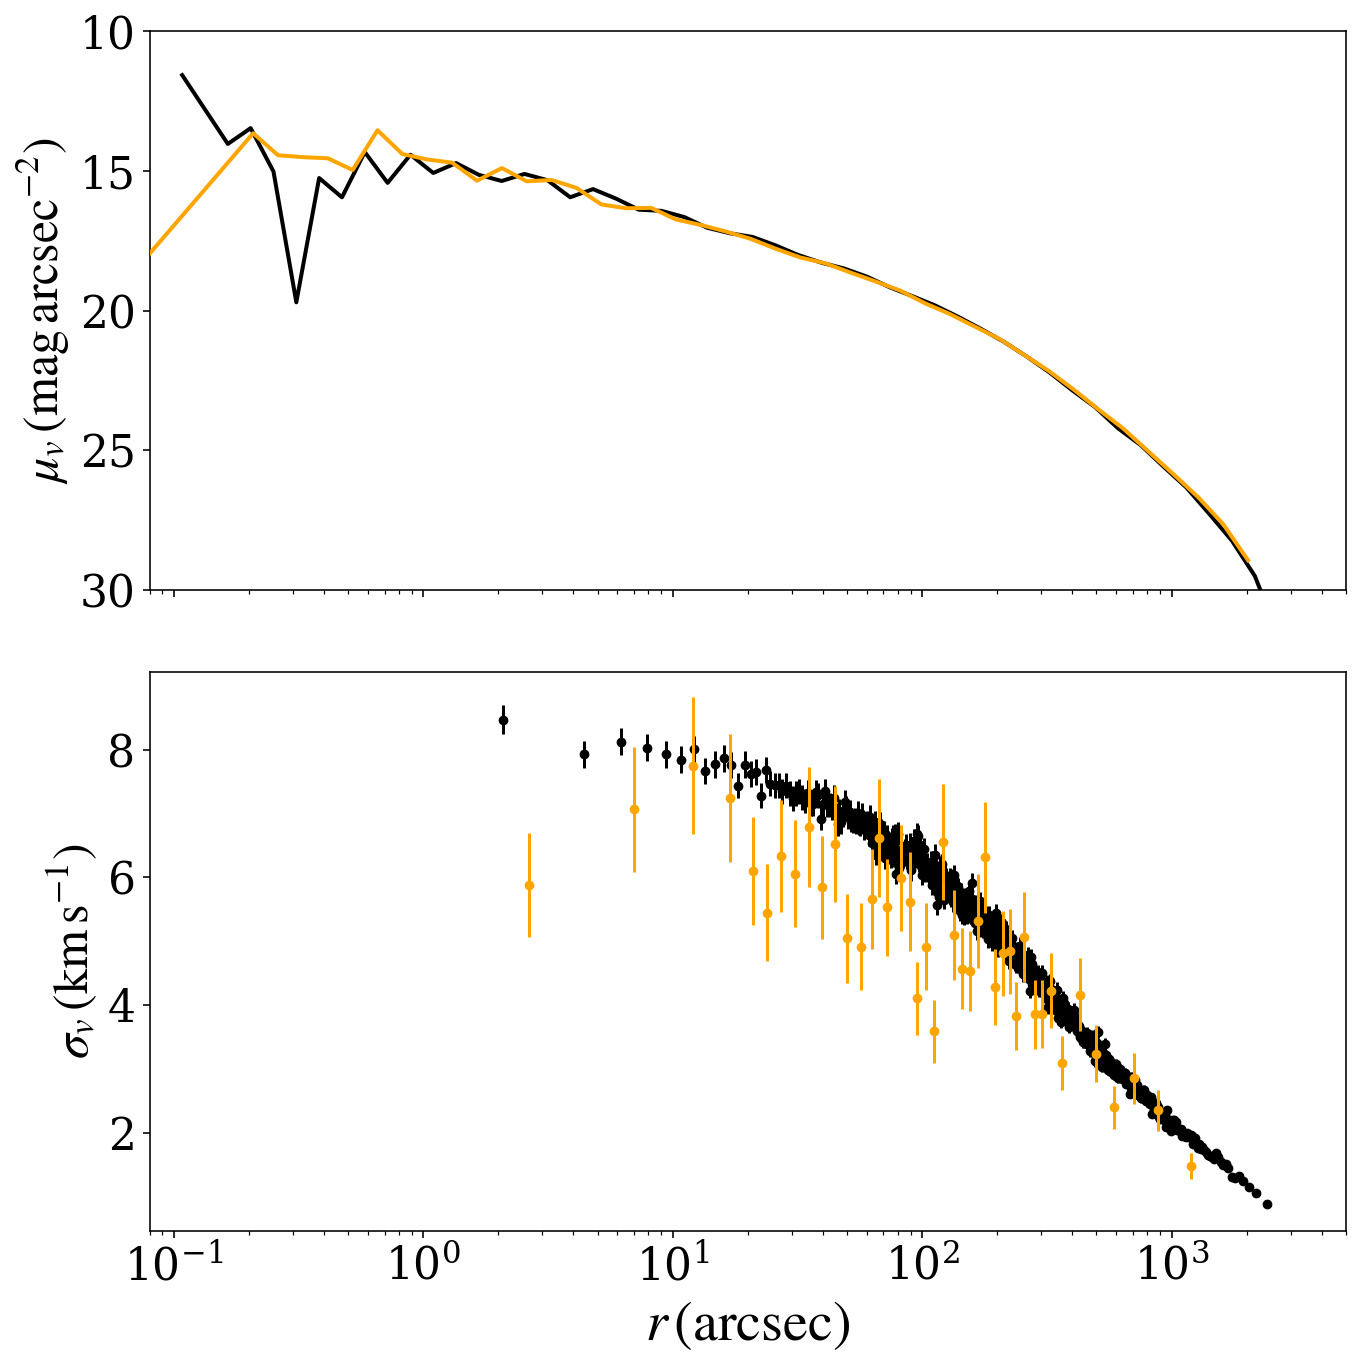

In [2]:
##Plot the best model using King profile
paths = ['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/']

R_sun_obs=4.125
snapno = [500,597]

cs = ['k', 'orange']
####################################################      
##Plotting        
fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    ######################################################
    ##Model data
    if xx == 0:
        snap2D = paths[xx]+'initial.snap'+str(snapno[xx])+'.2Dproj.dat.gz'
        snap2D_L15 = paths[xx]+'initial.snap'+str(snapno[xx])+'.2D_SBPLcut12_NCUT-1.dat'
        snap_veldisp = paths[xx]+'initial.snap'+str(snapno[xx])+'.vel_dispersion_vr_pm_700_0.dat'
    else:
        snap2D = paths[xx]+'initial.snap0'+str(snapno[xx])+'.2Dproj.dat.gz'
        snap2D_L15 = paths[xx]+'initial.snap0'+str(snapno[xx])+'.2D_SBPLcut15.dat'
        snap_veldisp = paths[xx]+'initial.snap0'+str(snapno[xx])+'.vel_dispersion_giants_25.dat'

    
    data5 = np.genfromtxt(snap2D_L15)
    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
    SB = conversions.SB_converter(data5[:,3])
    SBerr = data5[:,6]/data5[:,5]*SB
    SD = conversions.SD_converter(data5[:,5], R_sun_obs)
    SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
     
    arcsec_cut = []
    SB_cut = []
    SBerr_cut = []

    for k in range(len(SB)):
        if arcsec[k] < 10 and SB[k] > 20:
            Nothing = 0
        else:
            arcsec_cut.append(arcsec[k])
            SB_cut.append(SB[k])
            
                
    data_vel = np.genfromtxt(snap_veldisp)
    R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
    sigma_model = data_vel[:,1]
    sigma_err_model = data_vel[:,2]


    #######################
    ##Plotting model data
    ax[0].plot(arcsec_cut, np.array(SB_cut), color = cs[xx], lw=2, zorder = 3)
    ax[1].scatter(R_model, sigma_model,s=15, color = cs[xx], zorder=3)
    ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = cs[xx], fmt='o',markersize=0.01,zorder=3)


    #######################
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.08,5000)
    ax[0].set_ylim(30,10)
    ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
    ax[0].legend(loc='best',scatterpoints=1, ncol=1, prop={'size': 15}, frameon=False)
    

    ax[1].set_xscale('log')
    ax[1].set_xlim(0.08,5000)
    ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
    ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
    ax[1].legend(loc='best', prop={'size': 15}, numpoints=1, frameon=False)
        
fig.tight_layout()


13021.5
12943.2
13090.2
12970.7
12960.9
13033.6
12979.4
12973.1
12997.3
13177.2
12994.3
12927.6
12970.3
12963.8
12901.0
13002.0
13137.0
13148.0


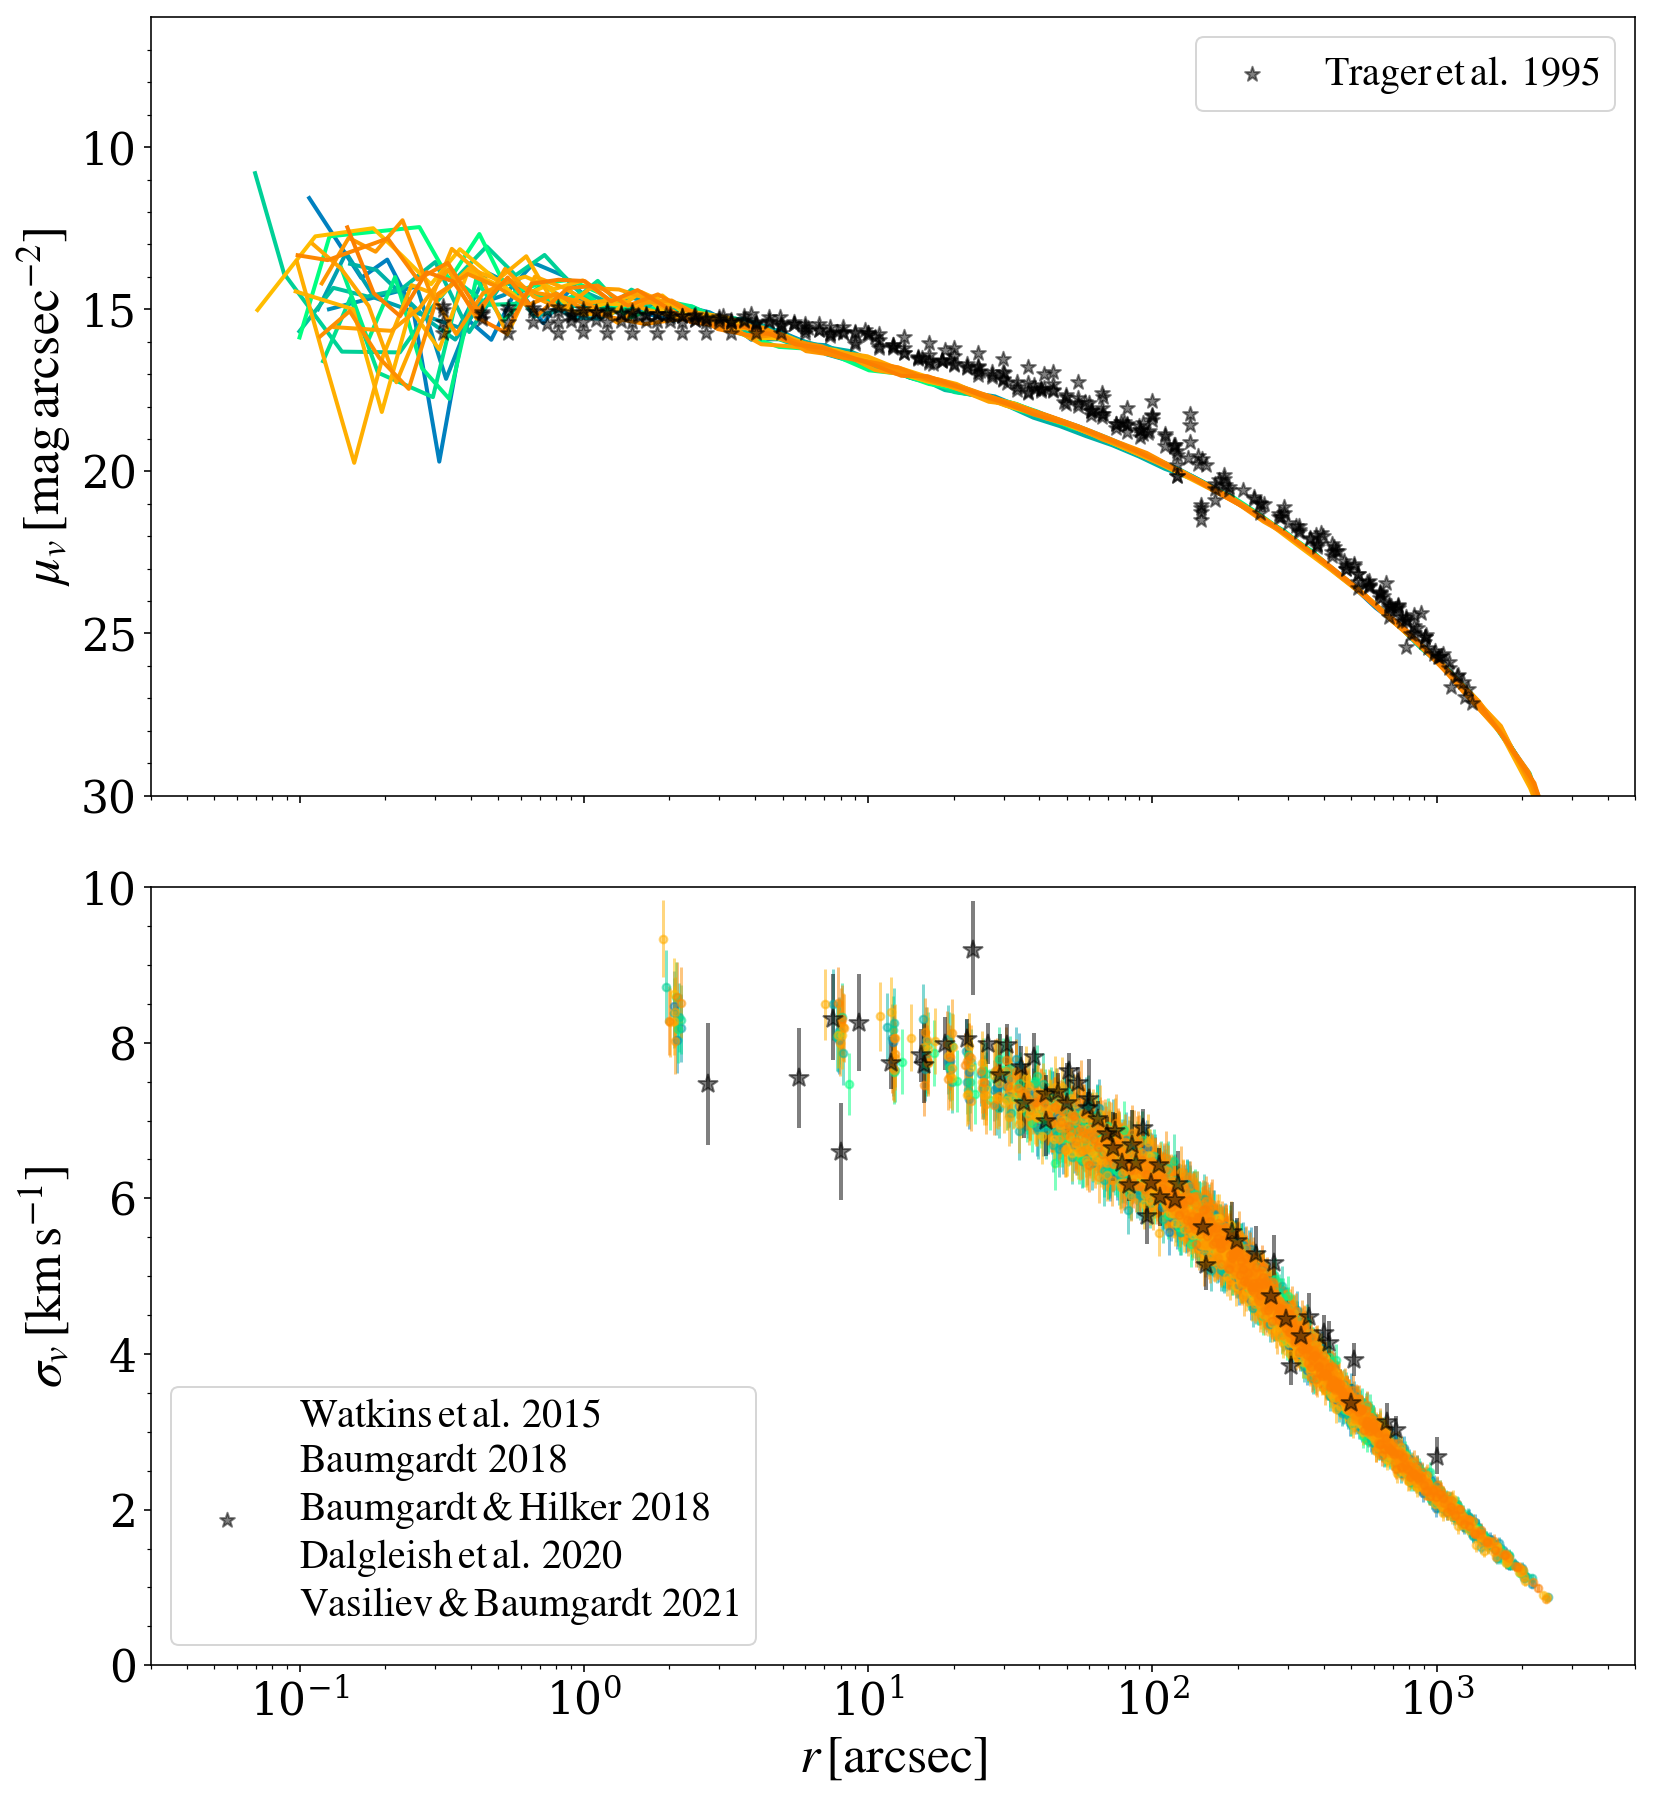

In [3]:
##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=4.125
ngcno='6752'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles_GEDR3.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(np.float(linet[2]))
        SB_t.append(np.float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_GEDR3.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60,
              label=r'$\rm{Watkins\,et\,al.\,2015}$' '\n'
              r'$\rm{Baumgardt\,\,2018}$' '\n'
              r'$\rm{Baumgardt\,&\,Hilker\,\,2018}$' '\n'
              r'$\rm{Dalgleish\,et\,al.\,2020}$' '\n'
              r'$\rm{Vasiliev\,&\,Baumgardt\,\,2021}$')
             

###Models###
for xx in range(len(paths)):
    if xx>=0:
        snap2D = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
        snap2D_L12 = np.sort(glob(paths[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
        snap_vel700 = np.sort(glob(paths[xx]+'initial.snap*.vel_dispersion_vr_pm_700_0.dat'))
    else:
        snap2D = [paths[xx]+'initial.snap0597.2Dproj.dat.gz']
        snap2D_L12 = [paths[xx]+'initial.snap0597.2D_SBPLcut15.dat']
        snap_vel700 = [paths[xx]+'initial.snap0597.vel_dispersion_giants_25.dat']
        #print(len(snap2D_L12), len(snap_vel700))
 
    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=12900.:
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2, color=cs[xx])
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.03,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 20})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.03,5000)
ax[1].set_ylim(0, 10)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=26)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=26)
ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()

plt.savefig(savepath+'sbp_vdp_6752_13Gyr.pdf', dpi=300)

In [15]:
##Check mass of compact objects within a radius
print(paths[0])
mtot_co = 0
with gzip.open(paths[0]+'initial.snap500.2Dproj.dat.gz', 'r') as f500:
    next(f500); next(f500)
    for line in f500:
        data = line.split()
        if float(data[0])>0.082/60.*np.pi/180.*4125.:
            break
        if int(data[2])!=1:
            if int(data[3])>=10:
                mtot_co+=float(data[9])
                
print(mtot_co)
                
snaps = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/500(t=19.29572)', 
                      conv=paths[0]+'initial.conv.sh', 
                      dist=4.125, # distance to cluster in kpc
                      z=0.0002)
l_conv = dyn.conv('l', paths[0]+'initial.conv.sh')       
binflag = np.array(snaps.data['binflag'])
ktype=np.array(snaps.data['startype'])
k0 = np.array(snaps.data['bin_startype0']); k1 = np.array(snaps.data['bin_startype1'])
rpc = np.array(snaps.data['r'])*l_conv
m = np.array(snaps.data['m_MSUN'])
lum = np.array(snaps.data['luminosity_LSUN'])

rlim = 0.082/60.*np.pi/180.*4125.
print(rlim)

print(np.sum(m[(binflag!=1) & (rpc<=0.15) & (ktype>=10)]))
print(np.sum(m[(binflag==1) & (rpc<=0.15) & (k0>=10) & (k1>=10)]))
print(np.sum(lum[(binflag!=1) & (rpc<=0.15)]))

/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/
3070.9130340000056
0.09839293658118033
3273.3795030412957
91.15146001993527
4072.2328954041377


# NS TDE Checks

In [14]:
##NS-MS TDE Function
Gmks = 6.67408e-11 ##m^3 kg^-1 s^-2
def func_nsms_tde_old(Mns, Mstar, Rstar, Kstar, B_old, ospin_old):
    if Mns >= Mstar:
        if Mstar < 0.001:
            coll_multiple = pow(Mns/0.001,1./3.)
        else:
            coll_multiple = pow(Mns/Mstar,1./3.)
    else:
        coll_multiple = 1
        
    s=0.2
    C = 2*s/(2*s+1)
    Racc = 1e4 ##meters
    Rdi = 2*coll_multiple*Rstar*6.957e8  ##in meters
    tvi = 1.*24.*3600.
    Mns_mks = Mns*1.988e30
    
    if Kstar==0:
        Mdi=0.2*Mstar*1.988e30  ##in kg
    elif Kstar==1:
        Mdi=0.9*Mstar*1.988e30
        
    t_array = np.linspace(2, 6, 400)
    #print(t_array)
    Macc = 0; Jacc = 0
    for xx in range(len(t_array)-1):
        Mt = (Mdi/tvi)*(Racc/Rdi)**s*(1+3*(1-C)*pow(10, t_array[xx])/tvi)**(-(1+3*(1+2*s/3)*(1-C))/3/(1-C))
        Macc = Macc+Mt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        Jt = Mt*(math.sqrt(Gmks*(Mns_mks+Macc)*Racc)+0.5*Macc*math.sqrt(Gmks*Racc/(Mns_mks+Macc)))
        Jacc = Jacc+Jt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        
    Jacc = Jacc/1.988e30/6.957e8**2*3.154e7
    Jnew = (2./5.)*Mns*(1.4e-5)**2*ospin_old+Jacc
    Mns_new = Mns+Macc/1.988e30
    ospin_new = Jnew/(2./5.)/Mns/(1.4e-5)**2
    B_new = B_old/(1.+Macc/1.988e30/1e-6)+5e7
    
    return ospin_new, B_new, Mns_new, Macc/1.988e30


def func_nsms_tde(Mns, Mstar, Rstar, Kstar, B_old, ospin_old):
    if Mns >= Mstar:
        if Mstar < 0.001:
            coll_multiple = pow(Mns/0.001,1./3.)
        else:
            coll_multiple = pow(Mns/Mstar,1./3.)
    else:
        coll_multiple = 1
        
    s=0.2
    C = 2*s/(2*s+1)
    Racc = 1e4 ##meters
    Rdi = 2*coll_multiple*Rstar*6.957e8  ##in meters
    tvi = 1.*24.*3600.
    Mns_mks = Mns*1.988e30
    
    #if Kstar==0:
    #    Mdi=0.2*Mstar*1.988e30  ##in kg
    #elif Kstar==1:
    #    Mdi=0.9*Mstar*1.988e30
    
    #if Mstar<0.08:
    #    Mdi = 0.2*Mstar*1.988e30
    #elif Mstar>=0.08 and Mstar<=1.32:
    #    Mdi = (35./62.*(Mstar-0.08)+0.2)*Mstar*1.988e30
    #else:
    Mdi=0.9*Mstar*1.988e30
        
    t_array = np.linspace(2, 6, 400)
    #print(t_array)
    Macc = 0; Jacc = 0
    for xx in range(len(t_array)-1):
        Mt = (Mdi/tvi)*(Racc/Rdi)**s*(1+3*(1-C)*pow(10, t_array[xx])/tvi)**(-(1+3*(1+2*s/3)*(1-C))/3/(1-C))
        Macc = Macc+Mt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        Jt = Mt*(math.sqrt(Gmks*(Mns_mks+Macc)*Racc)+0.5*Macc*math.sqrt(Gmks*Racc/(Mns_mks+Macc)))
        Jacc = Jacc+Jt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        
    Jacc = Jacc/1.988e30/6.957e8**2*3.154e7
    Jnew = (2./5.)*Mns*(1.4e-5)**2*ospin_old+Jacc
    Mns_new = Mns+Macc/1.988e30
    ospin_new = Jnew/(2./5.)/Mns_new/(1.4e-5)**2
    B_new = B_old/(1.+Macc/1.988e30/1e-6)+5e7
    
    return ospin_new, B_new, Mns_new, Macc/1.988e30

154 154
False
187
132


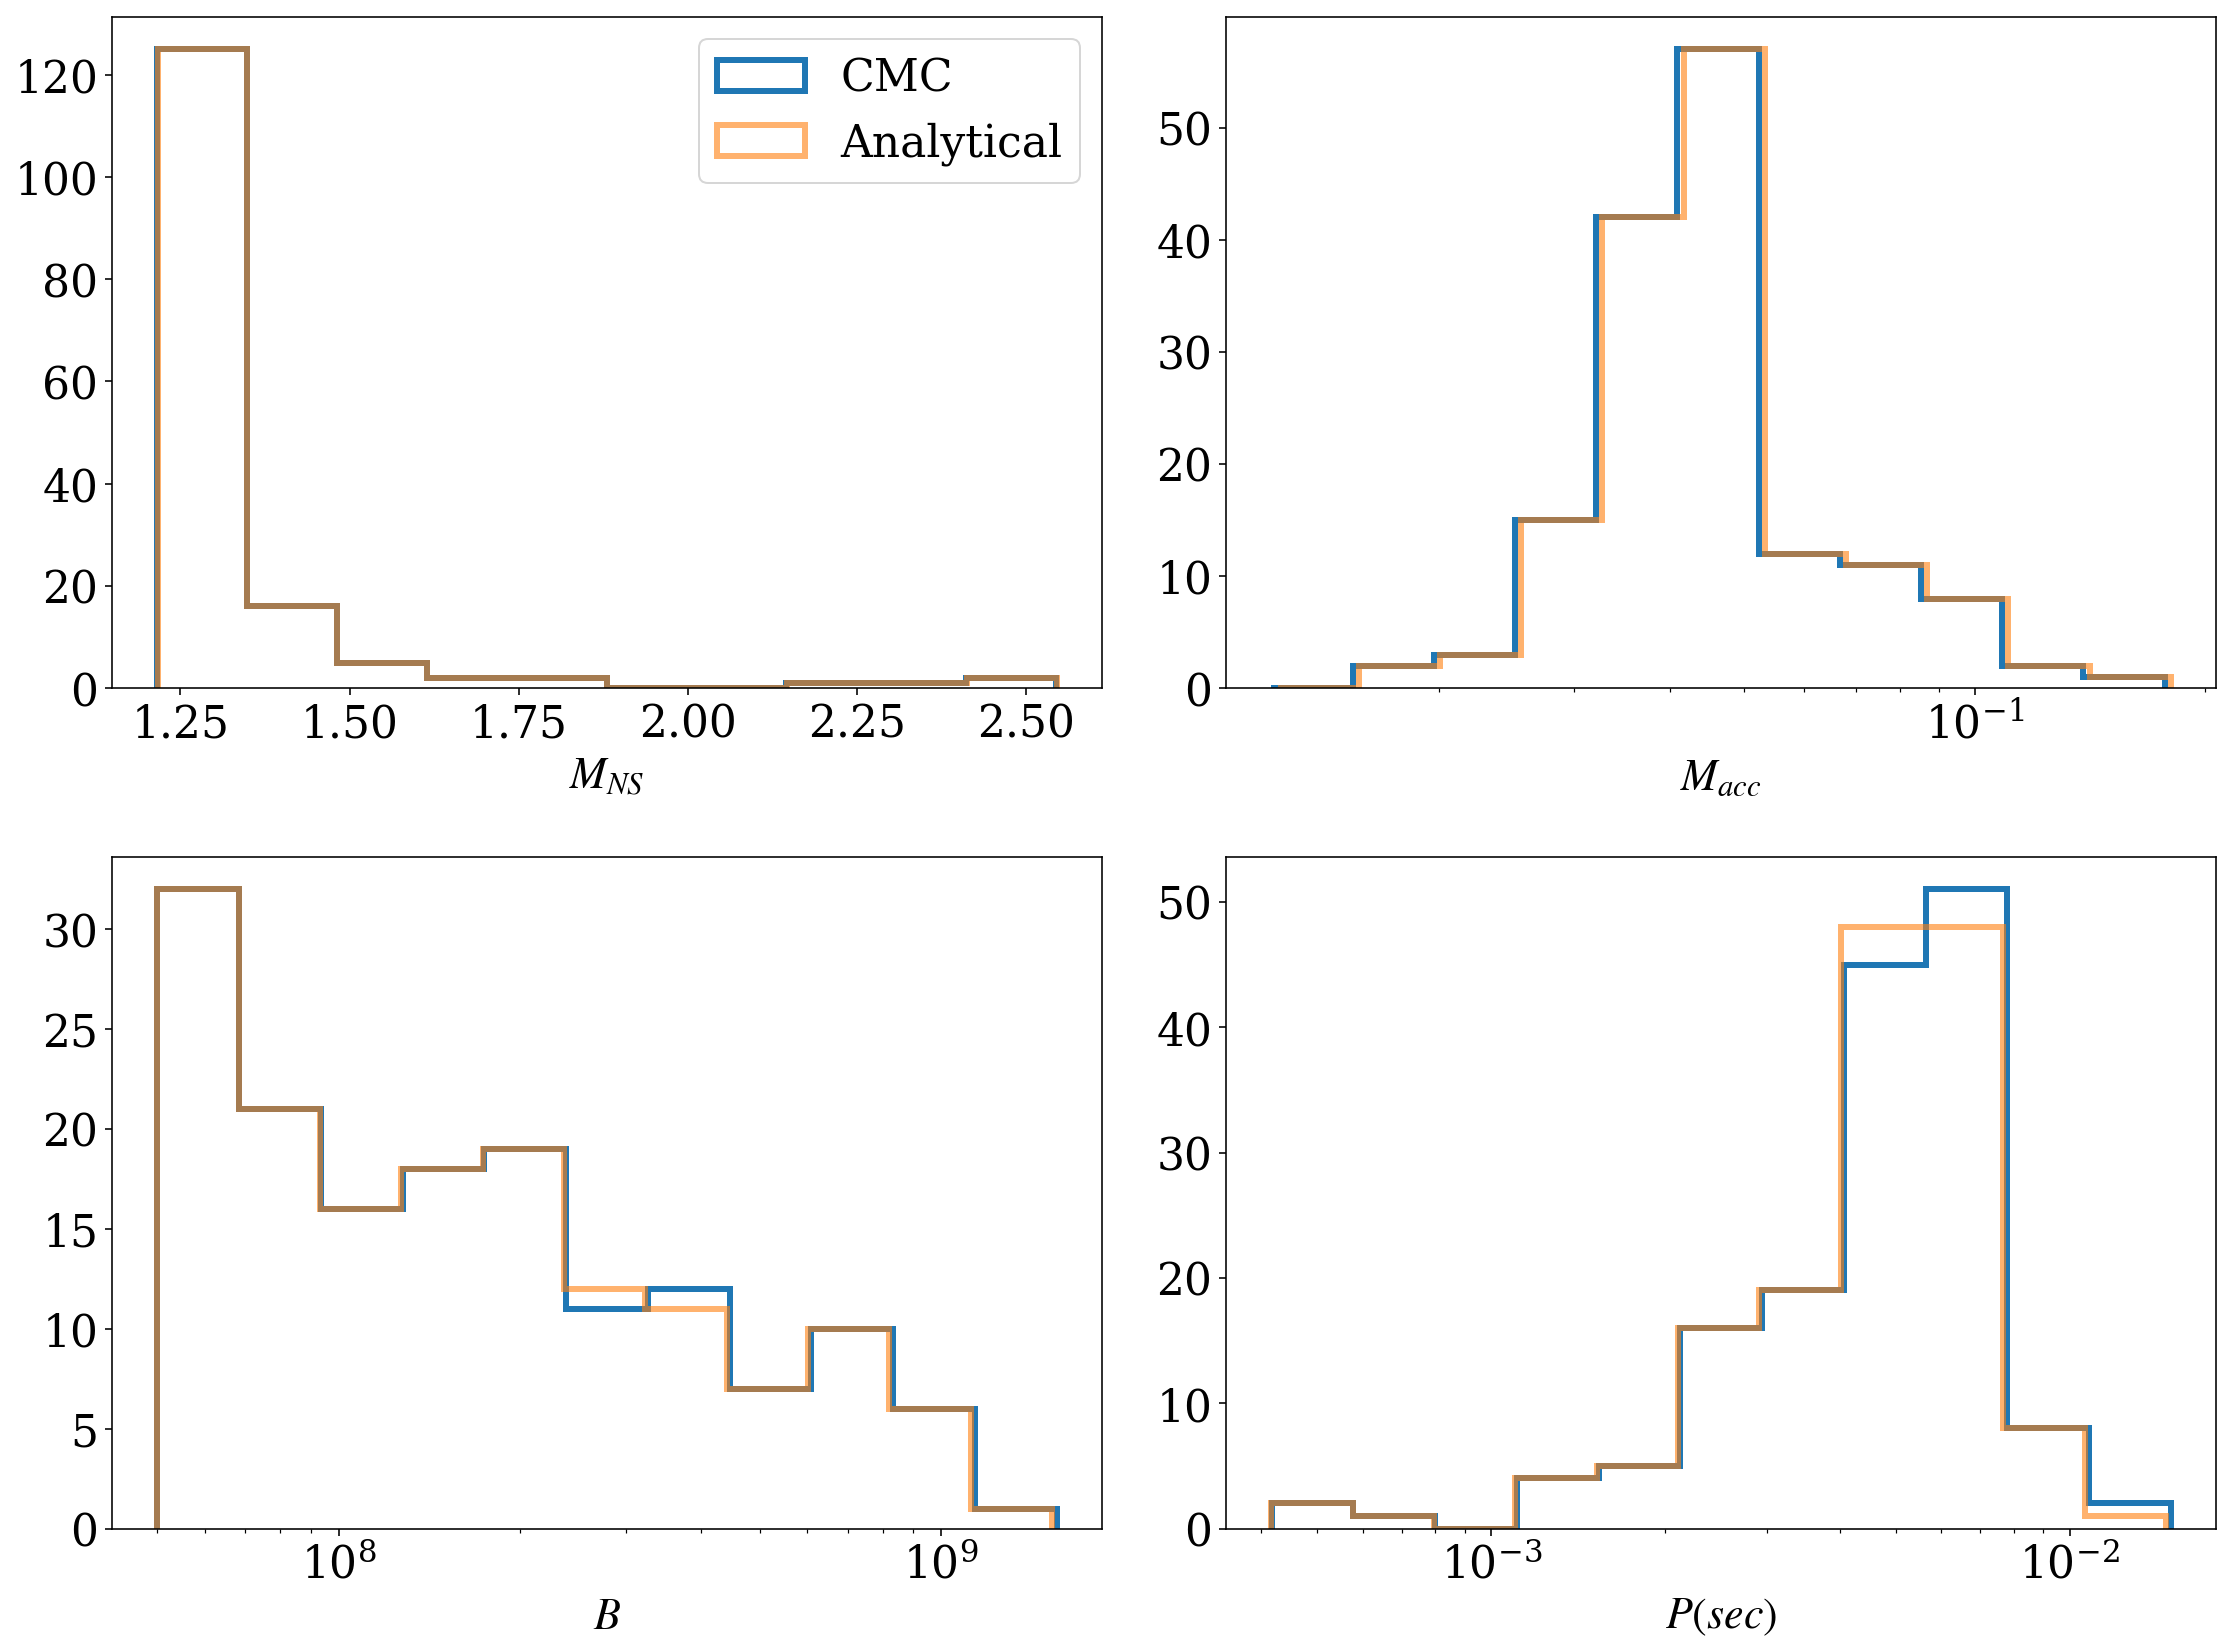

In [9]:
##Check if NS-MS TDE is actually working
error_out = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_s0.2/error.out'
m_ns = []; B_ns = []; Ospin_ns = []
m_new = []; B_new = []; Ospin_new = []; Macc = []
m_analy = []; B_analy = []; Ospin_analy = []; Macc_analy = []
m_analy_old = []; B_analy_old = []; Ospin_analy_old = []; Macc_analy_old = []
with open(error_out, 'r') as ferr:
    for line in ferr:
        data=line.split()
        if data[0]=='Before':
            m_star = float(data[3].split('=')[1])
            r_star = float(data[4].split('=')[1])
            k_star = float(data[5].split('=')[1])
            m_ns.append(float(data[6].split('=')[1]))
            B_ns.append(float(data[7].split('=')[1]))
            Ospin_ns.append(float(data[8].split('=')[1]))
            ospin_temp, B_temp, Mns_temp, Macc_temp = func_nsms_tde(float(data[6].split('=')[1]), 
                                                                    m_star, r_star, k_star, 
                                                                    float(data[7].split('=')[1]), 
                                                                    float(data[8].split('=')[1]))
            ospin_temp_old, B_temp_old, Mns_temp_old, Macc_temp_old = func_nsms_tde_old(float(data[6].split('=')[1]), 
                                                                    m_star, r_star, k_star, 
                                                                    float(data[7].split('=')[1]), 
                                                                    float(data[8].split('=')[1]))
            m_analy.append(Mns_temp); B_analy.append(B_temp); Ospin_analy.append(ospin_temp)
            Macc_analy.append(Macc_temp)
            m_analy_old.append(Mns_temp_old); B_analy_old.append(B_temp_old); Ospin_analy_old.append(ospin_temp_old)
            Macc_analy_old.append(Macc_temp_old)
        if data[0]=='After':
            m_new.append(float(data[3].split('=')[1]))
            B_new.append(float(data[4].split('=')[1]))
            Ospin_new.append(float(data[5].split('=')[1]))
            Macc.append(float(data[6].split('=')[1]))
            
Psec_new = twopi*yearsc/np.array(Ospin_new)
Psec_analy = twopi*yearsc/np.array(Ospin_analy)
Psec_analy_old = twopi*yearsc/np.array(Ospin_analy_old)
print(len(Psec_analy), len(Psec_analy[Psec_analy<=0.03]))
print(np.any(k_star>1))
            
#import extract_coll_merger as cm
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'
#cm.get_XX_collision([path_old], 0, 1, [13], path_old+'ns', 0)
collfile = np.genfromtxt(path_old+'ns_coll_all.dat')
Mns_old =collfile[:,4]; k0 = collfile[:,10]; k1 = collfile[:,11]
print(len(Mns_old))
index_nsms = []
for ii in range(len(k0)):
    if k0[ii]==0 or k0[ii]==1 or k1[ii]==0 or k1[ii]==1:
        index_nsms.append(ii)
Mnsms = Mns_old[index_nsms]
print(len(Mnsms))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
axs[0][0].hist(m_new, lw=3,
              histtype='step', label = 'CMC')
axs[0][0].hist(m_analy, lw=3,
              histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[0][0].hist(m_analy_old, lw=3,
#              histtype='step', label = 'Analytical Old',
#              alpha=0.6)
#axs[0][0].hist(Mnsms, lw=3, bins = 12,
#              histtype='step', label = 'Old model',
#              alpha=0.6)
axs[0][0].set_xlabel(r'$M_{NS}$')
axs[0][0].legend()

axs[0][1].hist(Macc,
              bins = np.logspace(np.log10(np.min(Macc)), np.log10(np.max(Macc)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[0][1].hist(Macc_analy,
               bins = np.logspace(np.log10(np.min(Macc_analy)), np.log10(np.max(Macc_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[0][1].hist(Macc_analy_old,
#               bins = np.logspace(np.log10(np.min(Macc_analy_old)), np.log10(np.max(Macc_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[0][1].set_xlabel(r'$M_{acc}$')
axs[0][1].set_xscale('log')

axs[1][0].hist(B_new, bins = np.logspace(np.log10(np.min(B_new)), np.log10(np.max(B_new)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[1][0].hist(B_analy,bins = np.logspace(np.log10(np.min(B_analy)), np.log10(np.max(B_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[1][0].hist(B_analy_old,bins = np.logspace(np.log10(np.min(B_analy_old)), np.log10(np.max(B_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[1][0].set_xscale('log')
axs[1][0].set_xlabel(r'$B$')

axs[1][1].hist(Psec_new,
               bins = np.logspace(np.log10(np.min(Psec_new)), np.log10(np.max(Psec_new)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[1][1].hist(Psec_analy,
               bins = np.logspace(np.log10(np.min(Psec_analy)), np.log10(np.max(Psec_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[1][1].hist(Psec_analy_old,
#               bins = np.logspace(np.log10(np.min(Psec_analy_old)), np.log10(np.max(Psec_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[1][1].set_xscale('log')
axs[1][1].set_xlabel(r'$P(sec)$')

fig.tight_layout()

In [7]:
##Check how many TDE happens during binary-mediated interactions
##And whether the NS is initially single annd whether it merge in a binary or isolated
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold_wdmass_nstde_test/'
nscoll = np.genfromtxt(path_new+'ns_coll_all.dat', dtype=str)
Mns_coll =nscoll[:,4]
k0 = [*map(int, nscoll[:,10])]; k1 = [*map(int, nscoll[:,11])]
k2 = [*map(int, nscoll[:,12])]; k3 = [*map(int, nscoll[:,13])]
type_coll=nscoll[:,-1]
print(len(k0))

n_ss = 0; n_nonss = 0
n_tri = 0; n_quad = 0
for kk in range(len(k0)):
    if k3[kk]==-100 and k2[kk]==-100:
        if k0[kk]<=1 or k1[kk]<=1:
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
    elif k3[kk]==-100:
        if (k0[kk]<=1 or k1[kk]<=1 or k2[kk]<=1):
            n_tri+=1
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
                
        k_array=np.sort([k0[kk],k1[kk],k2[kk]])
        print(k_array)
        
    else:
        if (k0[kk]<=1 or k1[kk]<=1 or k2[kk]<=1 or k3[kk]<=1):
            n_quad+=1
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
        k_array=np.sort([k0[kk],k1[kk],k2[kk],k3[kk]])
        print(k_array)

print(n_ss, n_nonss)
print(n_tri,n_quad)         
        


218
[ 6 12 13]
[ 0  1 13]
[ 1 11 13]
[ 1  3 13]
[ 1 11 13]
[ 0 11 13]
[ 0 11 13]
[ 1 12 13]
[ 0  0 13]
[ 6 11 13]
[ 1  1 13]
[ 1 11 13]
[ 1  1  1 13]
[ 4 10 13 13]
[ 1 11 13]
[ 0 11 13]
[ 3 11 13]
[ 1 11 13]
[ 2 10 13]
[ 1 12 13]
[ 0 11 13]
[ 3 11 13]
[ 0  1 13]
[ 0  0 13]
[ 0 12 13]
[ 1 11 13]
[ 0 11 13]
[ 0 13 14]
[ 3 12 13]
[ 0 11 13]
[ 0  0  1 13]
20 160
22 2


In [62]:
##Kicks
def vkick(alpha, Mns, Mstar, Rstar, rratio, Mej):
    rt = (Mns/Mstar)**(1./3.)*Rstar
    rp = rt*rratio
    if rp>rt:
        E_ej = Gconst_sun*Mns*Rstar/rp**2*PC_Rsun-0.5*Gconst_sun*(Mstar-Mej)*PC_Rsun/Rstar
    else:
        E_ej = Gconst_sun*Mns*Rstar/rt**2*PC_Rsun-0.5*Gconst_sun*(Mstar-Mej)*PC_Rsun/Rstar

    v_ej = math.sqrt(2*E_ej)
    v_max = Mej*v_ej/(Mns+Mstar-Mej)

    return v_max**(1-alpha*(Mns/Mstar)**(2/3)*rratio)

rratio_list = [0.5, 0.75, 1.]; Mej_list = [0.253, 0.136, 0.088] #[0.198, 0.353, 0.389] #
for ii in range(len(rratio_list)):
    print(vkick(0.5, 1.2, 1.2, 1.1, rratio_list[ii], Mej_list[ii]))
    

21.325873491937735
8.18724198142156
4.240857022108854


# WD-WD TC; Polypical index check

In [3]:
def R_WD(M_WD):   ##from SSE
    M_ch = 1.44
    R_WD = max(1.4e-5, 0.0115*math.sqrt((M_ch/M_WD)**(2/3)-(M_WD/M_ch)**(2/3)))
    
    return R_WD

print(R_WD(1.36))

def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))

0.0031751177903183744


-9.81304016231914


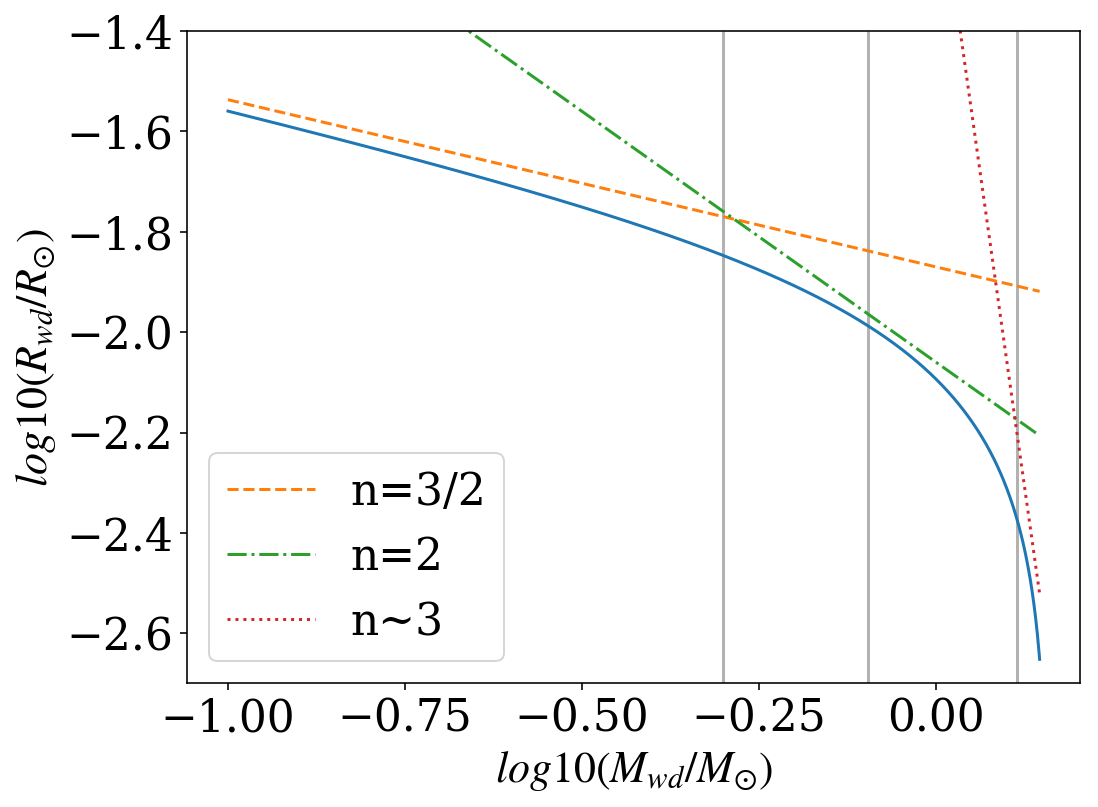

In [19]:
##Finding the mass cutoff for different polytropic index of WDs
mwd = np.linspace(0.1,1.4, 500)
rwd = []; rwd_low = []
for ii in range(len(mwd)):
    rwd.append(R_WD(mwd[ii]))
    rho_ave = mwd[ii]*Msun/(2*twopi/3*(R_WD(mwd[ii])*Rsun)**3)
    #if rho_ave >=1e6:
        #print(mwd[ii])
        
print((np.log10(rwd[499])-np.log10(rwd[470]))/(np.log10(mwd[499])-np.log10(mwd[470])))
        
y0 = np.log10(np.array(mwd)**(-1/3))-1.87
y1 = np.log10(np.array(mwd)**(-1))-2.06
y2 = np.log10(np.array(mwd)**(-10))-1.06

plt.figure(figsize=(8,6))
plt.plot(np.log10(mwd),np.log10(rwd))
plt.plot(np.log10(mwd), y0, ls='--', label='n=3/2')
plt.plot(np.log10(mwd), y1, ls='-.', label='n=2')
plt.plot(np.log10(mwd), y2, ls='dotted', label='n~3')
plt.vlines(math.log10(0.5), -2.7, -1.4, color='gray', alpha=0.6)
plt.vlines(math.log10(0.8), -2.7, -1.4, color='gray', alpha=0.6)
plt.vlines(math.log10(1.3), -2.7, -1.4, color='gray', alpha=0.6)
plt.ylim(ymax = -1.4, ymin= -2.7)
plt.xlabel(r'$log10(M_{wd}/M_{\odot})$')
plt.ylabel(r'$log10(R_{wd}/R_{\odot})$')
plt.legend(loc='best')

[0.021392743474959133, 0.01594811244062899, 0.012778467098439529, 0.010311127424985122, 0.008058157517676339, 0.005677022808780932, 0.0022288464855878044]
[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]


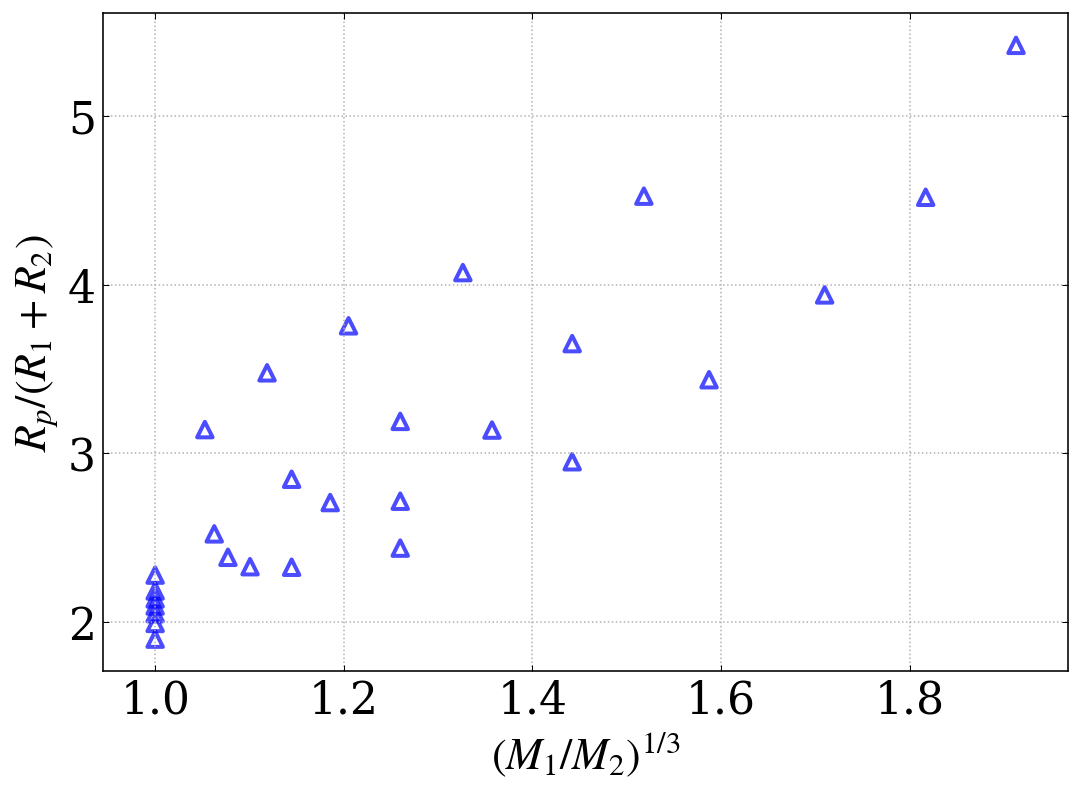

In [4]:
test_range=np.linspace(1,20,200)  ##for pericenter distance in WD radius
vel_disp = [1,10] ##km/s
M_wd = [0.2,0.4,0.6,0.8,1.0,1.2,1.4]
R_wd = [R_WD(M_wd[xx]) for xx in range(len(M_wd))]
n_wd = [[1.5,1.5,2.,2.,2.,2.,2.],[1.5,1.5,1.5,1.5,1.5,1.5,1.5]]
print(R_wd)
#M_pri = [1.3]
#R_pri = [R_WD(M_pri[xx]) for xx in range(len(M_pri))]
#n_pri = [2.]

R_fac = [[[],[]],[[],[]]]
m_ratio = [[[],[]],[[],[]]]
for bb in range(len(vel_disp)):
    for aa in range(2):
        #print(n_wd[aa])
        for ii in range(len(M_wd)):
            for jj in range(ii,len(M_wd)):
            #for jj in range(len(M_pri)):
                #E_kin = 0.5*M_wd[ii]*M_pri[jj]/(M_wd[ii]+M_pri[jj])*vel_disp[bb]**2
                E_kin = 0.5*M_wd[ii]*M_wd[jj]/(M_wd[ii]+M_wd[jj])*vel_disp[bb]**2
                #f = lambda x: E_oscillate(x*(R_wd[ii]+R_pri[jj]), M_wd[ii], R_wd[ii], n_wd[aa][ii], M_pri[jj])+E_oscillate(x*(R_wd[ii]+R_pri[jj]), M_pri[jj], R_pri[jj], n_pri[jj], M_wd[ii]) - E_kin
                f = lambda x: E_oscillate(x*(R_wd[ii]+R_wd[jj]), M_wd[ii], R_wd[ii], n_wd[aa][ii], M_wd[jj])+E_oscillate(x*(R_wd[ii]+R_wd[jj]), M_wd[jj], R_wd[jj], n_wd[aa][jj], M_wd[ii]) - E_kin

                root_range=[]
                root_range2=[]
                for yy in range(len(test_range)-1):
                    if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                        root_range.append(test_range[yy])
                        root_range.append(test_range[yy+1])
                        
                    if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                        root_range2.append(test_range[yy])
                        root_range2.append(test_range[yy+1])
                
                #print(root_range)
                #print(root_range2)
                if len(root_range)>2 or len(root_range2)>2:
                    print('more than 1 root')
                                              
                real_root = bisect(f, root_range[0],root_range[1])
                R_fac[bb][aa].append(real_root)
                #m_ratio[bb][aa].append(M_pri[jj]/M_wd[ii])
                m_ratio[bb][aa].append(M_wd[jj]/M_wd[ii])
                #print(M_wd[ii],M_pri[jj],real_root)
                #print(M_wd[ii],M_wd[jj],real_root)
    
cs=['orange','b']
mfmt = ['o','^']
#plt.figure(figsize=(8,6))
#plt.hist(R_fac[0], bins=12, histtype='step', 
#         lw=3, alpha=0.6, color='k')
#plt.hist(R_fac[1], bins=12, histtype='step', 
#         lw=3, alpha=0.8, color='gold')
##plt.vlines(np.mean(R_fac[0]),0,8, linestyle='--',color='k')
#plt.vlines(np.median(R_fac[0]),0,8, linestyle='-.',color='k')
##plt.vlines(np.mean(R_fac[1]),0,8, linestyle='--',color='gold')
#plt.vlines(np.median(R_fac[1]),0,8, linestyle='-.',color='gold')
#plt.xlabel(r'$R_{tidal}/R_{wd}$')

plt.figure(figsize=(8,6))
for xx in range(1,len(vel_disp)):
    for yy in range(1,2):
        print(n_wd[yy])
        plt.scatter(np.array(m_ratio[xx][yy])**(1/3),R_fac[xx][yy], 
                    color = cs[xx], marker=mfmt[yy], 
                    facecolor='none', s=60, alpha=0.7, lw=2)
plt.xlabel(r'$(M_1/M_2)^{1/3}$')
plt.ylabel(r'$R_p/(R_1+R_2)$')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')
plt.tight_layout()
plt.savefig(savepath+'crosssect_mratio.pdf', dpi=300)

In [13]:
##Estimate the inspiral time of a WD binary formed in tidal capture
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/PythonCodes/GW_strain')
import ecc_calc as LISA2
import LISA_calculations2 as LISA

M_wd = [0.6, 1.]; R_wd = [R_WD(M_wd[xx]) for xx in range(len(M_wd))]
ecc=0.99

for ii in range(len(M_wd)):
    for jj in range(ii,len(M_wd)):
        r_cap_au = 2*(R_wd[ii]+R_wd[jj])/AU_Rsun
        sma_au = r_cap_au/(1-ecc)
        t_tmp = LISA.t_inspiral_2(sma_au,ecc,M_wd[ii],M_wd[jj])/1.e6 # In Myr

        print(M_wd[ii], M_wd[jj], R_wd[ii], R_wd[jj], t_tmp, r_cap_au, sma_au)
        
##checking something random
t_bhns = LISA.t_inspiral_2(0.99512515,0.48304218,2.0123307,3.115911)/1.e6
print(t_bhns)

0.6 0.6 0.012778467098439529 0.012778467098439529 0.4062227244769293 0.00023780587409253824 0.023780587409253803
0.6 1.0 0.012778467098439529 0.008058157517676339 0.08077026039735971 0.00019388365176362322 0.019388365176362304
1.0 1.0 0.008058157517676339 0.008058157517676339 0.013875309127944907 0.0001499614294347082 0.014996142943470805
3790148201.632033


# WD Mass Change Check

nsform 6391
nsform=0 243
ns_wdwd: 70
0 20
1 4944
2 1313
3 2
4 14
5 98
6 0
7 0
mic? [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
aic? 12 0 1.24376 1.23602 4
aic? 12 66367 1.24202 1.37777 4
aic? 12 265392 1.24418 1.27613 4
aic? 12 93064 1.2473 1.31612 4
aic? 12 610121 1.24844 1.306 4
aic? 12 646559 1.24213 1.24752 4
aic? 12 21682 1.24201 1.36765 4
aic? 12 190870 1.24291 1.38 4
aic? 12 1273260 1.24202 1.38001 0
aic? 12 862922 1.24281 1.38 0
aic? 12 1321368 1.24255 1.35956 0
aic? 12 230394 1.24206 1.38 4
aic? 12 1103122 1.24262 1.38001 4
aic? 12 1235182 1.24229 1.38 0
aic? 12 1234184 1.24237 1.33429 4
aic? 12 822055 1.24229 1.38001 4
aic? 12 199536 1.24299 1.37404 0
aic? 12 68078 1.24235 1.38002 4
aic? 12 1406345 1.24271 1.38 0
aic? 12 581116 1.24215 1.34541 4
all_nscoll 118
97


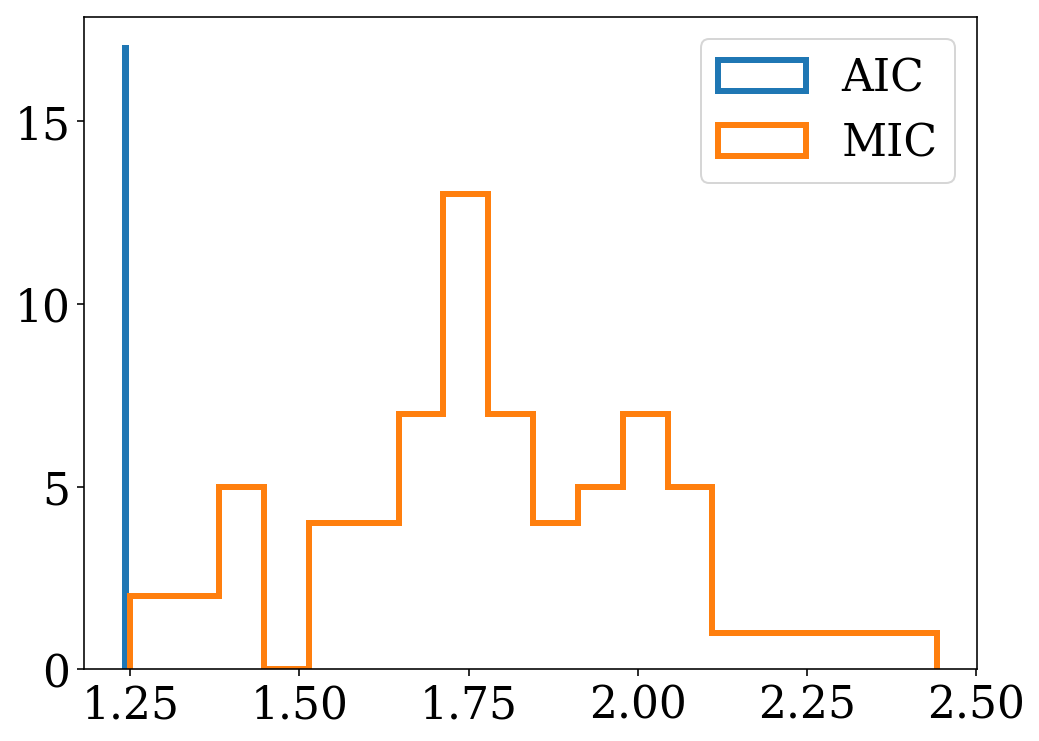

In [10]:
## Check the mass of WD turned NSs and how they are formed
path_test = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
nsform = np.genfromtxt(path_test+'initial.nsformation.dat')
idns = nsform[:,3].astype(np.int); massprev = nsform[:,6]
massns = nsform[:,7]; 
kprev = nsform[:,10].astype(np.int); kcomp = nsform[:,11].astype(np.int)
sntype = nsform[:,8].astype(np.int)
print('nsform', len(idns))
print('nsform=0', len(idns[idns==0]))
#print('nsform', len(idns[idns>839961]))
#print('kprev', len(kprev[kprev==12]))
#print('kprev', len(kprev[kprev==11]))
#print('kprev', len(kprev[kprev==10]))

wdwd_coll_file = np.genfromtxt(path_test+'ns_wdwd_coll.dat')
id_coll = wdwd_coll_file[:,2].astype(np.int)
m_coll = wdwd_coll_file[:,4]
print('ns_wdwd:', len(id_coll))


all_nscoll_file = np.genfromtxt(path_test+'ns_collproduct_all.dat')
id_nscoll = all_nscoll_file[:,2].astype(np.int)
m_nscoll = all_nscoll_file[:,4]
k0 = all_nscoll_file[:,10].astype(np.int)
k1 = all_nscoll_file[:,11].astype(np.int)
k2 = all_nscoll_file[:,12].astype(np.int)
k3 = all_nscoll_file[:,13].astype(np.int)


##Analysis
for ii in range(8):
    print(ii, len(sntype[sntype==ii]))
print('mic?', idns[sntype==5])
        
m_aic = []
for xx in range(len(idns)):
    if 10<=kprev[xx]<=12 and kcomp[xx]!=-100 and kcomp[xx]!=15:
        print('aic?',kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
        m_aic.append(massns[xx])
        
        #if idns[xx] in id_coll:
        #    print('yes')
        #else:
        #    print('no')
        
    #if idns[xx]==0:
    #    print('id=0', kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
    #if massprev[xx]<=2.88:
    #    print(kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
        
        


index_ns = []
for ii in range(len(k0)):
    if k0[ii]==13 or k1[ii]==13 or k2[ii]==13 or k3[ii]==13:
        index_ns.append(ii)
print('all_nscoll', len(np.delete(id_nscoll, index_ns)))


m_mic = []
for xx in range(len(idns)):
    if 10<= kprev[xx] <=12 and (kcomp[xx]==-100 or kcomp[xx]==15):
        #print(kcomp[xx])
        #if idns[xx] not in id_coll:
        #    print(idns[xx])
        m_mic.append(massns[xx])
                   
print(len(m_mic))

m_mic = m_coll
plt.figure(figsize = (8,6))
plt.hist(m_aic, bins = 3, 
         histtype = 'step',
         lw = 3, label='AIC')
plt.hist(m_mic, bins = 18, 
         histtype = 'step',
         lw = 3, label='MIC')
#plt.xscale('log')
plt.legend()

336
589


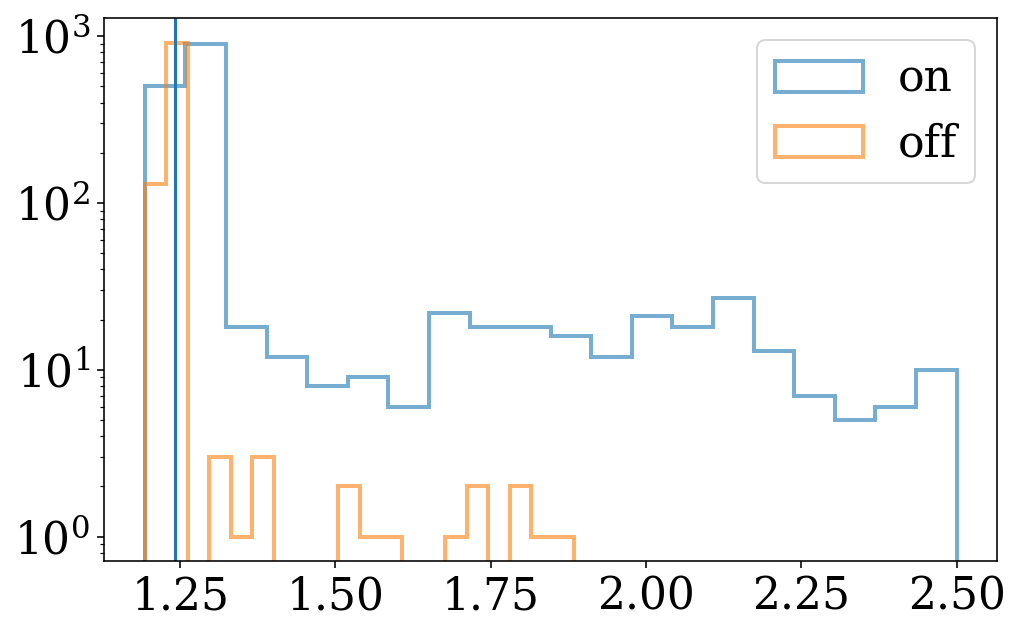

In [3]:
##Check how removing the WD mass limit affect AIC
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
psrfile = path+'initial.morepulsars.dat'
path_off = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff/'
psrfile_off = path_off+'initial.morepulsars.dat'

t_conv = dyn.conv('t', path+'initial.conv.sh')
t_conv_off = dyn.conv('t', path_off+'initial.conv.sh')

allid = []; tform = []; mform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1])*t_conv)
                mform.append(float(data[5]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[5]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[6]))

mform = np.array(mform)
print(len(mform[mform<1.245]))

allid_off = []; tform_off = []; mform_off = []
with open(psrfile_off, 'r') as fpsr_off:
    next(fpsr_off)
    for line in fpsr_off:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid_off:
                allid_off.append(int(data[3]))
                tform_off.append(float(data[1])*t_conv_off)
                mform_off.append(float(data[5]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid_off:
                    allid_off.append(int(data[3]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[5]))
            if int(data[12])==13:
                if int(data[4]) not in allid_off:
                    allid_off.append(int(data[4]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[6]))
                    
mform_off = np.array(mform_off)
print(len(mform_off[mform_off<1.245]))

#snap_h5 = 'initial.snapshots.h5'
#snap_last = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/423(t=19.263837)', conv=path+'initial.conv.sh')
#binflag = np.array(snap_last.data['binflag'])
#id0 = np.array(snap_last.data['id0'])[binflag==1]; id1 = np.array(snap_last.data['id1'])[binflag==1]
#ids = np.array(snap_last.data['id'])[binflag!=1]
#formation = np.array(snap_last.data['formation'])[binflag!=1]
#formation0 = np.array(snap_last.data['formation0'])[binflag==1]; formation1 = np.array(snap_last.data['formation1'])[binflag==1]
#print(ids)
#print(allid)
#print(len(formation), len(formation[formation==11]))
#
#snform = np.zeros(len(mform))
#for ii in range(len(allid)):
#    for xx in range(len(ids)):
#        if ids[xx]==allid[ii]:
#            snform[ii]==formation[xx]
#            break
#    for yy in range(len(id0)):
#        if id0[yy]==allid[ii]:
#            snform[ii]==formation0[yy]
#            break
#    for zz in range(len(id1)):
#        if id1[zz]==allid[ii]:
#            snform[ii]==formation1[zz]
#
#print(mform[snform==4], len(print(mform[snform==4])))
            
plt.figure(figsize=(8,5))
plt.hist(mform, bins = 20, label='on',
         histtype='step', lw=2, alpha=0.6)
         #bins=np.logspace(np.log10(np.min(mform)), np.log10(np.max(mform)), 20))
plt.hist(mform_off, bins = 20, label='off',
         histtype='step', lw=2, alpha=0.6)
plt.axvline(x=1.242)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

303
Counter({2: 1188, 0: 240, 1: 130, 5: 65, 4: 13})
588
Counter({2: 996, 1: 45, 0: 22})


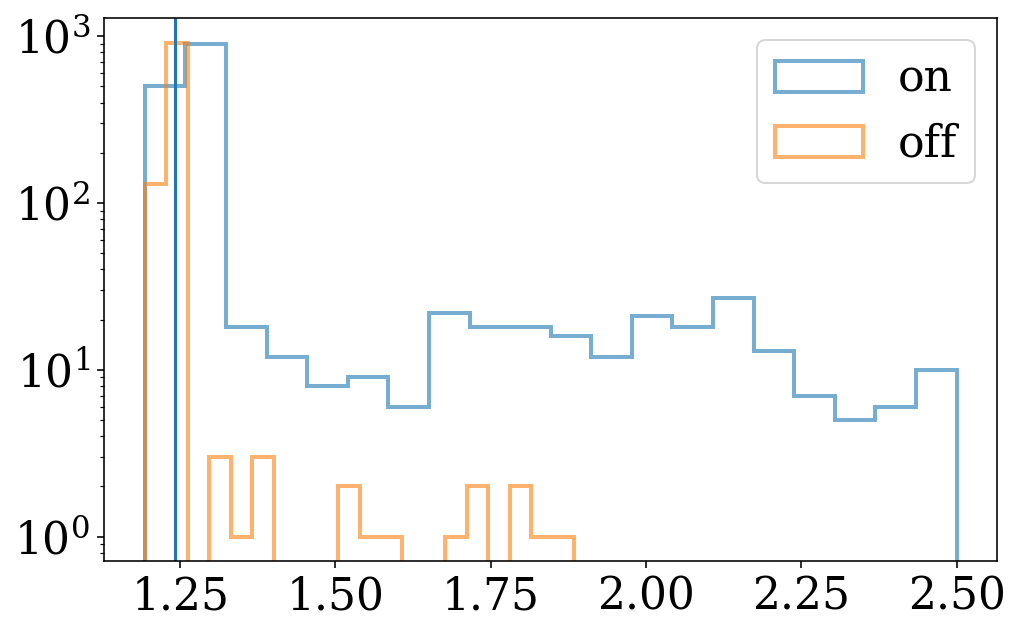

In [4]:
##Check if the wd mass lim is working
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
psrfile = path+'initial.morepulsars.dat'
path_off = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff/'
psrfile_off = path_off+'initial.morepulsars.dat'

t_conv = dyn.conv('t', path+'initial.conv.sh')
t_conv_off = dyn.conv('t', path_off+'initial.conv.sh')

allid = []; tform = []; mform = []
snform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1])*t_conv)
                mform.append(float(data[5]))
                snform.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[5]))
                    snform.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[6]))
                    snform.append(int(data[27]))

mform = np.array(mform)
print(len(mform[mform<=1.242]))
print(Counter(snform))

allid_off = []; tform_off = []; mform_off = []
snform_off = []
with open(psrfile_off, 'r') as fpsr_off:
    next(fpsr_off)
    for line in fpsr_off:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid_off:
                allid_off.append(int(data[3]))
                tform_off.append(float(data[1])*t_conv_off)
                mform_off.append(float(data[5]))
                snform_off.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid_off:
                    allid_off.append(int(data[3]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[5]))
                    snform_off.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid_off:
                    allid_off.append(int(data[4]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[6]))
                    snform_off.append(int(data[27]))
                    
mform_off = np.array(mform_off)
print(len(mform_off[mform_off<=1.242]))
print(Counter(snform_off))

#snap_h5 = 'initial.snapshots.h5'
#snap_last = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/423(t=19.263837)', conv=path+'initial.conv.sh')
#binflag = np.array(snap_last.data['binflag'])
#id0 = np.array(snap_last.data['id0'])[binflag==1]; id1 = np.array(snap_last.data['id1'])[binflag==1]
#ids = np.array(snap_last.data['id'])[binflag!=1]
#formation = np.array(snap_last.data['formation'])[binflag!=1]
#formation0 = np.array(snap_last.data['formation0'])[binflag==1]; formation1 = np.array(snap_last.data['formation1'])[binflag==1]
#print(ids)
#print(allid)
#print(len(formation), len(formation[formation==11]))
#
#snform = np.zeros(len(mform))
#for ii in range(len(allid)):
#    for xx in range(len(ids)):
#        if ids[xx]==allid[ii]:
#            snform[ii]==formation[xx]
#            break
#    for yy in range(len(id0)):
#        if id0[yy]==allid[ii]:
#            snform[ii]==formation0[yy]
#            break
#    for zz in range(len(id1)):
#        if id1[zz]==allid[ii]:
#            snform[ii]==formation1[zz]
#
#print(mform[snform==4], len(print(mform[snform==4])))
            
plt.figure(figsize=(8,5))
plt.hist(mform, bins = 20, label='on',
         histtype='step', lw=2, alpha=0.6)
         #bins=np.logspace(np.log10(np.min(mform)), np.log10(np.max(mform)), 20))
plt.hist(mform_off, bins = 20, label='off',
         histtype='step', lw=2, alpha=0.6)
plt.axvline(x=1.242)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

303
Counter({2: 1188, 0: 240, 1: 130, 5: 65, 4: 13})
[ 707858   66367  265392   93064  610121  646559   21682 1234412 1105353
   68078  581116  942229  942230] [1.2437578 1.2852296 1.2521376 1.2573622 1.3063457 1.2902367 1.3089979
 1.3064632 1.2521376 1.3000888 1.2698659 2.4264903 2.4264903]
707858 [707858] [12] [1.2360978]
66367 [66367] [12] [1.3778022]
265392 [265392] [13] [1.25213763]
93064 [93064] [12] [1.31619318]
610121 [610121] [12] [1.30599887]
646559 [646559] [12] [1.25390342]
21682 [21682] [13] [1.30899792]
1234412 couldn't find
1105353 couldn't find
68078 [68078] [12] [1.34793159]
581116 [581116] [12] [1.34540571]
942229 couldn't find
942230 [942230] [13] [2.4264903]
[1548801  892400  850575 1032637  922301  850576  839964 1203605  888545
  941749 1137221 1104820 1107099 1162222  888547 1186768 1097768  883889
  954206 1306026 1137222  857641 1030957 1083585  957123  944529 1107100]
ejected 1102185
ejected 935016
[929729, 829805, 620956, 857071, 829420, 805215, 830679, 83359

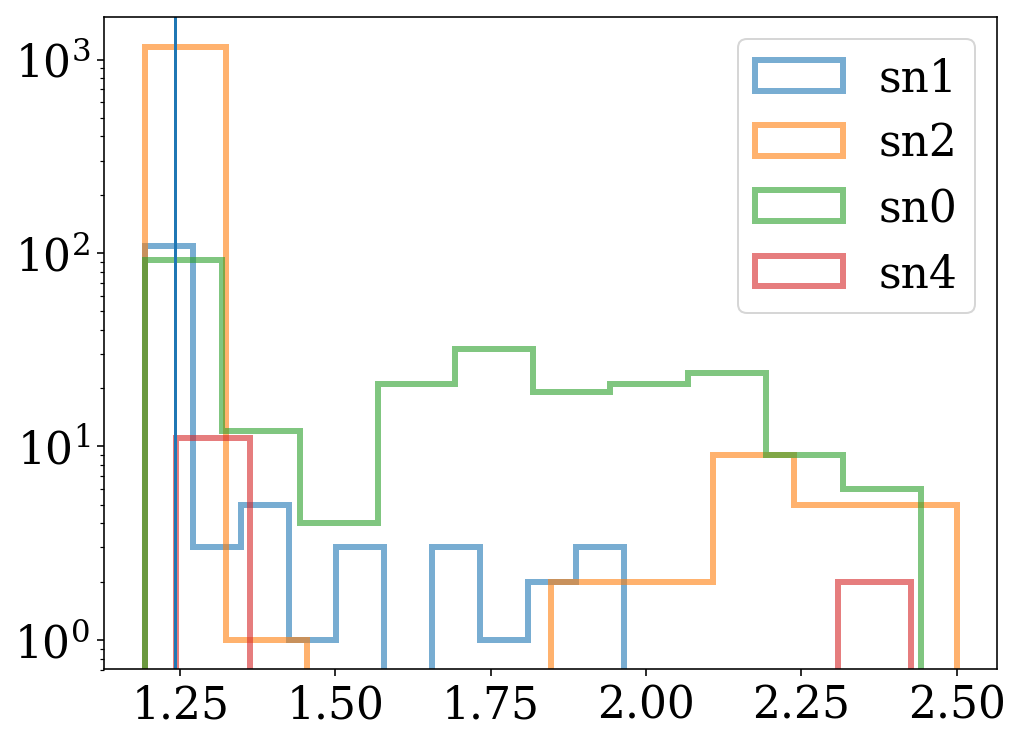

In [6]:
##Check AIC and WD-WD merger (not collisions)
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
psrfile = path+'initial.morepulsars.dat'
collfile = np.genfromtxt(path+'ns_wdwd_coll.dat')
idcoll = collfile[:,2].astype(np.int)

snap_h5 = 'initial.snapshots.h5'

t_conv = dyn.conv('t', path+'initial.conv.sh')

snapkeys = np.genfromtxt(path+'snap_keys.txt', dtype=str)
snpno = snapkeys[:,0]; snptime = snapkeys[:,1]
snptime_float = snptime.astype(np.float)

allid = []; tform = []; mform = []
snform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1]))#*t_conv)
                mform.append(float(data[5]))
                snform.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1]))#*t_conv)
                    mform.append(float(data[5]))
                    snform.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1]))#*t_conv)
                    mform.append(float(data[6]))
                    snform.append(int(data[27]))

mform = np.array(mform)
snform = np.array(snform)
allid = np.array(allid)
tform = np.array(tform)
print(len(mform[mform<=1.242]))
print(Counter(snform))


idsn4 = allid[snform==4]
tsn4 = tform[snform==4]
print(idsn4, mform[snform==4])
for xx in range(len(idsn4)):
    check_ind = np.where(snptime_float>tsn4[xx])[0][0]-1
    #print(check_ind)
    snpkey = '/'+snpno[check_ind]+'(t='+snptime[check_ind]+')'
    snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name=snpkey, conv=path+'initial.conv.sh')
    binflag = np.array(snap.data['binflag'])
    id0 = np.array(snap.data['id0'])[binflag==1]; id1 = np.array(snap.data['id1'])[binflag==1]
    ids = np.array(snap.data['id'])[binflag!=1]
    ktype = np.array(snap.data['startype'])[binflag!=1]
    k0 = np.array(snap.data['bin_startype0'])[binflag==1]
    k1 = np.array(snap.data['bin_startype1'])[binflag==1]
    mstar = np.array(snap.data['m_MSUN'])[binflag!=1]
    m0 = np.array(snap.data['m0_MSUN'])[binflag==1]
    m1 = np.array(snap.data['m1_MSUN'])[binflag==1]
    if idsn4[xx] in ids:
        print(idsn4[xx], ids[ids==idsn4[xx]], ktype[ids==idsn4[xx]], mstar[ids==idsn4[xx]])
    elif idsn4[xx] in id0:
        print(idsn4[xx], id0[id0==idsn4[xx]], k0[id0==idsn4[xx]], m0[id0==idsn4[xx]])
    elif idsn4[xx] in id1:
        print(idsn4[xx], id1[id1==idsn4[xx]], k1[id1==idsn4[xx]], m1[id1==idsn4[xx]])
    else:
        print(idsn4[xx], "couldn't find")
        
idsn2 = allid[snform==2]
msn2 = mform[snform==2]
print(idsn2[msn2>1.3])

idsn0 = allid[snform==0]
msn0 = mform[snform==0]
ncoll = 0
idsn0_notcoll = []
for xx in range(len(idcoll)):
    if idcoll[xx] in idsn0:
        ncoll+=1
    else:
        print('ejected', idcoll[xx])   
        
for xx in range(len(idsn0)):
    if idsn0[xx] not in idcoll:
        idsn0_notcoll.append(idsn0[xx])
        
print(idsn0_notcoll)
print(ncoll)

idspec = 815027
tspec = 0.13651785
indspec = np.where(snptime_float>tspec)[0][0]-2
snpkey = '/'+snpno[indspec]+'(t='+snptime[indspec]+')'
snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name=snpkey, conv=path+'initial.conv.sh')
binflag = np.array(snap.data['binflag'])
id0 = np.array(snap.data['id0'])[binflag==1]; id1 = np.array(snap.data['id1'])[binflag==1]
ids = np.array(snap.data['id'])[binflag!=1]
ktype = np.array(snap.data['startype'])[binflag!=1]
k0 = np.array(snap.data['bin_startype0'])[binflag==1]
k1 = np.array(snap.data['bin_startype1'])[binflag==1]
mstar = np.array(snap.data['m_MSUN'])[binflag!=1]
m0 = np.array(snap.data['m0_MSUN'])[binflag==1]
m1 = np.array(snap.data['m1_MSUN'])[binflag==1]
if idspec in ids:
    print(idspec, ids[ids==idspec], ktype[ids==idspec], mstar[ids==idspec])
elif idspec in id0:
    print(idspec, id0[id0==idspec], k0[id0==idspec], m0[id0==idspec])
elif idspec in id1:
    print(idspec, id1[id1==idspec], k1[id1==idspec], m1[id1==idspec])
else:
    print(idspec, "couldn't find")


plt.figure(figsize=(8,6))
#plt.hist(mform, histtype='step', lw=3, alpha=0.6)
plt.hist(mform[snform==1], histtype='step', lw=3, alpha=0.6, label='sn1')
plt.hist(mform[snform==2], histtype='step', lw=3, alpha=0.6, label='sn2')
plt.hist(mform[snform==0], histtype='step', lw=3, alpha=0.6, label='sn0')
plt.hist(mform[snform==4], histtype='step', lw=3, alpha=0.6, label='sn4')
plt.axvline(x=1.242)
plt.yscale('log')
plt.legend()

False


(array([ 4.,  5.,  5., 15., 15.,  9., 11.,  2.,  2.,  2.]),
 array([1.2489147 , 1.36823733, 1.48755996, 1.60688259, 1.72620522,
        1.84552785, 1.96485048, 2.08417311, 2.20349574, 2.32281837,
        2.442141  ]),
 <a list of 1 Patch objects>)

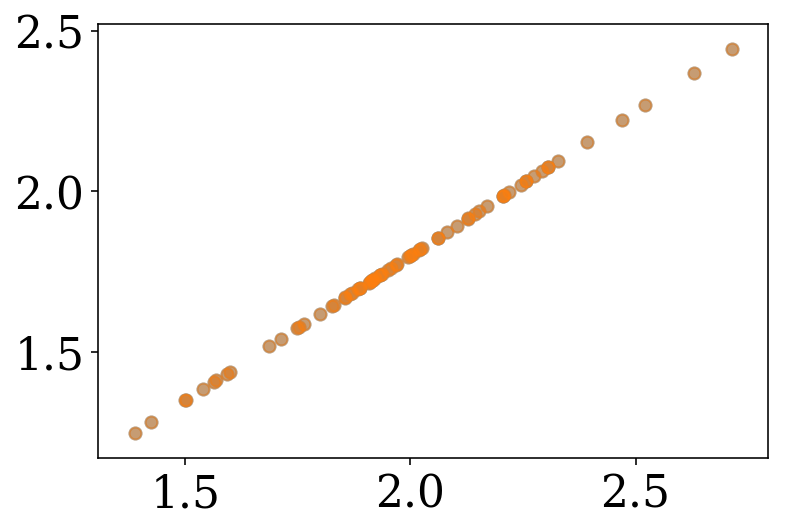

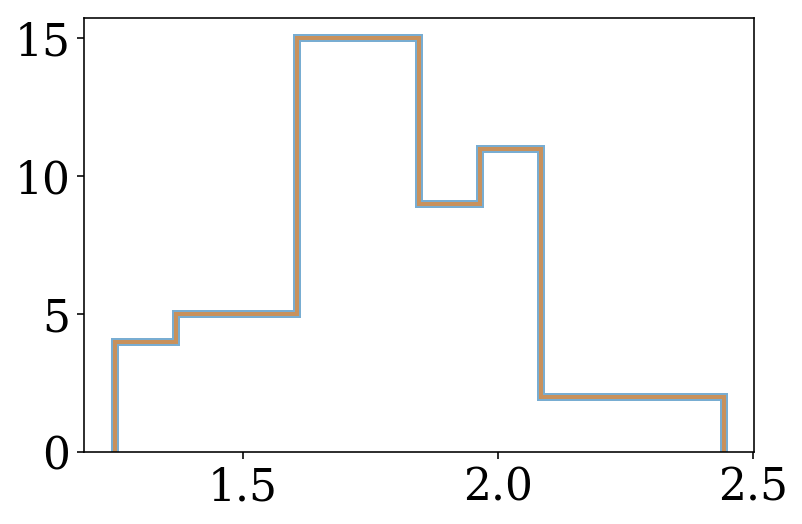

In [7]:
##WD merger and collison to NS
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
collfile = np.genfromtxt(path+'ns_wdwd_coll.dat')
Mcoll = collfile[:,4]; M0 = collfile[:,5]; M1 = collfile[:,6]
Mns = 0.9*(M0+M1)

print(np.any(Mcoll<=1.242))

plt.figure()
plt.scatter(M0+M1, Mcoll, alpha=0.5)
plt.scatter(M0+M1, Mns, alpha=0.5)

plt.figure()
plt.hist(Mcoll, histtype='step', lw=4, alpha=0.6)
plt.hist(Mns, histtype='step', lw=2, alpha=0.6)

# Qcrit tests

4986
3936
3936
366
261
261
4418
2992
2992


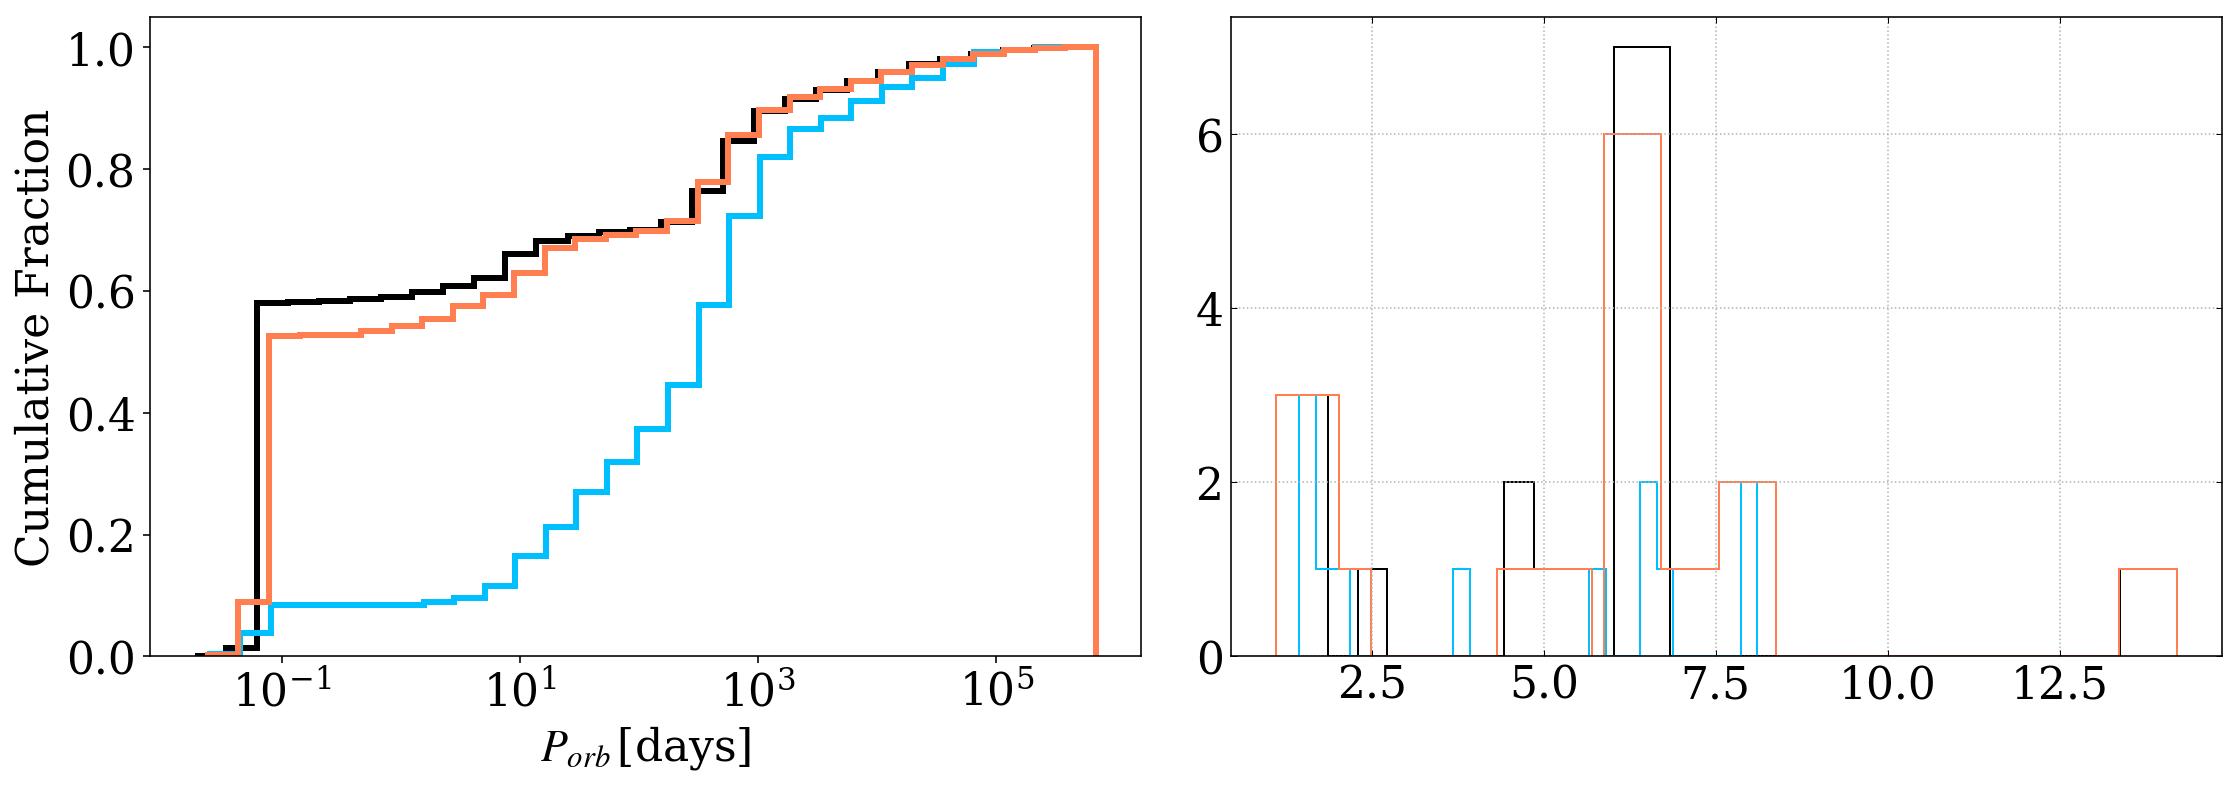

In [4]:
##COSMIC run NS-XX binaries with qcrit change
folders = ['qcrit1_diff_ic/', 'qcrit4_diff_ic/', 'qcrit5_diff_ic/']
colors = ['k', 'deepskyblue', 'coral']
labs = ['qcrit=1', 'qcrit=4', 'qcrit=5']

###Maybe can plot it this way?
def scatter_hist(x1, y1, lb, cs, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1, s = 10,  label = lb, color = cs, alpha=0.5)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 30), 
                  log=True, color = cs, histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 30), orientation='horizontal',
                 log=True, color = cs, histtype = 'step', lw = 3)
    
    ax.set_xlim(xmin = 0.004, xmax = 2)
    #ax.set_ylim(ymin = 0.01, ymax = 10**12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_c\, (\rm{M_{\odot}})$')
    ax.set_ylabel(r'$P_{orb}\,$(days)')
    ax.legend(loc = 'upper left', fontsize = 18, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
#fig = plt.figure(figsize=(10, 10))

#ax = fig.add_axes(rect_scatter)
#ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)

fig,axs = plt.subplots(ncols=2, figsize=[16,6])
for xx in range(len(folders)):
    conv = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='conv')
    bcm = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='bcm')
    bpp = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='bpp')
    
    #print(bcm)
    #print(bpp)
    #print(bcm.loc[bcm.tphys==13700., ['kstar_1','kstar_2','mass_1','mass_2','omega_spin_1', 'omega_spin_2']])
    #print(len(bcm.loc[bcm.tphys==13700., ['kstar_1','kstar_2','mass_1','mass_2','porb']]))
    print(len(bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13), 
                      ['kstar_1','kstar_2','mass_1','mass_2','porb']]))
    print(len(bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13) & (bcm.omega_spin_1>6.6e9), 
                      ['kstar_1','kstar_2','mass_1','mass_2','porb']]))
    mc = bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13) & (bcm.omega_spin_1>6.6e9), 'mass_2']
    porb = bcm.loc[(bcm.tphys==13700.) & (((bcm.kstar_1==13) & (bcm.omega_spin_1>6.6e9)) | 
                                         ((bcm.kstar_2==13) & (bcm.omega_spin_2>6.6e9))), 'porb']
    m0 = bcm.loc[(bcm.tphys==0.0), 'mass_1']
    m1 = bcm.loc[(bcm.tphys==0.000000), 'mass_2']
    #porb = porb[porb>0]
    print(len(porb))

    axs[0].hist(porb, #bins = 30,
            bins=np.logspace(np.log10(np.min(porb)), np.log10(np.max(porb)), 30),
            cumulative=True, density=True, log=False,
            color=colors[xx], histtype='step', lw=3, label = labs[xx])
    #scatter_hist(mc, porb, labs[xx], colors[xx], ax, ax_histx, ax_histy)
    
    axs[1].hist(m0, histtype='step', color=colors[xx])
    axs[1].hist(m1, histtype = 'step', color=colors[xx])

axs[0].set_xscale('log')
#ax.set_yscale('log')
axs[0].set_xlabel(r'$P_{orb}\,$[days]')
axs[0].set_ylabel('Cumulative Fraction')
#ax.set_xlim(xmax=1000)
#ax.set_ylim(ymax = 1250)
#ax.legend(loc = 'upper right')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')
fig.tight_layout()

plt.savefig(savepath+'qcrit_comp_cumu.pdf', dpi=300)

In [ ]:
##Number of NSs and BHs comparison between old 6752 and new 6752 models
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold_wdmass_nstde_test/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

ns_new = np.genfromtxt(path_new+'initial.ns.dat')
bh_new = np.genfromtxt(path_new+'initial.bh.dat')
tconv_new = dyn.conv('t', path_new+'initial.conv.sh')

ns_old = np.genfromtxt(path_old+'initial.ns.dat')
bh_old = np.genfromtxt(path_old+'initial.bh.dat')
tconv_old = dyn.conv('t', path_old+'initial.conv.sh')


plt.figure(figsize = (8,6))
plt.plot(ns_new[:,0], ns_new[:,1], label='NS', 
         color = 'orange', alpha=0.8)
plt.plot(ns_old[:,0]*tconv_old, ns_old[:,1],
         color = 'orange', alpha=0.8, ls = '--')

plt.plot(bh_new[:,1]*tconv_new, bh_new[:,2], label='BH', 
         color = 'k', alpha=0.8)
plt.plot(bh_old[:,1]*tconv_old, bh_old[:,2],
         color = 'k', alpha=0.8, ls = '--')

plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('t(Myr)')
plt.ylabel('N')
plt.xlim(xmin = 0.)
plt.ylim(ymin = 0.)
plt.legend()

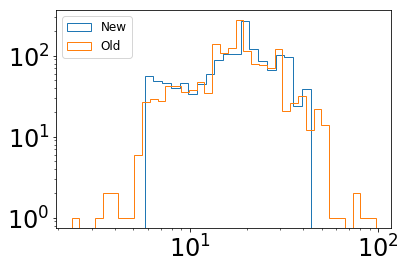

In [21]:
##Compare mass of BH at formation
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

bhform_new = np.genfromtxt(path_new+'initial.bhformation.dat')
mbh_new = bhform_new[:,6]
mbh_old = []
with open(path_old+'initial.bhformation.dat', 'r') as fbhf:
    next(fbhf)
    for line in fbhf:
        data = line.split()
        mbh_old.append(float(data[6]))

plt.figure()
plt.hist(mbh_new, bins = np.logspace(np.min(np.log10(mbh_new)), np.max(np.log10(mbh_new)), 20), 
         histtype='step', label = 'New')
plt.hist(mbh_old, bins = np.logspace(np.min(np.log10(mbh_old)), np.max(np.log10(mbh_old)), 40), 
         histtype='step', label = 'Old')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper left', fontsize=12)

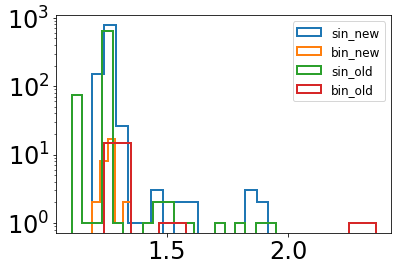

In [6]:
##Compare mass of NSs
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', snapshot_name='/341(t=19.263855)',
                        conv=path_new+'initial.conv.sh')
binflag = snap341.data['binflag']
m_sin = snap341.data['m_MSUN'][binflag!=1]
m0 = snap341.data['m0_MSUN'][binflag==1]; m1 = snap341.data['m1_MSUN'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

m12_sin_new = list(m_sin[ktype==13])
m12_bin_new = list(m0[k0==13])+list(m1[k1==13])

m12_sin_old = []
m12_bin_old = []
with gzip.open(path_old+'initial.snap0597.dat.gz', 'r') as fsnap:
    next(fsnap); next(fsnap)
    for line in fsnap:
        data = line.split()
        if int(data[7])!=1 and int(data[14])==13:
            m12_sin_old.append(float(data[1]))
        elif int(data[7])==1 and int(data[17])==13:
            m12_bin_old.append(float(data[8]))
        elif int(data[7])==1 and int(data[18])==13:
            m12_bin_old.append(float(data[9]))
            
plt.figure()
plt.hist(m12_sin_new, histtype='step', lw = 2, label = 'sin_new', bins=15)
plt.hist(m12_bin_new, histtype='step', lw = 2, label = 'bin_new', bins=5)
plt.hist(m12_sin_old, histtype='step', lw = 2, label = 'sin_old', bins=20)
plt.hist(m12_bin_old, histtype='step', lw = 2, label = 'bin_old', bins=10)

plt.yscale('log')
plt.legend(fontsize=12)

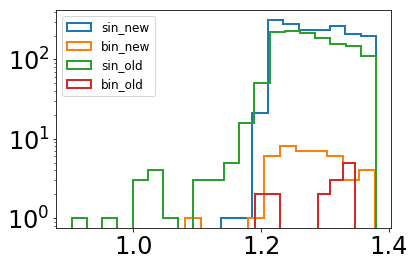

In [3]:
##Compare mass of ONe WDs
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', snapshot_name='/341(t=19.263855)',
                        conv=path_new+'initial.conv.sh')
binflag = snap341.data['binflag']
m_sin = snap341.data['m_MSUN'][binflag!=1]
m0 = snap341.data['m0_MSUN'][binflag==1]; m1 = snap341.data['m1_MSUN'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

m12_sin_new = list(m_sin[ktype==12])
m12_bin_new = list(m0[k0==12])+list(m1[k1==12])

m12_sin_old = []
m12_bin_old = []
with gzip.open(path_old+'initial.snap0597.dat.gz', 'r') as fsnap:
    next(fsnap); next(fsnap)
    for line in fsnap:
        data = line.split()
        if int(data[7])!=1 and int(data[14])==12:
            m12_sin_old.append(float(data[1]))
        elif int(data[7])==1 and int(data[17])==12:
            m12_bin_old.append(float(data[8]))
        elif int(data[7])==1 and int(data[18])==12:
            m12_bin_old.append(float(data[9]))
            
plt.figure()
plt.hist(m12_sin_new, histtype='step', lw = 2, label = 'sin_new', bins=10)
plt.hist(m12_bin_new, histtype='step', lw = 2, label = 'bin_new', bins=12)
plt.hist(m12_sin_old, histtype='step', lw = 2, label = 'sin_old', bins=20)
plt.hist(m12_bin_old, histtype='step', lw = 2, label = 'bin_old', bins=8)

plt.yscale('log')
plt.legend(fontsize=12)

In [9]:
##BHs at 13Gyr
snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', 
                snapshot_name='/341(t=19.263855)', conv=path_new+'initial.conv.sh')

snap0 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', 
                snapshot_name='/0(t=0)', conv=path_new+'initial.conv.sh')

binflag = snap341.data['binflag']
id_sin = snap341.data['id'][binflag!=1]
id0 = snap341.data['id0'][binflag==1]; id1 = snap341.data['id1'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

bh_sin = list(id_sin[ktype==14])
bh_bin = list(id0[k0==14])+list(id1[k1==14])
print(bh_sin, bh_bin)

binflag0 = snap0.data['binflag']
id_sin0 = np.array(snap0.data['id'][binflag0!=1])
id00 = np.array(snap0.data['id0'][binflag0==1]); id10 = np.array(snap0.data['id1'][binflag0==1])
if 109424 in id_sin0 or 109424 in id00 or 109424 in id10:
    print('yes 109424')
if 812765 in id_sin0 or 812765 in id00 or 812765 in id10:
    print('yes 812765')
    
for ii in range(len(id10)):
    if float(id10[ii]) == 812765:
        print('found it')

[979712, 837226, 109424, 892893, 1008493, 520966] [812765, 988416, 1500692, 868210, 862255, 1153880, 1343428]
yes 109424
yes 812765


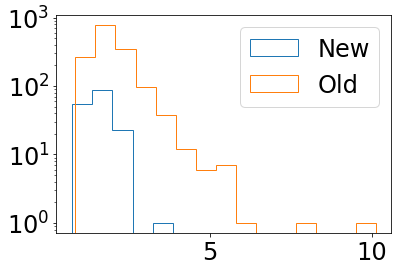

In [29]:
##Compare WD collisions between old and new 6752 models
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

wd_coll_new = np.genfromtxt(path_new+'wd_coll_all.dat')
wd_coll_old = np.genfromtxt(path_old+'wd_coll_all.dat')

mcoll_new = wd_coll_new[:,4]
mcoll_old = wd_coll_old[:,4]

plt.figure()
plt.hist(mcoll_new, bins = 5, histtype='step', label = 'New')
plt.hist(mcoll_old, bins = 15, histtype='step', label = 'Old')

plt.yscale('log')

plt.legend(loc='best')